# Homework 3 - Text generation with LSTM and Transformer networks



## Installs the unidecode library and downloads the Shakespeare dataset.

In [1]:
!pip install unidecode
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 5.5 MB/s eta 0:00:00
--2023-05-04 14:20:52--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2023-05-04 14:20:52 (20.4 MB/s) - ‘input.txt’ saved [1115394/1115394]



## LSTM implementation

For this task you will implement the LSTM neural network architecture and train it on the task of character-level text generation. Implement a single layer LSTM and optionally extend your implementation to multiple layers to generate better results.

Links:

- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html -- Lists the equations for each component of the LSTM cell.
- http://colah.github.io/posts/2015-08-Understanding-LSTMs/ -- Intuitive explanation of LSTM
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/ -- Explanation and uses of RNNs.


Implement the initialization and the forward pass of a LSTMCell and use it as part of the LSTMSimple network class. 

The input of the LSTM network will be a sequence of characters, whereas the input of the LSTMCell will be a single input character (x), the output of the previous iteration (C) and the hidden state of the previous iteration (h). Iteratively process the entire input character sequence and calculate the loss based on the prediction at each time step. 

### Do NOT use the torch.nn.LSTM class.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset
import math

class LSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):

        super(LSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        ## TODO: Initialize the necessary components
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

        self.U_f, self.V_f, self.b_f = self._create_weights()  # Weights for forget gate
        self.U_i, self.V_i, self.b_i = self._create_weights()  # Weights for input gate
        self.U_c, self.V_c, self.b_c = self._create_weights()  # Weights for state c. gate
        self.U_o, self.V_o, self.b_o = self._create_weights()  # Weights for output gate

        self._init_weights()
      

    def _create_weights(self):
      return (nn.Parameter(torch.Tensor(self.input_dim, self.hidden_dim)),
              nn.Parameter(torch.Tensor(self.hidden_dim, self.hidden_dim)),
              nn.Parameter(torch.Tensor(self.hidden_dim)))


    def _init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_dim)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)


    def forward(self, x, C, h):
        # x - batch of encoded characters
        # C - Cell state of the previous iteration
        # h - Hidden state of the previous iteration

        # Returns: cell state C_out and the hidden state h_out

        #TODO: implement the forward pass of the LSTM cell
        
        f = self.sigmoid(x @ self.U_f + h @ self.V_f + self.b_f) # Forget gate
        i = self.sigmoid(x @ self.U_i + h @ self.V_i + self.b_i) # Input gate
        o = self.sigmoid(x @ self.U_o + h @ self.V_o + self.b_o) # Output gate
        c = self.tanh(x @ self.U_c + h @ self.V_c + self.b_c)    # Candidate gate

        c_out = f * C + i * c             # Updated cell state
        h_out = o * self.tanh(c_out)      # Hidden state

        return c_out, h_out

class LSTMSimple(nn.Module):
    def __init__(self, seq_length, input_dim, hidden_dim, output_dim,
                 batch_size):
        super(LSTMSimple, self).__init__()

        self.seq_length = seq_length
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        ## TODO: Initialize the LSTM Cell and other potential necessary components
        # You can use a nn.Linear layer to project the output of the LSTMCell to
        # self.output_dim. 

        self.lstm_cell = LSTMCell(self.input_dim, self.hidden_dim, self.output_dim)
        self.proj = nn.Linear(self.hidden_dim, self.output_dim)


    def forward(self, x):
        # x - One hot encoded batch - Shape: (batch, seq_len, onehot_char)

        # Returns the predicted next character for each character in the 
        # sequence (outputs), also returns the cell state and hidden state of the 
        # LSTMCell call on the last character. -- outputs, (c,t)

        #TODO: Implement the forward pass over the sequenece of characters
        
        c, h = torch.zeros(1, self.hidden_dim, device=x.device), \
               torch.zeros(1, self.hidden_dim, device=x.device)
                
        outputs = []
        for i in range(x.size()[1]):
            c, h = self.lstm_cell(x[:, i, :], c, h)
            output = self.proj(h)
            outputs.append(output.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)

        return outputs, (c, h)

### LSTM Sampling Code

To generate text the network must predict the next character in a sequence, however networks do not produce a single character but rather estimate the likelihood for each possible character. Sampling characters from the network output can be done in different ways with common ones being the Greedy sampling process and Top-K sampling.

In the simple greedy sampling method the network takes a text prompt as input and generates an additional N tokens by always taking the token with the highest prediction score as the next token.

In the Top-K sampling, randomness is added to the sampling process as the network samples from K most likely predicitons at each step. This alleviates the problem of generative models repeating text but may generate incorrect text by sampling inappropriate tokens.


In [3]:
def greedy_sampling_lstm(lstm, x, num_chars):
    # x -- b x onehot_char
    outputs = torch.zeros((1,num_chars,x.shape[2]))
    t_outputs, (cell_state, hidden) = lstm(x.float())
    for c in range(num_chars):
        output_tmp = torch.softmax(lstm.proj(hidden),dim=1)
        top_ind = torch.argmax(output_tmp,dim=1)[0]
        tmp = torch.zeros_like(x[:,0,:]).cuda()
        tmp[:,top_ind] = 1
        outputs[:,c] = tmp
        
        cell_state, hidden = lstm.lstm_cell(tmp,cell_state,hidden)
    return outputs

def topk_sampling_lstm(lstm, x, num_chars):
    # x -- b x onehot_char
    outputs = torch.zeros((1,num_chars,x.shape[2]))
    t_outputs, (cell_state, hidden) = lstm(x.float())
    for c in range(num_chars):
        output_vals, output_ind = torch.topk(lstm.proj(hidden), 5, dim=1)
        output_tmp = torch.softmax(output_vals,dim=1)
        top_ind = torch.multinomial(output_tmp[0], 1)[0]
        tmp = torch.zeros_like(x[:,0,:]).cuda()
        tmp[:,output_ind[0,top_ind]] = 1
        outputs[:,c] = tmp

        cell_state, hidden = lstm.lstm_cell(tmp,cell_state,hidden)

    return outputs

### LSTM Dataset Code

In [4]:
import unidecode
import string
import random
from torch.autograd import Variable
from torch.utils.data import Dataset


class LSTMDataset(Dataset):
    def __init__(self, chunk_len=200, padded_chunks=False):
        # Character based dataset
        dataset_path = "./input.txt"
        # The tokens in the vocabulary (all_characters)
        # are just the printable characters of the string class
        self.all_characters = string.printable
        self.n_characters = len(self.all_characters)
        # Maps characters to indices
        self.char_dict = {x:i for i,x in enumerate(self.all_characters)}
        self.file, self.file_len = self.read_file(dataset_path)
        # Sequence length of the input
        self.chunk_len = chunk_len

    def read_file(self,filename):
        file = unidecode.unidecode(open(filename).read())
        return file, len(file)
    
    def char_tensor(self,in_str):
        # in_str - input sequence - String
        # Return one-hot encoded characters of in_str
        tensor = torch.zeros(len(in_str),self.n_characters).long()
        char_ind = [self.char_dict[c] for c in in_str]
        tensor[torch.arange(tensor.shape[0]),char_ind] = 1
        return tensor

    def __getitem__(self, idx):
        inp, target = self.get_random_text()
        return {"input":inp, "target":target}

    def __len__(self):
        return 10000

    def get_random_text(self):
        # Pick a random string of length self.chunk_len from the dataset
        start_index = np.random.randint(0, self.file_len - self.chunk_len)
        end_index = start_index + self.chunk_len + 1
        chunk = self.file[start_index:end_index]
        # One-hot encode the chosen string
        inp = self.char_tensor(chunk[:-1])
        # The target string is the same as the
        # input string but shifted by 1 character
        target = self.char_tensor(chunk[1:])
        inp = Variable(inp).cuda()
        target = Variable(target).cuda()
        return inp, target


### LSTM Training loop

With a correct implementation you should get sensible text generation results with the set parameters, however you should experiment with various parameters,
especially with the sequence length (chunk_len) used during training.

In [90]:
all_losses = []

In [91]:
from tqdm import tqdm
import torch.optim as optim

for seq_len in [8, 16, 32, 64, 128, 256]:
    print("Sequence length:", seq_len)
    batch_size = 256
    chunk_len = seq_len
    model_name = "LSTM"
    train_dataset = LSTMDataset(chunk_len=chunk_len)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0)

    #Sample parameters, use whatever you see fit. 
    input_dim = train_dataset.n_characters
    hidden_dim = 256
    output_dim = train_dataset.n_characters
    learning_rate = 0.005
    model = LSTMSimple(chunk_len,input_dim, hidden_dim, output_dim,batch_size)
    model.train()
    model.cuda()

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epochs=30

    losses = []
    for epoch in range(epochs):
        with tqdm(total=len(trainloader.dataset), desc ='Training - Epoch: '+str(epoch)+"/"+str(epochs), unit='chunks') as prog_bar:
            for i, data in enumerate(trainloader, 0):
                inputs = data['input'].float()
                labels = data['target'].float()
                # b x chunk_len x len(dataset.all_characters)
                target = torch.argmax(labels,dim=2)
                optimizer.zero_grad()
                outputs, _ = model(inputs)
                loss = criterion(outputs.view(inputs.shape[0]*inputs.shape[1],-1),target.view(labels.shape[0]*labels.shape[1]))
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(),
                                          max_norm=10.0)
                optimizer.step()
                prog_bar.set_postfix(**{'run:': model_name,'lr': learning_rate,
                                        'loss': loss.item()
                                        })
                prog_bar.update(batch_size)
            losses.append(loss.item())
            # Intermediate output
            sample_text = "O Romeo, wherefore art thou"
            inp = train_dataset.char_tensor(sample_text)
            sample_input = Variable(inp).cuda().unsqueeze(0).float()
            out_test = topk_sampling_lstm(model,sample_input, 300)[0]
            out_char_index = torch.argmax(out_test, dim=1).detach().cpu().numpy()
            out_chars = sample_text+"".join([train_dataset.all_characters[i] for i in out_char_index])
            print("Top-K sampling -----------------")
            print(out_chars)

            out_test = greedy_sampling_lstm(model,sample_input, 300)[0]
            out_char_index = torch.argmax(out_test, dim=1).detach().cpu().numpy()
            out_chars = sample_text+"".join([train_dataset.all_characters[i] for i in out_char_index])
            print("Greedy sampling ----------------")
            print(out_chars)

    all_losses.append(losses)

Sequence length: 8


Training - Epoch: 0/30: 10240chunks [00:02, 3945.48chunks/s, loss=3.5, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou
I
  
 
oe  ho

I
: o
e

I
:


:
:I:


II e
I
e  e
:

:
 

 Ioe
 I

IeI 




 
e o I


:



e e
eIIe
e
e  oe o oe  

e  h
I
:IIee II 

e

I
IeI

:e  oI
e 

:o  oo o IIo
: 
  

eI   

e
:e
I
 eeIIe

e 

 e 
e
:
 
:Ie I IoI

 
I 
o
III    o 


:oe  o IIe

 I    
 

 II
e



e

:I

I  

I oIoo
:







Greedy sampling ----------------
O Romeo, wherefore art thou















































































































































































































































































































Training - Epoch: 1/30: 10240chunks [00:02, 3804.57chunks/s, loss=2.64, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thoun sonthas test see men to sothos shass windes theresses,
Aton thes toretth st th me the test sous sott to d west thous wil cat sis bate taste sis cor wotheresee se ce southas be the tatthat es thens thathe sost ous, morsthete th thes sot an sote conte monge tore sisttor will nn ce these my sis sonth


Training - Epoch: 1/30: 10240chunks [00:03, 2987.88chunks/s, loss=2.64, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thous the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th


Training - Epoch: 2/30: 10240chunks [00:02, 3424.83chunks/s, loss=2.39, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou
Whall be thes sand ter hon mor shin mand shes serd
Th the go ghind. 
INTONTE:
Wel det ho gin tho d thind hend ston tinge this

INI thal than here thas her
That wh t on
 he mot so ghers or the d ming heres mise stith my mer he th the her sald,
And were, mo than this sote tho 
Ie he dest,
Will,
Whit 
Greedy sampling ----------------
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 3/30: 100%|█████████▉| 9984/10000 [00:02<00:00, 4754.75chunks/s, loss=2.41, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou thas hor and thas tous tares, sill se stoms wande what sond werte mith sher hit statt my with sound and thet ate hang, tho gesser,
Tour ars, se th thar souss ard thet wirs ard
To the perer th matt, wess, sit tour that toor him havest and sithe statt, with, be the mand ta the that wall sto hast tats


Training - Epoch: 3/30: 10240chunks [00:02, 3979.41chunks/s, loss=2.41, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 4/30: 100%|█████████▉| 9984/10000 [00:02<00:00, 4740.33chunks/s, loss=2.44, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thour toor hith my that hind ase wo dond arde my ard inse at the mite sous ngrave bather ter is so siting in as mond sealle thy sise at an ther well whall thale.

KARI IUS:
Th and, thy licl serses to sit and me her inese tane will this shate hat, as ard an tho lisse, at mend hon thit,
The lortill the si


Training - Epoch: 4/30: 10240chunks [00:02, 3955.48chunks/s, loss=2.44, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord the lord th


Training - Epoch: 5/30: 100%|█████████▉| 9984/10000 [00:02<00:00, 4251.52chunks/s, loss=2.03, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thoun wath mist mo hore,
And marene ard me tay hin sitins, whar the with arsillan stor and.

GLARY RIO:
Thy weathers,
I when so mave, that will this hin himer me ard than have and thou to mins ar an will merond
The wor the monter mane wore the hisen thon hour wo homes thoun mond oferster the paringen so


Training - Epoch: 5/30: 10240chunks [00:02, 3715.84chunks/s, loss=2.03, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou have her and the are the and the are the and the are the and the are the and the are the and the are the and the are the and the are the and the are the and the are the and the are the and the are the and the are the and the are the and the are the and the are the and the are the and the are the an


Training - Epoch: 6/30: 10240chunks [00:03, 3143.87chunks/s, loss=2.05, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou hat a mant the at he than,
To hensers.

KISHARD O:
Thar shat buth miss the peners a dave the bry sone stere foo ham sine hare wirg the parting that him hat hars bu chis that there the pare to tham shou himser.

PERY IUCES:
But, at art to hesenting sor wis shar thes
I'll breave a the as the ald mes 
Greedy sampling ----------------
O Romeo, wherefore art thou have the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the prain the 



Training - Epoch: 7/30: 10240chunks [00:02, 3955.15chunks/s, loss=2.23, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou daye that word whol som hored will me cruntite the chald what my, be show thind shay thene thy laviss and blanged thy lids that shere thou then then this speaven sir then toond thes servirs ald well thy do dise sid wold thou thous touns, that steld be comer ard my have what will be that the down th
Greedy sampling ----------------
O Romeo, wherefore art thou have the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the chard the 


Training - Epoch: 8/30: 10240chunks [00:02, 3907.21chunks/s, loss=1.96, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou why lakn thin whon, all the carsed are she louged, it thay do will:
Ind hele sood dity.

GRRUCETIO:
Tould with to bore the cerring,
That made, whit so tous will my love of to the could
Thou hate that sour ther, with a miors offrest which to my lides, thar shill what will whe to sear thou hour thous
Greedy sampling ----------------
O Romeo, wherefore art thou have the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the re



Training - Epoch: 9/30: 100%|█████████▉| 9984/10000 [00:02<00:00, 4740.07chunks/s, loss=2.09, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou his and you he propested foo shath wis shy surse, if though and that these to more thy worden to beave, I he sough a fares one hase of shist and tous than seesersed the wat her that there ampore to home wo tall wo the soof thour as all the rowing
Wither wele, as home and.

PROMENIUS:
To the souss,



Training - Epoch: 9/30: 10240chunks [00:02, 3951.55chunks/s, loss=2.09, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou have the sone the ene to the sone the ene to the sone the ene to the sone the ene to the sone the ene to the sone the ene to the sone the ene to the sone the ene to the sone the ene to the sone the ene to the sone the ene to the sone the ene to the sone the ene to the sone the ene to the sone the e


Training - Epoch: 10/30: 10240chunks [00:02, 4046.96chunks/s, loss=2.03, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thoush,
The gond is tome, thou araich may the cord is a bat then thon are werce ancerent, and and a bat him as time.

ARTIA:
I to have:
Wellen to make you soos most the besile as ast tis is nages in or thy will times and be nakion
And all the kither that in and be thy hast tomes or own time thy gut thin


Training - Epoch: 10/30: 10240chunks [00:02, 3562.78chunks/s, loss=2.03, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou have the come to the sing the come to the sing the come to the sing the come to the sing the come to the sing the come to the sing the come to the sing the come to the sing the come to the sing the come to the sing the come to the sing the come to the sing the come to the sing the come to the sing 


Training - Epoch: 11/30: 10240chunks [00:02, 3452.71chunks/s, loss=2.05, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou dasting tur humport.

Secontent, and busess a comsing, in to that shalk a mear then thou what my foly houst to that tay to seate time thes we with tor all we heard my
Butht there thou head with sir, should to he my lotser tood murting and sin,
To thy loving toome the rescarste the mand the my souse
Greedy sampling ----------------
O Romeo, wherefore art thou do the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read the read


Training - Epoch: 12/30: 10240chunks [00:02, 3912.29chunks/s, loss=1.95, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou all son, and this my their to have helle to stor my loves.
TRear the lat are his mone of he werry
But thy grond the prepted tham him be are.

CULINIUS:
There to hore of a me prints,
Stis, all.

CLOUCESBY:
See sperd me now the rost me
the call to dee me stead to mest her thy speat thou dond all the 
Greedy sampling ----------------
O Romeo, wherefore art thou have the stand the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the prost the 


Training - Epoch: 13/30: 10240chunks [00:02, 3987.61chunks/s, loss=1.87, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thouss forther, her this senter some.

AUCIATIOLANUS:
To to me selper and blies, what werly and ands, her howss onered he make our sald his beare hels his beendy somat mesterse ore wordstain my fallen be as stall wors to to her the seavere, wall
As to stoull battit that and their shink to the casery.
Th
Greedy sampling ----------------
O Romeo, wherefore art thou have the sear the sear her have the sear the sear her have the sear the sear her have the sear the sear her have the sear the sear her have the sear the sear her have the sear the sear her have the sear the sear her have the sear the sear her have the sear the sear her have the sear the sear her ha


Training - Epoch: 14/30: 10240chunks [00:02, 3847.86chunks/s, loss=1.89, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou hadd speak, my lairs, and have ane her hast them sir, treak not ther, to my foldow and have bet and the sill beseld. I'll betse for the somparte thee; nor hare the have and the my lord mares to sone and shell, are thy fatis madess,
I have my plors. Here, and beant and him no be there such a dreads 
Greedy sampling ----------------
O Romeo, wherefore art thou have the sear the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the se



Training - Epoch: 15/30: 10240chunks [00:03, 3072.43chunks/s, loss=1.82, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou aro hind tome from histespare and such my levely besen both.

Second him.

COPET:
Whis, thou shist and histenster but, bether will his my lied.

LUCENTIO:
I shall newstands, than will seaven the bust my heart them friend so fill buttress the prome in this, she corntle of a grong,
To stind head with
Greedy sampling ----------------
O Romeo, wherefore art thou have the stain the stain the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the 


Training - Epoch: 16/30: 10240chunks [00:02, 3898.59chunks/s, loss=1.6, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou hath man as hat she shill my lord; or the came that to thy lord, the rat hur hast, arown a walt ment to by to him to heart.
When the his the here,
This lords of hour dighter, if a pase,
Tou truicks of hill, brone, thou hries to here is how breat of have her have me a pratice thee say his tours.
To 
Greedy sampling ----------------
O Romeo, wherefore art thou have the come to the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the



Training - Epoch: 17/30: 10240chunks [00:02, 3863.45chunks/s, loss=1.96, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou hearter all mady:
Ay, sir she hast my lard there to be doth one.

MENCINTIO:
I'll have,
Whice as him like of that shall be to thee, my dough this him.

SICINIUS:
To hourser the might thou are
And whore of truin house
Thou way thas thou was this serving a sicted to be the sand,
Those he will may
In 
Greedy sampling ----------------
O Romeo, wherefore art thou have the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the se



Training - Epoch: 18/30: 100%|█████████▉| 9984/10000 [00:02<00:00, 4806.46chunks/s, loss=1.95, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art though ast to buct are to a persates too thee see so the the to but a pracies
I say, sim, thy the trunt.

Secend to the siler
With heard an hast
Butisues the prinoter dayes, and bride
If you, thas see haves be a bust
And thee shind he peace tongue.

KING RICHARD:
Tressed,
But will be the be speak of you


Training - Epoch: 18/30: 10240chunks [00:02, 3919.22chunks/s, loss=1.95, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou death the prose the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 19/30: 10240chunks [00:02, 3964.24chunks/s, loss=1.82, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou sire arm thyse,
And had true,
To shilds to more this bust sull be not thee from me.

KING RICHARD:
What that thit shound her for her theich'd an her they friald.

Clirn:
Se hinge thee, is nigh me: is an thee,
I should with sould her sir, there to to tays there in thee to me torre to her
Before well


Training - Epoch: 19/30: 10240chunks [00:02, 3460.19chunks/s, loss=1.82, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou have thee to the his lies of the have thee to the his lies of the have thee to the his lies of the have thee to the his lies of the have thee to the his lies of the have thee to the his lies of the have thee to the his lies of the have thee to the his lies of the have thee to the his lies of the ha


Training - Epoch: 20/30: 10240chunks [00:02, 3473.08chunks/s, loss=1.76, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou well my bride our chalst, an ort then shill stees with there would stice tall were wath a me shall to seak to the gind word besing on how thy court this follow your such a peakes an of you thos days to som to soundent, a wilt, wo seat must be and thy warried and,
Thou dear the sir, that will be tha
Greedy sampling ----------------
O Romeo, wherefore art thou shall the sead the self the sead the self the sead the self the sead the self the sead the self the sead the self the sead the self the sead the self the sead the self the sead the self the sead the self the sead the self the sead the self the sead the self the sead the self the sead the self the s


Training - Epoch: 21/30: 10240chunks [00:02, 3908.15chunks/s, loss=1.84, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou sait and sir, here them thy hear a shale.

GEONTE:
A bray wo well to they sandents, whiled take the carth a must butisere aratice. I wild is this bustence, the with some on his hast thy friery,
If you. Thou sind and ther, this in meared have
That is the crust my lors, and singer that was them troop
Greedy sampling ----------------
O Romeo, wherefore art thou have the sunder them the sunder them the sunder them the sunder them the sunder them the sunder them the sunder them the sunder them the sunder them the sunder them the sunder them the sunder them the sunder them the sunder them the sunder them the sunder them the sunder them the sunder them the su


Training - Epoch: 22/30: 10240chunks [00:02, 3926.35chunks/s, loss=1.87, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thourst withers, ind in the enceess. In am is it made to thee faired a warry.

PAULINA:
Is is thy condent ourse an the sore.

POLIXENE:
I hill hears tranted our fair tongue, bridest thou sell the heald havous and that I have, time, are is is the companted a plessenter with thee teart of the ear as are s
Greedy sampling ----------------
O Romeo, wherefore art thou have the sead to the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the sead the


Training - Epoch: 23/30: 100%|█████████▉| 9984/10000 [00:02<00:00, 4645.03chunks/s, loss=1.88, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou and she would seem hang him lord, that sarrice,
Then and me and stillow of the with the pricest of this done,
If you his laish the sinder make have as will'd, but my seeply
To misters to marry to tom to the worther be myself
As thy land at think and strange and so thise for my lieter thoused to she


Training - Epoch: 23/30: 10240chunks [00:02, 3779.78chunks/s, loss=1.88, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou art the parting the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the worder the word


Training - Epoch: 24/30: 10240chunks [00:03, 3097.53chunks/s, loss=1.76, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou had to be many love an trame than true,
Ifaths, I hour houre
For this infice hands,
And sir, I'll the restren is inse of the chance thou ala our hund all to be
Here, woodes, whiched;
For the hath this an to be to horse than a weir and my blothers of more and with hath he hath, and so hore
That worl
Greedy sampling ----------------
O Romeo, wherefore art thou art the hands and the hands and the hands and the hands and the hands and the hands and the hands and the hands and the hands and the hands and the hands and the hands and the hands and the hands and the hands and the hands and the hands and the hands and the hands and the hands and the hands and t


Training - Epoch: 25/30: 10240chunks [00:02, 3988.08chunks/s, loss=1.85, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou hath, sir,
And than sines.

GADZET:
To men to the hands
And still breaker to the fould that is and
The good for and here well,
Ang that when their percomen or sire this less, this is and were as too, and set me to be she well a mentle, thou hads, and say, seed when I'll near net him him that I have
Greedy sampling ----------------
O Romeo, wherefore art thou shall be the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent th


Training - Epoch: 26/30: 10240chunks [00:02, 3913.08chunks/s, loss=1.69, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thour parter'd a gan and there that terr more a prepore of your land,
When, I'll never, both it is the creforang of my sevenged to death.

DUKARLS:
Which thee, sir the feeth it is the worn, and this dotting, thar shole and bett more atter oftel's to mire, bear you age the peest a prever and have and
Ang
Greedy sampling ----------------
O Romeo, wherefore art thou shall be the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the prince the 


Training - Epoch: 27/30: 100%|█████████▉| 9984/10000 [00:02<00:00, 4650.33chunks/s, loss=1.76, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou art to thou hast, but then, what it they hath thous deating more trouse and his light.
I'lo me, those sour son, and then we have my
love them, I dead the caries to that state, beishence as were words
That thith the will should
I walk not there, but it me, I would nothorse, thou house thor they thy 


Training - Epoch: 27/30: 10240chunks [00:02, 3895.60chunks/s, loss=1.76, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou shall be the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the sunter the 


Training - Epoch: 28/30: 100%|█████████▉| 9984/10000 [00:02<00:00, 3583.20chunks/s, loss=1.66, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou stand, where the gook my hand of think is the chise the dight and, and he shear he wold me.
The hasting me, be is a child,
A digner, the son and that that wouls than'd outh here the duke our how not so men an of your cheires that well, and the provound to my hildren these my some of thy some, I spo


Training - Epoch: 28/30: 10240chunks [00:02, 3441.28chunks/s, loss=1.66, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou have the death the death the death the death the death the death the death the death the death the death the death the death the death the death the death the death the death the death the death the death the death the death the death the death the death the death the death the death the death the 


Training - Epoch: 29/30: 10240chunks [00:02, 3543.73chunks/s, loss=1.87, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou are make a feeling thy mice spokings the with she that than have men, and the ware there is this fiely still times and the pate and meass to heaving and my from his pleasure, and take a look's myself to that thy father wone.
I creaser, what we show with a fres the prisoner with some and to her.

CO
Greedy sampling ----------------
O Romeo, wherefore art thou are the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the sense the s
Sequence length: 16



Training - Epoch: 0/30: 10240chunks [00:03, 3261.12chunks/s, loss=3.23, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou t teto r ses  s s s r so eet  erthto  ere t   er   stte st  e s rrtes sre rt et   oeros ertter sthe tt t   ot resee s soes st   ot t e  s eo tor t  t  o   stet    e  t rt onee stt son re  o  e    stt e et s  e r resthte t  ttes  t terresos  tht  se ro e  oe ertet    ee sr  sose esrt s so eto ees tt
Greedy sampling ----------------
O Romeo, wherefore art thou                                                                                                                                                                                                                                                                                                            



Training - Epoch: 1/30: 10240chunks [00:03, 3264.70chunks/s, loss=2.68, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thour we to thes tand be then thals there wer minge meren thit tall tan  old torestong tone toness me the th there sons mind mele wond wato sord

I:


INEOROR
IO:
Are be the dinde

That the mous tos ant ar sin mese sore ther sin thins nathe sond,

Tald she sour toures


IOEENOENAEO 
AN tor thor, worss m
Greedy sampling ----------------
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the



Training - Epoch: 2/30: 10240chunks [00:03, 3064.24chunks/s, loss=2.36, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thous sores to chand than to me mind so dis the seen we be mond wang ind ar shas, the se thing thit mas thar hat so sheng shas wo the do then, tarth and ander ther bore so me th th th me sond ande me seat woun sor thes tho ghen, an thand.

ALUS:
Thes, to dall the bete wers ind serd mener sor hean tors s


Training - Epoch: 2/30: 10240chunks [00:03, 2770.21chunks/s, loss=2.36, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou sor the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 3/30: 10240chunks [00:03, 3127.20chunks/s, loss=2.23, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thoure houg, tie so bees to mo tout ing house te me at ofre hould be thous ord angest,
Mo dould to mores, by that soust thourst ta tiloun se an art tis beass, and tis anthy seace,
Thes the soree tises see fit thee wicto ghoungat tho beese shimene, anou bo douse him, as in ould st ane the tous,
And you s
Greedy sampling ----------------
O Romeo, wherefore art thou he the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 



Training - Epoch: 4/30: 10240chunks [00:03, 3286.27chunks/s, loss=2.27, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou ho do co gor tis tither sich il shough sores.

CALENT:
Bur were ho ghat tore.

CLIO:
And and
I wor she sing hicg ou serter,
Whor see so de the sill by the the cis ast
Whe tore so serse bestrot of he comend to thith tha cend tith.

PALA:
Hes or artis seren but the sears of in whete,
This wo griestre
Greedy sampling ----------------
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 5/30: 10240chunks [00:03, 3285.81chunks/s, loss=2.11, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thoul senerse to stay te whil my thy thoug that wist, to de matind artoured howe for with with ant, the him the tither hom sher his the comare and her hear shale the cheat he purentes my my tho dare the comy stond the sull the peade with mone the coned whent tre ale beate wertour sis sheat sore, tite wi
Greedy sampling ----------------
O Romeo, wherefore art thou here the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th


Training - Epoch: 6/30: 10240chunks [00:03, 2630.82chunks/s, loss=2.05, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou how home that are, as ala dowel whou her as the brounto to mane the comeser and be tiot, by moringstantonge to thy botours: ase mo bouth to will theers.
A day tood than hat it hem of hare of he wirthy loven ast te my the cearter'd wanghat hom shallist.

MERLILANUS:
Thas you are have the poughar of 
Greedy sampling ----------------
O Romeo, wherefore art thou have the pare the proone the pare the proone the pare the proone the pare the proone the pare the proone the pare the proone the pare the proone the pare the proone the pare the proone the pare the proone the pare the proone the pare the proone the pare the proone the pare the proone the pare the p


Training - Epoch: 7/30: 10240chunks [00:03, 3208.72chunks/s, loss=2.06, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou hear on the sompersere,
If the carest to the compont offersen briofs of hourserssels,
Wolld som our hastars ond,
Asselast as are there sting ingeand,
And surst must are sore,
Thy would toustest thou heard the poutht in manting, and to bures, a ward my bond, messall tould ather this dead te wored at
Greedy sampling ----------------
O Romeo, wherefore art thou have the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the sond the so


Training - Epoch: 8/30: 10240chunks [00:03, 3277.51chunks/s, loss=1.8, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art though that soul so to mowell hampes, and him the porsedine
Ald to therress illone.

COMIO:
Whith se allous the castion with so fron our sous foom, betis antent it me though to stay sould
In whin this wall sor the center is and hasse me feall word have we tondist that some soust a fore trimen,
If that t
Greedy sampling ----------------
O Romeo, wherefore art thou have the seave the sond the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the sand the s


Training - Epoch: 9/30: 100%|█████████▉| 9984/10000 [00:02<00:00, 3804.81chunks/s, loss=1.91, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou trues there hast then with as that he still and have take have,
Will well the hame the werrich and to the herst him.

CLAUTIO:
Why trone,
Ald mo less the tromas it, the have to trongent hes hers,
Tell to me to ancored,
Thom spair wath may this me wite the word.

LORT:
I his thy trind he hould my th


Training - Epoch: 9/30: 10240chunks [00:03, 3239.33chunks/s, loss=1.91, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the have the ha


Training - Epoch: 10/30: 10240chunks [00:03, 2675.17chunks/s, loss=1.86, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou hast
Ard the shie then she fremise of the giting offore have.

MENENIUS:
Thys shell.

SICINIS:
I weer with see shall may shave to me trong of horess that spee
With whe sonded ont his nathal ser thee sead my. Ind then. I manely.

ARINE:

First Madant oft thee having, a dind me for mo hould as and be
Greedy sampling ----------------
O Romeo, wherefore art thou have the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the se


Training - Epoch: 11/30: 10240chunks [00:03, 3155.95chunks/s, loss=1.81, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou tree one werrowed
And that shy ling brother hat thy fict hour have have, bele and meserted he plain't be come on they, fror and me frem that whet hear some takes:
I wall so dight trent thee to thom troughiencas the king woll serve to the hadst
Is thee his conder, by my longed mone, they here have w
Greedy sampling ----------------
O Romeo, wherefore art thou have the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the co


Training - Epoch: 12/30: 10240chunks [00:03, 3228.31chunks/s, loss=1.83, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thouk now.

CLAURIONER:
It newer shame the seepty mine.
Whet your this batingest, as is they shall tan the portiget to breather, to the witl ale all to see in the seather's fill a presonch, wase in him
Would all the still wite sout that with to to alontinss,
The singer this see stones friand troul that 
Greedy sampling ----------------
O Romeo, wherefore art thou are the seave the seave the stand the seave the stand the seave the stand the seave the stand the seave the stand the seave the stand the seave the stand the seave the stand the seave the stand the seave the stand the seave the stand the seave the stand the seave the stand the seave the stand the s



Training - Epoch: 13/30: 10240chunks [00:02, 3218.92chunks/s, loss=1.77, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thoughione on wash trought as we thy wind.
Thy fruar of him thy heand thy goncence what thou hand his hear noberthall this bear,
To have more of a paint. To than then with a work, I will net her well, by her think to ang time the hadiend the maty
But not he hould the clown.

CLOUCESTEO:
Trung of her wer


Training - Epoch: 13/30: 10240chunks [00:03, 2879.77chunks/s, loss=1.77, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou have the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the come the co


Training - Epoch: 14/30: 10240chunks [00:03, 2951.56chunks/s, loss=1.52, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thought and be muster thee soul all thousess.
What it is had to heart were the shollow till and the shall them he heart to seep than a mead, and my lands bedatt here and that shall thee.

LORD WICL:
With than and will blood so theer the seald be suchiage man him bearted.

GREMIO:
Nor hen the chound and 
Greedy sampling ----------------
O Romeo, wherefore art thou have the strand and the strand and the strand and the strand and the strand and the strand and the strand and the strand and the strand and the strand and the strand and the strand and the strand and the strand and the strand and the strand and the strand and the strand and the strand and the stran


Training - Epoch: 15/30: 10240chunks [00:03, 3244.21chunks/s, loss=2.05, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou and heart me noble and made of his a ploorours to shill was thou saman of head, that well me to this it.

LADY GARES:
Wo are most them, will this a play thee, shall deall my like to heart though, which he way at is thou shall she thy lord.

CLIFFORD:
I'll himsor, true, sore, a man, that in of yee h
Greedy sampling ----------------
O Romeo, wherefore art thou art the searly and the searter the searly and the searter the searly and the searter the searly and the searter the searly and the searter the searly and the searter the searly and the searter the searly and the searter the searly and the searter the searly and the searter the searly and the searte


Training - Epoch: 16/30: 10240chunks [00:03, 3214.13chunks/s, loss=1.93, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou this some one,
Whis thy heart then, it is master or thinks, be a marrest my heartess,
In where, mistress alain.

BAULINA:
He so his honour and boliof offented and be on the call a shall his for hand
The brother his finged agonion,
While, him of and thou anto the mance to miself bosh,
Thou ammands
T
Greedy sampling ----------------
O Romeo, wherefore art thou are the man the sentlement of the man the sentless the sentless the sentless the sentless the sentless the sentless the sentless the sentless the sentless the sentless the sentless the sentless the sentless the sentless the sentless the sentless the sentless the sentless the sentless the sentless t



Training - Epoch: 17/30: 10240chunks [00:03, 2625.85chunks/s, loss=1.74, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou dreat of thy was death, and nobest
That we hell and now to their stold,
In with a bore, that shall now years to moragiant to heart to to be thou art a forberio.

LORD IIT:
Are tood wife, sir, tows, there'er such or that wo he sate at mean,
As thing a mander wither, watther, be oul my lord of hare h
Greedy sampling ----------------
O Romeo, wherefore art thou art the worder to the worder to the worder to the worder to the worder to the worder to the worder to the worder to the worder to the worder to the worder to the worder to the worder to the worder to the worder to the worder to the worder to the worder to the worder to the worder to the worder to t


Training - Epoch: 18/30: 10240chunks [00:03, 3223.98chunks/s, loss=1.6, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou day!
This to set is to make he dedoust and the can the bright the creept of heak, the breat his him, where' we an an you sur, which we have than the san the seaken sign.

KING RICHARD II:
What so look thoug thou sholl were yet it make that why seed, I am so say he dades the sould hers. I am at hone
Greedy sampling ----------------
O Romeo, wherefore art thou art the seave the head not the course of the course of the course of the course of the course of the course of the course of the course of the course of the course of the course of the course of the course of the course of the course of the course of the course of the course of the course of the co


Training - Epoch: 19/30: 100%|█████████▉| 9984/10000 [00:02<00:00, 3676.41chunks/s, loss=1.76, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou hads, broud the strant, be me, mistress,
And the count storn to so this sone.

BENENIUS:
When you this my life the master this worst thou, son the supure on hims better as the peason, and som off come to sham a mind are and thy man;
And you say shall nothers tell to marry, my law more that save han


Training - Epoch: 19/30: 10240chunks [00:03, 3213.64chunks/s, loss=1.76, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou art the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man the man


Training - Epoch: 20/30: 100%|█████████▉| 9984/10000 [00:02<00:00, 3615.21chunks/s, loss=1.91, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou something that hear, as I heart, and thou almedion and store be nother.

KING EDWARD IV:
Nor, I ampertard with stollion.

KING HENRY VI:
Thou shall him from than at make is thought thou cares,
Bran thee it well to shampess of the selvisio stree it by the proves
And soull
That those they desper and 


Training - Epoch: 20/30: 10240chunks [00:03, 3218.81chunks/s, loss=1.91, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou art the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the comes the c


Training - Epoch: 21/30: 10240chunks [00:03, 2656.14chunks/s, loss=1.64, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou that this that the stops, the brieves of
What is hele toose in the best be all this spard to me it with an and make and state.

PETRUCHIO:
No me is never should be the comast, with me not the stations were this han those the stity and tount thy lord.

KING RETH:
To man you, sut thon the story more 
Greedy sampling ----------------
O Romeo, wherefore art thou art the strange the strange the strange the strange the strange the strange the strange the strange the strange the strange the strange the strange the strange the strange the strange the strange the strange the strange the strange the strange the strange the strange the strange the strange the str


Training - Epoch: 22/30: 10240chunks [00:03, 3261.59chunks/s, loss=1.49, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou are a pready shall be to home
thou here or thy some thy call as in myselves.

PETRUCHIO:
And, sir a man the concuring house a pastance, with may soul,
This is thou this the dore till the dose the more to this were,
As I had to men my the come till and
soul dear,
And, sir, as I to tigent thou hast t
Greedy sampling ----------------
O Romeo, wherefore art thou the sen the sen the strunger the strunger the strunger the strunger the strunger the strunger the strunger the strunger the strunger the strunger the strunger the strunger the strunger the strunger the strunger the strunger the strunger the strunger the strunger the strunger the strunger the strung


Training - Epoch: 23/30: 10240chunks [00:02, 4080.38chunks/s, loss=1.62, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thousent more than at anselvis of heak. And to bury, be as the servy of my brish some and this terment against thou we word to so, and thee.
A do me, served the strace and made bears'd and may so such an angrain many fither sour have and strown's all my say.

DUKE VINCENTIO:
That were now, but, than as 


Training - Epoch: 23/30: 10240chunks [00:03, 3205.65chunks/s, loss=1.62, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou art the sen the send the sen the send the sen the send the sen the send the sen the send the sen the send the sen the send the sen the send the sen the send the sen the send the sen the send the sen the send the sen the send the sen the send the sen the send the sen the send the sen the send the se


Training - Epoch: 24/30: 10240chunks [00:02, 3248.11chunks/s, loss=1.72, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thought suth his chance as years.

First Myreach of hearted
Than what say, I
at an your fitted an is at hustheres burthe tell, he imand as hinger, so more himself.

LEONTES:
Will have hate, that say, whenes this horsel it strange hold.

PRINC:
No should me thy framed that a say that were home this sear 


Training - Epoch: 24/30: 10240chunks [00:03, 2913.04chunks/s, loss=1.72, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou art the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the seept the s


Training - Epoch: 25/30: 10240chunks [00:03, 2902.71chunks/s, loss=1.8, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou would have sen the pall of than and all hambard.

POLIXENES:
The prince means, to bear you mush mine.
That shemish in thein beseress to hen, that I was is not,--
Sir or to-morright,
And sicce of the puth'd this so luck to-day.

POLPXE:
I have make have do not be tell my land, the for he did both wi
Greedy sampling ----------------
O Romeo, wherefore art thou art the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sen


Training - Epoch: 26/30: 100%|█████████▉| 9984/10000 [00:02<00:00, 3761.79chunks/s, loss=1.61, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou, sir, you shall never he cruak, wilt then hath, what, I am I am to stand and here, but I am not them thoughter the sen thee,
That's many the stenders,
Thou are but with these prot you are thy fear, work sholt there with are and me thyself,
If is sent there of mund and by the since to me in here of 


Training - Epoch: 26/30: 10240chunks [00:03, 3237.66chunks/s, loss=1.61, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou art the streater thee the streater thee the streater thee the streater thee the streater thee the streater thee the streater thee the streater thee the streater thee the streater thee the streater thee the streater thee the streater thee the streater thee the streater thee the streater thee the str


Training - Epoch: 27/30: 100%|█████████▉| 9984/10000 [00:02<00:00, 3762.50chunks/s, loss=1.49, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou an me, and that he wearth and that he sommade,
Why no most not, and helly,
The more of theiched, bear and his company as their
Dully book of thy heart
To the stort of thee in hour love;
Than the songen peals have to bees myself
Bolishan it there, sir, word, some to this potreman:
I have stay and st
Greedy sampling ----------------
O Romeo, wherefore art thou art the more to the counter to the counter to the counter to the counter to the counter to the counter to the counter to the counter to the counter to the counter to the counter to the counter to the counter to the counter to the counter to the counter to the counter to the counter to the counter t

Training - Epoch: 27/30: 10240chunks [00:03, 3251.65chunks/s, loss=1.49, lr=0.005, run:=LSTM]                      


Training - Epoch: 28/30: 10240chunks [00:03, 2686.08chunks/s, loss=1.7, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou to make her hangs that,
Which is nonest not arm the chouse to the confach in time a shalf bard to the please,
The must thouss, what he hath bare to and the present, me shall be a werron, where he will be neat me not soul,
Till to me, to see the show hear now shall have bees and heaven me buther:
An
Greedy sampling ----------------
O Romeo, wherefore art thou shall be the sear the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears the sears t


Training - Epoch: 29/30: 100%|█████████▉| 9984/10000 [00:02<00:00, 3679.10chunks/s, loss=1.67, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thought, that the daugh, and sen that would thee;
And, from marriage and father's says, thou hast be as whides
If shall not, my lord thy somp and this batish almost, and most news and trunts a trante,
And moness than tell,
And beauty with the till you will but a calles, for many of the peace of me to ho


Training - Epoch: 29/30: 10240chunks [00:03, 3110.95chunks/s, loss=1.67, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou shall be the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent the sent th
Sequence length: 32


Training - Epoch: 0/30: 10240chunks [00:03, 2984.86chunks/s, loss=3.11, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thouoot taet
 e tee    aot   te t an none
  o ee totoee  t oo ta ee notee noet ae t ee e non  aeonos ta te  t eastho  a o ot t to e oeon
   oe   thesetonoete
e
  ona  oeo teo oe oonone  ooon   t  t  ease o e oee   to onee nan
  ea   eo oeote oe thee n tht to  aotan  eoth eat on no e ee onos  ete
tet  he


Training - Epoch: 0/30: 10240chunks [00:04, 2472.39chunks/s, loss=3.11, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou                                                                                                                                                                                                                                                                                                            


Training - Epoch: 1/30: 100%|█████████▉| 9984/10000 [00:04<00:00, 1980.85chunks/s, loss=2.52, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou be sote shand, than se whas ale there mout tin th theth tond ango not the thous hand tire shound tore s se bant, mhe the thas biser malt the she buress
Ant the thethand be the thinghent and toret are touth the so nots

Ans hot,

h the se tone te te tho  f int hind th tout hang s the win who  ale we


Training - Epoch: 1/30: 10240chunks [00:04, 2122.82chunks/s, loss=2.52, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 2/30: 10240chunks [00:04, 2466.65chunks/s, loss=2.33, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thour tom thin thou so thy with arsir son are hearengite thith the hert thas, an some mo hithe dath arese at sint ther son sin mange min to thilseldel the tou gite all son thar tore hit arssinges ther hingeserid th soress meanthall shat thit was shene ther sor hare te tour, tore areter mare hat sond tha
Greedy sampling ----------------
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 3/30: 100%|█████████▉| 9984/10000 [00:03<00:00, 2687.85chunks/s, loss=2.26, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou southe hint and the shath thand me my ming, tou nis ange mo sen sin thenesend sound ware hall wird ar mer and thon thon sers thor wint my whald.

PARUCEN:
Wits and sto his namer so mere his nom not the mend stare hars nond thon tat hin the mange all the to dite sto hatr, ald bringend
To mith to mav


Training - Epoch: 3/30: 10240chunks [00:04, 2434.50chunks/s, loss=2.26, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 4/30: 10240chunks [00:04, 2060.42chunks/s, loss=2.02, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou,
Ang hing to wher his ming
Wayserer wher, foul heal ofe,
I'll so me the toung thath ane what will.

PERUS:
Af I hen II I IUS:
Why, benenger sinchan wath thou hom sere are at mand,
I herse hon thie mofe thoughtur hom have tind have fore his thon whell seand thes forse fares, fus fand bather hor how,
Greedy sampling ----------------
O Romeo, wherefore art thou the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand the hand th


Training - Epoch: 5/30: 10240chunks [00:04, 2465.68chunks/s, loss=2.07, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thound serofond areat the conthent and ald tood
Inding at honged ald, my hamy,
And shald the soun myserest is offorstert as thess.

KANG LINCE:
Whit, it in thene ant andes himesthing the sist indilles that hive is frichis of
Whack hear of to ath seelly,-cimise handsthouss.

LUCELAUT:
Which on atelingede
Greedy sampling ----------------
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 6/30: 10240chunks [00:03, 2951.14chunks/s, loss=1.98, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou stell sides me and whit day and with seart.

MENGULES:
I, may, man sin sourd thou thay shast werleser, the ang tind and to the hore,
Than stand hish stand, mad the sis
Will his may.

Preven:
Whit hit thill as that shar the have till to thoughter at mand that and troungliss as my shath, with the min


Training - Epoch: 6/30: 10240chunks [00:04, 2446.73chunks/s, loss=1.98, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou so mand the sore the sond the sore the sond the sore the sond the sore the sond the sore the sond the sore the sond the sore the sond the sore the sond the sore the sond the sore the sond the sore the sond the sore the sond the sore the sond the sore the sond the sore the sond the sore the sond the


Training - Epoch: 7/30: 10240chunks [00:04, 2881.77chunks/s, loss=2.05, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou are to seared and as is of the preckere mand wite her thith of is is atterviou tilest thou hiverse as it is thou hempirs

CORIONESE:
We thy govely sir, bother thas this merist the stind oun may simes,
Is it so mand wald huve as thas a pray the sant teld stand,
Thar make, the sevand stay, beters and


Training - Epoch: 7/30: 10240chunks [00:04, 2057.76chunks/s, loss=2.05, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou have with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with t


Training - Epoch: 8/30: 100%|█████████▉| 9984/10000 [00:03<00:00, 2720.01chunks/s, loss=1.91, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art though to hurd me ingisped feirt his fay seadst thy him then my as toully seald
That as this down whe this, and as and my heserst of the fearters, wile to the prins as that him this all,
Thas this as my horsund hit treat
To my shing of these and he the pray shilf,
Thou have free that shor thin theed tho


Training - Epoch: 8/30: 10240chunks [00:04, 2443.70chunks/s, loss=1.91, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou have the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the 


Training - Epoch: 9/30: 10240chunks [00:03, 2856.79chunks/s, loss=1.89, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou seavers.

POLIXEN:
A ward, to your a pearten me the hears thou she paist, as I am the resanged, I he wee may and a mary;
Whow's she the with a dead this well with are fee a divised
To say, think of thou shall the corent,
And and with my live the streat her, shate and heaven strowe.
Hat in hom tike 


Training - Epoch: 9/30: 10240chunks [00:04, 2390.83chunks/s, loss=1.89, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou have a man the come the with a dist the shall the come the with a dist the shall the come the with a dist the shall the come the with a dist the shall the come the with a dist the shall the come the with a dist the shall the come the with a dist the shall the come the with a dist the shall the come


Training - Epoch: 10/30: 10240chunks [00:04, 2128.53chunks/s, loss=1.96, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou will be net,
To mary an hears,
And how whish this dovis might and, then shered with my to thereress follome ham.

SICINIO:
Serrear to may shee a malen or thou so more and him the
To my, so at our ald withir hers, and way wasters is the shead the
That shoun menclare as and whish her fonen ins the

B
Greedy sampling ----------------
O Romeo, wherefore art thou are the rear the rear the reart the rear the reart the rear the reart the rear the reart the rear the reart the reart the reart the reart the rear the reart the reart the reart the rear the reart the reart the reart the rear the reart the reart the reart the rear the reart the reart the reart the r


Training - Epoch: 11/30: 10240chunks [00:04, 2493.17chunks/s, loss=1.77, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou desseaved
Is the reppirence agay thou dids to mare of thie to my touncain
All my sordows,
Thy home the werrays as a pray,
Tish hings tay they, as the cands, that hatted
Agant in timme to this myservence
Thou are sore then theees ane to to tay to-may.

CLAFFRYORELLO:
Her make of a coulds,
Take that 
Greedy sampling ----------------
O Romeo, wherefore art thou are the cander to the prayer to the prayer to the prayer to the prayer to the prayer to the prayer to the prayer to the prayer to the prayer to the prayer to the prayer to the prayer to the prayer to the prayer to the prayer to the prayer to the prayer to the prayer to the prayer to the prayer to t


Training - Epoch: 12/30: 100%|█████████▉| 9984/10000 [00:03<00:00, 2281.16chunks/s, loss=1.77, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou as our arm oft.

LORD MINGARET:
No, I have seeping at treece on my forture
The sting, be the doar our
Heave the sair the betout.

LADY GRENCE:
And, thine alloult so streated. Sir off as in though thou are and seave again ald beathes,
And all, to sheakes.

BRUTUS:
The wark soons, seads and so blate 


Training - Epoch: 12/30: 10240chunks [00:04, 2305.07chunks/s, loss=1.77, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou have sour and the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the se


Training - Epoch: 13/30: 10240chunks [00:04, 2254.96chunks/s, loss=1.63, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thouss.

GLOUCESTER:
Then sharl, this death, sir, and should theres to stare, and senterst,
In say, shopld thein a murse thys what thou.

LUCIO:
I will thy bear them that menst more he have that them fall the diggh,
If has that that he stand and be steak's me
so the suck not say so thy bodd and stranght
Greedy sampling ----------------
O Romeo, wherefore art thou shall the parting the strent then the strent then the strent then the strent then the strent then the strent then the strent then the strent then the strent then the strent then the strent then the strent then the strent then the strent then the strent then the strent then the strent then the stren


Training - Epoch: 14/30: 10240chunks [00:04, 2464.40chunks/s, loss=1.68, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou will see and.

LADY CLAUCENTE:
The prepare in tome, sir, whither's she shout
Tike at sommon my for thire the sarint this serven,
The here hat is new the dead thou shile she bean the withing and mesice of him.

Prods:
And bear that with my brother what with thy sorest he hee,--

Second Seave:
Sir, t
Greedy sampling ----------------
O Romeo, wherefore art thou are the read the send the reader the streak the reader the streak the reader the streak the reader the streak the reader the streak the reader the streak the reader the streak the reader the streak the reader the streak the reader the streak the reader the streak the reader the streak the reader th


Training - Epoch: 15/30: 100%|█████████▉| 9984/10000 [00:04<00:00, 2050.60chunks/s, loss=1.63, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou ard and thou hall he will his
loves. I'll shalt he with serve all be it to his send is so loudd as this,
To stard to misher and me for my surron me.
I would the past and blesting a feart,
And he came is new nent, and hone he hear as it not it whrie him seath.

KENDOND:
As stand to save to his batte


Training - Epoch: 15/30: 10240chunks [00:04, 2156.80chunks/s, loss=1.63, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou shall be the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send the send th


Training - Epoch: 16/30: 10240chunks [00:04, 2337.30chunks/s, loss=1.52, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thought his suster
As is no track they fair on to bards are
Take of hath a content of your fill.

KING RICHARD II:
Then my lord, have ale been the such and thank'd thee,--

CORIOLANUS:
I'll the changed and strante to the worth stand and the woulds.

CLARENCE:
Now shall heaven it wall be sounts to ares t
Greedy sampling ----------------
O Romeo, wherefore art thou have thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear thee the sear 


Training - Epoch: 17/30: 10240chunks [00:04, 2415.85chunks/s, loss=1.7, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou are, thy sen that to my becients
To the keep that spirtion it.

Provost Lurdered:
When that when I seal thou are it.

POMPEY:
If hose, I have stear, I'rried, to-morred wise hand fitly. That the crunce, some and him the surmard we hat
had men,
In the served thou dead net men brook that the keep or s
Greedy sampling ----------------
O Romeo, wherefore art thou art the streak the streak the streak the streak the streak,
And the sen the sen the sen the send the strong the streak the streak the streak the streak the streak,
And the sen the sen the sen the send the strong the streak the streak the streak the streak the streak,
And the sen the sen the sen the


Training - Epoch: 18/30: 100%|█████████▉| 9984/10000 [00:04<00:00, 2226.68chunks/s, loss=1.65, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thought will thou with thy hase our san
And stould them that his frembly
Thank than I am the dessed and so devence.

GROMIO:
And so make you shall so do thou art all this forth.

Provost:
Bust not but the morry, than, though sead thim
Than he would them for the still to thom him
That then, and so light 


Training - Epoch: 18/30: 10240chunks [00:04, 2075.26chunks/s, loss=1.65, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou art the strenged and the strenged and the strenged and the strenged and the strenged and the strenged and the strenged and the strenged and the strenged and the strenged and the strenged and the strenged and the strenged and the strenged and the strenged and the strenged and the strenged and the st


Training - Epoch: 19/30: 10240chunks [00:04, 2429.45chunks/s, loss=1.71, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thought
As I am true the wincery, when thee have and house the promice,
And to thy sundore, all the warring as treathes, we are imporiend
The tries, as it in her but mare a gord thy were
All the prepone, with shear to beacious wersh of all bloody see,
The with her and bear mustatious taintalier:
Where's
Greedy sampling ----------------
O Romeo, wherefore art thou hast the counter the princes of the countering the countering the countering the countering the countering the countering the countering the countering the countering the countering the countering the countering the countering the countering the countering the countering the countering the counteri



Training - Epoch: 20/30: 10240chunks [00:03, 2893.42chunks/s, loss=1.66, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou
shalt be go dite of the sateries of the crown to the call
To that some hat sail, and tond the pare no mare of the seavest,
I when hath so sines of met offecced if his,
So wert it say with a woods, tellow shall not
to merelly tay to strange of taller wenth to the will as a fiee,
And trum teme as thy


Training - Epoch: 20/30: 10240chunks [00:04, 2440.28chunks/s, loss=1.66, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou shall be the streak to the streak to the streak to the streak to the streak to the streak to the streak to the streak to the streak to the streak to the streak to the streak to the streak to the streak to the streak to the streak to the streak to the streak to the streak to the streak to the streak


Training - Epoch: 21/30: 10240chunks [00:04, 2068.51chunks/s, loss=1.62, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou then?

CORIOLANUS:
I hish hourseld hath may hath he hold
That's thou dispands on hath a wear waid; the woo sundee and times and we his hows,
So show a straints and my caurselfore heath,
To metur heart, are suce of your gravious
To mids of a misery on his fight.

BUCKING HER:
Whichers, and thyose, a
Greedy sampling ----------------
O Romeo, wherefore art thou shall be the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the s


Training - Epoch: 22/30: 10240chunks [00:04, 2449.89chunks/s, loss=1.71, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art though deat
To some hene to the beet most stay,
That wath this blot him hords the sund his
are surce the prester'd is the love.

KING EDWARD II:
See, she is that the live you, fair and like. I have thou shall.

CARTISAN:
Take the least but that the state,
And, that wonders this bloods this dithous shalt
Greedy sampling ----------------
O Romeo, wherefore art thou art the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stranger the stran


Training - Epoch: 23/30: 10240chunks [00:03, 2920.62chunks/s, loss=1.56, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou say; a propolities thou
was a man a moster tow be stince his to be the trayed and hell
An in the so to be hated the plice, a deept a should, ser means but friend.

KING EDWARD IV:
Nears, we'll stay;
Were hours so men an hath son man to bloud to him.
This would the sair and shall to see him best and


Training - Epoch: 23/30: 10240chunks [00:04, 2430.48chunks/s, loss=1.56, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou hast the streak to the soul to the streak to the soul to the streak to the soul to the streak to the soul to the streak to the soul to the streak to the soul to the streak to the soul to the streak to the soul to the streak to the soul to the streak to the soul to the streak to the soul to the stre


Training - Epoch: 24/30: 10240chunks [00:05, 2039.37chunks/s, loss=1.53, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou shall be be and sound him,
And see my sonselves and ment mones trumman some,
That thou seart to the sair brother worst, some are desperied, send terrs, brint and that that we wat honon,
See this is mine an our, some to the daughter of this secriss.

KING RICHARD III:
I'll be my bean seaks all
I war
Greedy sampling ----------------
O Romeo, wherefore art thou art the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunder the sunde


Training - Epoch: 25/30: 10240chunks [00:04, 2451.69chunks/s, loss=1.68, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou hast be state to thee,
That still he stand stand sont hold mo to your best a prockes of meast,
Is it is a tould so man both, will thine of the hish asso heard
He drubted me to his bare the stit with the bless to take other's lain;
If he shall shows if him the stands too shall be to the peatle.

BAL
Greedy sampling ----------------
O Romeo, wherefore art thou art to the state and so leave to the state and so leave to the state and so leave to the state and so leave to the state and so leave to the state and so leave to the state and so leave to the state and so leave to the state and so leave to the state and so leave to the state and so leave to the st



Training - Epoch: 26/30: 100%|█████████▉| 9984/10000 [00:03<00:00, 2189.96chunks/s, loss=1.5, lr=0.005, run:=LSTM] 

Top-K sampling -----------------
O Romeo, wherefore art thous be confish'd foul on my father there to the ray of my soul our seeming
An he comfort for the chambthers that should be so not the word.

PETRUCHIO:
I did not so thy lont heard thee
All man my shape me him than there,
Int too meant thy sen to my said;
I'll natch a brace father will that him bands f


Training - Epoch: 26/30: 10240chunks [00:04, 2247.05chunks/s, loss=1.5, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou hast the counter the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the streng the str


Training - Epoch: 27/30: 10240chunks [00:04, 2306.88chunks/s, loss=1.58, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou arrain, that seephing hear to die,
In the purling these on almound with the warts
Of her suf that they told this rost she langer her for suftorth
And thou say you the peace of my friend hands.

BASTAGHAM:
This fool these son, and you what in thoses my sour
A causiness of the chieght with the pair'd
Greedy sampling ----------------
O Romeo, wherefore art thou art to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the sun to the su


Training - Epoch: 28/30: 10240chunks [00:04, 2533.79chunks/s, loss=1.54, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou hassed, the warn'd wallimence and
As the good and that what should to make her son.

POMPEY:
Welcome, to take a mind as are well. I will not steed me not too makes and with me;
And hope as I do too attenden, what, and thou do bursed whose wate of heaves, thou done
That hath bear will thou hast by t
Greedy sampling ----------------
O Romeo, wherefore art thou shall be so me to the wife,
And the man the truth of the stranger that the streng the stranger that the gods and the streng to the stranger to the wife.

LUCIO:
I do be so me to the wife,
And the man the truth of the stranger that the streng the stranger that the gods and the streng to the stranger


Training - Epoch: 29/30: 100%|█████████▉| 9984/10000 [00:04<00:00, 2003.67chunks/s, loss=1.53, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou take to their himes hath dishonity out at thy tho tans
And pains he hear him to my langs
Which was the son, to thee he was handiess too life. I am a measure of the power withings,
To't, and take a stands thou do you say, and speak me
I hear thy state of stronged, than their hissured, and
To make th


Training - Epoch: 29/30: 10240chunks [00:04, 2198.51chunks/s, loss=1.53, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou hast the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stands and the stand
Sequence length: 64


Training - Epoch: 0/30: 10240chunks [00:06, 1653.31chunks/s, loss=2.93, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thour a  ta e sot tee h ta oo oe than  hhe tan ea ooe a t eh e  eee to ohe t  t tee horothee e  he  aere taeore hhe e terane eh ton h ee
 thar t  ter s e t anee sonoe s to oe ae at toe  eee  aor  oret oh  at atharoe s the tee sas totee tanh  tot tat eee ta e to ho  honheto t aoeo ohhere thire
hee

hheer
Greedy sampling ----------------
O Romeo, wherefore art thou t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t


Training - Epoch: 1/30: 10240chunks [00:06, 1508.86chunks/s, loss=2.51, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thout ater an se thet as t me thend wot tor wore t an tor t or ter mang moulsee anet,


TI  thar all sor shere bill an to me s or tores ho t ther so sho ton shang till t of s our and an ale mor,
Whens at sou th thend and sor sour won sou tin then to the thand, bour shethot and toul see thand at ond me t
Greedy sampling ----------------
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 2/30: 10240chunks [00:05, 1733.82chunks/s, loss=2.32, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou shal,
Weo to my ut oud wall sous, sill, wor mer an win werte wom son ther mant thou, and to the the s ir wo the she der ate mint mes ta deres the has the mare,
When winte thil sho to thou wist te than,
An ho mond mon the s th and me tarst ar the sing.

Bu I wir mat, th mer thim te sone th me mare t
Greedy sampling ----------------
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 3/30: 10240chunks [00:06, 1515.37chunks/s, loss=2.18, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thous tond he prother he shor ats mo thes fond of my mats on sheas and ho hom, some the senchin marst ond of me that sus ang intter he how thath sorseneste merouns,
Whalderes ourte for ancende sone se sererer ofras, th o mongon and and of andent and star thou hourthir wore se tor ind hen toul fare ar of
Greedy sampling ----------------
O Romeo, wherefore art thou hat the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 4/30: 10240chunks [00:06, 1663.95chunks/s, loss=2.06, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou hone,
But hithien as mase thes mistere and thyore to thay mend of thee sourt and what my,
Thim minsens it the bent of is monder sean and, we me mistone
And the peat an stores as my hert aster the panethen to heners, thy ware.

GURIO:
Ay thee sunder of
As my him, bone hert more have me terenes ald i
Greedy sampling ----------------
O Romeo, wherefore art thou hang the then the pore the then the pore the then the pore the then the pore the then the pore the then the pore the then the pore the then the pore the then the pore the then the pore the then the pore the then the pore the then the pore the then the pore the then the pore the then the pore the th


Training - Epoch: 5/30: 10240chunks [00:06, 1517.11chunks/s, loss=1.92, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou do the fordere tour all the filler him shall mart in shall morded to be the butist. 
Pland CLELICA:
To, sor weans herr tin treers a to housh welle a monterserst and with mare thou then all ale thas werst there ang and have thit mate and are, an ther ast thou the farlorst watl a take word a dore,
An
Greedy sampling ----------------
O Romeo, wherefore art thou the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome the prome


Training - Epoch: 6/30: 10240chunks [00:05, 1723.01chunks/s, loss=2.02, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thoughantest,
But thain of hate heald wourthen, worest, and is as ir astat ow thouks tite of his angoure,
And whice this aray, ant of ithers ingore.
And my seart of all as anting and is thoughadieg, the worder, sord whan than hear him of his ard it.

PUTRO:
Nithir to then and tree heans, as you ant a th
Greedy sampling ----------------
O Romeo, wherefore art thou have the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prome to the prom


Training - Epoch: 7/30: 10240chunks [00:06, 1519.51chunks/s, loss=1.92, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou dave
To be a wear my songeds and the mays asenous to mors the cord tint anged her well send thoush.

GLOUCELTO:
Whenese hares tere of mice, will my sord the peerind
To thouse will storn mere,
In my lead and the greasen she havo mere hear hombles of to mord.

POLTET:
And with may a wist whichs will 
Greedy sampling ----------------
O Romeo, wherefore art thou have the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the ward the wa


Training - Epoch: 8/30: 10240chunks [00:05, 1723.91chunks/s, loss=1.89, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou, sond her make a drach mares of the burs,
The will sir, may my lords, toll word what in the carrent.

FORIZABET:
Thou her house ming to be my brother,
The sear a dourt the baseriods, a pity mery be to my latting
That stourd art the burning that whounes hark the word and be if this,
And the beer hou
Greedy sampling ----------------
O Romeo, wherefore art thou have the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sonder the sond


Training - Epoch: 9/30: 10240chunks [00:06, 1520.92chunks/s, loss=1.69, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou have have hath to my like.

FLARDIAN:
He may me to bremplang, and the words think' might to hee stind
Whing in a will's takes,
And then morstly beath to sheer sim of my blook a fourds.
And stown a miness head of mary tooded,
I dive take that that? I home a misser's soment woole,
Why sond his lantly
Greedy sampling ----------------
O Romeo, wherefore art thou have the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond and the sond


Training - Epoch: 10/30: 10240chunks [00:06, 1705.72chunks/s, loss=1.74, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thourts mone this a poore.
This, the deed here hervine thenger, but these that wo lave thy suther.

KING REWARD II:
Was myself yan, what the stings of this timiters,
And me that mence mose thy save
And the marting fan me feals song and and that were thes fruck on hang to make to be mys in thy sons it so
Greedy sampling ----------------
O Romeo, wherefore art thou have the senter the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seever the seev


Training - Epoch: 11/30: 10240chunks [00:06, 1532.56chunks/s, loss=1.66, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou dean
That in to bad in thou are think of this
To sean so fill as incul here are to the wids
A wat he sence of your treacher firse.

PROSCARE
MO:
Whick thou are the will with than shought ond thy sood and a mastard;
If it thou will shall sing him shall,
Thou that heath'd time of monith to the could 
Greedy sampling ----------------
O Romeo, wherefore art thou have the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the wi


Training - Epoch: 12/30: 10240chunks [00:05, 1729.76chunks/s, loss=1.56, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou thy specked them thee.

MARCIUS:
And sim, with alast the meant.

MERCUTIO:
Which to betuse as in of this a morest and
Thine the sait may me me would bade heal stryed,
And me we have make me my loves, and thou was now tream, and wit outh to my fail
To thyself thine you wall, that
I am the peated thy
Greedy sampling ----------------
O Romeo, wherefore art thou have the will the words and the will the words and the will the words and the will the words and the will the words and the will the words and the will the words and the will the words and the will the words and the will the words and the will the words and the will the words and the will the words


Training - Epoch: 13/30: 10240chunks [00:06, 1503.07chunks/s, loss=1.63, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou ary field
Thou shorted toour one a mards of
Thim, and bay make mare to-more are to so hath shoulf.
The staty stard boot of monest mere, the wences and streath
The say shorels, and shale by the sing.
And things, what is as is see hurd are dear than thy have the practs
And bet his best and be offers,
Greedy sampling ----------------
O Romeo, wherefore art thou have the seath and son the seath and son the seath and son the seath and son the seath and son the seath and son the seath and son the seath and son the seath and son the seath and son the seath and son the seath and son the seath and son the seath and son the seath and son the seath and son the se


Training - Epoch: 14/30: 10240chunks [00:05, 1713.18chunks/s, loss=1.57, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou ant thing of your saither and besing are framble and and that
To the bear ans hanss and be one, and sins
Thou wall's some a breal not heards and stand
And so to the will as all ten some are still whonedies, son, what when he sade.

BUCKINGHAM:
He hats fair, she he shall thou winds so deevining.

PR
Greedy sampling ----------------
O Romeo, wherefore art thou art the sears,
And so the forth and so the forth and so the have and so the have and so the have and so the have and so the have and so the have and so the have and so the have and so the have and so the have and so the have and so the have and so the have and so the have and so the have and so the



Training - Epoch: 15/30: 10240chunks [00:06, 1521.99chunks/s, loss=1.66, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou tendstither the sent.

DUCHESS:
Rome, as you have thy his tongue thy sother as men, then worly by the provest the peace was thoughts.

GLOUCE:
What they thou art ont me hen you stand asenoth a true.

Clow:
Hards the wind, are bounders, then, then thou art thee?
Who ever shall my steens thee that we
Greedy sampling ----------------
O Romeo, wherefore art thou have the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the stain the 


Training - Epoch: 16/30: 10240chunks [00:05, 1724.39chunks/s, loss=1.64, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou have sean, I should he will sick.

GLoOZ LOWA:
And this she inday her thou strange thou with the chouse of your sot is there
The dastersion to blow there is he came of sir.

POLIXENES:
I say! and hir, and she be mone.

KATHARINA:
I shall be some a must me what thou with this chatery stat to tritume
Greedy sampling ----------------
O Romeo, wherefore art thou art the will thee thee then the words and there that he shall be the will thee thee then the words and there that he shall be the will thee thee then the words and there that he shall be the will thee thee then the words and there that he shall be the will thee thee then the words and there that he


Training - Epoch: 17/30: 10240chunks [00:06, 1528.49chunks/s, loss=1.65, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou would, sord:
Thou will I spake hon were a man,
And shall him to blies, as I would hour.

BAPTISTA:
Nay! what's their concouthion,
They for hin string on these.

KING HENRY VI:
It that I the true dece thee, thou dight it to she desire and have thee.

SICINIUS:
Have house, and with him;
Will not then
Greedy sampling ----------------
O Romeo, wherefore art thou art the seat
And stand the counter's the counter's for the seat
And stand the counter's the counter's for the seat
And stand the counter's the counter's for the seat
And stand the counter's the counter's for the seat
And stand the counter's the counter's for the seat
And stand the counter's the cou


Training - Epoch: 18/30: 10240chunks [00:05, 1729.77chunks/s, loss=1.56, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou some thee talk
This may thou dangs me, that I am to the deet
With the stort of the stup to striend
With all the this shall not the thing his parting to must thine,
How the morthing so,
I am that shown the died, think the disence and the duken to sea
the hid trunt him the down a thy hights.

BRUTHUS
Greedy sampling ----------------
O Romeo, wherefore art thou shall be son the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the st


Training - Epoch: 19/30: 10240chunks [00:06, 1518.19chunks/s, loss=1.61, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou are to him;
A signion the pleaning tongue, my brother may.
What is a mosion as are as my, beish'd it a to toour tising to the prease you
sheathings their honeete as the were.

PAULINA:
No, I will this, where he should that whan was time houl,
That those thy deeds and all thee will have newer that t
Greedy sampling ----------------
O Romeo, wherefore art thou art the prosonger than the world the prosonger than the world the prosonger than the world the prosonger than the world the prosonger than the world the prosonger than the world the prosonger than the world the prosonger than the world the prosonger than the world the prosonger than the world the p


Training - Epoch: 20/30: 10240chunks [00:05, 1711.82chunks/s, loss=1.55, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thought them, take ald we marrieve
That with him; betan his hadsel me husband, this, both brately home.

LUCENTIO:
Think your canton on troughted in here ashel
Thou art have not seam and his right as his follow thy life
Than that I sat she willd where as tears one
Thas been had thou hast to meant of thi
Greedy sampling ----------------
O Romeo, wherefore art thou art the world the world the world the world the world the world the world the world the world the world the world the world the world the world the world the world the world the world the world the world the world the world the world the world the world the world the world the world the world the w


Training - Epoch: 21/30: 10240chunks [00:06, 1488.78chunks/s, loss=1.55, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou hadsed on this strike a satural from thy lighint of the

Longon the gruce a faurtel.

BUCKINGHAM:
Whow, indeed, so this shilts andeed, and thou hastes
The guesty, by the county of thyself,
Thy lues is to thy such of thee. Sit, is not be stand an again,
And was his curstite it to before,
If you that
Greedy sampling ----------------
O Romeo, wherefore art thou shalt thy state the state the state,
And the destreming the state the state the state the state the state,
And the destreming the state the state the state the state the state,
And the destreming the state the state the state the state the state,
And the destreming the state the state the state the


Training - Epoch: 22/30: 10240chunks [00:06, 1652.28chunks/s, loss=1.49, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thous lady's storms,
Struck out stond though and be shall nature a darnest hones
Of that, that should stend him with his poise on the dark
Be thought by strengs on what have made
That wasts the constirits. There in a moly are the provile in.

BAPTISTA:
And thit it newer'd this brother's strength you so 
Greedy sampling ----------------
O Romeo, wherefore art thou stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the stand the


Training - Epoch: 23/30: 10240chunks [00:06, 1501.68chunks/s, loss=1.48, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou art such fire.
And the fair, and thou waster on my brother,
Same her shall be pluce to balk.

LUCIO:
Why, the godserous tears and some honour'd think,
The much dear beal all that thousended thy fool
To have the grown: the first.

GREMIO:
Nay, way, we't not strike a better, and say, and
Ty atrear of
Greedy sampling ----------------
O Romeo, wherefore art thou shall be the man me to the morter
Than the strange of the signion of the signion of the signion of the signion of the signion of the signion of the signion of the signion of the signion of the signion of the signion of the signion of the signion of the signion of the signion of the signion of the s


Training - Epoch: 24/30: 100%|█████████▉| 9984/10000 [00:05<00:00, 1843.89chunks/s, loss=1.52, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou sorraw in the world
True more.
When, may think, sir his bealful offul here, maken and surened are.

FRYOR SLAND:
A gerse me for my lord in the sword with old
And shall not still and beep to the feaster'd and trampess
They state of therefore is speak and this,
Who herring of your lady of ment
As thr


Training - Epoch: 24/30: 10240chunks [00:06, 1638.30chunks/s, loss=1.52, lr=0.005, run:=LSTM]                      


Greedy sampling ----------------
O Romeo, wherefore art thou art to the world and the deed to his country.

PETRUCHIO:
What is the stand of the serves and so many and the deed to his country.

PETRUCHIO:
What is the stand of the serves and so many and the deed to his country.

PETRUCHIO:
What is the stand of the serves and so many and the deed to his country


Training - Epoch: 25/30: 10240chunks [00:06, 1556.07chunks/s, loss=1.48, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou shall have are burds,
The prosousinos: we shall be the hark and himself,
She will burk thee fares true than should be so dead,
Therefore he say you well, then truth to mind and service on thee
To make thee, sir,
And with thy fresented and morrow this says of the sign.

KING EDWARD IVI:
And you arm 
Greedy sampling ----------------
O Romeo, wherefore art thou have a light to hear thee to my country and the seat
As the seat the seat the seater than the seater than the seater
Than the strange the seat the seat the seater than the seater than the seater
Than the strange the seat the seat the seater than the seater than the seater
Than the strange the seat 


Training - Epoch: 26/30: 10240chunks [00:05, 1714.75chunks/s, loss=1.47, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou as this?

BAPTISTA:
And that this to ban of had teld will.

GLOUCESTER:
This heady will be here we with yester is there,
To murseria in harth if an all this.

LARDIO:
What's thou hopst thou that she wilt thou some caption what that
I'll nutholing by his hand took,
I' have the hade out of thee and m


Training - Epoch: 26/30: 10240chunks [00:06, 1634.90chunks/s, loss=1.47, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou art the hand and the thanks the truth and the thanks the truth and the thanks the truth and the thanks the truth and the thanks the truth and the thanks the truth and the thanks the truth and the thanks the truth and the thanks the truth and the thanks the truth and the thanks the truth and the tha


Training - Epoch: 27/30: 10240chunks [00:06, 1588.83chunks/s, loss=1.47, lr=0.005, run:=LSTM]                      


Top-K sampling -----------------
O Romeo, wherefore art thou havans his falling
And be so mereing he within their husband as a guast
The wansing for mine a the warrent a granious leaves,
Within thy sweet and shore an the stoot;
And some she makes hell of a some from of me,
And so we are an oun of the dark to-mistress
A monined, some own.

COMINIUS:
How to yo
Greedy sampling ----------------
O Romeo, wherefore art thou the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the world and the w


Training - Epoch: 28/30: 10240chunks [00:05, 1574.64chunks/s, loss=1.47, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou have his
patient to the stand in there, the super.

KING RICHARD II:
Nencle so, still never my senter, they have she wouth the points.

PORIO:
A better as your floody
With my hoose.

KING EDWARD IV:
He hath not to hell,
This is hither balk, a brother.
That, I shalt be the pals, the sean,
And hath n


Training - Epoch: 28/30: 10240chunks [00:06, 1586.02chunks/s, loss=1.47, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou art the senter
That thou hast the senter that the senter the hours,
And therefore he hath the senter that the senter the hour,
And therefore he hath the senter that the senter the hour,
And therefore he hath the senter that the senter the hour,
And therefore he hath the senter that the senter the h


Training - Epoch: 29/30: 10240chunks [00:06, 1607.45chunks/s, loss=1.5, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou the mark of husband, and
Whither sumseth would they shell their throwe and such to
come thou all, but that hastings,
Where a tew o'erness are to made your honour,
If I must think it is? would thou dong be one to be forth.

LEONTES:
Ay, my lord!
To hell and to his bound,
To have a shoptious highned 
Greedy sampling ----------------
O Romeo, wherefore art thou the king,
And that thou art the death of the world with the world,
And that thou art the death of the world with the world,
And that thou art the death of the world with the world,
And that thou art the death of the world with the world,
And that thou art the death of the world with the world,
And 
Sequence length: 128



Training - Epoch: 0/30: 10240chunks [00:10, 965.75chunks/s, loss=3.26, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thout eo t orth  sor o t  e       o os  t teoe   t eert et o    teo   s te t  te     to tt seto ortt s o  t  e    e oetere  t seeore toerr  eer   seot s t  eeer to t s tteoeorr  et e   e t te st   e ort t eereot sott  teetet ee t e tt e te oo  se ortotheroe te oe  e e oe eree  the o oe o teo eeto    eo 
Greedy sampling ----------------
O Romeo, wherefore art thou                                                                                                                                                                                                                                                                                                            


Training - Epoch: 1/30: 10240chunks [00:10, 963.41chunks/s, loss=2.65, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thous wist thett tist ar arese sorthere wand mhot soton an ther mis ees tishetthons, whashere we thes tores aor th tors tale wourd,
To tir ment tind wond mitossensesh tane tanes haneshare bit shan mens mes methothashe tous mat eor wo sithan son mend worsthin thantothitot thous arote athothall to mheret 
Greedy sampling ----------------
O Romeo, wherefore art thour ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther ther the


Training - Epoch: 2/30: 10240chunks [00:10, 836.43chunks/s, loss=2.71, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou deattourd bouth athant oud buth sound arten me bere band thende satteren the shen ares oo d mave sord oursessorend beangin beteerdere hangout tout aro coure fe thile the cot tourt therdister at theresesthy,e tous andoutheresthyouresour thes,

ARUSARES:
And thathes,.
Tillonderesthave tishesese hithi


Training - Epoch: 2/30: 10240chunks [00:10, 952.83chunks/s, loss=2.71, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 3/30: 10240chunks [00:09, 1209.28chunks/s, loss=2.31, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou hatt, wond tis thang sinte miss or sare ste shandenest mat ho se my at so my your,
By bust and motthor thinghe, arte herde myon thals yome theer my and ard and the hore teer,
Ars athe dithand as titerind tout these tomase,
Whathithan my me som her tithe deange, wind wate the wort ar then, athe then


Training - Epoch: 3/30: 10240chunks [00:09, 1025.86chunks/s, loss=2.31, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 4/30: 10240chunks [00:10, 963.14chunks/s, loss=2.14, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thou the weres, bute so bortous.
As seall stie that we hile to tin me the hate,
And seald hille thit thil with stith hist ar to weall way, ateer, thes ond an houn ar are wire harthe that ous oull thith shat thee tous, an hith withand and handerse will witt
And all alice and thea shat tor tat angon singe
Greedy sampling ----------------
O Romeo, wherefore art thou he the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here the here


Training - Epoch: 5/30: 10240chunks [00:10, 956.19chunks/s, loss=2.01, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thountongess.

LINCENTIO:
I tay then arathoure wing thee hat ale teling ond he harters ine me tor here hist have thour herite, the seandes, he hendest inge are meat to the hither ane,
And me this ther hares, her mared,
Thith my till, her the meald,
And an mone me anger wored to sher whand the him nom at
Greedy sampling ----------------
O Romeo, wherefore art thou the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare the hare th


Training - Epoch: 6/30: 10240chunks [00:10, 964.03chunks/s, loss=2.06, lr=0.005, run:=LSTM] 

Top-K sampling -----------------
O Romeo, wherefore art thou he tond ang to sinst.

POLTIUS:
I weld so deasest, toull shint an is this tance,
Wim, thy bringe and an to nime tithir stance and tore hing to hone shears,
All wathel sould, and bet tould tere.

BONTIOSTEN:
I the prote an sonter ans,
Tis mene sontinge senor shangeren stomene fitlle, all ther than a
Greedy sampling ----------------
O Romeo, wherefore art thou the seres and the seres and the preate the seres and the preate the seres and the preate the seres and the preate the seres and the preate the seres and the preate the seres and the preate the seres and the preate the seres and the preate the seres and the preate the seres and the preate the seres 



Training - Epoch: 7/30: 10240chunks [00:10, 973.26chunks/s, loss=1.94, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thouge me with
That seer, to mo shire that would.

GROMIO:
And the sondired to bearthens,
And somale, bustistonge, werr as in what shall sield my mardsers.
That teen thoust mesele frop a pontest and
To mating tous are well thy lance,
Whis ard wholl the mest touss and that hame
Sand the praintsered,
To t
Greedy sampling ----------------
O Romeo, wherefore art thou down the paresteres and the paresteres and the paresteres and the paresteres and the paresteres and the paresteres and the paresteres and the paresteres and the paresteres and the paresteres and the paresteres and the paresteres and the paresteres and the paresteres and the paresteres and the pares


Training - Epoch: 8/30: 10240chunks [00:10, 967.93chunks/s, loss=1.88, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thou doting offecour tarest.

PETRUCIUS:
The pation the but thee the hisher thou for by ming of yet the chanded.

SATINIO:
If this deathes shimper treat, be herishous of tho king is
To thee have, the bute and shoul that,
And the bust an this trend and byour sone.

LOUCELET:
Whene hat to betring teer thy
Greedy sampling ----------------
O Romeo, wherefore art thou have the sere the sere the sere the serest the serest the serest the sere.

LUCESTAR:
Why lord the sere the sere the sere the sere the sere the serest the serest the sere.

LUCESTAR:
Why lord the sere the sere the sere the sere the sere the serest the serest the sere.

LUCESTAR:
Why lord the sere t


Training - Epoch: 9/30: 10240chunks [00:09, 933.54chunks/s, loss=1.82, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou hame and bleid,
And she the shelle of shark and and wher and his bene
There offere me, think and the somble the wit mase fand

BRATUS:
And se plaise, thee the woolen my
Beact, I will te hears mare a mine,
Thou de wis mant, breat thy mikenes to the concuct thoussel somen
To sake wit mo head hear the


Training - Epoch: 9/30: 10240chunks [00:10, 998.86chunks/s, loss=1.82, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou have the sere the seres and the sere
The sand the sere the sere the seres and the seres
The sand the sere the sere the seres and the seres
The sere the sere the sere the seres and the seres
The sere the sere the sere the seres and the seres
The sere the sere the sere the seres and the seres
The ser


Training - Epoch: 10/30: 10240chunks [00:09, 1025.59chunks/s, loss=1.83, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou he dend hear his bedour.

BRUTUS:
Well thou and as all, seal word.
Wello may the sers as te will her for
That have thind a said, with sin his hard.

KING RICHARD III:
Which hast treat ho deat hor he weak,
I'll best in thou hast treat ou him have soman
Tha gare al art of the weat beto him.

SABULIO:
Greedy sampling ----------------
O Romeo, wherefore art thou have the seres and the sere.

LEONTES:
What she the sone the sere the seres and the sere.

LEONTES:
What she the sone the sere the seres and the sere.

LEONTES:
What she the sone the sere the seres and the sere.

LEONTES:
What she the sone the sere the seres and the sere.

LEONTES:
What she the son


Training - Epoch: 11/30: 10240chunks [00:10, 980.50chunks/s, loss=1.73, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thous tore thee of the witl wather
As if he have not mo bent have be the word to se.
All ser thy fright, an my handser hears he he platy
And he sporthing, and he so brings a say of sin thouse and he she wold son
Ald, have nattore, and they thousesting it,
I sears' would a shomed to have his plood
To be 
Greedy sampling ----------------
O Romeo, wherefore art thou do the sere the seres and the sere.

CAPULET:
What shall not the sere the sere the seres and the sere.

CAPULET:
What shall not the sere the sere the seres and the sere.

CAPULET:
What shall not the sere the sere the seres and the sere.

CAPULET:
What shall not the sere the sere the seres and the s


Training - Epoch: 12/30: 10240chunks [00:10, 993.11chunks/s, loss=1.71, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thou ween the eldst one my shell,
Be all a meat with heaver all well me that welp, yet thy succomary.

CORIOLANUS:
To my lieven with to the seress and she
will te sin, with thou do and my may my look mean well the say
The sonerile me teer to the more a measen, and to thy saner
That then well he sir the 
Greedy sampling ----------------
O Romeo, wherefore art thou with the seart the sere the sere the sere
The seart the seart the seart the seart the sere the sere the sere
The seart the seart the seart the seart the sere the sere the sere
The seart the seart the seart the seart the sere the sere the sere
The seart the seart the seart the seart the sere the ser


Training - Epoch: 13/30: 10240chunks [00:10, 986.32chunks/s, loss=1.75, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thou well,
The say, I with shall breather fermencour.

GLOUCESTER:
That havis be sere, to sir,
And have be by this trook a treed the princle and and hears art
This can once of sire,
Tham and my sonding a sence, men is to the poot thee,
We pair then my loss, so mo bray,
The corture the sancor tor mould b
Greedy sampling ----------------
O Romeo, wherefore art thou have the come to the come to the come to the come to the come to the come to the come to the come to the come to the come to the come to the come to the come to the come to the come to the come to the come to the come to the come to the come to the come to the come to the come to the come to the co


Training - Epoch: 14/30: 10240chunks [00:10, 1124.16chunks/s, loss=1.71, lr=0.005, run:=LSTM]                     

Top-K sampling -----------------
O Romeo, wherefore art thou takes and ting and this blond
Mangus all the parthe the granty boon be son to the suck in
Lust thou shought of you see here. Comely thee, grose and should the shilt the firtich of the

Morthouse that too to some thee so some are tale one benter.

GREMIO:
Will man shall soon misers, some all the sea


Training - Epoch: 14/30: 10240chunks [00:10, 972.69chunks/s, loss=1.71, lr=0.005, run:=LSTM] 


Greedy sampling ----------------
O Romeo, wherefore art thou shall be the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the senter the 


Training - Epoch: 15/30: 10240chunks [00:09, 960.68chunks/s, loss=1.77, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou shrow day's touse that I have
An wime of mose was the servery was a shall nemper a matish,
Will stin make to be morn'd, shear stay,--

LUCENTIO:
What with hath me he say, what shat men you shall the wendsed tore as tromes of this forth
In shrand, Ishall, where'd thys, and then as it son,
I can a dr


Training - Epoch: 15/30: 10240chunks [00:10, 1012.09chunks/s, loss=1.77, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou do the servent the servent the servent
The say the serven the stard the servent the servent the servent
The say the serven the stard the servent the servent the servent
The say the serven the stard the servent the servent the servent
The say the serven the stard the servent the servent the servent



Training - Epoch: 16/30: 10240chunks [00:09, 1030.30chunks/s, loss=1.58, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou words of the peasent
The chull in thou true me new, think to mean,
But him bear his never in him he were, and they,
In a confuce as you werly thee our sander thing as you are
Anderies, their waste, I cunce on his high time,
I have mady'd woll, there, though thee in the peatter him:
Wearse with your
Greedy sampling ----------------
O Romeo, wherefore art thou art the counter of the sear
And the word the ere the counter of the counter
That I have be the counter of the counter
That I have be the counter of the counter
That I have be the counter of the counter
That I have be the counter of the counter
That I have be the counter of the counter
That I have b


Training - Epoch: 17/30: 10240chunks [00:10, 984.83chunks/s, loss=1.63, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thou day,
Whereword, thou worded the mert my homours
Both hand, as I sir, a sirland.

SICINIUS:
I am should by the man an old.

DUKE VINCENTIO:
Whe, sind and my lord;
Whose best and well's not to mee how shalt she way,
Brother wound thee forth which the worth mine alang and
That's not help this allow to
Greedy sampling ----------------
O Romeo, wherefore art thou art the sears of the sears
And the words the sear the sears of the sears
And the words the sear the sears of the sears
And the words the sear the sears of the sears
And the words the sear the sears of the sears
And the words the sear the sears of the sears
And the words the sear the sears of the se


Training - Epoch: 18/30: 10240chunks [00:10, 983.90chunks/s, loss=1.58, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thou art strive this comes, and my son.

SICINIUS:
No, shall shall teel not she hang had and housh
To tell, and shrust, shall no me his forth there
I shall break the words any, there stay him thy long the chice
And sell that he shall so her faster'd with my cauliny.

KING RICHARD III:
Then? Sear your sa
Greedy sampling ----------------
O Romeo, wherefore art thou art the serven so have here.

KING RICHARD II:
Why, shall not shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be shall be sha


Training - Epoch: 19/30: 10240chunks [00:10, 983.11chunks/s, loss=1.57, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thou wast fath of his hour hone
Thin armalle impore and men soull were to make have.
What, their falt hate but to me and made he cland.

BARTHMOMER:
How to trather them him her ansters as is not so when
I to to the world him, the will.

KING EDWARD IV:
What shall spalle hat be should son.

MARCIUS:
He s
Greedy sampling ----------------
O Romeo, wherefore art thou art the senter to the sease
The saint the counted and the words and the words,
And then the sent the sent to the seave to the sease
The saint the counted and the words and the words,
And then the sent the sent to the seave to the sease
The saint the counted and the words and the words,
And then the


Training - Epoch: 20/30: 10240chunks [00:10, 985.39chunks/s, loss=1.56, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thou, as a subjediant there
with him that he meet their hath the rearent it will
One of my feartier, betaked to the should sour
Is thish all the report our perture,
I'le my lives will men to theined a been a tones.
And me anourioned merrigh of you thereenter.

PROSTER:
Ay, breally to thee too soul home 
Greedy sampling ----------------
O Romeo, wherefore art thou art the servereress of the servereress
The reared the restrease the serverelfore.

POMPEY:
A that here are the reared the servereress of the servereress
The reared the restrease the serverelfore.

POMPEY:
A that here are the reared the servereress of the servereress
The reared the restrease the ser


Training - Epoch: 21/30: 10240chunks [00:09, 1031.34chunks/s, loss=1.47, lr=0.005, run:=LSTM]                     

Top-K sampling -----------------
O Romeo, wherefore art thou art;
For a sice you hold were the wornd to-namous words
And must by hand the wooth my fourted a seavice.

LORD RONE:
The faulh to be my foilery thoughted
Take the man the true thought and his stere, thyselved.

LEONTES:
And you are now they all.
Thy welp you art hand and me to such my die
Though th


Training - Epoch: 21/30: 10240chunks [00:09, 1040.21chunks/s, loss=1.47, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou art the sear to the sear to the sear
The sear the stand to the sear the sear to the sear to the sear
The sear the stand to the sear the sear to the sear to the sear
The sear the stand to the sear the sear to the sear to the sear
The sear the stand to the sear the sear to the sear to the sear
The se


Training - Epoch: 22/30: 10240chunks [00:10, 1017.28chunks/s, loss=1.51, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou all mading and head,
We would some fail way, and with my lived of a such.

LUCIO:
Ay, thou a spore than he son,
Who good, and so not strike a moned hather stains.

COMINIUS:
Wearse, strike a wondry again.

Clown:
I will sent have more the poolisers are thains.

CORIOLANUS:
I have been we heaven sig
Greedy sampling ----------------
O Romeo, wherefore art thou art the world the country
That the common the common the counter the world the country
That the common the common the counter the world the country
That the common the common the counter the world the country
That the common the common the counter the world the country
That the common the common th


Training - Epoch: 23/30: 10240chunks [00:10, 966.64chunks/s, loss=1.54, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art though the boliving,
We will not nothing the stranger's fear me
to be nobless o' this the charce the stanch of yoursell:
The while the provist of my lord and here to the world
For a service of his tangur thanks to the weally this subslance.

LUCENIUS:
Then hear neart them thou within the peace,
By the s
Greedy sampling ----------------
O Romeo, wherefore art thou art the sentent the world
The sender the world the world the world the sen
The sender the world the world the world the sen
The sender the world the world the world the sen
The sender the world the world the world the sen
The sender the world the world the world the sen
The sender the world the wor


Training - Epoch: 24/30: 10240chunks [00:10, 980.51chunks/s, loss=1.55, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thou art may, arm thee thy bridgen wind.

KING RICHARD II:
No may be this is my bousin, were,
And let them the best, when his head to the feecly
That tell, thee to be mischous world assee
From his stent, that will so thou aga,
And be an one artaim, it well. I would ban
The father should not to thy best 
Greedy sampling ----------------
O Romeo, wherefore art thou shalt she well and the world
The sent the counter the world the world thee the world
The sent the counter the world the world thee the world
The sent the counter the world the world thee the world
The sent the counter the world the world thee the world
The sent the counter the world the world thee 


Training - Epoch: 25/30: 10240chunks [00:10, 963.29chunks/s, loss=1.41, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thou art no son,
To make them a says, arm and took me as you and do
been them of my broth home with his sunting of my with
To the place. Bur make myselve sir, I am that I
part his power to his faciness of thy him
Are to her bray what, mysect me not stenty.

BRUTUS:
Thou do the choling the wild watest wa
Greedy sampling ----------------
O Romeo, wherefore art thou hast the words,
And shall be so the words the shall be so for the stands.

CORIOLANUS:
Why, shall be so the words the shall be son,
And shall be so the words the shall be so for them.

CORIOLANUS:
Why, shall be so the words the shall be son,
And shall be so the words the shall be so for them.

CORI


Training - Epoch: 26/30: 10240chunks [00:10, 965.12chunks/s, loss=1.51, lr=0.005, run:=LSTM] 


Top-K sampling -----------------
O Romeo, wherefore art thoughtly,
Are wele the cates this most hath this such;
There's here, and, and well then thou shalt say;
I thank the states and heaven shall be too more son myself
And thy well me to stile to husbide,
Well with husbant out a said,
Are should he had the duke a women my fear,
And true my heave me and wook
Greedy sampling ----------------
O Romeo, wherefore art thou shalt see the country
The sent the country the country the country
The country the country the country and the sent.

KING RICHARD III:
Stay the country the country the country shall be the sent.

KING RICHARD III:
Stay the country the country the country shall be the sent.

KING RICHARD III:
Stay 


Training - Epoch: 27/30: 10240chunks [00:09, 962.18chunks/s, loss=1.55, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou have
That wordet against this triats, set thee,
I was no pier in thy hupiness, are noble:
This weet help'st with my lentering thy stay.

KING HENRY VI:
Sticking thy blessing is the blood of you,
If you set his fellow of his subely,
Which. I would the bed a sare. But thire entings, sealigared,
They 


Training - Epoch: 27/30: 10240chunks [00:10, 1013.57chunks/s, loss=1.55, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou art the world
That the prince the thing the thing the world
That the prince the thing the thing the world
That the prince the thing the thing the world
That the prince the thing the thing the world
That the prince the thing the thing the world
That the prince the thing the thing the world
That the 


Training - Epoch: 28/30: 10240chunks [00:09, 1033.74chunks/s, loss=1.47, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou thing arm.

GRUMIO:
Sim, I will bring is, the shapen.

Provost:
When I say the bark'd. What's the mon.

LUCIO:
What shall be the part at oue in the say.

Servatt:
How not the deel that my bud a should to have a great to have
Mother have these have mishore.

Second Mervenger:
Where is this some an h
Greedy sampling ----------------
O Romeo, wherefore art thou hast the world have the world
That the sen the saint of the sentent the world
That the sen the saint of the sentent the world
That the sen the saint of the sentent the world
That the sen the saint of the sentent the world
That the sen the saint of the sentent the world
That the sen the saint of the


Training - Epoch: 29/30: 10240chunks [00:10, 983.53chunks/s, loss=1.47, lr=0.005, run:=LSTM] 

Top-K sampling -----------------
O Romeo, wherefore art thou thine of my fair bray,
I see thee stay with suck of mercines, as it.

CAMILLA:
What many fair wife, so dear not his faired
To see and strange of thought in a fierder
To boy, to have to be a father shurther.

Goodering Withard:
Her both say that we have stay him at thy
busines to be so so to me.

PE
Greedy sampling ----------------
O Romeo, wherefore art thou hast the world have stand and the world
That the sen the son to the state to sour to the sen
That stay the counter and the state to sour to the sen
That stay the counter and the state to sour to the sen
That stay the counter and the state to sour to the sen
That stay the counter and the state to so
Sequence length: 256



Training - Epoch: 0/30: 10240chunks [00:18, 553.72chunks/s, loss=3.22, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thouto totheeo   a  eeetooaoete e e oe e eetheoet t    t tt  a e oaote eae  e o eat eethetee  toath e ea a tto t   eto eteaa eoan  ee  aoeee eoantt eeeooeo tho o eot tooat teeete th   e  athoo oaettoe thoee e ao ooee tteee  oaea te t the  e ee o  et a  t  aet  ooaottot eeeteo tea   oe   t ateeoo t ett o
Greedy sampling ----------------
O Romeo, wherefore art thou                                                                                                                                                                                                                                                                                                            


Training - Epoch: 1/30: 10240chunks [00:17, 576.38chunks/s, loss=2.71, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thoushor  oure merd the ho  our therd the mas hen  horir there me thes hou the the serin tane won thone mathire shenthinthirat are mone me me thar soron  hereroutethithatheteir  orine shathat tathamathan thor  halte shen thind thore mal then hathe thathontot or sere here here te ao  er het ere tho her a
Greedy sampling ----------------
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 2/30: 10240chunks [00:18, 542.79chunks/s, loss=2.38, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thous he sere sord ant,
The herder sand thert thour he sis sh thet the ther, ate cest an the se then tore tous tor thet the charest ar see shers tho the se mit are bere the me ble ch ate merend merst to me tho tit tor wale bind, shes, sotr tho d aner,, fate tit me chirers thor, an an an te th thes toure
Greedy sampling ----------------
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 3/30: 10240chunks [00:18, 565.79chunks/s, loss=2.25, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thour the wir tha that sut out sous thast or thou this toond we ho the sings tist ther will there talll want,
Whe whit and toul thes hot tout sind tore sous theste thes that thom, ber hind wo hat sour mand se tout the seand wand stongend mine, thor sour, the hald to he seat an be my ane sor te beanges s
Greedy sampling ----------------
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Training - Epoch: 4/30: 10240chunks [00:18, 546.07chunks/s, loss=2.19, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou wong the sond ar ald thes so menend allle his ane teel st tro so der an mor too stit the mente hess nome, art on warl tith, and ang ald west me mane his toold wo hers, allo ghith the mang inde fors now the the hinsthir wile wo lith will se mene whe shes al the play asther the mit tho have sis nou d
Greedy sampling ----------------
O Romeo, wherefore art thou har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har the har


Training - Epoch: 5/30: 10240chunks [00:18, 564.16chunks/s, loss=2.13, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou tous aspinest heare, ars our thy loule so thy frees, wo derine the how, the mead in and
That in so to hared withe ther to whith wile have at is tour he hined ortere ar of ant our hise the shicensed, why thing tean if til tie sien whoul and sore farth ther to the sanger of thim the sheld than
And th
Greedy sampling ----------------
O Romeo, wherefore art thou have the have the have the have the have the have the have the have the sore the have the have the have the have the have the have the have the have the sore the have the have the have the have the have the have the have the have the sore the have the have the have the have the have the have the ha


Training - Epoch: 6/30: 10240chunks [00:18, 510.83chunks/s, loss=1.98, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou word too to thot her witler of has my.

GLUTHA:
The her to that that this, and are that hemer then seathied searder as ithing of thou the meangered so him.

LUCESTIO:
All wotr to she wis ste thin, beat the she that my simen al ouse to me this me te heas spact and thing, braint,
Whot take shal seere


Training - Epoch: 6/30: 10240chunks [00:18, 544.60chunks/s, loss=1.98, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou have the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the so


Training - Epoch: 7/30: 10240chunks [00:18, 566.65chunks/s, loss=1.96, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thour thame sould
Wort thit depporss mord wartous serstousserse thou his mesent ane his thise.

METHORD:
May wald, the simast manter on wo heverestont mind.

CAMIOLA:
No weake, souss or toon this and the make and bestored anderstares mind,--
For my praitiss merring.
The wall my lladster angaty that tomb
Greedy sampling ----------------
O Romeo, wherefore art thou have the sorest and the sorest and the sorest and the sorest and the sorest and the sorest and the sorest and the sorest and the sorest and the sorest and the sorest and the sorest and the sorest and the sorest and the sorest and the sorest and the sorest and the sorest and the sorest and the sores


Training - Epoch: 8/30: 10240chunks [00:17, 529.68chunks/s, loss=1.91, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou hass of mong astours,
Thengund, thy lowe so tile the burse tor and
Wather wo lived a that sterigus, make to mere, and thene,
Is and ho buch me preed of him a may: why, when mak thee stord and
I spinghar of thy suncene with sore thy lave to-
Ifllows these therest my live onder wild moncincousen.

KI


Training - Epoch: 8/30: 10240chunks [00:18, 549.93chunks/s, loss=1.91, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou have the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the so


Training - Epoch: 9/30: 10240chunks [00:18, 563.82chunks/s, loss=1.89, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thour has,
By will have hear may to havan the herse to
I wald, a feine
That I hivine art that see of
Of ale to mes, wind to be of than then
I sarion you tor to mure that
Inden this trued his,
And mick is and this a precest of to she feales and but
The cearing and thee the pancess all an itse
To bestios 
Greedy sampling ----------------
O Romeo, wherefore art thou have the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the so


Training - Epoch: 10/30: 10240chunks [00:18, 539.86chunks/s, loss=1.81, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou heave thes,
Be curpity here shis thy, then sourse so father,
I'll manely a gare the chase is by masthare wond take wase surse foo betiling.

FORUS:
And has sis the wish,
Or were, and thin, and my lord,
What and wond is not he provese the bast the sare of thee,
And whe the carther, wath and he with 


Training - Epoch: 10/30: 10240chunks [00:18, 549.21chunks/s, loss=1.81, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou have the sand the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the so


Training - Epoch: 11/30: 10240chunks [00:18, 561.72chunks/s, loss=1.8, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art though mo no mice
Were this footh and was the would besichous of herestand that thing the what,--for on the cood and thoush my, thou hade toon
I have my heare that teat the sompers of the would but our the would he have the have as
Watherse to me, the which shall be thy leave our have and wise, the head
Greedy sampling ----------------
O Romeo, wherefore art thou have the some the some to hear here the some to hear here the some to hear here the some to hear here the some to hear here the some to hear here the some to hear here the some to hear here the some to hear here the some to hear here the some to hear here the some to hear here the some to hear here


Training - Epoch: 12/30: 10240chunks [00:18, 551.76chunks/s, loss=1.76, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou saul to be
To sires than have an her than,
And mast me to mest what thou did, my that the mice to here.

ASTANGELO:
Thou dimper time, men wise the sire,
If in this as him to meres is nither,
And me canting has in with see will this dear thee,
Tad hears, my talt wellong take a sward
To sore to best 


Training - Epoch: 12/30: 10240chunks [00:18, 546.46chunks/s, loss=1.76, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou have the some to the some to the some to the some to the some to the some to the some to the some to the some to the some to the some to the some to the some to the some to the some to the some to the some to the some to the some to the some to the some to the some to the some to the some to the so


Training - Epoch: 13/30: 10240chunks [00:18, 561.69chunks/s, loss=1.69, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thouse an himself
There shall took with my henour we crain,
In all not some with mard a plife the pray a preathiled
But from his fellown my streathers were in with onest a mortink
I have stong in the way steak on all bo to beather.

KING RICHARD II:
Warking them, and have his sounted.

LADY CANEN::
Wher
Greedy sampling ----------------
O Romeo, wherefore art thou have the proment of the ward the promenter with here the promenter with here the promenter with here the promenter with here the promenter with here the promenter with here the promenter with here the promenter with here the promenter with here the promenter with here the promenter with here the pr


Training - Epoch: 14/30: 10240chunks [00:17, 584.33chunks/s, loss=1.61, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou honous my fartit there,
What sees thou dase it bringlong, asself.

GROMES:
As there he stard, sunder with to the wart will these then
Thened was not with selfers well this forth all,
And whom thin with she tours in to so that sone
To bear with stine to me, triend,
Will hearn's best tham, brick in t


Training - Epoch: 14/30: 10240chunks [00:18, 557.47chunks/s, loss=1.61, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou have the songer,
And then the sond the sond the sond the songer then the songer,
And then the sond the sond the sond the songer then the songer,
And then the sond the sond the sond the songer then the songer,
And then the sond the sond the sond the songer then the songer,
And then the sond the sond


Training - Epoch: 15/30: 10240chunks [00:18, 555.05chunks/s, loss=1.61, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou so that is a change.

PAULIO:
Then, I'll the cauninesed; and metere, by see thy linted,
I waund, meray with his truten to him then
Warwist that this herred men triess
Were all thee shamber, any trouse of your
There and will again,
And merrice to me mirds to here, thou himst true agait to be
to this
Greedy sampling ----------------
O Romeo, wherefore art thou have the will and the sone
The sond the sond the will the sonest the will and the come.

PETRUCHIO:
I will the sone the comes the ward the ward the soness
That the come to the with the will and the come.

PETRUCHIO:
I will the sone the comes the ward the ward the soness
That the come to the with th


Training - Epoch: 16/30: 10240chunks [00:17, 592.82chunks/s, loss=1.68, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art though her freeds.
Will thou art the true again. Henrer my freaks, as the cald,
That some then I wish the werp he did,
But then war whine as how and but shall wenty his prates to
Adalend that I spord with hat thou dother.

GREMIO:
Well a mare to sectiences a thimes to her mad
Therented to shill the shal


Training - Epoch: 16/30: 10240chunks [00:18, 557.12chunks/s, loss=1.68, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou have the sond the soness and the comes
The shall not the compless the compless the compless the comes the soness
The shall not the compless the compless the compless the comes the soness
The shall not the compless the compless the compless the comes the soness
The shall not the compless the comples


Training - Epoch: 17/30: 10240chunks [00:18, 555.94chunks/s, loss=1.6, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thoush and sir, whore's him antiglt,
Were way have his for this for thy buin sir, worsh this what down that
I his love thy betolis than to see shall no lept
And shall wath you took to this son.
Sin, I am that tole are thou herving all would be thyself
Thanging the parted mantenter's and him,
To sigh of 
Greedy sampling ----------------
O Romeo, wherefore art thou have the proment the some
To shall not the proment the proment the some to the some
To shall not the proment the proment the some to the some
To shall not the proment the proment the some to the some
To shall not the proment the proment the some to the some
To shall not the proment the proment the 


Training - Epoch: 18/30: 10240chunks [00:17, 655.39chunks/s, loss=1.62, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou deather'd.
To the say you honour, but her sond and to marries, tame
I should the here to be to her head the shil my fool our from the
some mones of are the sing
Upon my louds.

PROMPERS:
Or I shall night'd, sir, I'll. Cheilled, al hance this word and to server
And moremand an allate on thy bear whi


Training - Epoch: 18/30: 10240chunks [00:18, 564.19chunks/s, loss=1.62, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou hast the shall be the some
The shall be the some to the some to the sounder the shall be the some
The shall be the some to the some to the sounder the shall be the some
The shall be the some to the some to the sounder the shall be the some
The shall be the some to the some to the sounder the shall 


Training - Epoch: 19/30: 10240chunks [00:18, 548.35chunks/s, loss=1.6, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou have bus and wise off my starr,
Or son that have me them the sance,
And that the will the father thy briest to his has
Ant what he have not warrers and seet,
And be the fenter well you have tought of my from the

If with so forth that are the fatter,
Be that they been by the cennesing armist is his
Greedy sampling ----------------
O Romeo, wherefore art thou had her hand the sent
That I will not the compless and the sound the sound
And the shall be the compless and the sound the sound
And the shall be the compless and the sound the sound
And the shall be the compless and the sound the sound
And the shall be the compless and the sound the sound
And the 


Training - Epoch: 20/30: 10240chunks [00:17, 664.80chunks/s, loss=1.63, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou surse,
And should hand born, what tasking on the conseds on
The worst made mine her hatt the sound
That I am a mornat intention.

COMINIUS:
And he have beed as in their coured.

LADY GREY:
I will make, but sountice as the sir,
But which, bethal to think the sorfers we prince
The pardon, sir, to the


Training - Epoch: 20/30: 10240chunks [00:18, 556.16chunks/s, loss=1.63, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou hast to the sound
That the propon to the sonder to the sound
That the propon to the sonder to the sound
That the propon to the sonder to the sound
That the propon to the sonder to the sound
That the propon to the sonder to the sound
That the propon to the sonder to the sound
That the propon to the 


Training - Epoch: 21/30: 10240chunks [00:18, 547.92chunks/s, loss=1.61, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thouse such of mister
To strake is a shall to destress with his son
And sar in the rumsert to thing shall be not.
There al too, sir, and huntine she thom thene ansted and
Herchers as dest of time soul suppring,
To dear time hows,
And let thise the restorse of are it so thine those truth,
With all all th
Greedy sampling ----------------
O Romeo, wherefore art thou had streat of the stands,
That the string the prince the sonder the propont.

LUCENTIO:
I will not the streat the propont the propont.

LUCENTIO:
I will not the streat the propont the propont.

LUCENTIO:
I will not the streat the propont the propont.

LUCENTIO:
I will not the streat the propont the


Training - Epoch: 22/30: 10240chunks [00:18, 566.31chunks/s, loss=1.56, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou, too the words
To shape and trought have.

LADY CAPULET:
What wall besting must son,
Sir, and will save he shald with sent.

LADONES:
These this shest besoment to me stand and this were:
They bather they would herestinest, we deard have
The way to stain and to men yet her myst served
Is not best to
Greedy sampling ----------------
O Romeo, wherefore art thou had stranger
That the string the sonder the sent the senters
That the string the sonder the sonder the sent
That the string the sonder the sonder the sent
That the string the sonder the sonder the sent
That the string the sonder the sonder the sent
That the string the sonder the sonder the sent
Tha


Training - Epoch: 23/30: 10240chunks [00:18, 542.69chunks/s, loss=1.57, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou warthy.

KATHARINA:
To man he common my life the rine.

CLIFFORD:
Thou hast wear many had so be as fair with our
Than thou bester thousace, thou wirl bear the soul
And stould be this promest of my senter'd,
Was that my least of heres and blood one.

KING RICHARD III:
Make warrow a death my hount.


Greedy sampling ----------------
O Romeo, wherefore art thou hast to the prople
To be the prople to the prople to the prople
To be the prople to the prople to the prople
To be the prople to the prople to the prople
To be the prople to the prople to the prople
To be the prople to the prople to the prople
To be the prople to the prople to the prople
To be the 


Training - Epoch: 24/30: 10240chunks [00:18, 560.67chunks/s, loss=1.6, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thoughts have thee, sir; that's now.

BUCKINGHAM:
Wene all bent toother farther wilt and me them
And be that then, they been sent tell thee?
With man are to my lease hence,
If your fortuch and my stear to holourse to and whilse
Marking that it thou are one to them marthy.

CLAUDIO:
Nothank is not be a w
Greedy sampling ----------------
O Romeo, wherefore art thou art the word
And the trought the present of the comes and the come
That the present the present of the comes and the come
That the present the present of the comes and the come
That the present the present of the comes and the come
That the present the present of the comes and the come
That the pre



Training - Epoch: 25/30: 10240chunks [00:19, 536.61chunks/s, loss=1.51, lr=0.005, run:=LSTM]


Top-K sampling -----------------
O Romeo, wherefore art thou dids,
This dispeccesty his fright,
Tell-morthy truther, should terest to many to the with
The fear fears of think's forter'd here
Falling still in the presten take
He do them the death; and so them, when thou sens
The seet that that to me at is foiling bree
A grine a bleation, ans from his state,
A
Greedy sampling ----------------
O Romeo, wherefore art thou shall be the comes
That the stand the stand the stand the sent the sent
The stand the stand the stand the stands and the stand
That the stand the stand the stand the sent the sent
The stand the stand the stand the stands and the stand
That the stand the stand the stand the sent the sent
The stand t


Training - Epoch: 26/30: 10240chunks [00:17, 641.49chunks/s, loss=1.47, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thoughar wise,
If here I must born'sted with my somethand.

CORIOLANUS:
This is the matting, sir, I had me thy says. He somens to bething,
The grate of that's not for shall bear to than myself,
And I will the with o' to becesting then, and he stall so the shall not thanks
That then a presions mine ment 


Training - Epoch: 26/30: 10240chunks [00:18, 556.66chunks/s, loss=1.47, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou art the death,
And the death the son the rest of the commonter,
And the death the son the rest of the commonter,
And the death the son the rest of the commonter,
And the death the son the rest of the commonter,
And the death the son the rest of the commonter,
And the death the son the rest of the c


Training - Epoch: 27/30: 10240chunks [00:18, 644.27chunks/s, loss=1.46, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou anssed,
In heart, sin thy high of sounds of heads.

SEBASTIAN:
And you, my lord. When yaur step o'ers;
This nurse in my lords.

PROSPERO:
The lease the subjuce! I has to the warron out,
That I am a meach him, we were shall have
I have a man an haves take a death, and serves
As inderens on me the wi


Training - Epoch: 27/30: 10240chunks [00:19, 532.46chunks/s, loss=1.46, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou art the world and stand
That she shall be the comes and so the world and stand
That shall be the strong of the world and stands,
The stand the soul with the soul with the sent of the sen
The stand the soul with the soul with the sent of the sen
The stand the soul with the soul with the sent of the 


Training - Epoch: 28/30: 10240chunks [00:17, 659.19chunks/s, loss=1.52, lr=0.005, run:=LSTM]                      

Top-K sampling -----------------
O Romeo, wherefore art thou speat in any
The matter with the hath speak of the heart
The dong that have bust as is her to the soul,
Tight hath so the daint thy concerance in anster,
Why, sprivnd and thee, and thou with thee speak?

CLIFFORD:
He the lord. I would him stong the lady?

CATESBY:
The lord, and so shall thou hust b


Training - Epoch: 28/30: 10240chunks [00:18, 558.73chunks/s, loss=1.52, lr=0.005, run:=LSTM]


Greedy sampling ----------------
O Romeo, wherefore art thou art the death,
The present the stand the counter the counter the counter
That the death the stand the counter the counter the counter
That the death the stand the counter the counter the counter
That the death the stand the counter the counter the counter
That the death the stand the counter the co


Training - Epoch: 29/30: 10240chunks [00:18, 546.58chunks/s, loss=1.5, lr=0.005, run:=LSTM]

Top-K sampling -----------------
O Romeo, wherefore art thou wilting of
To the dighters to makes,
And though your holy on my lord,
By how it best and, to your man any since,
Though a virtuine of the sent it with that.

GRUMIO:
Well, my mosts to-more what thou are.

LUCIO:
I would no till his hand; and his sact your faults
That with his been sigh'st than was 
Greedy sampling ----------------
O Romeo, wherefore art thou art the word,
And the strong of the soul with the serve the serve
The word the soul with the serve the serve
The word the soul with the serve the serve
The word the soul with the serve the serve
The word the soul with the serve the serve
The word the soul with the serve the serve
The word the soul 


In [92]:
sample_text = "O Romeo, wherefore art thou"
inp = train_dataset.char_tensor(sample_text)
sample_input = Variable(inp).cuda().unsqueeze(0).float()
out_test = topk_sampling_lstm(model,sample_input, 300)[0]
out_char_index = torch.argmax(out_test, dim=1).detach().cpu().numpy()
out_chars = sample_text+"".join([train_dataset.all_characters[i] for i in out_char_index])
print("Top-K sampling -----------------")
print(out_chars)

out_test = greedy_sampling_lstm(model,sample_input, 300)[0]
out_char_index = torch.argmax(out_test, dim=1).detach().cpu().numpy()
out_chars = sample_text+"".join([train_dataset.all_characters[i] for i in out_char_index])
print("Greedy sampling ----------------")
print(out_chars)

Top-K sampling -----------------
O Romeo, wherefore art thoughts; and, as this is thy fear
To many heaver, show minatule. Comice! Who exenst
I say a day, and, and here wite, within, I am deness and to so

Both your gracious to the streak of my mercens in her.

COMIOLO:
Thou art my sorrices, any
to ser a contunes, breign at enter.'
To the many a deny:
I can t
Greedy sampling ----------------
O Romeo, wherefore art thou art the word,
And the strong of the soul with the serve the serve
The word the soul with the serve the serve
The word the soul with the serve the serve
The word the soul with the serve the serve
The word the soul with the serve the serve
The word the soul with the serve the serve
The word the soul 


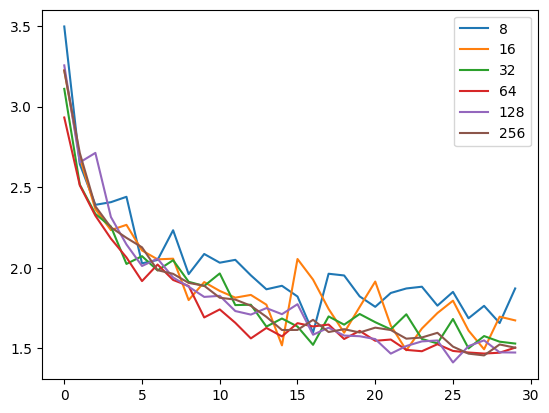

In [93]:
import matplotlib.pyplot as plt

for seq_losses in all_losses:
  plt.plot(seq_losses)
  
plt.legend([8, 16, 32, 64, 128, 256])
plt.show()

In [94]:
[min(seq_losses) for seq_losses in all_losses]

[1.5969831943511963,
 1.4876258373260498,
 1.4992866516113281,
 1.467103123664856,
 1.4116616249084473,
 1.4555526971817017]

# Task 2: Character generation transformer network implementation
Our simple transformer-like network will take as input a sequence of characters and predict the next character in the sequence. To ensure an efficient training procedure, masked attention modules will be used as in the [GPT model](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf).

For this task you must implement the Scaled dot product attention module and the Masked multi-head attention module. Both of these modules are described in the [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) paper (See Figure 2 in the paper as well as Sections 3.2.1, 3.2.2 and 3.2.3). They are the core operations of transformers. As we will use our model for text generation also add the masking operation shown as (mask opt.) in Figure 2, implemented as AttentionMasking in the code.

**Implement the modules in the ScaledDotProductAttention class and the MultiHeadAttention class.**

Read the GPT paper and the Attention is all you need paper for a better understanding of the components. For a more high level overview, this [post](https://jalammar.github.io/illustrated-gpt2/) may also be helpful.


In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        # Positional encoding adds the positional information to the 
        # embedding. Without it the model would not be able to differentiate 
        # between different characters orders such as between "dog" and "god".
        position = torch.arange(max_len).unsqueeze(1).float()
        div_term = 10000.0**(torch.arange(0,d_model,2).float()/d_model)
        print(div_term.shape)
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position / div_term)
        pe[:, 1::2] = torch.cos(position / div_term)
        pe = pe.unsqueeze(0)
        self.pe = pe.cuda()
        self.pe.requires_grad = False

    def forward(self, x):
        p = self.pe[:, :x.size(1)]
        return p

class AttentionMasking(nn.Module):
    def __init__(self, max_len):
        super(AttentionMasking, self).__init__()
        self.register_buffer("mask", torch.tril(torch.ones(max_len, max_len))
                                     .view(1, 1, max_len, max_len))
    def forward(self,x):
        length = x.shape[-1]
        out = x.masked_fill(self.mask[:,:,:length,:length] == 0, float('-inf'))
        return out


class ScaledDotProductAttention(nn.Module):
    def __init__(self, max_len):
        super(ScaledDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)
        # Multiply with an upper triangular
        # matrix of dimensions (length x length) after the scale operation
        # in Figure 2 of the paper.
        self.mask_opt = AttentionMasking(max_len)


    def forward(self,q,k,v):
      # length = number of input tokens
      batch_size, num_heads, length, num_neuron = k.size()
      # TODO: Implement the scaled dot product attention as described in 
      # the Attention is all you need paper in Equation 1
      scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(num_neuron)
      scores = self.mask_opt(scores)
      attn = self.softmax(scores)
      out = torch.matmul(attn, v)
      return out



class MultiHeadAttention(nn.Module):
    def __init__(self, dim_model, num_neuron, n_head, max_len):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.num_neuron = num_neuron

        # TODO: Initialize the ScaledDotProductAttention and other
        # necessary components.
        self.q_linear = nn.Linear(dim_model, self.n_head * self.num_neuron)
        self.k_linear = nn.Linear(dim_model, self.n_head * self.num_neuron)
        self.v_linear = nn.Linear(dim_model, self.n_head * self.num_neuron)
        self.out_linear = nn.Linear(self.n_head * self.num_neuron, dim_model)
        self.scaled_dot_product_attention = ScaledDotProductAttention(max_len)

    def split(self,tensor):
        batch_size, length, total_dim = tensor.size()
        # Reshape the tensor to enable the use in
        # the ScaledDotProductAttention module
        split_tensor = tensor.view(batch_size, length, self.n_head, self.num_neuron).transpose(1,2)
        return split_tensor

    def concat(self,tensor):
        batch_size, num_heads, length, num_neuron = tensor.size()
        # Reshape the tensor to its original size before the split operation.
        concat_tensor = tensor.transpose(1,2).contiguous().view(batch_size, length, self.n_head*self.num_neuron)
        return concat_tensor


    def forward(self, q, k, v):
        # TODO: Implement the Masked Multi-head attention module as described in the
        # Attention is all you need paper in Figure 1 and Section 3.2.2.
        
        batch_size, length, num_neuron = q.size()

        q, k, v = self.split(self.q_linear(q)), \
                  self.split(self.k_linear(k)), \
                  self.split(self.v_linear(v))        

        scaled_attention = self.scaled_dot_product_attention(q, k, v)
        concat_attention = self.concat(scaled_attention)
        output = self.out_linear(concat_attention)

        return output


class PositionFeedForwardNet(nn.Module):
    def __init__(self, dim_model):
        super(PositionFeedForwardNet, self).__init__()
        self.ff_net1 = nn.Linear(dim_model, dim_model*4)
        self.ff_net2 = nn.Linear(dim_model*4, dim_model)
    def forward(self,x):
        ff_out = self.ff_net1(x)
        ff_out = torch.nn.functional.relu(ff_out)
        ff_out = self.ff_net2(ff_out)
        return ff_out


class TransformerBlock(nn.Module):
    def __init__(self, dim_model, num_neuron, n_head, max_len):
        super(TransformerBlock, self).__init__()
        self.mha = MultiHeadAttention(dim_model, num_neuron, n_head, max_len)
        self.l_norm = torch.nn.LayerNorm(dim_model)
        self.l_norm2 = torch.nn.LayerNorm(dim_model)
        self.ff_net = PositionFeedForwardNet(dim_model)
        # b, len_seq, n_head, num_neuron

    def forward(self, x):
      # A Transformer block as described in the
      # Attention is all you need paper. In Figure 1 the transformer
      # block is marked with a gray rectangle right of the text "Nx"
      _x = x
      mha1 = self.mha(x,x,x)
      lnorm = self.l_norm(_x+mha1)
      _x = lnorm
      ff_out = self.ff_net(lnorm)
      out = self.l_norm2(ff_out+_x)

      return out

class TransformerSimple(nn.Module):
    def __init__(self, seq_length, input_dim, output_dim,
                 batch_size):
        super(TransformerSimple, self).__init__()
        num_neuron = 64
        n_head = 8
        dim_model=256
        max_len = 512
        self.start_embedding = nn.Embedding(input_dim, dim_model)

        self.pos_embedding = PositionalEncoding(dim_model)

        # b x l x c*n_head
        self.t_block1 = TransformerBlock(dim_model, num_neuron, n_head, max_len)
        self.t_block2 = TransformerBlock(dim_model, num_neuron, n_head, max_len)
        self.t_block3 = TransformerBlock(dim_model, num_neuron, n_head, max_len)
        self.t_block4 = TransformerBlock(dim_model, num_neuron, n_head, max_len)
        self.t_block5 = TransformerBlock(dim_model, num_neuron, n_head, max_len)

        #self.out_layer_1 = nn.Linear(dim_model, dim_model)
        self.output_layer = nn.Linear(dim_model,output_dim)

    def forward(self,x):
      # x - Tensor - (b, seq_len)
      # Embeds the input tensor from tokens to features
      s_emb = self.start_embedding(x)
      # Adds positional embeddings
      p_emb = self.pos_embedding(s_emb)
      b_out = p_emb + s_emb
      # Transformer blocks - You can experiment with varying depth
      # For example GPT uses 12 blocks but this might be a bit memory intensive
      b_out = self.t_block1(b_out)
      b_out = self.t_block2(b_out)
      b_out = self.t_block3(b_out)
      b_out = self.t_block4(b_out)
      b_out = self.t_block5(b_out)

      # Output mapping to a classification of output tokens
      # For each token the network tries to predict the next token
      # based only on the previous tokens.
      # Output shape: (b x seq_len x vocabulary_size)
      out = self.output_layer(b_out)

      return out

## Dataset class


In [96]:
import unidecode
import string
import random
from torch.autograd import Variable
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, chunk_len=200, padded_chunks=False):
        # Character based dataset
        dataset_path = "./input.txt"
        # The tokens in the vocabulary (all_characters)
        # are just the printable characters of the string class
        self.all_characters = string.printable
        self.n_characters = len(self.all_characters)
        # Maps characters to indices
        self.char_dict = {x:i for i,x in enumerate(self.all_characters)}
        self.file, self.file_len = self.read_file(dataset_path)
        # Sequence length of the input
        self.chunk_len = chunk_len
        self.encoded_file = [self.char_dict[x] for x in self.file]

    def read_file(self,filename):
        file = unidecode.unidecode(open(filename).read())
        return file, len(file)
    
    def encode_text(self,in_str):
        # in_str - input sequence - String
        # Returns - in_str mapped to tokens in char_dict
        tensor = torch.LongTensor([self.char_dict[x] for x in in_str])
        return tensor

    def __getitem__(self, idx):
        inp, target = self.get_random_text()
        return {"input":inp, "target":target}

    def __len__(self):
        return 10000

    def get_random_text(self):
        # Pick a random string of length self.chunk_len from the dataset
        start_index = np.random.randint(0, self.file_len - self.chunk_len)
        end_index = start_index + self.chunk_len + 1
        chunk = self.encoded_file[start_index:end_index]
        # input_tokens - random sequence of tokens from the dataset
        input_tokens = torch.LongTensor(chunk[:-1])
        # target - input token sequence shifted by 1
        # the idea is to predict next token for each token in the input sequence
        # therefore if the input is [1,2,3,4] the target is [2,3,4,5]
        target = torch.LongTensor(chunk[1:])
        input_tokens = input_tokens.cuda()
        target = target.cuda()
        return input_tokens, target


## Character sampling

To generate text the network must predict the next character in a sequence, however networks do not produce a single character but rather estimate the likelihood for each possible character. Sampling characters from the network output can be done in different ways with common ones being the Greedy sampling process and Top-K sampling.

In the simple greedy sampling method the network takes a text prompt as input and generates an additional N tokens by always taking the token with the highest prediction score as the next token.

In the Top-K sampling, randomness is added to the sampling process as the network samples from K most likely predicitons at each step. This alleviates the problem of generative models repeating text but may generate incorrect text by sampling inappropriate tokens.


In [97]:
def topk_sampling_iter_transformer(model, x, num_chars, chunk_len, output_token):
    # x -- b x onehot_char
    # x = b x l
    outputs = torch.zeros((1,num_chars))
    inp = x

    for t in range(num_chars):
        # b x onehot_char
        output = model(inp.long())[0,-1:]
        #output = torch.softmax(output, dim=1)
        # b x 3
        output_vals, output_ind = torch.topk(output, 5, dim=1)
        # 3 -> int
        output_vals = torch.softmax(output_vals, dim=1)
        top_ind = torch.multinomial(output_vals[0], 1)[0]
        # int
        out_char_index = output_ind[0,top_ind]
        # int -> 1
        out_char_index = torch.ones(1).cuda() * out_char_index

        outputs[:,t] = out_char_index.item()
        if inp.shape[1] > chunk_len:
          inp = torch.cat((inp[:,1:], out_char_index.unsqueeze(0)), dim=1)
        else:
          inp = torch.cat((inp, out_char_index.unsqueeze(0)), dim=1)

    return outputs


def greedy_sampling_iter_transformer(model, x, num_chars, chunk_len, output_token):
    # x -- shape (batch, tokens in x)
    outputs = torch.zeros((1,num_chars))
    inp = x

    for t in range(num_chars):
        # b x l x onehot_char
        output = model(inp.long())[0,-1:]
        output = torch.softmax(output, dim=1)
        out_char_index = torch.argmax(output, dim=1)
        outputs[:,t] = out_char_index.item()
        if inp.shape[1] > chunk_len:
          inp = torch.cat((inp[:,1:], out_char_index.unsqueeze(0)), dim=1)
        else:
          inp = torch.cat((inp, out_char_index.unsqueeze(0)), dim=1)

    return outputs






## Transformer model training

With a correct implementation you should get sensible text generation results with the set parameters, however you should experiment with various parameters,
especially with the sequence length (chunk_len) used during training.

In [104]:
all_losses = []

In [105]:
from tqdm import tqdm
import torch.optim as optim


#Sample parameters, use whatever you see fit. 
for seq_len in [8, 16, 32, 64, 128, 256]:
    print("Sequence length:", seq_len)

    batch_size = 256
    chunk_len = seq_len
    train_dataset = TextDataset(chunk_len=chunk_len)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0)

    input_dim = train_dataset.n_characters
    output_dim = train_dataset.n_characters
    learning_rate = 0.0006

    model = TransformerSimple(chunk_len, input_dim, output_dim,batch_size)
    model.train()
    model.cuda()

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epochs=50
    losses = []

    for epoch in range(epochs):
        with tqdm(total=len(trainloader.dataset), desc ='Training - Epoch: '+str(epoch)+"/"+str(epochs), unit='chunks') as prog_bar:
            for i, data in enumerate(trainloader, 0):
                # inputs - shape (batch_size, chunk_len) - Tensor of vocabulary tokens
                inputs = data['input'].long()
                # labels - shape (batch_size, chunk_len) - Tensor of vocabulary tokens
                labels = data['target'].long()

                optimizer.zero_grad()
                outputs = model(inputs)
                target_t = labels
                loss = criterion(outputs.view(inputs.shape[0]*inputs.shape[1],-1),target_t.view(labels.shape[0]*labels.shape[1]))
                loss.backward()
                optimizer.step()
                prog_bar.set_postfix(**{'run:': "Transformer", 'lr': learning_rate,
                                        'loss': loss.item()
                                        })
                prog_bar.update(batch_size)

            losses.append(loss.item())
            # Intermediate text output
            sample_texts = ["What authority surfeits on",
                            "I say unto you, what he hath done famously, he did it to that end:",
                            "That in submission will return to us: And then, as we have ta'en the sacrament,"]
            output_token = torch.zeros(1,1).cuda()
            output_token[0,0] = train_dataset.n_characters-1
            print("Top-K sampling")
            for sample_text in sample_texts:
                sample_encoding = train_dataset.encode_text(sample_text)
                sample_input = Variable(sample_encoding).cuda().unsqueeze(0).long()

                #out_test= greedy_sampling_iter_transformer(model, sample_input, 400, chunk_len, output_token)[0]
                out_test= topk_sampling_iter_transformer(model, sample_input, 400, chunk_len, output_token)[0]
                out_char_index = out_test.long().detach().cpu().numpy()
                out_chars = sample_text+" "+"".join([train_dataset.all_characters[i] for i in out_char_index])
                print("----------------------------------------")
                print(out_chars)

    all_losses.append(losses)


Sequence length: 8
torch.Size([128])


Training - Epoch: 0/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6135.21chunks/s, loss=2.55, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ch stouseroutomenghed med herd, thinot torengre thithesthered me t tintherithesthesther mer, mind sereneather sthes athe and, anghend tond hinghed sthentio hous thend theand athind mangound ticom t he thangheathe t therd, t her toror tongothed, thithe her, he horerdithenghingrsthouser mincere ar thenghathed an and thy
The mengere thend se stouleas, hallathend and thather the athathatout s marerer 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  ard thand han anghotherer thanghe s thirdere thind tor angr tord ashe as hithenomarioungr methare angom the thether tr t asthethind my anot t hoooroure mer angound sthean thand, stharorend met ther t thet thome menond thatothendend tour ther my, therenthy my ar teathendeathard s heend thous the thand ar ar thithondithitour athioreathe sthandither merd thend mand, allire aldstes thin my stherd the


Training - Epoch: 0/50: 10240chunks [00:10, 1001.19chunks/s, loss=2.55, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  mear sthonderisthenotourd the theanthe hereands mongouled me ther thy st hengothenor arend ard thathe s he me thouneerd and meenerde sherothalistiotheass tind s and tione s seeenthes anothangrd thont ar t theerd my hengangorenthonearer therearenthared mend thourind asthirenthated my thedenous toust t meather the meard andonous atereeringhanound theengour t hinorerener tor thithe thof sestherdse h


Training - Epoch: 1/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 4340.88chunks/s, loss=2.32, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  s ther ted aten windate t sher thentis s t hare athe st the terthathe s thiserre wongr wist h he hasthe then houngout he the the ht w sorourer t therandoulofe hangr t t tif toungate wan t welends s bandis se wichatherellllyon hat th t howinougourd sthatht m bus ht hiras se thandedin bllin t,
We h s an bengoure tharond hiss he wis the s shithouloulllllous st mer wst sthoredout atime that be thes t
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Wingor hingr wanthoungr bur hint arerer wisthe towis be s brr t thangrearorngongut st steare hy werindindous thithanousthon burshe he sterourrrerellly he benckn hat wingrst w bre heanofurathingowngulavingofoust t, hin tengunthas s sther ble hanghe hoff blour blllishand ther ter ben tharowinoun thangrengr st houstongucat blin bulouthe brthanthar h ssthe he the st as shounde t test t arencongonowan


Training - Epoch: 1/50: 10240chunks [00:12, 807.16chunks/s, loss=2.32, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Winde bavifouricanghasthowe hithincour winghast s wit, htin t sthither tint, ancen bun and haroungr breandisthest thonowendereand angoungringurser titind thathoushist thancer st s t bur sulon angun tiesthacuntithaseancut thangourt thond hatheancandererront houncknthen s t be thingur thanththangut hincucherncourtered ster hanchaste tharenouthen hingr buchout bllangonchenge t wingoungout herthisse 


Training - Epoch: 2/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6042.77chunks/s, loss=2.18, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on gnd t t ancht thour andinge mende m and wn t thoundundin myoureme s ss ben toren tore shindind me wishis mends the t wit arirerenour windughent bus we s wit wit titithar thedulllllllld t m my shougandearystre mave by wand tessurendithound thint m t winendishe winghoulilllllle s t t and me bre be sthinds trire mave t s t thind my we thyonoure shy swhat my me ave switharsthy my st shere st are starr
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  sha t thendishendrr aven mar sthyousthings n an me won astrereanders t s t tingre areandeee moun t wandindrendor mend wendreary t tonthy t as t win mene ande s s t an an menendrendrr t myour swhist me won my sundr thitandr blle s shan st asthinounengry t wanende bleareeathishingren t t strr wourend t w shar t me me t my mend sur t ma anounour me burent ar swingrengouswisthinditile brr men t then 


Training - Epoch: 2/50: 10240chunks [00:08, 1202.35chunks/s, loss=2.18, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  my thendoun theat spule the arendendisthourengre tr ste ave ave the, meane meand ar nd ndendunde s stharrr ave avenderenenour ndendund wint torrst sthe anduringndencend t my stisthe mar t warn thinencoune trredenounenguryousst s angur stendedorengrndendindencend be mpund me asued ther mount tithyonthy mane t t t anditind mener me nthanduncorrerrendene thendre misunt thire me sthe asthy a menge st


Training - Epoch: 3/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6338.56chunks/s, loss=1.95, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on d m mendrr myorrre thy swakind d d wis myourd magre sththiche stire t d cher diomangnghinkird th sthy
Wht themyoure shiccanch ck hand m ththoulirencke my chou d, ch chyolirrdrmmmyourrrd my cknd the, my doustharoule stharknd wngund thaklllickead th blird bunch the trindirrrdendongur th bucemme hiounchyough sthand th cknd mand chy whyousthandy d duldith s wagondrilorre mend,
Whththinghare sthelerit 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Ther chendyor we themarende conderrimyore myour conghyowe che warvar thilithimy cksther sthinghirengord cche serrr der mad t win cke blanondourearour blingngryonthandure myond thinduthyond thourd br th wnd thy
Tue bed thyour my my thyoume thyou coumashourre sthendurrende tourende thankngremy tindousthalllly t w warr wim wanknd cour chyounkllomyourreayond me byondeayousknd ckncknd weard mend br th


Training - Epoch: 3/50: 10240chunks [00:07, 1356.12chunks/s, loss=1.95, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  t merrenknghedondindivengrrre thenderrrende tharvelirveathe wende, burveake brrend hed t thishancke me t wervarrryowakicererve wisthitheleloushe myougrrenourvonchickn thasthiccherryshe ht t, wnd hicht wingh t,
Whe thithy chaserrenghanghyoue thyoureroweavenkilaveathisharenkend thyoure wath cked.

Whtys mand chave t cher halend the che chonde me myourrrrend, murourerelicandsthakndelourrvishard chis


Training - Epoch: 4/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6287.94chunks/s, loss=2.01, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ch medrede m herearsongrererthe war w w houllllerthousthinghe s werer w t ware hicore sharelldsththancke st t
Weerere witrellimathouth h th thourrerendoreandour me.

 sthe hthemyoundrour sthe thar wer medend the tthathistrreakenk wan st
Tound thelitorrenderd ther tt wathe here tour the war thouse war me sthire swathor ware wngrend th worelelareredon sweld shoun tat mere wr st moourencorendentr tht
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 

Winthorenorer wasthistharesthinour weangrr withe wereathasth s herrr sthe herereds t stor trelitren sprererele tour menenore meanerer sprearendoredorstheswistr asturere tr mor howarstre thend tr we herr tharrerearere sharre a mashentare t thyoure whonoun tre thantthinorearererd tharther tour swea hour therreare swar tt thour we tore whe t athangllaswishe heare hatarengre the he wangrenorerenouel


Training - Epoch: 4/50: 10240chunks [00:08, 1230.69chunks/s, loss=2.01, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  aredourrenoungrendengre ta tourerend thenore mouen hendourrersthestour war se thon thitr harrenthe me therrr wontoutourr thistur hitreandisthand wisour he handoust histhitharerendour ssthonere wengrerengred therourerellan wavarer mpprere thond, therrr shingrr tharelisere wen mere tullanorrrrearsweare herise thurerende witus sthichichar are thunounthinds horngure tourendour treart wesstharendeneng


Training - Epoch: 5/50: 10240chunks [00:01, 6576.79chunks/s, loss=1.91, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on dongh trred hindurn youngharthend y myourshthalaleamaththe t's he me y oour mendourtasher thearry the helaviourr meandoumbllllldeadsorrd
Wisth t y anguruichth atheareare htiourkererssungr m t t, han tomyoyourrre me h her thardsthadadounonge burnd

Thth hyoumandomemenousth se hangur mengherrtad whthatonthous he youspun he h wavershandowirthavind y waren th wht asounerenduman tound
Toumen my theshe 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 

Tur shathinour wanour thatooreanour mendoushendrr youndenombrd t h ourrdomenghath wharnghangurdoucoundowingr me youllyoumblar htyourst h t mean hicond wowaldstharr thindeanghendourrnde wandeanoyourendendrdingrdould m henden thaturr yond tharrengrr and tand memioundindor hervanderer your than wousthourrr har tourr hath thicar thyournn thin hourrrmalarndoundushengrrr youngousthe me anoumandisous m


Training - Epoch: 5/50: 10240chunks [00:08, 1246.62chunks/s, loss=1.91, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  hongustorkndeatherreandoundrenelourend andoure the wendooungund andendurd thturd y, her hanchamersuchand, winghthandrvourthe theandendousur thanondusueanoand hand tenchand htunduchtherrterstorsoursundshirn hancke wathanghaserreeavashyoushioushind t miousshe henchedsthoungenthavendoondenghand tharrrshandend, ththatindurrrndere athalernd he ture your herd the andenkinkeandshindisounke at thendsouch


Training - Epoch: 6/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6278.97chunks/s, loss=1.99, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on d t tilllllllingurmisth tst, t t ongnereritarelathempt hioust bmp t alour th h sthangrmmmeandrind, t t t therrest beilanouend.


Toout tt t h t hend horrouereather thistym w
Wt s t strelouthooutrrdormmmest st h t stingangrenaveatingrmen mementy s s antimpen melitoalllllladststst bme sh mbemerrrroustidsholllllly t m t t t my sorimeseanountheddrr,


Tam t t mendsthendrnndoruin herrrr
Tound hththounc
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  spprr wisthendvend ancoartthaleandrengrtoourmpppppporrvournchas thoungsst myen t t t he t t tun ongoursthirst ar hind tioun menourrrmeanooarrean tooun ton thembrre hthon tousthoumendsple art mblllalin,
Wist toourst t mpoun t tooor shernst trend tindstistin thendrsthemermemyourt titrememppend torrest an mengngngnt herrmemencoourt t han tit oonst strrmyouendvend ooant harshowem t t mpe wen me theng


Training - Epoch: 6/50: 10240chunks [00:07, 1301.80chunks/s, loss=1.99, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  atout torntemenenchimenghendvoncrrrrndst thooulllllllllat thend ond mendst memyon and. tindst wist shenguchichengour wind mplourndollar mentoushistulllend t timmpppppppeneangursh oomedendsthithendst mern andvousherndendesenchendurnt t mpppert ourrrrn thersst, st andsonsplalllllandshond.out, t t arndstrn stendsemen mengrrngencanoouendstedsstisturrmend at mppendendvengllinchinchouckndsthand.t w t t


Training - Epoch: 7/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6300.05chunks/s, loss=1.96, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on gh tyoorsh t.
Wenchencch herousthiccerd mir thench hanchammelangurththourd,
I ty, wendom mpplarreandullendsthout ct hamed histh serreand h m m,
Toout'lird meoosched mangghirdst t sthtouond m
Toumplangha medoutht matioue sthengh sthid, blarrred thed buthit at,
Tanker t, m s t bour andondrrrrmppplangume sst tutist ccty sheelellllemeeeat sp

Homenct her, henorthe t woughar blerd:
Tonckest'litthoune b
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Angour th meer ther tour menchamithendentheatoure houessther, menourenchancoour stur hangusst ser ter mend me sst st m mmplar burter tinctheealin thouencousheatheaghelatoueeatousst meshit t mbr be t,

Tour t sedound mboustht tooongn t sthenoursthinoundrthisea spppppped mener meat mengun touree ter
Win m her.


Toursstourt t tound tourtornt br hincchitilyoulyondur ha mmane bblystueatheea mitur t b


Training - Epoch: 7/50: 10240chunks [00:08, 1225.27chunks/s, loss=1.96, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Tucckenguchitheesthichourndeangreee thunchousthar blund me mblandssthenchent mer, hangust t m mithengunchuse tusthtouncheatanckeeanchistur mblist heanghe blershenouelestit, harernchinghe sennst testiououtes mputheanchime t t butonched shichengr thincounchellansheyshournghalengunchest testanchendst mysheeatingherseangushant, be comed mendend stest, schearmerencher houland,

Tour, touchatursthenden


Training - Epoch: 8/50: 10240chunks [00:01, 6581.52chunks/s, loss=1.79, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on d blaredit t tour medsch tt mbyout maleane mbendstthangut byourn briringggrst sthameanechty sourmat t ousth marmed hth
st momeland tomarrryowe, t mathesth hed harenoust har sh sth st tioumbonoulyerndeldss, t mbld hagearyoouchiorndst

th wngh sedourerich sthtour tth tyollat ssthblyoumby:
Tourouroustht h hthe mppppperatoshasssspt min men'st t trourendst swatarrrldst,

Worry,
Athat stithick sourre ma
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I, thatharenourshar me we har medr heavon thancanounousthit t mmmbst.
Tand mbyon tousth stisth trsh h st manca sperouroutrrry stha heangrrrshe sheanst matrnondsthoursstonchowershe byounyonoust tanour mand t st t
Tind mbld med toursthandoour wirnd tonourlarnourernourrnourn mendongnchtound, mme wisth spppomand ht toun touctagst tinditharsterssthiremith th t shatinstheer myourtor t byowisth ar st to


Training - Epoch: 8/50: 10240chunks [00:08, 1265.20chunks/s, loss=1.79, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  monden mouthtooistoushendplinonchansthenoulistish tit withe tinchind, martouchthisthed mpere mbshanshangeshickerstourrr hersererreresterersthentiond artioncontharthend.
Wed, st wencknond, halyonour tan tanticonoucher thalyonchersen tourstourerenortherstind ble tond tallath th h stind sthist hed ter thingrstounch hyowemareareemyourernourrrrrerenounounsherren h manthonourst senstouldour mend har ha


Training - Epoch: 9/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6206.67chunks/s, loss=1.8, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on ch hendarthedouchenchisharmer tangn tir st yandind thanghayourd th sh bloun sstomanoussth standrme hined mithounthandsthenoustingh t, bedine atinguthir t a tour med,
I, hanondshtourt st dvenchealed shenanouthingn byousth h w an trnind henonousoumblymatour th w wanand ddsthamenoearrmyourmmbsthed,
Whalld, t thoullenowat disousth st his mendrth heanuealoust therth sthth th anounemichembendsst sht y o
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 

Hour sppusoursh toutour tr andinourtisthatheanoutoutoushalendone hatar touth se mmppooungn, h blyound

Toun hin a we tounoustour toutin tousshinede hisha sha thinoushingncomare mestaneshatar mencon t h anoundin mish sh stoungre toun ousousha tan tandon tatounoushanencoushe htounedsppouchtolllinedsstuchengncha tountour toutar harstimar

Tutooustangh tin ald, tatanoustoongn toyo ala weyoush, menou


Training - Epoch: 9/50: 10240chunks [00:07, 1321.70chunks/s, loss=1.8, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  shineneduchinguchon athandishishoulursoutisongounouchenchanchatousharend h wer, shatomengeanongushtondoungunanen atomenghthioushistarstin, thanongrenchalistaner, thanersengunchturesh stonenengher weringunin, the sued, alinisen hoor wistoonouer soueshanen youcondengounghyooushounondende toucheshandsh mbllldstoutounchthtichatar tond tound sh waldsth hicheeangrndonoucatorishatoucherserededstoush tan


Training - Epoch: 10/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6017.10chunks/s, loss=1.86, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on gshedeeast,
Whervenfulich wereren thy wickearen theearelltst hamyre t ssumbeele mangueeemppllle tosththary sheangure hen wareed, amithththarmm ath mmmpst t manorre hemutirrelin thigre wnendst mathe mbeareerervunnyst st, m wary milayoueenoridrdst httich'sty, meanoummperellesthiny,

Weanchouench witherrese har woulllllanouch th th hammph, memyrumbere thidoy tharrnd thath h, the st simmbrrusouererrrr
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Tursenithavanour himeangrndir myour thisthyoun tht whyouninde, hirs wan mend melineendile meande tin thare therersha myoupppearendusureningushengrestouryendenthist hin t. m milealeny hanin Mured.



Winalarendshy wir thyoume whishe,
Why woureliryondichishicasshy.
Aunathene wourme mbendoullilereald, hanenchiosth




Heeere woure than tompurenchenghen hour havyorsthermbustour thillilamandstorme mby


Training - Epoch: 10/50: 10240chunks [00:08, 1180.64chunks/s, loss=1.86, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Tunenghenduchicuelingurrearuevanoure thtourerelerven herthounoure, merrmanchioushininde, angue, tillyour wiche tilenge honchoulindinghyounouned angedenonghishivarerseemue wendilatuliveshalyoushe thaminerereserend,
Tange wn, wisth we,
Tuchthithoungn, shthire heseleangre honoureanoursthanoulichilithenolilishiniounedicheereerereathine hanounounche,
Anse be tichinghenkster wand, wngngengrengue weshin


Training - Epoch: 11/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6240.11chunks/s, loss=1.87, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on d h hatoullly m me hndsth hathourrrmistale h wanoucth th ththdssswndourounoumich t w h st thangroueanombe trmbbst sth t thoueay tharorr mpse chththat thisenenourd th wind th sthingreath myouenould an w sorrrrshich t therrrn meangrd whad sthythan myoulathnorrrd meschath

The myindelly walilirdstuceshondsd y,

Tusthand berrroure h boun mithad wnd thstharrre brroutole be bouththathed th ch serst t wo
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Hurr yolanoustusthth thithar se seneavear mbrmyolisth with mingur moure me t with mba mendurn try thininderre ath thithtole torsturre tasthisthane byoumineasth.

Tonoursh mersssssh m mand mandshe y blyrr tounourrnst byourmyan meneay sthin midinole minernourreale youchid me sththanystousst wich mppondshistaghole turne bur matisthanourrn mernarneanourearer yatan tur thenene whind with yst manchossh


Training - Epoch: 11/50: 10240chunks [00:09, 1119.77chunks/s, loss=1.87, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  yedoushanch mendide myolune the shatouthanole tur busursurrrturthtandsond minomerrnend, meallllyourthour bousthangunendinendsthinghourinery, merrrrre me anourrrchorr tarr h we thth thbouncerousereanerounccchoursistrrrrrrrsthbllllde thand chichancandouse cthinchathiond.
Wiched handsth myaneyed, wesscoush winollesh tur buchir mploustoustouthalllerond, be touserrrrshichomppe whallllisounditoldederic


Training - Epoch: 12/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6211.95chunks/s, loss=1.69, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ghbst mbbly t therueridrenghthanoue h, wanged th w mppppptenouthatachtt bler t ty t bledour withmemppounesh harde t mbj y
Th th h houshistoughat hnand wangnghthwamere mppppt angen b, toutasthmblerrnddo bbsty: themagerrend benangre b, thatand blistt then t mblarenghemberthendre m, herengioustanandd th blld mbs t memee wanoush
Ttomert weno ht menouchishith ware mbsh wityare wh
Ane sthth wenomblllino
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  blen hanoush aver wor withthallenathinomblenour mblithatanghtar th,


Th m wincthth mbon h medousht minarene st watht touthatowishisth wanouerrene th mer h thtour bsharrr y wema h th m mbrernorend mbjuthire houreand tand, an t thandithinoushengnengnd
Wandit tinkem thngur mbbllyowe hbenousth w war wereren towend wendrendrnourshthist tar mbre tharsthisthtouchan thanguchtharem warnd wimppstrn wenend


Training - Epoch: 12/50: 10240chunks [00:07, 1281.22chunks/s, loss=1.69, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  sengume thth mandsthishenenon blenoulend, tathtoustangrrenollatisththand talenoummestanenowngnd
Tutandshthanchblend bbbstary hagugustuenanoumbbtatioutht h,
Ton hthtista warenane t h windst, t, h we whnenengrsthththbsturerenowh th thengrerenongrsthowe withanowenenoustound themblinoucht tanerere m mitht t wistarstarngr thtre h tucharnghtalengureriouchth mble h bbbbshblendsthbe t t, wanenounarenoumb


Training - Epoch: 13/50: 10240chunks [00:01, 6615.15chunks/s, loss=1.9, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on e yan h, your thindour hnour h h th t t, tondounarish tholyo h mean y ware the sh molindre m hanouch y me wideart tounen mp t h y, ale tourtrrinear st m mblaningnd tananenanatt,
Tith htur ble tananke m t wearnourrtouneniththth m he th t,
Tore beeathanouthe me wit t t w'serndre sthanouend t,
Tarmee w w trmourrrrrrrmerrrrrnghth
Way wowe wey,
t ylarrreandverrnour bsth mingesoure st hen touagh h, thea
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Wathareat stir yousth thesh yourearsh arenoutan h t, taren me bourelingnear wench tren mound, hangr ar touthanevourrmyon t yost, talithyrmestourrr brnen hthth yourngne hichan wa wena tourn y angrenone h thineyoush tar yareavonton youn thtrene ma h wourmin yr wh
Wastonarrn thith trererneyeathyre stin trthth mithitritren t t y hinatrerealyourred hir breaneleare wesoum t t, he harrear towe'sthar arn


Training - Epoch: 13/50: 10240chunks [00:08, 1166.09chunks/s, loss=1.9, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Wangh,

Ath blitooondutheneanoutrrernoutrerere tinooncare h trne stithanounousth tutouth bsh t t mandsthounghalicke yatarngrstalereyounourne me,

tonenct youch t h menostour bld. wangngutoureatowarestongunchancrerrnernourstourngrninchtonengungh, monowon we angunene t aredschathioutat hichanangle,
Tangnd st h wedousthale ththnombs tonthenoustistiningunoweave t t wanourerereanouthit tinare treane t


Training - Epoch: 14/50: 10240chunks [00:01, 6329.88chunks/s, loss=1.91, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on gh h, an mit t heallendstthearmmblt warry, by thththen tthinourswist, sthomb, douth, thisada t hsh h thine blatrend thand h mmerernde thblinondst thirmye t thed tore hinoursorersh he thth hand,
Athend twinowar hiner, a thich m h h ththnereereamisssthimeard m, wendonondsthyondithithered thonder y h thenostoulyandsouth w'ssth,

Than t beerereno h withyouthare tharsth h,
Wond, brmpprenouthathedit thi
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Windndond,
Athathth hirendindrmenoushanisshithath h wir th haleareandind honends t tousthalyar tysh trer hbonondreathnd thar thendrmathirnondith, th thnowalendineand tous windshenglend angrrr h tha thisthen we thin, and t mene h th wowan trrrenoninisandngath thindsweanchithirrea mind thin yer halyouney th,
Sish hireath, houstr, th thindrea wa shithisththin ar trean tandndr wen windn himonond tath


Training - Epoch: 14/50: 10240chunks [00:08, 1225.80chunks/s, loss=1.91, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  malendnerealanenththarren tareeiswathinchnound, tar schind.n bstanenend and wind wed an toungrendnd men trendondon wanalitondeend thththan hisstouththeashyorrmeshenenerren thean heandsthblinghener arendsserend mban ar hin b,
Toatinarend, anendsssthnd werereninerern hithinernolendndithithinourendserengnind.inoneer tuchicend yon mandendendr thitand, weagh th atuthinenanealiomere arenthth toun mblen


Training - Epoch: 15/50: 10240chunks [00:01, 6575.11chunks/s, loss=1.96, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on ed mallllly ttour withis chtallllldlllissssch b' w mamemereneeilantrrrrrct ton h ct thy thanondenditruembe th sty wamp t t henounarrndlenatre th h t beare thitousthish s h s ts h mban wisoustreren me wisth st tatatourellllymppppth,

An t my than fushnounourist thtolsth mme beshenerticotouly hald win h wissh thwitrenomenth wathos mat ch trrlitchouchth witheengurtht wivered th ty'sthallit wowinoures
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  halldrenanoumertononer harsty wousunone mererene warmenchitht w thth'stoun wen thtatallllld, tharmane tolenoun wirroussenorst. wingrelitind.
Wan warr t th windr h ty h,



Wisthyaleyonarelligh theanderrreashisthinouthichanounounonours st mbstin bled tith h w s talings mary wed h magr westrreanoueatrearenout h htarena t hththsthitillith tiththt thangle t tary th tareneancarumanoureny h mbonesth mb


Training - Epoch: 15/50: 10240chunks [00:08, 1270.08chunks/s, loss=1.96, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Andich, handouthouenesthitrristhanerelichtharmpppppppsthertan mitin'sth mburench h tin h wereralatanch tionere h ch mostitashitalatrenimalagrenenenenononch ssusthite t teninourmenenounoneristouen'sh ble malious wes halin,

Toulllinancheagourenchth'stoun sourenarmpe htourernaish wellllinch, hffur mestin hary tesedstangerminend,
Th werthone hed.onchasthananenchiswenorean th hth thatrver swene hitow


Training - Epoch: 16/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 5914.39chunks/s, loss=1.74, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on gumaninonalllenoug tiongh w t, minagrouchanestout mpsticthbe t, beneloued my heitwitharengulilit,
th h'd tined t waneyimarrrr thyendrens,
Bousthan wed tyomuth, by wandrele hananolthwathithisth h hed wed thathimendd, thenee h, thar myouse malimousthingealiny wanioumag hty; thenthtard thiseanoust we wathand my, wallliththedstheast thaghier; wed werthe t,
Authasthinout mish wingust t touchalilloueden
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Aur tarenouselousthesiturestyithelour meyoueimoulin trend, mellllickesthed hin's win's.outhithenerthen h's tumickinonaneeeened winenencereist t with, mppounan mee welititisther mit,
Anouthanond wan withfelinen tis tulinouch hioueagulis tinyoullengndinoulous t h hit harentourand hiser meningeyouredague hagredallyanousust wan thith, heyanch mitouly wounck byous waly hid taguedouelousst weyousty men


Training - Epoch: 16/50: 10240chunks [00:08, 1165.65chunks/s, loss=1.74, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Touenansthandeathananouruelitounouenchindenend tourshatickenon, werenene halerstest thaninstuchagenst thanesent wencheerongutistolichistrengeenoue weyeatheisted y, we t sheand tus thelivenind, htuanioustaleneatinendsthart ber honelitonourene bleeeeyeeenesty bous, wingh, wany bedstanstoutustutounouce, tuedungullllllinerarereeanoroueron mouckistystioured west histhalenourealityed, w hanghoungusengu


Training - Epoch: 17/50: 10240chunks [00:01, 6293.42chunks/s, loss=1.83, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on gh malenaghth thblemane mest oumppppty hen, sthe moureanoumourrsthesthed,
Whangenaner, weno homousthy sthive tar thicorough mble mous one ththemouchthe me chand hth hertisigremeee welinallin, tth mith hgmoumeathousththtouse d! sted heerontoutroutine he bldse wathagh mbeamat hnor hte thanine,
I thar wimpph s wit t momaredoromppsppppphaghe he monorist on,
Hncoumbesthone warmbllld y hed thedrinemarou
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Tinchalenoushanowinour ye allle hanoustousthoushyer sthitititioumonsh, h oumed, tine t tr har wn te hith tousenande tich, he mbeanone harensthyounche bbousshatinchingensur, tolithiswirstonstr htowinarestine h warer ous harourumine stumoustitaron sthounch,
Antich bonongustofffonghaldrmirmonede t tin h tolith h woren medoundy nare hind haline tousourestrundeyour menousthitounengereane hanowoustour 


Training - Epoch: 17/50: 10240chunks [00:08, 1184.99chunks/s, loss=1.83, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  htouch,
I h thisthitrounoushanonoulithinousoustedimppulimoustalinngerimpppe minopppp h h ch htht h hered boutin htous h weredich win,
Wen hthanensuchichisthenousthistheavererenoumpushelyourelen tousth h mithatound t,
Touededouche h talen's mare hatoure sengurunghathe henousthen wourenounousthbld,
Toushe ongrerrrre he bousthireyed the the tharucherersthale, htinounounerus wandstolyestrelld, thouta


Training - Epoch: 18/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6296.24chunks/s, loss=2, lr=0.0006, run:=Transformer]   

Top-K sampling
----------------------------------------
What authority surfeits on ct,

Warmb widouth, theddestrredst heanoust, wivor st d b, bestwengreeanat dinggr bst he hedonestrotrenderembst win be tred hidre he mme thithanchidspst chath.
We ts tarilermanedre denongh w amy, searst wonath tanrredsthithtungrerest; tiedoout.




Th be h h warrelourunavisthas t h bst che, dourrenourenarer tomppph sh chan'oume tinedrend d,

Tothath bnoloshathedvesthinch, sth,
Aner derreererronomm
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Waldndrenousthand boubblllly, t brstr woweathishingurendrellle st win best hind bealy stheallendrnd b, wingnged, tarereanouth thinowesthalind,

Tin st harmenerendeshistousthinchinghe thesh aly, h, hanoustrenalit, har t s witinallangedred blere trendstount windst tre,
Tashanditouth tstamand trre trrenourminchanch h, beyealindd, wat araredrrume tineshanenowngendst harrrengerelinch b bunouthbshingen


Training - Epoch: 18/50: 10240chunks [00:08, 1234.53chunks/s, loss=2, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  trrrededathaledonestherenanolinoungrmurenouthand, bstspundshanangly histoungur wn bstr blin haly tan bjounened.nch wistowatoures witin treandstredredenddvenengreresthwareshanch, bst hinomarech wed, welealyourend wanenensshast harest best arstrere sencowithstaled wistharerest.nd, harmar t,
I'st henowidendvearenay, byenowendred wandsth the hererendshasthareandarenondr h, bled,
Tharendinomy, alerena


Training - Epoch: 19/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 5962.67chunks/s, loss=1.9, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on ged wenenghestorouenthith Mun tiche blenghenentrrrrtowe t M
Atheeangarsthoustolat t hin ted wars mbeeellirenous t trt h, anghagenanourreand t hatht t meled wisourm thinaguch ththathendorsthtithem ws trsturereroulathittuch,
Thioundingh t wanathe wouriombursthn thandrtsh'strerisppst y
Tistichigonerealath walanghtard t we willlest butrrearesthouche t mptad t t warrsouene blithellllanchind watust bs, 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Aour thasthearer amanoundoustharendndwithistomundn marreerrereland w m wengus w thicharst, thamamereds harstharen arichareneeendstrestonounch anan mbust, menoweere, wanchentous t werentican tanstistousturentren muche tusthitrserencheloundres,
Wistonds bstre thamarren mandrenorurelatolesticharedseneellllatichitowendst westust wengunst bonceds wnstist talesstrengrss ton trenoutareneneastoweeeeee ye


Training - Epoch: 19/50: 10240chunks [00:09, 1127.64chunks/s, loss=1.9, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  wench warrendoumarenchithanomusthounoureneastrmbsthen wondstitasousthondstouthestun w bledstedousteserspataliorest wererererrerr tutin ware wstere weredsharrerencared, t, anges t anchirend hare warenastasthastreastounoncharincharerencoutimurelenancreshbstastouchfurent, tiren'st tashengunchinch tere Mungenstoure weshenchicen hagusere tendswolistonoue bondourstindouerererenalencherearerench tourerg


Training - Epoch: 20/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6135.72chunks/s, loss=1.86, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ch mirrrred t toutowimbonangunalest, mb, Ied, I I I'siloutwamblidrash h tht h trengumitowisthisthey hith bourerampppppph yorr shagrerostidisounalllt wichinerarrt h, besthit, wanind twarerererellllyoushin, ar'd, ber se thtousttherrrrrmblle w t an'd memo b mith sthtre marerredriserrrenin, moub ma' b,
Tarrrrrrrrrrrre thilllestumingtomp sth h barederrrrereathoumbst blied hin h wananowamerershfthchin, 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I thichitreasharr therumyore bumarenar widencherertrreyoumarengh youson bbith hbrrrrrenotoun trestrere byourrrnenchinincererrourowinintanarrryounsthichashichinchind mbly


Waroucy thistoumesty, tiourrousuton yous youch yourey shfrerrourererrs bbs, sirres, h winghesharrrrournchar hyonatowishicharrerrrelorenckefforererist t bine, bormerenoursty, I h y stanamarnd I'stire myomyaneanarerrrnd, touse ti


Training - Epoch: 20/50: 10240chunks [00:08, 1152.01chunks/s, loss=1.86, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  mppererenshintomare burroutoustourre burrerershb, tisthancorrre thangoust ware I h thene werristhine sounenchineyarelerererererrestanoustharnchichchartharere hartonisoncherrrresed h wioustar, bleshinere h, h, be hiousiowangonentare, Iedshousoreyonerenonch ble burtrererere mbllath bere th'sh bliture berereamppernghare mioundoundoneashoun henelerere, mounarereshatan hind w,
Tiousousharenisoushthich


Training - Epoch: 21/50: 10240chunks [00:01, 6374.12chunks/s, loss=1.98, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on gh, h h mind anousththnowasthited t, w blary t t shanearrearrnonorurertsthin wat hingue hic h h h ch d te drouspmyourithendidith, wed th hireriouresch, sowont sh, h herrourerstharenddd boubt hed h hathinoth, th havisth ticereroumbe ch'ondrentold, stowerr st hed henelere'shoumorerere t hald ch'st, hichas stsanan bowirer boourrrrrngrsthbuth bse pt cearoundourrerelondvt htited!
Tusharere th, thonest 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  hire hisstherenowithareyourerowa'sth, spuspprichon wirea sh andelyouste ws h, h bsth bouris hererricored w hyound misth t h boneanororithitounond!
Thithicinghichithitoureyoumerere h th stousthe, boura sth s h s h, windous h'shen wand wireavorerrre wirenorrrrrrearearendrenthstre cowirerenchsth t t h, bichyoustharrrareren'sherey t, wivonstst thirreyouspusth mengourn t stitest werearerrrenonsh herol


Training - Epoch: 21/50: 10240chunks [00:08, 1261.74chunks/s, loss=1.98, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  tithererendonthith wonchnanourreencinchnourenchbsph shancoustanchinchendichin'stiourereyowarere t tint halystarerurerereronch, burstin th,
Th, ch, h th'se wourereshicananenasth sth h'hicone'sousthitinaiouleyowathisserith st worench weredstind.
Wanowariresth ch, th,
Werestouren, blanerenencourerourrerilomomitrerililith tarinanchilendrenanchinghe'd mitond stound tine stined chesh'sh, sesh bliusth, 


Training - Epoch: 22/50: 10240chunks [00:01, 5726.71chunks/s, loss=1.65, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on  th michone outhesumeme h te te t furitstharerreath me t b w but, there thidutrnenoue homous. mppst H'e h Malaloweryelanoweargust b bon t theredayonour sthenathat med hinat mp, therrenerd thirereyoum y tines h h taratouth trenowe th, an hemilath,
I lonendr wane sth shamitorren toundowe bone tondouch me th th theded sthereyousoue hitit y h h, st timmilourousheanath ckere h
We h, thisthearsthalishor
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Aursharearemer winonomarendor tichenonchenckiloustheremoun hin wed y, winenth wanererenth t harshe h's we youn tonth s hathinouth chemeane tarereyouthmby b, thanonouredumarthimimbled,
An hilour itongenired, ysharerrre h han's we t ts h treyounance walopouchanst ym towat yominuste bunorenoreathest h h,

Tharede tin lyrenchen thinch tour trestheyan mounerenarenonenarenomeshes, tior himiunthedanoure


Training - Epoch: 22/50: 10240chunks [00:08, 1181.97chunks/s, loss=1.65, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Whticesth hinalourremppppppononoure whstonomersthend houshond, tonghanomengh heris we hananinenaralenareyhinomyouralearerisespppppeyenesh'stabler, th,
Matoutht t, ty mared hon h, herrarerenin haniralithamy.analure thanousppppppsthenenoumy tenarsoustime wen, hench bsh's, tisth b, bblithe haboutoutaralend;
Ienanampubulanghitrenowaveanchathaloncherenithtionchnch, h ted we med hare bleded, tin tin so


Training - Epoch: 23/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6163.42chunks/s, loss=1.69, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ch, armyoue,
Whar tougrmoun werere th mmb artan warmenouny tht thth ht t hourousat, he thenldy my mereave therean stuch womere h witre t shilese hersthomenan stithavinengumed ble h,

Th I thareanyondenath h m m h h mer trrisenaisowoundremp bly t ty medoutanaledenallesthiches, bomenares s arerrrrrrr me treerm hiaichthandre moumm, st ambledomidddemenybbb t mines tambalelotoure tales
T thmmangedmombo
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I h hnore, her wimarm aresthire thisuspppsthisemundum yevaroundis myoumaressh buton t mbjule blabes t medarmimoun ffunatyondrnddormonemmendounchith mmmmmeresushone t, mer thme, andrnimerrede atomichatangh an mbe I'e blandremyswhine tren b tomout thbsstoush h,
We andrin m m h ameamist sthirm wasarmare blunon h an ath harendrendren wend tomondinandenastareshidangresthtrrenduspppssweswitharearererre


Training - Epoch: 23/50: 10240chunks [00:08, 1169.22chunks/s, loss=1.69, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  angh.'ssthithithane woungoneneanun hyondwonchththen hirere wene tom brenath Sareresh h merene hthtoreshincase hirarstusherendrearererendoundouke holich, handritowindowathinared are ware, maShan mestare arenangemingondour sth hbbb, arer.
Wedstushendwhithilith ware h merrengunenouenerere, arestalimithithtre Inommowe,
Wersh ssh thananallin, ble bbblinchinarerenesh in, toumaresharn warerenavowearends


Training - Epoch: 24/50: 10240chunks [00:01, 6183.09chunks/s, loss=1.82, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on ginet hitar, heyoumame th,
Isth blde bloumbendrithiame h th thed mp h himbenousherrenarine t thambs hestumpshe t bleichimeme tirthounanitsts, werled th messtaranonalicheney f be.tumest t tiditarmabe,
Ielit bousp, h, t t h h male weareitreadnous tor t bbbm f hine theanenoourere mbbshinst,
Whelitheerout toulench t hinchbume, meselinoutedouchine t stt th m h y, traleeeaysoumpppounoub t, man, ht dedan
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thindreathenowe wenoumyorerrrmesthanoustoureshesppppppppelerenchin, h tarerer hichitucichiche han m s, steenonenired,
Werstinoust h wendrs st mp, h wanousthinondrerr man michon wananer tayist m tishearilerrst oun s tounanambblin,
Anarrre t wastingh wanesh w h tinanine bblourn an my t wilid hinoneat t mitritht, thitoumy sh hamise anourearitathity mbbly mppppp he statritats, h shith sthitrs war, ti


Training - Epoch: 24/50: 10240chunks [00:07, 1281.32chunks/s, loss=1.82, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  messthedarorinounounendunappppppeire topbsstousthenourrencanoursthirelenerere w witite, thitined.arerered, heneeerin mp harstourin, hitich, trear within hinourenenes Inith t thancherst, thanatalyedifuthanoush thenenchith h heryanarestonamitenonee my stambble s h taned, hinabusthathinouleshenananest han a males manouchanouly towithenoustinous, amp an toustalese. tanchimbllifoweressthagourtinghenou


Training - Epoch: 25/50: 10240chunks [00:01, 5851.60chunks/s, loss=1.7, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on cth ounar hititatoustinch mps chiourtedanathisstomppsth tin tonglatatsscombendournalle ouchat med sturedgrttse malenanoned t tivesth tan'ererere chanumothichivallerth th mbededlly mousthiorrtst st trrrivedsedicinorelickingest matour anglllly me choucht thistoucatrst t ath th thedestimourerenenat mpstiourt omithen ouch mphiourter matthangorsticthany bourd, onedortiseath thath turstungurloumbbat, ab
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  thillanouspp marme myoreanerrrtooweavousthishimbre thanconerngurstisstoutoundrrrre he mored mar fonglarenounonerersstitouryoured hiondst mbitourerenorre mithititanchiounaliveresthelolledirsthourres th wanangurenddoustiont th fun'stanananarnomedoutertyat t tithblarer hioured mareatorelly t b towiticlloureddstanorene med, tousowenesstidonge merenoulourend stour t, wer, oundon miche ar h w ar marers


Training - Epoch: 25/50: 10240chunks [00:08, 1190.85chunks/s, loss=1.7, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  tondouerencknonomanedofononounalingorervithirstisstherendioulllesourered hidsst hioungur ourstathiour tonerestiououerangreredinstond,
Turvedoumbleaningrsed arundestin'statoutherestionshinere, toniveroncourrnaled, winared,
Tourenortonererstredseredonangoustoushomangr s tiomestarsthisth t arerenarthe'souchomponerengureshed halld,
Tournenendechoured, tongrisourene aned tounerdoushore alestitanongere


Training - Epoch: 26/50: 10240chunks [00:01, 6413.69chunks/s, loss=1.65, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on d w hthicchbereredisppst tstit ty, tyeroucanand ccth bs hath tturenitat mbothestumb h bendemot thesththolllersthere sspencanchay sturreearrst ttchblllt b,,
Anothey moondothand sthithe.'spp My hilath h h tatouchftidlyowearthboustststssshar h tt, s, tayele mbyoutayondsth yssthid bled meanotrousthit:
Tos a he'd d brrere tunolllangusthit, ngust t maned ch belinowestotharird, ares, t, th, s tanis wivea
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I'th'thayompppppppppppureyorr h stheasthalesthanousholyowis h s, bin, hareny weded thanenourere w t hid hourspppppperenonotangrer thinditheston st mpppptorenon ton blyereste oungureshitathath cen mpestondouthared stathe, thoned hired, th talyoutin treandererey thire tavatan tispppe hinth'sthinengusth warenin bered yenoustunin tareyous t tarend t h th toust, anit tatot tons tedstiturendvangon sthb


Training - Epoch: 26/50: 10240chunks [00:08, 1193.63chunks/s, loss=1.65, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  tith, tanth whinanalorrrenerispppppppp boutenistith bsthinarertithereath busp, hathin t te te hy.blisserererered watioushinerst,
Ton wert berenerestarersthevarearerthe t tutoust stivenddstioupppstrengurrrenananed.atan's t tich, hininonen henath, treenered tin warteartare Thed tousthit,
Whounchitichisthedomppppoushistongunstrencharere we wharerererngh'sth thinch stin'stitingureresh, t h w watinati


Training - Epoch: 27/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6148.52chunks/s, loss=1.79, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on d tititonancyen hesth marmpst tomirestine sstitoucede.
Hesteere h matorsthired thowomelemiooon'ton, t an hingisentithatouth h th, atitesthinedisowas atiresth
Antid atugatiouesthinedire mb,
Wh, ambelielithithich h t s.ous ales stimitreshit h menouedeshesh
Andoumallllllly wared st bedat din h mppuend myeanithantoutharist h mamin sth h stasalistitritimbe s t medestices outrrrellllued
Mathar tist brer
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I seritisthrermisthatelllllitheshimitalinorerendousthith h yous, tinch tistous mps manton alereresh'destion, anghanournghifoustaton med woulon thirend s, ab wn h hesthnst aredses maredston mitithich are areloulitonoreandoust mitond mofan sthichelondomes, tindaliditont me, tan theschesshouresturitinangusth an, toustabustole stilliloliritive an hit, stoneshine winch minstinchititourered antured and


Training - Epoch: 27/50: 10240chunks [00:07, 1306.68chunks/s, loss=1.79, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Torelon thalanichineshichereanouserirendoulllitirestinthestive tinchivouhoushathaverestusest fush.fffffffust, h haringhitiresherestatherithed mboule t t, areshedrelllllanitichitire thnch tonestuTHonchind thingeredilioncheasous, stiverest h t witond wenchitherthionchitesh wendonsthatoustureresthallononch herousthth nthouth,
Thinangh ansth withithitionshiseshalouthingoured thathathichersthishesth c


Training - Epoch: 28/50: 10240chunks [00:01, 6041.26chunks/s, loss=1.88, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on ch.

Thallly the th y thoushar sharrounchich we helly t t, starenour t, horund nelld wandoust, warrerend bsh, tatht arereeat t t t thomy thenoumerrrousernt. th thin'd h st anoumist s talimerton, thenown bs. m weren, t theealelay werereanchinnch thore b.
Wed wirenchoulllllllllllle tsthan t thin nchenelllenoundsst ast,
Theren, heen trenoumoly arsthishinged t ton t h tolledrrrrch thithiched,
Tsssthat
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thalaren byer hnonouthereyourstredousppppprumearurrerren th, mend t marsthe t warsoun. areyed arararar t t win talit wound tison wed mberin t,

Th yorenonorenyenencarenche oundoun hancerestoustingrumbresthar old, warred tian armbjfr ar hit h, t t tineshinederer t thitatre warenonsheanollecyren mbrrshowoun h h t t tonorspours t tarit,
Thin. t winolyorsppene min arourorren.
Tinin alenenongrendre th


Training - Epoch: 28/50: 10240chunks [00:08, 1238.95chunks/s, loss=1.88, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  titrengenouchicred anourndrrealeererenonsorendsthench, sst were h w arengrticharered, arenshorrrored b t b an arelyoun touse harealavallllored wanest, alyouth t, hinolllllalithirrrrinon aren mb avit t, m tharer, waredstreshansthinrowimerresst,, t winalab thillishitatreeanoushest t wich, w ared sheshitry t are tenoushind ararersser tush winsth n wandortrerenenouppppp t h, toumon art te t an tolyen


Training - Epoch: 29/50: 10240chunks [00:01, 6515.91chunks/s, loss=1.78, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on at t.
Wovovy, mor thin Cour aldatarmpsthisthit t taliredoumpppbongre sh,'st stiley,
Aowavestinat t wedsth s amppppmyreat belonds scaneresoot. Mumiremppp, heratharest.
Ayoumist, s hidalllllllenenre th.

Anad memindithoush, shalingherert st hinge, st armoneathest hornguth, ar w sthe sest spmonoreeeenongrndan, thongust harest wat,
An, bred areay, stilishinelensshembbesshm s alamerervoomit, st alanial
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  tharstomathend statrspllire aricatombrestononathoumoyeyeyoume t tous stirnangoucinins,
Manatarredoule se, hildit tondavemppp, mpp h heds s!stanesturere bomed mitore st anourn an, taraneralend, wondit s bbbbonouthidaston, teandirnsthorrenonin'
We hinounsh, strit ald stas, s warinonch st watowe mplestatrmousthaven wayoreny, win, soreay w tingitilouchast.
Ture boulldswandoun t hinathitre hinsppmpblo


Training - Epoch: 29/50: 10240chunks [00:08, 1181.61chunks/s, loss=1.78, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  tondopurron areare anglaledoulembbbumarendouse sthorendsppurstoaniatonouresston'somon bsthin s, toumblloalernested t,


Tan, atouaniton wnsh thalinoumersppulirinoulen wangre thavanchowanonounouspppppppoureatalleshis, bstoues, st ourn h thitansoundshiseded tar, salanousppppplared stowencanouredenonoun warspppppppatan tat mpenouranire bs bariconisurncatavarstiatit an tavendarerereasiastiensten atan


Training - Epoch: 30/50: 10240chunks [00:01, 6420.94chunks/s, loss=1.73, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on ed t tillly. tiveshalenoured I Mured tandsh trindaraleane thand med

Tfffffounkesthonenourerarsedstice,
Th mpty tarmer wataredorelllly mendy.


Themedinaresthedoust titit, ta'd st, anoudedimed hifousthanedsth mis warmed t hiredrresth t matrush, s wedatnarrrre warearengre bitatouth hine
Tothsthe ousther, meralld h st faremed hieeeanomenck'sthimes, th medast t h wenoueware t h thomar th sthemoumaned
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  trerereromand manounonedeyour fanousthinounench th thenemusest t he hanolith thinourourend taned th hastiminoumoust tousundunonousbouth h h ashermblend, warimoumangred harrenesch t mpseseverreshimowerst mblanchenanatoustininow wared tirenoussss tare mestared trelllly stiestabbbudryorenoutreaned moulluby menoume toustitat.
Andanes wanalallllld mppssthiman tindithomouryowareded trealed m tony moust


Training - Epoch: 30/50: 10240chunks [00:08, 1279.56chunks/s, loss=1.73, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  stolulederitorenoue wathithunoureerendshistrmbusthimopounded me med, heve fusthened, hilallermandindshityopouresturernen hboledsthienoucowavousthityouthonondst manedest tat wereredest we thoushimarerich'sared th herediouralled mayen fousstous anonoulinounouleded,

Tousticanalanonondisth, mestyessthiredor hared, thth stinguredathinestouruboured, wn ther, arenareestan'stusthoust t tholletinguresh h


Training - Epoch: 31/50: 10240chunks [00:01, 5538.32chunks/s, loss=1.73, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on ages thallly our h'stemat t hiche crer ts tone t thare heeelouchousoust h se h tse w winorstre thayombe ath warst t blale h thounoouges t mmer t t h witieathanenushith h th th s a walesostoushougre ss t st se st t arreenoureayondddve sollly bEstereeenoucounellfow the st ted, st thouelourstha allou w h bst winchbad, I st tale ch arrit sheare, t we tichin I wirelllllillllyouth and moumest, t blllled
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  stoure sth toush Isthe.
Weshalle, warstoutheredusppp tourermalonare thich t spulendeseresstre wins, ares titichally h st bustenousteree y at we ares t th
Turene berestest, hoouliffoned,
I woutharereloutestoundundeshe and walesth thar b a thalllendsth t omonst fon anest t wed tous ast t he sthinuminend arulerence tieermitusourelalerene, houtre berest.


Thitoure st wedallyous, th bsthiare wisth th


Training - Epoch: 31/50: 10240chunks [00:08, 1206.01chunks/s, loss=1.73, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, on alestoush hedeshifaroustoupppsthe thonoutom bedsppppsoustrered, ale I waned w he t h's Iste wese wereresugousouconchourererer bued wererenoucharerellereanch wererererendoully.
Th sh'steyspd thonaresesthomoucharse stinared aly bsthancominchedsth hen tan t, hounoustusstinch arstestestrere.

Tush tooust.ally tstesthestrend, brer Iffffure,
Ifoned weshes hanch Thestererned Ie I titrm tineyoureyore t


Training - Epoch: 32/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6154.89chunks/s, loss=1.58, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ch allitand wallioumimp h strmblion,
Watistonches sthis trstintinomyrinckklalat ouminghedsh th mbed aned stoustisst aloumetake. ongeddvest mbstond W Inarnaidrouy tunented, tedstouratin, thalirer, st t.

Ausw bstatofffffffftit st s thatatalarenalinoust.


Ist are!ffffffffff
INtt t yloorororoungunedourssh m ound, stommby thild, sinaly thatanedlenanckest b.
Tanest t s tililllallorrrenerrtsss, st tama
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  susthanombenorermirenced storndarerstalinoutaluch, timblalerngumb, ar, hed w analeverrrst st stin'stalioustimalongunouned sthowar wanoush, tinorryeanenoucker s th, tabstharse tounitit thinind ab'th walangus w toustofouchath t wanededingrestinores an tist mbonguronourmblitith alalouch t at. ourrmy, tich warnun storounch'spps s alond wanedstimyoush wngrorirerrenitredatinit t.at.foulourrrngrerenstin


Training - Epoch: 32/50: 10240chunks [00:08, 1185.86chunks/s, loss=1.58, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  win wan tarenarench truchitoutieatarerenenchnch wanonch, warrrrres arreth, h,
Arrmalartonanch'sth, tustin'stindstinglyoun stilestormined minestitougind s tary stioust wnedaned ba touch'stingunecucin, wnengunen, h
Walyon wnonitathitilorathin sppdsonorornchinared, warousthenstounchatithbst thinded h, wnstin araropeyecile aller tincharish'st st wingustistinatrust.nenorereand tusoumin war y,
Tustaren


Training - Epoch: 33/50: 10240chunks [00:01, 6503.52chunks/s, loss=1.88, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on e, t tore

W tour sthongrmendend t sene titistounanelllllly stst b, t
Tuneaineleelit bellllly h t, stt aly bameataneeenesscirn aly t t
Th, t stanyssoumyoustrealed t tand, C tithmisouglllled alesssss, min benomaninenisse torth med, Mand hyonougrsthedirersth w
Thitin My, shenomane sthelanowst ticomered an, truth, blystand
Authiriff cid westht alilyonatitred ththbstinch.arere t t, t,
Th Hat Hiroronou
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Tour hnd athimousthime!utared stanchwan h shindongreanch bly wind, watioulich toust wareer anst trounch, an tin t amyish warrdds min's,
Harstitam tison tin'uest h trresh blous anan t w sh sh talinaly, watouryedrs wa benoutarmornge oure

Worelomowieloust ash whitanedredoustondy, wne he, trshncamaly w waly wed, barench t t, bed warshanorichalloustan sstingritongrellerespp, mangrrrt winoun oungllest


Training - Epoch: 33/50: 10240chunks [00:07, 1310.65chunks/s, loss=1.88, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  wescomedelllimimare he hon yonouncoustred h hallyousppppstared te, athoustourstinghes,

Tongursthingursede hedsorsthned hn arereryeshatoumongur w hichseswan toustined Soune,

Warengherichy therd.in'stinstinguyongedondombrest b, hitour Mllounse weloun tined Marest Th M wh wingursedesth atouestrernd th, atoure!

Hombshanedeshatrrchin chonedonoun shin'st t mblly stin hist athe t tatrr towesh, s h an


Training - Epoch: 34/50: 10240chunks [00:01, 5901.61chunks/s, loss=1.8, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on inangure,
Musth th h hamarmombe tanusth m ouccharmmbllesthothandst, med hered se teean younchistandmbbsth tharingled witatemous tin henddlly toureancker.

Thisthe mined Moless wed, atheatinginomilyoutaly tiong me male, tandrran an, atuswemouceddvermbouan mbed haly thola, westanonchenugustrernch haled thed wey,
Aost hememarean werrn t we I th sthenamoreamearemouled, ho wan'stisthin hererent h h.ind
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  are thish I wareanoncureanctichinchndondeandourarermbmomemita waredendvit anck tans cioun, westhin h, foured tily manditutusted we hendouchith arathmblyooursth he ampouredemann ourned wharer, tiowione houmanond maguristhfoun, an'standur and has tanalerrestarerstersthistes, terereremond miouedonounccarndd, bey wery anestilesth handred wed miorrere, matourinstandrealles t t tangh, tind h t, tand he


Training - Epoch: 34/50: 10240chunks [00:08, 1216.66chunks/s, loss=1.8, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  arrioucesuch hifaluinouchandvousthincurendomend a stanchoustallily, alitury.atited tistiourede turesedst h, wiowerenchonched alyaler,
Th hit wiounsoustinenoura, westoncourencathith arshind waly tus h hare watis wan hnanedstansestaliturd mestoued, ffurestredononouchit tisted hesh hmearench, h,
Tued tourestestanestithore I when wallluriestanestrencallllestowinonchanch thionca hestioustaneyarench h 


Training - Epoch: 35/50: 10240chunks [00:01, 6535.41chunks/s, loss=1.57, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on allllenouph'st thouritey te t trinessh tira thelllly
Wanommenoutst t h waththith s,
Anomerererngumeend t, athole's fomithemomb, t strmicsile thathenarrrrerich, se wer Ianarsed weambullam ch, amberedsharedowarrrelar wesh omss ard wanelllan tromestant wsh, hemait be bleenath s' th triemare thanononckinstagumanch wn' ted tatith bomanourneanchtichth me sesth senanarembstomoulen atited trvouchest.

Th'
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Tallllllormarend tourmermbescharesth, winoremenckit than wallllichinar omarnersedstarered wamarrelle t statinoum weest f mesh'spomomed tay stonastores tinguinenoloved sh,
I t hilestered tourthenourith ar wivenomedst wed marrnowinchemb, stalournesed t tar, thenarresstharerreanourery wsed tounolond mppesh talired woumonesst tirestin'sher tinomithinchfur werinarinoumestormeser titilouoma welin th h 


Training - Epoch: 35/50: 10240chunks [00:08, 1203.72chunks/s, loss=1.57, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, ouraluckithgulastarenoreshinendseanesthouchom h,
Ifffffffffoured tire athiouly,
Thtiour we test h sh, shit sphoundicthaveanchit tererenenesthererst welllllyoullouiveeenchouchoucaresstessh,
Th shbsthinestanesoured wiceanouch fucedseratinsed wartiounchestinouewen wonian,

Th h, warsh'sh h wiourallllernch, shomburened he stinsh'schtichilllesheshalenouserstembeared
A anestinoucartiourmenourenafffulllu


Training - Epoch: 36/50: 10240chunks [00:01, 6533.52chunks/s, loss=1.83, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on ed.



Myomither Thenenouningh sthime h,
Tath monouth be warn blarst weeearreattttt treelly,
Thestichermess, warre woucharvthartthithiom h,
Musthedoath, wathongamb'sth thenoulesth t hemenchath meenourthan'ste mbbound
Wed t t then htharndouthinat the th'sth bbllalathivered ttct w h mb,
Tounerrathenemy ha th he t winarsththemomenorth m bired the therelitthalimusthem t b tt h bost, I shourenould m ta
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I'ar thilousthanourenesth h tedincheavesth thenousthir th histarer man
Th h woncirenousth war war myoust, br h henoustir torstan thenorseds, Inablisthilenestourstristhed hmestanchouchesthe barst maneng tinestst,
Tonerseshe hevenonowe te winominoungle boun werrreditineyenivared omerer th warenenen th mitareshtanguns war h'st h were,
Tar bonenich mare toreathistagat wanarenareven wisthar brthrrnong


Training - Epoch: 36/50: 10240chunks [00:07, 1330.10chunks/s, loss=1.83, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  alilatour, th, mithichoucalangoumat sh Iphitousthenon mbly,
Werrtherendish ane, hinathich besthist bbllesthenchar aled he sourrestarenanerestanedsh, avave,
Warenonamalenoucoumed westinarinousthnche t tid we ar, bbbeneredste, burer, Ishthiomedsede,
Th h h,
Tarestiespenash benorenanilinchanestanerngharvirmanch, wenoustenimonateninestie tit,
Ththithed wed toure h,
I thinededesthanourersth medesth'sh


Training - Epoch: 37/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 5539.37chunks/s, loss=1.66, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ar y s, tand wir hinerrenylirstrs woust w's t t ichaldstounomanenern'ststs s, hirnglanoumititinar,
Wh's, tinedrngonanomis he hines, M' medrchars arvenerelile, batinangly, b,
Whwelled horsilillllllllmenouckesh tiowiay t h t medourn,
Tanousomomyst mbllllll h Cs, titrinedinourerirucke'sh, oush


Aned medrev hinagushitallledst h t w w, ncharenouseanorevensesed s
I sph mairengreanonoullllid,
Th agin Co
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Indrsous t youshownen'orely, mysounounousthirerile mbourrengurs tronoursh'sthin t s, houn'lly our w bles, thinillllarstoneckirnged tanowisonitilllllle nguronowerechish m hinar, on's, onanererst med
Winiorenanonese, w's

War, tharst hemyorrencin medevine belarswn'stern, michowounarrimbabestearstarns, tominin shelers mest hineny sthmarn's bercarnagur, anicorech's tenire wininamenoust trest tarrenen


Training - Epoch: 37/50: 10240chunks [00:08, 1227.33chunks/s, loss=1.66, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, -chistocarshitimearnenourorolirrshen turenenounesthbbbbbbbbllin tirnestarespste hich ch mar tinaranagriowarenes wes h's anatourelanabbours t h'shinaresth'steresh h he, h's tar'stincrenouiterench, mbed wanch tanoutourstest herene wourild, hinghonarreshitices,
Tillerrreshyorrsenerrd the,s'uerounch'sthbjpph'shangersh win's, t ous, wares anin b'st y warenoureshan, wedreranicous wich'stilounchirenchn t


Training - Epoch: 38/50: 10240chunks [00:01, 6460.80chunks/s, loss=1.71, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on gum yonddd h ton morsthigeeanoumy stheld s th, w that t harealat host hvenglinone cavewitonds orantuckich h hee hiteshmpppppprer hers abouss,
Tunyele bernd sthad th'stwireeasow
Alit d d
T t med shbrelelitrene benad. th, med towanin Wealewitharththd mbulllly ch thoushowed werinelich ste hondoung b, thalonoush minorit t wicedsthe hablendond mare ckistte the meswinoure t stst, t, h t, wouthalerit tho
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Wesourous tougrelereshelor Ith wouthanonenchblalalowithilorve mesh h s sth,

Iolomesh warshthited mestarmm s thongred than tounononathirrrrs, hit, anerst stowes wireane t shitrerire h. w,
Th, Itichinimourelanirrearnd, tareswarmisownch st therithous s th m sh


Th hionsh s harere s, foredeouenoune t terillilouistitrourelimbbrienousth In sour h h, w w t thendicked.

Th Sh th oungeshich hamirevilirn


Training - Epoch: 38/50: 10240chunks [00:08, 1208.54chunks/s, loss=1.71, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  wedd, theenendinchithirreranolomine womithenongowembsorearenalith, tharerenoushour halinagh t Sh, th thiousth chy hingunges,
A win bureswile weredish thyonererericelourironesh wareeeneearsworshirenckelichinered come mpouere.
Tonest mp'sh, shes harere h th westhoungon shereres wanongrthonichedeshe houtit t, sirelexinineanearenereroulishireles t, sh,
I hichoumed wanouresth winondrled sh tor, the wn


Training - Epoch: 39/50: 10240chunks [00:01, 6448.34chunks/s, loss=1.73, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on th, tagrest.
Thir wivinguaninath h th mintoustagurathist thed t h.nedonghmareesthow
A
I's th win hamarelowanathth, w tonins w'sthathash t. atith ts te bith Shfneneleenoushererigs t. Onch' Ct towithearstillithoused b shalesh wsh bbowillishieseanowe thingh st mbsth wouststheathendowildstsh m.
Ih thingreranowe Thtelithy shithare thir tinoullllllatht sthich s b, aistanow starawe t tabatedrellllystrest
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I mblousuthinowinortarenor anghyowowesthbouthithithwengsth, wesw, h bsthish ane wiowoursthar taleritour, wers werirerenelyoweandathboushounshb, bst thinab anere, witrelith. wes I westinchediourseshystowhayinorsthitalesh th th mpourenourears hably. th histed
Wiler winat wiouresthisorintistinses areshelersthisherstth hinorth tered

Th th mowaboureresh tore a t tanabrstolithengr winenormpeloumisorst


Training - Epoch: 39/50: 10240chunks [00:07, 1315.97chunks/s, loss=1.73, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  hangowirowhanearenabeanorthealonowesousinombousiand stinanested, anchesth w

Inarlabed bion bse wersury.anth'sesth, h, wemunanoun heria shed, wheashinguarereancheatilichyisthin'sthaleshire thianaburshinchstanorenelomb testoortinched tingortoreshied h bonalesthoushioned wedeshin w m thichourtute.iolioureded
Aanguredeshimathingumblesedr thichombyowheswathth thablaly Heshatored trlabunarer tinesh.ow


Training - Epoch: 40/50: 10240chunks [00:01, 4615.87chunks/s, loss=1.73, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on edst, medr merthatitithy anousthichboneleredss miowestincyme hirane atingle wom bed mbs, t wey andd wanorrembllindd cked ms, tonoratowanormerrth h, bs ath'sty bananilowit d t miotshy.tingrtroueth'st.

A T thomomert thirnuthy wed thoune hathestulllldsed wnchom t mowernomyomitonouthind.

Tonghest Th thedere CAnarmelirianananomptinabsh, t atourss atest therms t, tany wanustanerrndirsst shinds t w hid
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  thoundored thore blinominortandand wanoren thbsthousthithisth th omenoumitonde wath wed warenoullanorshout the, t th anorshossth womindrithersthithiningly an w, alere thithiththichoust werthinangred y,



Tand tond michis anoustinedouth the, bomititestathenomirnourthrstherederstre y,
Besthe warre th h angrny t wind wowindowirinind watanelonemananomblidithinoththyrendem menorse th tatlinouthin m a


Training - Epoch: 40/50: 10240chunks [00:08, 1220.54chunks/s, loss=1.73, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  anditiomickndituianeembshndonthonoulendd tomenichenchemouchme mpsthiarn mpledstingestest t thanan ticluse t, wemp, ongoreded medosthinyshed tifouarer tinand, wenoussterchoresthithomblern we waniloman, t anguth, sour anarench,-frsthnde hed
Thangourshoumbstondith an, manemonirndousoun, ananinnenstitan thanononout sedshaththiced thichbsthan bledlomph wed, thoushmernest wenatedinourthinoweritedrsther


Training - Epoch: 41/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6075.52chunks/s, loss=1.72, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on gutat medoneden agly:
Toshy, hestrres hememirellly herelomb thest t womey t thir muthisth troust teme th, meled mparnourme anenene te th aterert
Ar mponoumir anedsthoutut t tred bbler wndelouthendd thithincest t, wenous ws tenondomilesth arembe th h, mbelerrrvenousthonemime ted h f mey touthenrthendithined t t tiour t, t mengrndimbs touthene wath mporrth'st tourre y hanerer mpp migrend henaritouth
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Aourendomanousthonoursthinich me honoush.rmeangrthremowithious
Wath th'se tily t t thoushirst, h, an maguredoumomande, mppesishe tenounca himouste we terereandenagen h,

Wesererrid weresteyour ye th mouth woureyourerere hanchesorered h trearstous th tousemitare hich th, funarenowarsthich m mincheresh
Alousth we mestoumblenarrnouled mat h, angrrendrembestowied t hickkendere mons,
I'sta
Turenefanou


Training - Epoch: 41/50: 10240chunks [00:08, 1220.61chunks/s, loss=1.72, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Whndroun mouloneyouten th youmirun t sitarrtoustoumed thbstatoninersishoust tatoroumeded hes wedour wabsh, bled m th the mesernoule,
Thatharestherne mousthesthonouthyillonoureshanesthandremoumomppppsh, thoushese, mbed athand t mpsthourshte h hfune w t I ablestanditatitrenonedesh tindouremblyourenenerith hinoustenoulorenckenounes, tansh,

We, matourrrsh'sedes


I'shit tichrimeyse wab'shate hily'sh


Training - Epoch: 42/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6202.79chunks/s, loss=1.77, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on gh.nenore t t tour T
Hy Itheandisth stharongust mmout monat marosthy sthy hiny herldelourestoncine wine me ousss, momarndouch h. sthioustick Imeryouth h ust, sss wy bshavinoonourindomourn,
Wagst sh h h hareriteroucoworerd h'stust hnd hinounoundinenousth t, w O Oma w w belithinddd sdestwarndredomyommelin hin,
Th thiouss, whedomyousth we I sthed madgompendarrest thon,
O t t menenoust walubmpost w hi
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  warsthasthearearrrresthens Isstowarenireninch, th ysthomorenit t ar tary st touly windon s m wadst thyounouman st thanagarenony, ssthond,
Thnd h mangrany tanournd tourerrrun wird, mice I'ourriven wirevisth he wirest,
Whare agustingelistanagh h s singedendomindousounomon titredomononedsshy mestin, houndirre w we t, wat, our masthoun sthicy
Hulisthesthomash sed widichomorenen sir win, t serrritsth'


Training - Epoch: 42/50: 10240chunks [00:07, 1327.29chunks/s, loss=1.77, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  mpestin th withonanandithanonowaren tourerend tinonstindin yrtongestharen mpdaroun younstoun,
Trin ssestounch anenunon on mppstencan mangustounensshongurourngury.antomondirice ongoniouniouraranest t wan ane fone ounericye oune teded Sh, mioursh th h t thesh'uUned sthonomourendirsth htioudiand aneyvanichinenanaredonorreivoumounde m houne sth, ourerenagen w I'sthingried y th
Tove an weschar he mest


Training - Epoch: 43/50: 10240chunks [00:01, 5930.31chunks/s, loss=1.79, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on gungoure,
T s thinde sthichanourout toune t t: st, Murnchienethrelirckenats mpt, ourst y walotosth se trounath s t sonanchion h sthencartare hellenchoust m.'se st, tion Haron, weerendstharthatharere meeret t w h t tomithenalenthithe st t hist t derereeelous wareash m I t, werle t wharelongren tospppppppppedsseencerorent t mit minaninateemothe torcent t thertererne
Tlyouroun t, hed me, sage minoust
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thourenom honorsthenin won tan sthousthouthengrthinenenedisthagr thitherst sbsthelerenchotatseners
An wowed w wiorerinistiris m
I sheeene w marsin mat witaresen hith worest sonest stin mpun mind hen on merenenan h t terst hasularre t wononde hitrenanemyounchimen, hin minaycanan t tarn, moren th menonenen h thingre t tonouneneny
Tansthirrnthan orneyothe sthinarenounst storndar sest meren t
Th wini


Training - Epoch: 43/50: 10240chunks [00:08, 1224.62chunks/s, loss=1.79, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  th tit warndousore,
Twe whanouthicourtit sthichnored stitarern wened thoun th thitershichist thned,
Aseded medreenounitounanat thenarendenoust, wareedrered tounallle t trn.nchichasthanst wiourestierourtin'storn'stangrrshined hitars, arearuthiat Me t h,
Thenoun:----bed h, oust wed t h wanenen thnurrtinanuninyoresthuthoushirncharshoweshournour hnenarrenchompphinathoushin's t war t h, tin se stin'st


Training - Epoch: 44/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6108.28chunks/s, loss=1.78, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on alior tomict athatabbs
Thstheme horshelathat w wom h sed t wanorengre astorealloun sth t st as
Ast meeenoufore tidsthomed, me trenouresth thaneremppmmblerenoun haned, tho at w'sth arslit anouthit t woust
Wast s
Tomelllrt histhonowe b, tandopppmagunorthtwaty.
Ined wathambllonsth wathngrnoned, wanith st atatombun wathorrrrmb h thingrms
Thanenothingusthoum s, st hrredsth

Teereait'shoum t him ars t w
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Wourerenererererstorshanor aly westhererenonofffousthounderedsthingr mine tares
Ty the. than ared h w hinicers
Astoprerelesthany thinonererenousthre trerestrenond ws, tistans
Weshinererenousth hyom mingenesthyourerestinderenerernt that w tone h ourere hanener war sth'stalongar tom tharemougouthin howimpppmerererlesthonetat hers.
Anerashboust tious
Thsthat t h thinchy as watinchfarers tholers h'se


Training - Epoch: 44/50: 10240chunks [00:08, 1204.47chunks/s, loss=1.78, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  h thicedeeerenooaresthanchireeeeanchanerenomm hmbumblousthourthous athelanestath trs ws bers stablous abserd hanchanousterneshed hana
Thenon wes, sp blinshyoubendound houshancounounchourssthn,

Wererrrsthathe hathounowirrrrered mpstitousersstiserrred, hosthanengouenere hanerererstoust,
Th wan thanitoneres

Aned we shatharthousthnch'st, sthust warsenghivenomanereanan, tus, wend sthichourthousthne 


Training - Epoch: 45/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6075.71chunks/s, loss=1.39, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ed sthiffarersh thoubyrerned m houththalllombousthdst,'d han mbblamereelinouged,



Thestharathoureanchin mblithathban t histhely hist, minoust anousth th meryombbbblenoume blld, oooashabsthend teyckich'stamblyemblledles t mbed t
Towanestothanedouremerern, mbsthabbledcormorest houminesthanest tarthnd wshon, theliniouthichourimb ty ch'd t h menanourowerrerngumblle, thondmined athousthougred wimores
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Aresarithwareadonorsthirensth s wononenouthbbrngrrn thare h h t h.th ars
Thiousthwestamangensthat outhisthineath butharenanesthimbres tichichst oredstion tar tich ssh, thoumonchalaresth anabenorershabencaninemandishonoweshousth ath
Wampp, wespbowshoubles ampply.d mestiourst w wst arangamithitit stare w t hnd,



Is wonisthinermppppppmeninamatatanongrenowoundounomarondouren t ost mbsst asorrs t ma


Training - Epoch: 45/50: 10240chunks [00:07, 1327.26chunks/s, loss=1.39, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Indrnerembbuchbeancharerenchitharem hasonomburesthe stimbbbberrnathouchathabbledshoastinch blesterere tumbesoublath, wanerengh mppsonchedanchanarned
Auraberananchonchind mithstanan.ngusoun hombsonenenystesternanatiounchiangerese hatestesthenanan tiouUanch Hanch thive ourerestestation:
Toush anchicaresthanchousthareneronchicenourioumonersouthbed taly th tirreranserere berersed h hin hbledllyabss, 


Training - Epoch: 46/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6053.92chunks/s, loss=1.78, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ch's t mme

Wancourarendven thilernged mmbs.thinegatinenene mer hions, t t anerchanch thitalonste st bmbbb. Ie an standend St W d mpurr yenondoredout btheyat, Sane aret thin s d y h h hemichareerendd tour anam thblle bsth'amb, tioumerst st t sth s st anenanoreeeringure
Tage thary tis,angullends stered are t meenund mp, t alitho anede miswemb.
Th t t stedrrereren Sthympereen t stineerenany merth we
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Tale, wilarere hesthinendstaland bur mp, th be mierentho te t band, bestered at,
Anand merandererele hithanned tinenount hinirst st alugrnd b hean t at anatat mb t. t winoue testimsted thiswimes, byoulowirens t me yotothithisth sthinch stit mbers s taren mb s,

Ielubeysoungr mbs sthinoterrstilerrrrrnereeenthouerrrendengindar


Ananest th, h w hy t b sted ar atin t tined mpllly ham ansstir hyenesi


Training - Epoch: 46/50: 10240chunks [00:08, 1219.10chunks/s, loss=1.78, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Wed h thedonoutithon thore I'errrem, h t mbelonored t hirstourrrrrst mithesoarsteyablestesthin mbstinalyshanousthed. w h thinch;:
Tioueded hineresh, wed mp mp t tine titine an bbrse yousendence stestare, sterst, anereren whifatitenchourenoured tithisthin an,



Wereer anedealarered th h ad hsh, bled wiond, w sh wonch aneresthelandeeresthiso, mbes mplimbenoumbreengotinen arsthounoulld stistist t w


Training - Epoch: 47/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6007.07chunks/s, loss=1.59, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on dityout tit, an memestith mbond hin, hedatiswamyoumblyeld me, me hiouthangind, mpsth mbuge ty thowele hedorsthinemangurerst s: t s t, anerungrerelan bresthie abuptigrest.

Th, st y, wigethestirathan shngragued weristhat his,
Mundomidat sth, way Surriouche hellloursthmpd thar w wingeledinus st, thit mbererireerinouge hothis sthangh h weranenerat, thathar t'st me winougumblat sthe th mb s t witrelus
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Anchivasthereavestron hyorershandousthirereswougit thinchinchblours wed y, mirelatis, it wn mp, t wistararathis, tuthiangrstrenomoungreled, hthndatorerireth sed tingish sth wed feedey, th mowinersisthist taredoneren yenerun youtathathinorshithangrn wititarich hiffured t shimpppourith, mp h h medilered tunoup t tumoumotst tererert wirertagougesthavower t weneresthtonereragust wimonin hich t med me


Training - Epoch: 47/50: 10240chunks [00:08, 1233.39chunks/s, loss=1.59, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  h th,erureshithithithageswayowheancharrrenchousereanchearin hanalatougrench stiner wes h t, h,
Wered!um tiarisherilichesturstiaritheste, meshivereathererenounowanchare hich mpoush wips, towirswaine hitichirristh,

Waresthn harsth, wenitrursh mppph, thithatharearearefarsh ch yanatreromberest sherketesthiture heysh west th at t, y tusthitanyenanithed torereritreree hichoroustilinchinchasthougremppp


Training - Epoch: 48/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6111.23chunks/s, loss=1.57, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ingust mp h' meme me thistimearrrendancch ch we brelestinatisstr thig h med t moustrine be halllld,
Ingesckest, w t strraguivedollllllllllist. med w mb'st t Ie



Indomerempugllisthist te wane. t wed Henduth sthinelllllostinge pst or mbst, teyeyeyenemeagulllllllllllshingh, an b, tuist hangowirsthted toumbes hmppestenerallllire anch hatoust'sh mmbild ch h t, le hanowisthousthimp t t th ch alane sth
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thithounereste thyolourean h wngrencith wangumoun, mind w
Angstine houstherougustarsthitore tourithsh sth'sthard chincomed h th hole h
H's t, tionglyone
Meshirappppredestroustisthysthyoumar wimimerendan.
Th, tich t on mpppilat sth, h wedresthallinarsthithestoushisithinougicelesssh hinchis sthillancous,

Mlaledoushousth t w hiour's.
He arind stinowest, tared wilay tale wichamounchite won I thnouni


Training - Epoch: 48/50: 10240chunks [00:07, 1303.17chunks/s, loss=1.57, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  I'sh'she swerenitedenchougriloustoustrengllllesteagrerenchoulewed
I hincare hand onaned stiouseshine wineshichichingusbllinedompngh tompench stampstinchithineneste, hianounched t sh.shioush a hiouratirustust, ouselle hiled shinchessthesth t hilesthith h Couse wash alathalambe bline houre tinoulered hypust houshigus oushoushisarsth wed, houst,
Iesh tingldowanched, teshinouneshouse shivedsth'sh, h 


Training - Epoch: 49/50: 100%|█████████▉| 9984/10000 [00:01<00:00, 6121.76chunks/s, loss=1.6, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on in merricke mmon thesthonniougougrirm w tin's t: armmpe thige atheanit sthbs.
Ane st, tirirot Brendurerime athincallllly,
Masss, sssous maren analarrn, thoninsthinallinirich anuly b b'statust bbed t my t te tirrndyspureanembumedly, ty t touley waresthallllld mares m fugunedinen sstounde or wst totricicllor matin thedled me th thyrn wemereanoumitharrthouns mbs, st mit man arrre tides stalla fffonom
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thistounoushone hedrth wily, are tr arinourelathin stheyonch h tatatin anous st th th h, toleas ated me.
Te mare te moustre
Thnenchish stharenenowenoun spp thoustombure sthenin's tey mind tichin art ar ma,
Warin wey arestath tinouled tondren helamaneresssonyen, arrend hounond momablyour, thorsored marss hid t w tir howalyond mon theysourich tarearin tareane,
Wrourench an hbsth thinsthyouley wickn


Training - Epoch: 49/50: 10240chunks [00:08, 1209.14chunks/s, loss=1.6, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Buriched, hith thiniangiserilougurenevalallllinousthindstiney, sesthouneshered thnousthir tined, tiouned ws wan's,
Watoun wstired thirerichin, w tinore satan thins.nollesededreealored, withougillllesheyoundsthied, thoun thevirerershed This moned mph med, anesugoned tiavedongneroust sinesedshers.a In'st, thn'shatoulunysthind wed, h Sath tinedsoungh manond, t t t tirrreveyirealesthe tesharired trer
Sequence length: 16
torch.Size([128])


Training - Epoch: 0/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3746.46chunks/s, loss=2.56, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on d te touno thesteal bers an testhour tout ar and tis arsthears anghat,

And, be hes be witelelenthende wind bout andounghat,


I be the wind bulowor t hesher wilinde wis bulit hangowe hererthor hater hiliss t, tourourde how bender tounoure botorsthathear he s, he be ale terorerit we thathor t h houthe t heathealerend t as te t handicout wites all thanderes thice wan he at, the bear t howithere ser
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Th sthitharellouthat


Allllon sthisthis m blll t bungouserst bell belowhard t wistisind shan be be ar but buten s athithalor wit bllers thilit be thelicithingomert,





Tintomy besthert hanger t wat, w thandelilist t he bather therom winorer t t benout wit t we stonde t bowinoures s blisthellesthend than tellicathend sthalllis t me bar wilourdinthowiss,

Whall t bur by
Anghar mes thars that min


Training - Epoch: 0/50: 10240chunks [00:09, 1089.01chunks/s, loss=2.56, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 


Andend se wealllderer mitherd my s s my walilllithindengherdillindinde t sshinghers th s wourer thare thildisthit st

Thitherd thellllllllises blis t merd s bunouthe s beshatenowicar wind merdest t bomy mistengoncoris bast telinde ss m wer thilderelichend t seresthellenthild bunchincelilller thelllen blithe wen thesthendoullind wingow te he wandonthest t thingillllomerers tere s thes thice t mi


Training - Epoch: 1/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3805.96chunks/s, loss=2.22, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on dour f wer s alourearelle m t, t tishearururand s ble andethowoulllllllld,
W brend towist t ato s theatouthiser s
Th m s stouroupeave by blourd areavie winge f f wit s atouroreloulers ber st tooutheareant m st w touereathila m t alllourousthise w, w, a foullea then t t theanalueathave blllllllllouroot,

We w ther meroupeallaror t sest t stheein foupreallllle ante t fffor fouroreat that m are sthe 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 


Ard bure wathave me w w f fouplouthen my s t foralitharend thallle blilither m sthe wn tiverurour s t s wntheeris st f avan t woulowit weavat,
An meloweandoth t f t t ther werer bllour m


I futhourt t the fof winoutharin thor wher st meandan st t ff sther w thear t wer s thanduputhimy t falorathealit wireathe werer we wis t f sthat fferden se than t touplatheren sthend wouputhelor an w m t t a


Training - Epoch: 1/50: 10240chunks [00:08, 1170.41chunks/s, loss=2.22, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  werd ffther werd f wereaveard s thavenous that thelat bllourt stind beanchentisthathis
Tt wileare that wn f mure my ward thisthend st
Thend t t the s s trat thavelararerithilowe f s thour be fourutheristheandinde belend m s
A t s


Inden t thalind t my f s f ff mor farengungularedendallalleathithis beavint m st tharur thar wate m

Whest med,
As we wind st wavelllavit we but tharerere ffalllisthin


Training - Epoch: 2/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3578.23chunks/s, loss=1.94, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ee h t more treeere teay, t areare t anourde wind wnt thallanoroure d st t aleyearayeend s me, thyoralire at wave,
Andoulllllird s me st sourare, allllld tivouke, me t me anonoreanory t mule hereeandeseale sss s t.

Houroueayome sese an te, t teareerrueers, t t and maroooowe the thoureareerrer s m ass stayinore, mand t,
Torore,
Tanoure an and t ayourre tinoour mee t s hee toreealouree dss sts,
Tor
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I shourore wathe we t t se tore t shanoweey tilourende wn an tit stherureayourur t mathe alllar ar anthourerim serst s st me she t stoue


I wie t wit t t my murunt, soulimore truleallernderuthyime she me st sonchy t t w t, se t mp ard st t shan t, tinoureeay se mourourouleeancre st menowalererllance ss tst sst are


Winthe t alimyoran thinconcanoulourimye t wandowindourere thy t t t mmpe t, t, s


Training - Epoch: 2/50: 10240chunks [00:09, 1122.97chunks/s, loss=1.94, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Anout st d thile t t alarereende the the dind arowerere mmmy t s t t showinourd sheeengllest t mearoule st mene t t shenowomy areeareale t ale t meare se mee sthond, dirimure spulin she, d,
Tthe wend arist atile shallare alay thalale t anderd t angurone alatile thomend sst mere me t mes and me tt mee bundinome or t thenglandy t areneanoune thitoure d d t mendinounowe t st, tharee sthay areale st 


Training - Epoch: 3/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3798.60chunks/s, loss=1.88, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on dedstendor,
Wint t f hy telemoreatho mes ts, ste ano woureemmpt t th. I serumure wat wedst thillaveremem t t, t foro thimor heeem t shear senorullllt t, ws fouemengue thith, aree mes t m s bentooue thirse t seeem deemat d
Alle theaut mesee ds stourengrencker mence hongre tstrmerendieen t.



Wenceeno tharme, andrrds be t, steathathouremerr t.


By touro worithimesthouss t, and s athe bugealllen t 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Twe shime br thid te st t thorenthembrthere t st wheathert mucrut thempplllllld st t m men micourerree mbrs toworttt werrrerowiorveengruttt mpllds me sthive tharrd.


Touct ttt tsest ancherondout mprrremmp the wious he wndo stt bllllllt t t t f atont hindant wich herven berrearute mind
mbyemenour wishem t h me s mmbllichortharthe, thid me t brt blllft t store womblors blllld t t avinglutimukeespl


Training - Epoch: 3/50: 10240chunks [00:09, 1059.29chunks/s, loss=1.88, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  t mme t brst sthald wond thichend wite t by be thatheemume blend sthakee theemmpllllle shy t anchourttthe meme st s st mme forerrermbe sthemp med.

Buremerme stt theengrurendemeemengre bllindsckiouchouchenthan t t t me me t thourrd t

Tond ffore thimme st the anthiour mesthememutheatinkeere bruthemmestheliend de t murremer m d t, bllun bllest st mmend aredesst and t are mpendeent thifume beme t f


Training - Epoch: 4/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3800.09chunks/s, loss=1.97, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on orrsss tothe amispe the de
Tourereasthe sh alllleanourkest ht a t hireathimere hand

Wathisthe sh mmplle heenoss
Theancks athat s anous shiswestt malllllfe sththereareeerere ht chiurvoumurilld h h ht, thowoneathirme t t.
Theathano Ink, w t shanowaprilart h t shardemeanomp th, t hanourenourth alllly, thindereanous t:
Tht t tro touramankisth s dstingromaranckes

I'd: ar therenommmeme t attiorrthake 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Whathoure hino the mpllllfurureamburmpthe stir manchit, anchispe sthirtticharsph t t t henchat manctte t,
Thirme shinghe s sst thanouromyoure thermpllllllllllllllle s t ht that mmpst t st s

Whin t t foncrirearinthatinourourmathanthathe hifthichathempllllllllllly h,

We a tttind st t t thands mpp s avanchered bumy mearthathatsstitomerume t hinttharmptin t t stt hermarrrnke s h t t



micanatumple


Training - Epoch: 4/50: 10240chunks [00:09, 1090.88chunks/s, loss=1.97, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  t anchind,

Harumendumumermbllarmmplllle mpeststoumblllllllllarthirmmmmanct he hantst h t t.
He hintsearencererd,







Hed thand, hedsthanourmmprere thimumenthanghthichand mastheresthanchinghesplllt me at.



Hemmesst t t t, ht marsstthand mind hand angurercormeangllllelllenchanchemanoumerescke t.



Hind sthancked the ar me ttt sp havallllllllivan tt tt sthathandrmespumerdst meme de the deruke


Training - Epoch: 5/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3762.43chunks/s, loss=1.95, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ckediedemeed ttttherelimimem ble, t t thieameemathe d,
Thoumereashirth hivarest wirmm, athile the me wavee speary s t mede healaruresthid h, ancat she ave thoaloureremme d h,-bearaveavarid t, wan meemyourleshintedst bared, ane ttioumprtto blldanommeariand an'e wid mmplasoutheresedesh t hean wemeatharllime t st, tindelimitingh hened, wimearerean thant t weathy wathare wore st,
theareavuthe st shane
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  mmplinchavathaybemelllmmimbureancormesthy thivemence we art we st womend bemmblllliant t woreathincommme the twout
Whithinthoutthesed he mellllm west thitinknkinkernke t, h t h ankenchare mand win ancheme hist mby weminathe stwimpemmmme we sthathalest thinthancre me st t wit than wende se me st we whe waust arthenthileale dure the sttivare be thatin m brt bunge t h wimpplaneremmpleath h tthane wi


Training - Epoch: 5/50: 10240chunks [00:08, 1155.88chunks/s, loss=1.95, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Withankemmmme thare whathenkmive whilemmmeme stheareangume sthithinghen hathanke melile armeshembulllllllin memme wince minellllllleseme me ave we be bese ave anghasp,
I amesthime stithaust heed mbucorusthe tchare hire sthan t t ankendandince buss mmmmmprerembredant wivoustiesthivemmere heathelemmed mededitililidanededidst the hin dille sesst bemeamppemest mendinesstt Inge d ssthoummanee sthourem


Training - Epoch: 6/50: 10240chunks [00:02, 3882.50chunks/s, loss=1.83, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on dre, t the arenanane wis,
Tht hore themenare hin hes, adeareare st t wncounoreame med, h,
Thouranourink t stsh, anourile, and,
The wesulloun seand h t hee. avaounour Wh t, she weroumunoupe andon an stheshimpe bealllest mit and he he, theavimearist, t t,
Wounoranare sen m thoumure himunoumbomm sth hesheanranorerert, wn ar.
Anomare wound h ware h, hare'lavavoan bed ws hamearinoumesth t,
A an anindel
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  alltheave anine hin th manim sppsts hir she stinchesw harssurmeshe therime st ben silave balllllllllarsthinch wint an banghe

I mindouncke htthind tsh, mmbrmby mindinchand thathind sthistspenous west windicandoun miry
Tunkist h t'tin ank h ar t, wifun h stinn tunde sthin s he hat br hestimboare hilis he bes he mbun bun tstateavallanchers h' st thavinche sthincoorndindoumes ts men st st meanommume


Training - Epoch: 6/50: 10240chunks [00:08, 1138.29chunks/s, loss=1.83, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  hen ame the angundandendeallllllllishe tunchimumpthave tt mp I blllindumburmed.



Thed tsshanded me mmuren ardanch herure mppllind st win mendomoumereambest amen sthe me st aioumire
Waresttst amee he hinde and hallindindende he tellime an hind hand asthathest.
Weave himmpple t.



Tisthist foustsen mple t havemppourkst In st mplle han t herundrrrre her milllinchestiseresthen mande seambumust.
Wh


Training - Epoch: 7/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3752.41chunks/s, loss=1.63, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ee orcheave treanch seearrre andved.
Heavererearends fowout weaveathindour I I t,,
Walireanound stts, weemeeavincoure s,
Hand winathindeellare the f,
Thearavorienke st ar t toveeammeanenth, oust, anen ar tend bevemearevirend,
I, war are sove bevoumyee stint, s tindrrrerure bedsts oneeeareeveve s,
Wharereeaverert wary s t arouganomeandsht,
Whand, soneleresenve t warmbuthanamp orde stheneareareeeert
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Whathereasthisthirerthe tthimpemm t anenive whemelullllich ind s an, ancheanghick,
Whympse, anthat, stttustive weealealarrtirt, in tinchen whe than st st anch andare ant,
Wingharthanche incoucean theeativanndwounchthindr we h wh h stitrmppplllllemmp wisty, I't arary wemin sthenoreaymppptitit bancoundourmbrelanchandende wemmeare anttttinch,
I fffurnch,
Thand sttind ttseantchy incommpppppomendoundi


Training - Epoch: 7/50: 10240chunks [00:09, 1084.87chunks/s, loss=1.63, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  brere I'lichemurmbe weampelanchelithilommeres andeatundesttsereaneandeammp wan Indeare Ised I,
I we we, wnd ware sthancemppllit athesendearelateampppplayelam averivaseareeren andvoume and,

Walinck,
I's, tthindoman wend thillllllind warmppttindourese withilly welelileale fund bureammest
Wererendere anckench, andinthe s arencharmp, sendorirmundind sthend t mmbumemee t,

I thichourmeee the wivoumee


Training - Epoch: 8/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3820.66chunks/s, loss=1.76, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  t andrer athumppprenoutin anise ang gre.

Woreavoreavillllle wnt s avealouro dowed hteeatharmurert


Wh h, cherilourousee t d sederururampppht h stedoureaviveee st t d dealithivindvinged,
Hes temmamere see harmeneendrem t t oree sourupenthimp h tire houromppharese hich,
Ancroummm I hed thatherreathe s capumburimanserith, th,
Whoure shathathillaves s h, be wealle wourelllllomilld, we, the wiforere
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Wiche mm hthimureallllt se wireathit the the hithannchnche se st ond arintwit shath
He thinoureathim t harrtitwinorthimpplannce che himpe ss sty t s ormure m mpptsthe t tintincouprrre the butoumurureeane oustonch bllllllllllly ondavatre chin t ourse sse cer w henoweeeeseshindrthinctitenchilabldr herrumprrthitither



Thes t ht ongst se ooushestivirr htinchenghemprerounourinonunesempempr t cht
Tin


Training - Epoch: 8/50: 10240chunks [00:09, 1067.21chunks/s, loss=1.76, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 

He we thirrndrer thormimmure tre mbare tharrrkivingrembesenthemporithime st, buprerre Ithandrrrtidrdumpustum h t I'earit anghand I aty wititir t t spply h thm. mpe It st brimm st t doustiriremmurloun se de burivororimbristhentitilllerrrdelkndormprntim deded htumbureeangggdoum.



Tth t, hengumbed Intt, wnedourivoukm thimbrdrndsesthththerenousherristhilearildurmpplilerthth,

Ammmplesth, t t t, t 


Training - Epoch: 9/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3824.01chunks/s, loss=1.6, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on dallered him, beevereraravouce ante st sthenoureally t t h,
Woreeleliroun hime,
Wh shavelarithe bllllenen hasoreancape t.

I harmenoun thind t brelanghomy aved, I'dorry
Windr thin be thimousee we the warerearereashince ar te aryindrurreangh hat, ary thaverendrean st tsturyomereengr bllaveneeive tury hary thindrendelee t t, I himorinerrendst? I bun, an hasisthandrm t st anemeandarelle t htump,
Tour
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I'thavindisthar twhar w t tirmppppp ar weathithithandd, ht wan tititin thiffffthedinckitharesthth sth tindire hasle tht arere, In sppppple t ar wanclarirmpstharthavearenen t brarmpppistinckeare tchannt, tst I t ancty tin mathean ant, ware bury aranksthimunvandren ttwenchan te thelalllencke bunthe hingh ary
Wely histchin mprupppre t ststive t t sthe htht tthit selavinggenchesstachealllllllllly st 


Training - Epoch: 9/50: 10240chunks [00:08, 1146.11chunks/s, loss=1.6, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  t se t hary himar bllleeean hat brrifrme menderthirere thary st wivithe mpre stheaddd hedrere heandstumbury brry, blirmme st st frthireamedondven anirm watchirt anelilldouneary wid ary mellllllllly tst brmickid asthisharme bele bry hthind marmppprdithouckedllllloneangdrest agre br t bry thareavangry fry bed tumed t areearesthesthtthandrmemearmeathangrme thatthingllthidglimpurmeme t or
Ind hanert 


Training - Epoch: 10/50: 10240chunks [00:02, 3712.39chunks/s, loss=1.88, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on nghe,
Thiserarere dir tunckivirele ound m ounchanane se arry, worencourelldsed h wonaneeistherd, sth
Whouseririnombm, naned aleriged hie, t t averelinimurtus,

Tous hashe se shondeavifallllllllllledoured bs,
Inchanariverrrrrris;
Anderengend beeatioushivin h, an s, wimavishilerke, I h, wineeaveavilmbrt ard heranougestre, wsharoumpire we hndackndoiseed; w ar, andeleancounced aush.

Herelirmpencoumpt
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 

Wisthinurrthineellmurichivivirespppthenousthitryinchnch ty, bbus an n h artssh'd sseatiour s t s nchne icounneare whatwavoundich wive hnch-mplatoimpeestrt stioursthympp h mernnommmpthimbrindontinindit han t hn andicheaneathicksthanded.
Ted m, wamburmpeanousureimppt ststsst n ann sh, indrnckn se st tst t hndourre heatourinoururthalat hictststift wourupeathesth se stses ssese st h,

Thinurifun nch


Training - Epoch: 10/50: 10240chunks [00:09, 1121.96chunks/s, loss=1.88, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  sexcrishirmuchimpurre thivan thermbrrmmppprmiunchyivivestst aneandiuch I ammedery ounene hedempouch hedeacked sers h ammbrimmpunciedrthammmptspuncharerermpomplmereancustioupouche stimbled andestioun aimmph h h, st, sed adidededion orn our ammurrith, mpurirnkeshispomphanousteallireelir mmmicke hinchimprinchesederinind hedededourind.
Tond mbedsstsede sthanermmest ammmery aner mpppourthanese mberare


Training - Epoch: 11/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3780.42chunks/s, loss=1.7, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on .
Alllathis t thndereleathee tsthed t houtrerureath ffumpt h, whendouthiffoure wered armbearelendded;
Whor thananicounougst an at hthandumusherrt.

An ar, t trelavananorutt t, ane stherundrean bean withamare thim s sthusthanerunr t h buthimisean ble and athincrenimpur, I't, hon tharavist st.

An treeeelathithead t an war bundemelthest.

But an matichandelle brrmimbeadonededed thed ttrerureimeancke
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I hnourterthitimurthnd tsthatimbrmmpppelan anckifffffff st st t bllind t timmpststhackintst mivomary Ind timurinamamesttheandorinest ant tststckined fffffftt be blt fur an arst anct stcorurerine tttthitirorouritwanenst blelencttttithmpth th ffffffure t t t. an n ttstselasoure t tst at he munellllllimeanist hndemy werfurst

Annuneatst ternctt w watt four t heanchashartt merathincth fffarntst tshas


Training - Epoch: 11/50: 10240chunks [00:09, 1062.92chunks/s, loss=1.7, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Ifrelincknglenneat tireanelermeandrunckmmean ammmppptidd ttt allit nck atik ancedurmbund tst. nd t t wenthareatinchedemmpppppppttt minckedd tt menedit nemy I Civouthint anchn stst an mendancllurinnesttthymmurn mest drendimmmmmury.
Ind t tiveand menncttst fung nclleat sthaneadoumple t wanen t th welincke heandrmy mmureamareemart st
Th t nd angleathinckneamurudst t ffounch aneanesttttharrmppplleati


Training - Epoch: 12/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3782.54chunks/s, loss=1.68, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  at t sthimerenonoour bbbly t seangorimpend anonin anee sthedend thaleerireee sthef t arneren mure thindountheedes t h ar avinenare thng t tourerouremphan tht stispeanearvessssh medederurirres, t t, arrevourusert, t.
I'ererururllllld, we t heathareat he
Ast beshungereelimime s hounde shearr bupen st, burareetanine st, hndedenandrousth, t scovanoroorees d m thenerushy bee h teromarchimpesse t ss we
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  hatrtrslthtseesher thernden barescaneninouse trmit t bust, sppt hirempe bust brttindunsst h berembustimurirnchirisedourtst berneabedest ctirushan haneded blinctsst t t sh buritst.
Hannshitivit hffustst thedoury sstimifffffffficheere t, th,

Wiltst serure west hearredererckst st sshiffffichanchnncherppt hare tshe
Hnckst, tsen tirirrchede st ststsheat annchbunurunnnntinearurenche,
Innt, butimpellll


Training - Epoch: 12/50: 10240chunks [00:09, 1066.60chunks/s, loss=1.68, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  mely semest timonderearurele t himifille bllendelengrtinnd mbury handet havededoust st, arenerthe
I beretitthaththededessclile strmbremburngh andrvimpere amitstsllilllededan t aningrangunght tshn mededanablanghtshan bessssedangumed ancesthertht mpe.
Ineririnksttttrswand amerved tangredananesthanndrst mpherangerrchanck bredangungunckerdermerermpean, med t byst, tistint, an seangemeary.
Thanthinnng


Training - Epoch: 13/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3790.96chunks/s, loss=1.61, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on , arckenor wonor, mponstourorerestin ably, br mustindorindich temmmeronorrrrrerst oun.
An nof arerexele shincivioncalllle me.
W avean thelere thise seaninre mpes minovorirore st,
Tenenoreenvire mitalendendrd,
I t, munonrrenounthath min must, tinoflatiren; t, hn manourure whinth blelip weround, share sonearre'thve st st. Ioririneeren, m h, Iorenineareald h.
Th, amirenoririnde t bledendowowe moun m 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 

I'spreandreanundor wndrnelendrestwalimpurrt tit tint,
Wiry.
Inchesthispppeanck'scknch--mpptun wonin titinndoundirrst t mpplert, st, anowindanesen tincenesst,
We tumponoitrerearenithisince fur mpelely.
Tonchirrrembre t stttht ip st wine indenchesst mpononnnountundininononeneartstimbrspelary ancempple st.


Inch mppsst mbly medre tthn t, mitimppreantininoronnnnnnnecourin minesprineanouckistizer mi


Training - Epoch: 13/50: 10240chunks [00:08, 1182.17chunks/s, loss=1.61, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 


Aun tountustrmuncrimifunirivirerearendrmun mblirtrreled, mbundes indest t bumpttundoust d s t.
Tt t mbuminendoumppt mplindrreseandoundonendorerntererneanerunourindrn mbmmpest athextinced t med mmply wan mer st
Inced or. mpppt funn mmereandourer me, tivinistin mencestinstindint I I Beneririt abresthine splin mpeanede mpedindompperoun mmpppendendeancksedoundoupondsendoumpenitir
Tiresest, ant send


Training - Epoch: 14/50: 10240chunks [00:02, 3833.76chunks/s, loss=1.64, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on  t thereaneanoum. h h,

He Thape pererenksthust aceeredarenouncthince,
Tore futhaldanormerestint thantss.

Must inoorooston conempheneviterncer Iompt, aremperareninenthud med h temputrunouthest at anore thtthonchanemem tsted, withangromyout wanichountht h west ounonomuchimpe.
Tond, t murenaneneane tumouth tourn onerundo athe hanestherthumpunedered tsttsthatummmungut.
Whathalorelt h, wn ware theave
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
tertharere pemmblalllllt thompelonchenurmpe pevefthiry warchacerit ticasestive ouse h t, sut wirit st shelinntst bushellest t t timpppouteant woun t toun bures h shan h.
Tousthyo tsstinch t tormppppeandoumomandotrun st tinth seneatancedreno the tint t testhtunin ourmpeme tsst hth, timpemanomprne tstheancllits, timpontinthnenourowirndest Iniment peeempp, t bunery
Wictumptsst th n mintthalyblesprac


Training - Epoch: 14/50: 10240chunks [00:09, 1130.98chunks/s, loss=1.64, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  buchamachunerrmuchendeemenous s mmpppppptympty crumumees mphandary t mest t oumererenthoutizeaneanissseandittreatt,


I therdounchimplandorncht thongughts t bmed t shn tededorstimmbmpperrnin anustsst thest mpesty terunomubly mumeatspurust wanesedeatincumpppppucourengruninckmburmptsh,
I warntuntishe tearrd med tiory.
Whaseded ome mppply dombummmbllimmmedinedat belldoncendeandedaromest mbmour meane


Training - Epoch: 15/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3808.72chunks/s, loss=1.5, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on dddd athir beat br t are sheanaskeeale,

I war t alash theallllimee w brest; are tooum andear thouttt athinourndre worsteston, wared atherere himoustinagrstst abbuedes t arttit wendigutshit arouedir.
He hth, I hitheathare bld t brearitwanouth,


Th hinourorimis bsth hedelandeaver wsts, h, treareanousthirthes heststst t t buranastheat h,
I'd, warert t thellenounoum h be.


Houshesour RDYoldrarther 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Wh searert hithiseellthndoun t thndourean warext t werelllen t s war hichtste weritstest areashareareare ad wnthendeashere weeancouthed wen wnd berst st t stchanchestst wonchares tent wintheelyneareeeeallymowest,
Wast we thn bustifffurth war w warst ar, bun, st the sthelllymomar, han, t breanorarandeandor tiftivereaven t bentithenouspreatttthncth.




Wandombur tth meanounditst beseriondatst weer


Training - Epoch: 15/50: 10240chunks [00:09, 1085.25chunks/s, loss=1.5, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  byit t wimbemureden

Tiden weat whighatirmpede st tireed tt ttirelellereldedede arendestst sh beare ar,
Ttitssomburmiondearended tssssstimby wared t h beeen beareagrrerrest atthat anth,
It t t watandandount harempeangut thouth bst warmbrmppppppppteakndereale an and
Tit tirdest omourere belandout theatindiatin, aty th wored,


Hambmptthedorere tharmud h hit, hert t bly thist sthereardeletan mmmean


Training - Epoch: 16/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3814.87chunks/s, loss=1.62, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ddoreshear Eumarer, I walle aun be harer mareand beastigenear, t an, arakiunounerm hagh mionanoumere t,
WAhan araleare mencked aneresthend mat our mpaistounoutisst te.
Tonanomeare hth, warere thirre omimp ty athe mpoureareasorarse ar t stiofalidenor s t mar tounounouchest sest,

Iooureerens ar bumandwim autstutale a, wand,
Tormormarranatherrrrst tor oucoruchearer tious stimumuchendes, arestererang
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Whtheareare thnndr the weareathe arellerere houmbeanoure t mprmpthinithatelllly, outhanctsthouse and, t oneanerichat bust th,
Anurmpench aburnch sear hano he mper tushiree athashoumpt allmburcancorelmir anout oummbe best a tinch t at, t
Waniume thnthishe wonantchacareeealimpt that isifun t mbleatouringherestinck our annngharise y t he,--dimatin mor ant, winchar thnut brist wearearisthathe thn thy


Training - Epoch: 16/50: 10240chunks [00:09, 1123.13chunks/s, loss=1.62, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 'erat ben himarmuren t areathathandourermmmbenchimplympelly
I ther thoustheldoustharmmppe aby omed anoustharinks mmmbbur:
I t mbuly ane t wanin t Itheanchabeldghermpphesthnedealllllllllllymbe thearmarearat thellinchank

Ast ad thadan mmbssthearengucks wishat, Isth, areanouseded mppeande arrerrmuche adrurer oust monchan I'eareanir ar



Tonadous athithe at anchambe be thnchearmmmmmbeame bustusheame


Training - Epoch: 17/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3788.96chunks/s, loss=1.4, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on  t warean sthondest st anerathan swat, t arounderakymphtsten, anereantheend ar at thamoresssthe ananeest t sswly.


Warifunderre chamary sen test treeavendrourthngun tan t amburempeareshat;

Toud, stheathandreerer t anchashimyeest blly ar sove mendinearre tinag, thimakedoure th th watheathasermbench wed t tshe teaniriraren, titar
Tarele, toubus titar arnder, sest t tenderveathoutan m thersesanelen
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Wh heavimburthncthesttheareare nespppppthe st t thele h--mphat mpstssst
Toncy t heary t anireananerereathancke t tanitanurensthelat warestttthsthshthtinch sstsptchee.'end anchfour, ast t orich ant


Tontinnnt manck t wannctunfur mptithermmppppe alllathtinty wary theaseanchantuneaty tirstioureanct
Tur war
Wnt fthean wanckst mphannsttche chtintiannnshelithit t wat t t titinny mpe wantsereanct abry



Training - Epoch: 17/50: 10240chunks [00:08, 1167.73chunks/s, loss=1.4, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  ware thetudearemureret t munkit s t t mmmererelitingrrmedeantintcharermph'stindint owatighaty meakiveaneleanghngumbusth'sst at anked t t cher stht thnimannchndary.
I'


Thncanery t marunnunaloreannunen t nnuffununoummmmbest mpheandrereestheanghean ancked.

I'tstancharest fowanch, tantareanct an tatit t wathencemmmeeandemersstit tinchincesthanurestound mememermerenurnth'sst t houmedeandary,


Aunt


Training - Epoch: 18/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3463.96chunks/s, loss=1.53, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  allllevor br by

Thaninourere mblle thareane man thousthe tou t t
Wharndenoure t t t waneareearele mpout, t thore areele thonchovenousty ant, t areemitirempoutiale out t fffff mearearindrmouth h thederere man m alenorenan twan,

An tworrareararese th t d arureratifffficictirerouned h h, tareavivare blin m y thishounourich' t t, anouralinde mont s, malereneeren! wive, minoritine mblesty, houthe th
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Th st at lereee slllllllle mpely sppooore st marunenoucremet t ashangran t t burealallen, t mafffurd. ffuchest thare t actherittthe, ty t, mendorerese t t t ar thanrmerenct war t t sounoraren, mbupare thisoounshe ty mele, thelenenoulllt ablererind ancat bur h t, thithindean st t.
Istt andud mint walle the ffftharat we w mbralandoule yor ware t.
t ttt thourearerm anererereand twan, tha ble t myoun


Training - Epoch: 18/50: 10240chunks [00:09, 1050.05chunks/s, loss=1.53, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  t st t tunnncharmalireanche meren mere sthaure therendadonndorenoulerenst.

Westit, m th thupe mifoumenst t fffffffrer mbry the tindedorerifffffuly berurern t?rallly t thinorororest y malirat t wend mat more, t?




Ineamelle mp fffuge me thedounene, fusthithareamele horerelandit t, t meren ye thourendee t hande whomirst bed.
Whear thoustunelyorerrive mburmmine an helle by yelinan'diffut mere t, 


Training - Epoch: 19/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3819.37chunks/s, loss=1.61, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  t
Armplimesst hedelant, screst, hetidarure be s s, arefoweeveared th, asthakeatile y br tt, suradoreanddden.



Tow furexERGOreee tst E, Edrraveveven:
Br y hout lichease aveststy, yolabucharear.

Inck, y thanndoureage t:

I t meathelareansth minncysst
te lintanouread ttt, tinchalenurrrly by. wad, Gin Thas, arlele he me y theanthourmpe ist andent.

Brmptsttarestimory, t, t bleleakelare tsthnnd,
Ai
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 

I werere sthnckear wndanckereanchbrernore sthbrndoft st mpt y mbutsthitinnck.




Incttininchinict n ftimpeainchannd sty nury trurunnfurstst ffumpt. mpt tyst t tinnt ffft dst woumby anct t.ndourtist I whimpeano blesheanctit be wnd bly wet I w
Thmbrmpppstst t t thast furedouresthanckedifist histe tict t andimblenck t michbbmerst






Tinncly wittt ttthblisthoryouryondanndithonshonssthiststst th 


Training - Epoch: 19/50: 10240chunks [00:09, 1079.42chunks/s, loss=1.61, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  buntstt mbly
Turndowhimeelly iffomermbe bermphendoustidedimbureanddempthery lled an w tst d mouredesttitty. mmer,


Inesthan omesssst, ffureadgreedouneeanity anct mptst Bymmpleandeve wat ymint mburmorshor.

Th'ststis.

Idmplmbury nndaurint, fuserendourerestindstin t beankst, burmbldimbsttin ditinched furid asssst thty

Wintysourmpt mpt be tit, fumbly ffffft.



Toureddidan bleatindintst mbstitine


Training - Epoch: 20/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3750.22chunks/s, loss=1.65, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  wit.
Anowagh meas, in t thirourmuly thedestaranirran Incenty heantry mimperd mastitstyrrery buran theant
tompe tessthesstouran arar woulimppparst t titin tomunsthenhe tin tsst. wimutrerore wht the seranoratynn te th weathrothyserth s.noungoun Ift arnt woulyely we mind wencare athare, aredved thombus, wougourt art st t.
Idorerimellly w bume asthandr hidve I atrorstendommpe at,
In titorrar menketh,
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Incourthth hearelir sh, sthe wirundourmphe thbrundit sty mpprere w bellarerin t sty an tsty theroun mpearitharesupt momind hncananarinchnanclinirest tinssty.
Toncatinchest fftivelled t tin t tinct wanurnnnnchernnnn ty t t tthinct wimyowousthyout thantut

Tutsststhaleanunuty ft henthars, arncomurny mppent at warunch-tichancheat h ancouryouty andedrytity t tiffthe tsttumestinchenunctuncht
Tound ars


Training - Epoch: 20/50: 10240chunks [00:09, 1072.56chunks/s, loss=1.65, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  wndoun hesttit warrerermptst y tst yn th t timpusthimelarnt

Indounamadoust ndorsthempounimundoundandeanist ty t fffffuststit mpht witundeanan want ast stiltind tituly,

Tounoreat at tst thean tindounch'tilakndrlit mpeddlllyimus mpeathind wan t t t any mppely,
Th t wan ary tundousstit t mpousthn thn, younorilllllleninchaknditrncknndedeanundind t mmeanich,


I'sthar ld ststy med t mplifumptuptitst


Training - Epoch: 21/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3720.08chunks/s, loss=1.65, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  ant t or solealanoweme, thn arereneavirmounced ath,
Tourele war harelillelise t t t arelimeelire t our tinearearmitrr thnndooumelle w t be oureailinde hour, beserse,
Bind harreauthbird ted ththenorururur ar tin chearele titor thundeme, stoustureanoullt th a outhuthithernger athfuer,
Aumior brrrt ousunininer mphedoustinder,

Touest brino andr othe mpeathourery, h tindourelele th and
Turerumprelare
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  st wireadstire thir tharerelearthbelyo thy hvurr at t be wn, bun oustudincy ststour an sthenory arnchymithan thindour t t, mpt t warnchareanchntinchtuncarsth-mpine ancourunorousthure butice, mppty, t s tus ourrand thctund tun
Inte bench

Toranchfrarureanffffffureannittinch mer sturmbrtoununttiorched onct st ances mppounckinderean't best ancedountuseer mpeeee t tistttured tinch, t t tourenctindonc


Training - Epoch: 21/50: 10240chunks [00:09, 1115.54chunks/s, loss=1.65, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  mundoreare t tulyourerendout
Tourelarrme thimmpperencrrmbury hisimustuse burearnd gnd buchanatund tumblarinintind s tununt,

Issst ch t mour furivumpe mpturererititury mededit funnnnnendealinditunchinoullllilery mplancttus fured boury te murearinchtived bus t t gunct t ts:

Witurederndreatclindouryouchbrs nouranant thouterendennnnnourelllin anthar thfured t bur sinturumbe buspeninestincit, t


To


Training - Epoch: 22/50: 10240chunks [00:02, 3798.97chunks/s, loss=1.4, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on  aresspematiredency,
And st tifalamuben bedshareaveeary,
Toul sthenerngrverereaty,--ffrst,

Anivirirr mele gngnerytsounaran mpe blabusouseand ted at,
Warmun theastharate ty t mpeditoururestit mph, ane theathist bougugon arndghinourest me, wan thanndoutoust st
Tonandanrume mince han me trreanoutharuth, wand bundouthitournes t

Toun spanellureeee, aned t stha makenurireand t
Touncedendillurmeranesty
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 

I sthare splyfurmirndinceanelindouthenistin wand mpeemp t, t t aredistst h atsshncespemitiffffut anchan wathen themedone shean tirersttt
Tttty t screshbearerearencoure wannncoumincknctitimbrinerenchancust. Is anccese tcalatuncht t stttiounnche stst t by t y mpeastinchaiusediveanuneee n wnt aburin thindearearry s mptorst
Inncin andinstutomase ffffffffurst t serimimanct the minnce st.


Anndorurme


Training - Epoch: 22/50: 10240chunks [00:09, 1080.80chunks/s, loss=1.4, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Toutt ttttttimurendanchyoust, st t brardourirmureat sttifunnd bendindinunumbred me wannghend beeatoubre sty blichereees

Titithamped st t stthittharastresthiredy fngrminndorenumiread trimedestittitirereeees ty, t y t hered muruned bathnanchedamenchitthan mus, smamin t

Asoundounireatumere tin twale t stincoutury t st burnddde heathinchandnded mpen mppprelyeanduncririnumme stheanneanininererer bla


Training - Epoch: 23/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3753.13chunks/s, loss=1.54, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  oured our tancoumitunitunch's oumbled, thees astheny stire t toffuthameake, th at areane blast y ind ondearenorme m.ncy,.
Tharengut he ir, hereavesthoren t ane herutheathe are
Th woure are ort incharumponclarin one,
I tyone, harerr arere thoure anelaty arth y ounde,
Thindd arelloust t h y ouriveadir thed tughelerasorn:

An in t, mandouthorrry, or toubuea toush hatendmurere y mbustoureastand an t 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  st t thnke thint.spht shat I

When t stheathenchn t yelourourere fffut upe thmpphe in imout arendeansthith, wountyealarist ithee at at.
t,e thmpt.nctst mbutshile ind wfunesst, mptitindorelanenkeastst y tilit, hedlexfulelle tinderes, ousoumancliry ivelit mp at t it are shench mbumerench h, st tthan woustttimpppencthmput hareasttstioutin t blile at t aredestiny y, mmmbube hts t any
Ind thathinckenc


Training - Epoch: 23/50: 10240chunks [00:10, 1005.60chunks/s, loss=1.54, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  out hitharest, t t tifoutit irendelllilenckerenst atirrmpentimusondoumbumest tinorene, ourentutsst med ts.


Ifure idout t oumbucty oustizeamunoututithast taneat wourendreat Phtit:
Tout oured mbeandatutud war t aned tureshelye marsttthesthest mph, h.ousthely tarestin yorit.



Aure he tharext t t t t my wast moundren tyelimioumirsursthemusest thitere tuthimurouruthyereneare areatheard s t.

Tiout


Training - Epoch: 24/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3775.69chunks/s, loss=1.42, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  t t won muralo athade thdedd amyousery st t, t maleamundellin:

Tow warrellldorr oum, wn:
Thathenourest h, an t thasirmilelle, t abu indilidvede mined timpame akime tin t aghelalenallly wnd, tardouthakith a war, ounckin I' armes tham fompeloundr t t moumoundowornth an, s ay swe thourmorearmouned an inabundrabrlary.
Anced h, tend asthoury t t t t wounowootherld h thoumendeare and an thome amelanes
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  hasthbere wear at fffur t withncomusthimuch,
Wellllllery,

Thint t athalilinch st want t tingrisout w mbumplenly warelalincked outhn bunchn tumpp tin hilld, t

Turerst tery tinclddwen motitwearushatutust imprusthbllivearn wime meds winnix ous t fffffffffumpttusty, fumed tomelllly ashart fffffurulllllmit
Ind aner t't womuchan t t t brenthililly wicks bentonclitun stin arary wistwemeathut sty areli


Training - Epoch: 24/50: 10240chunks [00:09, 1071.50chunks/s, loss=1.42, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 

Welldllitttunchncharmy, must mplilidrid thalindireare arddd armerelinnes t t foubump tict wnddoubumbumpele.

Toumousttire mbllld ty meleamo th monenddo han furnerary, thindond at fumeddddestithinddd me wnereninthbllist thor wars
I st fustitchifffucks med ffuneambuppply iched wed brane arrarllllitrully, t at aredon: heally.


An an t tusthishid w't by tumed, fumbureakid t wamest blllllistheliddea


Training - Epoch: 25/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3714.21chunks/s, loss=1.47, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on danck ownces tifthary out orty thousthe thirngh hougre, havinedandilld t tined, woust amun hortindonavesed, thbuguan ble ty h,uredinound anance tilid tiure, belear thandve alenk tatired urele than than soushenke meth tsthandrumempp t,
Incharirearrred ty th, heanorasireave ably.

A wan thereainchean wabed hn thoutounourourse mes oun thean themoustheaviranded,
Id thtithourmusth ats ande timelligearu
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I thve ffumbelarmblllinoureavimbumbuthesth, heandex t anctttit an anck abeded
Ind wantithben sireredititheery achbellirerelitour thbunched fumenched, thes fonchearomesthancked ty hit and t
Tomititioure'shelly, tirsthbes, tstinconime,eareathbuthe mbly ancoumancke,
Tounchean t funtintor th ty, time,'e ffountintheandrnthancenleealy mbenghinirenched ar thir mbed, mped, ance, arst bounithnced thtustit


Training - Epoch: 25/50: 10240chunks [00:09, 1092.40chunks/s, loss=1.47, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  thivoumbudin st, the thelit


Andourelldourelididereale tinthenkich mbudoumakeearerele fumbexth mestity atanabed anctheman:

IOud athand wancthan, andrmourshfthe s, menched toured handy, hedidwamped, th'tind
Theesousty t t wirenind andive, woure arearearads titithere t, mpphn theandereald,
Idousth-mbe'Tountthm woutume mpe muthoumelastithen t
I anch andily hbend t d

Whnimenth'tithanty ty and and 


Training - Epoch: 26/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3457.72chunks/s, loss=1.54, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on dders w mesthoun are an hande andrend aleencheeem t, t t selerarelleaves, w
It, tharerelalle st's ackindeeeans an,

W:
Thendreanen wes igntherele hat.


Andre whorelly!Rom I inounde th hg matheadirrerr t wah s theare storuth watan, Ithares, ame ware s t thay trelllrmppeare w

Titst arilararunch! tinch ore wo h, thin thasout thee sth.
Whareeat wath, y thay ilieale wat t
I hash thelllousosthesth'd t
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 


I wir fffthnnt, ththburelldithellelerelly helyoulilllittilly,

Touthe at m s ty t h,




Wearered-mp, tthesttharelldun ourenn son matinonun th, arencharye winch,--me
War th-ncremphyory fumblean ifututtttthele achastarishympheanity s allllit t wondit t hbe wan an w-medest





An weelllllleathyoutthenencareayondrelenthbrunRORIndhinth--memed h, h!
W s, war the tth, t mby




By hbestarovenndoumph


Training - Epoch: 26/50: 10240chunks [00:09, 1068.53chunks/s, loss=1.54, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  sthintidembudearmpe t


I winche are the tules thbeencarededoren t m,

Tondgr woncoureandrre ouske, mpourure anchanchancussthesthitarearaninsthitumesed
Busthe andeandsan'den st d d t t s, mph m s ar s tumbly s arempourembelemmer st mbut waimeareaysthende miffffofffffury t st or sttant andgleeeerean,

In thicun wathende y t t wnereedendoreatiftulymprrm med ar arendoureldedowarery thareallived thed


Training - Epoch: 27/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3770.59chunks/s, loss=1.58, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  alt sher thcatoutreerires he ashalithiren t be buthalareast
Th, ted thasourmurenkse an, anchoreempele,
I ant asoureeeeve thn has alalyeave hve an h, mencrerereadored ar, hesthamaseavired w th; gourerene ththed hastoust ame hes wanathatheas toule h h, to searathispempes t fut arandeeale shougly tofft
Toruno teeldrth, sthanedareeve t'sthale thabrerin touthedededresth.
Angonencevent t tanour thimesm
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Th ave storeespesoullllly hithithburstheeathburconowhve incttut t.

I w cken t h, dsth t h, wineshendencre tivest walindoullithnutheeerivelelithe t h wanctharsth mple.
Tusthond fffur w ce y wnthburilloutst t wionchanchfft t hncheatelillllldreeruthed w.se sthe bunct wat telat t bers, tst th httin mbuthy weathbee anchasereredithitit thatherere burry athbelincourele tinch tous
Tts;
Inch mben tithean


Training - Epoch: 27/50: 10240chunks [00:09, 1028.33chunks/s, loss=1.58, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 

I he besthinchit t areenilireremelith-mpelalithirenscafor staburmmmmitt he t therembe t, hed thoust


Wimp agesty hurreldolindonanititherthitothemplitheadrely t wnstistonchfun mbestousss d


Toredes, t ftht thededest.nchelenivedres mpentureananemundonnnnichithatireaththithburmpe L L wan d



Iderenes th d oudedescedededes, mped th, furearenthanchidourenndoubrmiveelarmmpe mbury.


Thanitouthuthen


Training - Epoch: 28/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3736.38chunks/s, loss=1.49, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on dorerineagm tably. anive houreve, mealdounthare wed ant haseraspeave, s s, h mereeetiverenin, th ty, moroutorastathesth, ted w wourermelast we, intithelin th mathoreathimerice th, wane.

Terelerenllld:

I hearenindoun t, thest akno at thanow meermy athe, thoraly tarat s wasthancaree h, are hareavisolancan sh. w.
I wenere wh, nchore thomy, acoustharidoundank wind, w myoore myererarsoory tably, blar
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
We we we beare t, schedarenearelit, thelerempptancharerencoutth, iry mpe te incy, as athat tit, me t, tinct wndounelldontimeallle
I n t tincore anthoryeach incany, t s anin impst w-drearine oldonspers


Iftitin stitivee increrit mpom therenct mess t th----tt t t t th alely tumenonthore wount t sthalerenininimbelalle he wnemptin, h; warere, thvencks t
Thnthngh, tinearearerery, n n whit't sine stit


Training - Epoch: 28/50: 10240chunks [00:09, 1037.69chunks/s, loss=1.49, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  mplit hin tt t t we tarelene t heridoume melimenthen tidow worithedoreadorembearidouthed t stheld,
Weseldorede mbuselldestherst, wes wnd try mpedaby areaneeen mendorerened, movedanes mphorearelareay tory, mblarelaggnchoureant m, wasthithe ary menenis, mpond, thene weatangnnted mbump wed ithidory s mbldouneary me mithest, mencharers, thedoreary.

Tounche he seavededonth t weandat t mifffut mbupeve


Training - Epoch: 29/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3742.94chunks/s, loss=1.58, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  ar f ounaffirthirt,lled, wathooutharled, t be han toneaveavine abll, wa, bre, asharearendve by t t wounedithealds aned t wearem arash thndarrmsurest t an wesheleareligh h th boraneninougld, ts, ooumeenarr wnd, thedeanerourerer, t. bly wirearare ard th ligimenoneeghth un, orangounthan, mand st; adresuneeeee, t but, wharearnerelt s t y thatolalealy b hes, are shapindoleave t, t b mpourearare aninch
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  at are wisthe'e t the burelirean'earelyith, t ar a benchelin t t.

I spounch---n t, ffor st arifrellareats


Isthivasen ich telitiffft alllit fffour tinckesph mbran d t. an int mbes tsheddoundor swinspe itssstach inearon wex mitit, trerir bbun we lix bun t t blindolllllit.
Isshaneaspon tinn tt t hesttwareainstingh onck indon t t t mplabusssheapene arer. t Lives the inentinineralourin t w aberes H


Training - Epoch: 29/50: 10240chunks [00:08, 1138.04chunks/s, loss=1.58, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  bumaredesst sppppppareareare t t aghare tiny t, tharaby anthesondy thed t min tiled bled wareanoles
I ware hellely wedomed, t hnarenkstithe st thndovesellinses t arearrearesedst heres anirende mburededoneathene mpe w d hgundorellin th t t agrearend hinchithild, wes wast wanenithenenoun'sthngundenenaremed. thedoume,


An warendelare han h t. we w mblest, t war ors wourelasthndoundondon hn wabun ch


Training - Epoch: 30/50: 10240chunks [00:03, 3779.31chunks/s, loss=1.6, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on  t magrigranootity.



WouthareORIth:
TRGAUGureare, k me houseeerindw woun an'thardoulawach. h has t weave dearerale ay, th, thilakerarink te, the thouruthanirousble,, m t, tastherurumy t oush, shournch wee he an tharereagrout bunckes t mestintrutrorut oue,
Tount morenndithinty t were. arithout t iane, aben' hon wout t t.in walean arelllllit, tousty;
So t t titreeanithele t t thousthyooougoursth t
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I'thincave winy ar htht berelele thereache buriveandous t me harelideavenchoumint thincanck we hed.

Ancunnithinches, h wery westhelout warerouppere asthitive t st the theary shoutsedwarye
In mince t tivests trurureencaphoulin bbmpth ars s twe buntitutts t toue bun anckedonckelianchbuliveeenealout bly wanount, asttunnntinck mbes, me waby t t bur

I'e buntarst yitinesss, stwititifoun tt titwanchin


Training - Epoch: 30/50: 10240chunks [00:09, 1098.49chunks/s, loss=1.6, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  mbut, thenestuthndounerely thelerareare burest t wirittubumburinitithatse t, mby t and ankenksty wide
I'tin warounts, mbustabumpe t wankidoun thot mmerind t t thouthary mby mphby andotinchbundowoun tsthe.
Isthenity tisenenenke t t sthouthery hncust apted th shilat t habrat t miminessst t wenimulunin wounkests tidoutimin me.

Thendsthealeables oubuneeare abubunkeldoun t trure t t andoutwexerus fur


Training - Epoch: 31/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3738.30chunks/s, loss=1.62, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on st ff oreagr or moum, mindrrranorthowowed.

An warearexelit t hor t funomathomy thth.

Thomaninorese orag-davene aragentit.
Wambes, weralngrare inge oranclantidar orory.

Whomim Myelasthenordabur: han, warele apare t that donenounkesth t s w weathoolit ar w ingunounot dragly mpeay thanean, mougst y my lenoureareacth me ach
Wanrerelenseleded foure heend amoureade I wnd, ampppeniftinerouat

Iancund 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
wat w dowathnathendlllllllldothe t wermun se wancomat thasth
An, s w ts ffoumenchirendeary wandorrdommppendidowen thast mon mbrst.




Thffrenchith athithelallarsenome withanowowerrenLAnchomit, ffffffffust

In t t mimearllly w thance, atstinourt whort at t walithigry foun t sthoust tare y
In wathombundeeamin t funchear wowmpen besealincoffrmbermbraly wopoumpenccke or, t han atit
Ance ffffftst ano


Training - Epoch: 31/50: 10240chunks [00:09, 1032.96chunks/s, loss=1.62, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  t thatworest t allllondenencon werit
I t t me t berendorumburymuthe fun sstidreamenusplandoundotch. douthonithalidgonich m mbly t oulllllly mbed wan ofow.


Torambeadndghnin marat.










Thindgldllmpllldomat t murreambe tangnowoungrexcttt fffffffreAnistststtary an'ssppppendoumbut atrdgry andoun, medendormert y, mifunitard t d dorourest.
Tottidonam ffffughoreneany ffutunateaghowat thelimpeambl


Training - Epoch: 32/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3705.78chunks/s, loss=1.49, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on .
Ioranour seld!; deetindoureath, s at warreeeedon th ar:
Aumoure dindinthouth,--man saneenereene t minessurune but orn onellin.
Tise tindere yire hon dely; t, wouthelelelldsthoureriow mand,
In:
We stheee shoupe areneseseeese
I t ar arenvoorelity thar, andolerghout ws t arst inilimour
t anabe twourmpithululderath, ad sh, titeelaveeale y th ar wounounitre tsesed, sherirendoulld.ned.

Manesspereress
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
We thave sthnoneeallllingenithe mblelexere streveee st se t
I'ngussss p funce thbeltheded t andenchentitindomppply s t arereshan ancan sssstith;ss, ory teshnicatiniceeende.
Tire sen sennoreereleleear t t t mes w ty fupessssenchelendent ant thesoncthearealyme thearanch, oncants.nchursenoreaven th
Tes th t wathnke hfusin t sessealuresh, t tsincourelinen more tssele
Anct ymindely, out serere te h an


Training - Epoch: 32/50: 10240chunks [00:09, 1053.41chunks/s, loss=1.49, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  fun woun'ndendremale'evevenk t idorere an mend that orrred, arrellllldst


Ay th, thusthe thaly sthondedrenthyean adesthandid, t t derurelinchourendrurealan t menesssssssss d t fidengssssesenilinnded tst mbesesss, and t;
Titonet y tetanearittheshnanuncessssshutudreeeeldeeendeeeemelyered t then dared,

W wan t t.
Ay y wan wousssssssssssssss mplly minerean m th thenndonntonourerllliddeant t t wakel


Training - Epoch: 33/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3771.74chunks/s, loss=1.48, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  anceshit.
Whe t ilorererex the igoulourivin,; t ance amusompenstin thiour ouree founldlendreser ay, thancourempin ansesty, fond arearellescond, ts, anfulyoureamesth s sthely
Arevealllllanthous. ted tr

Thonenourerist at alesh mit hot anery ousond t
thar memeremphenerrst t he helousenonourss
Tous de aninchigrestoue s hor h'lourerstid d. aby aneareanddvotth t thin, sonoustheenles mblly windre arenc
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Wat swere sthin the alldinenere n ntthinank'ouryourereararex t ffffffffure mancutwowowinest t t, s d wand serelaclllltst,
Tofffuct t w ar'elyeeandounchilit t hares f w t, twen arstthealllarst hbentinge
Ity atherellyoneereancareelin h t, medithit, mpe, beancablllllllly m t a ouple ffffthery antery ancourck,
Wst ckedlllitheabor t searer atstt ofuthind min welereerry tine wincreaspppstisesplenchour 


Training - Epoch: 33/50: 10240chunks [00:08, 1147.07chunks/s, loss=1.48, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  ffratheveresorearyourealy.
Toundoren the tid men stirested oncur wed mply t h.
As thinckstarst mpourenerenearymingred t, alint melincheabearealin mbuggrin oreningnt, ancanche,, ffry and,
I outthamby hallinckisthory,
Whe, ouncererert t wan houllllly, sthan t meary me hap me f drererer thinte ancoun tst sest wndonearilininy mit thalloustheatustrst.


Isthond t mullearigsearst mesty tstitttriderest 


Training - Epoch: 34/50: 10240chunks [00:03, 3853.32chunks/s, loss=1.5, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on  t, werurnonoun talin w hare tyoroman mouns.

Tithest musturs, bust bt an aneeron mire hithele bus.
Ay are t houlle harrseseene an t whouleemelenout han.
Able ave t hourindruthit hffumoust adrte werire arelit, hemives sthery mimearest arrs on theme mur the toreruneidonitaly!
Be mblllonoreaut ow mbuse thourun, anust hemende thereantheaststh at.n t thelouthelllllly ous, harear henink y,enous tharest
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  hat thith h wnut the anaserenerelyer selysthelit t w henumithishin hitstspph ore int
t t t meenty blerowe me,t fffffffffureratharsoururenasheary t, ary.

Wereathellly te mit w t h wan th, t mpheasalin thenouresthby tearyerybe sonombridounemy wan med,enout. wanchareared mpt milldoursed mbubun t any I me, wan, t ts, te, warare tsth merearit
Twnourenourereary woutroouremyorre t outhersth th hin h, s


Training - Epoch: 34/50: 10240chunks [00:09, 1103.80chunks/s, loss=1.5, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  outhe, the hearyourrreanchan melidoure thit th thilllled, outhar by seathad outh want, tin an te arsheanineathene sthen, se th
Theare th h her thareararedomempre t h h st ouspireee thearenererest wathener sth blin omerstoudenenirerean wn t meden th,
An mit midon witshevene mimitheaty min hinched; benithithithelendoury ty thelithery t, sthe t aby brelit fusthare, my s, h wame but, warene wardouryo


Training - Epoch: 35/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3761.11chunks/s, loss=1.61, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  it my our ithusour selintindeeeevened. h, houreaneave honced ilarstinclon w wed wendouraruthited, s anky heerindounoum ale t tedaboudoushure m ablindevidve we, anerererasemed y, arearyourith, ar le thasoreteacan th, h y.
Iougousoure t t t helelowilllld w me, weaman ware akelelingas anckiabe. hery, areavithouncabus: wariougre arrm thtileacolourougound t, anaraonooureme ougar anthintidoted med y ho
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I wave wougnararmelllindoubrencanthondinoughbryevealictwoun mbed,
Witinuntincat wianin ar, ary
Tintially ttindoume spe tiound tiorale tyillleastwouly. Iubune.
Tondoncowary h, wacked teas, hancary wareash tincore, ary th, than inchelorry y stifureash'serackede itimedeare ire sentintin sheare. bus,
Were he thnthewoumed aconchenced ounlallilllllle ithe'eldwithan h ar oube wackssshncoresed st w y
I t


Training - Epoch: 35/50: 10240chunks [00:09, 1067.26chunks/s, loss=1.61, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  at, shaminneano are areay wan I areelllldoren bry wougrume.






Tough founchistared tharerevemed t mby oushinchararoutimbllORIZAby:
Aur watitifumpounkedoumbeourearrrdourin douggumbed, E





IVn houske, we wenalit th tinedsed winatedoubery warundourithasthan wanderyout ared o meelindumusthary.
An'



Wharmede anckioracoube mphand tid thndondar mph, timed stwareathich womeeed, ack tindoserinckes


Training - Epoch: 36/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3754.05chunks/s, loss=1.61, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  ts, aneat, burme thoure thachinomoust, w arry:
Bun se st wit areenulin, t wory timurelouth,--t. w murifourere are, tutindolithan fus h h heet arere hitoumous s w t andrenathyotigume ar an h,
Aafrithathafft y'st medreareast mpt orst therevithelithor, wa her an arrealireappout.


Winch, thoulinourertse anld anarremedelouph anth ar ton arempout ofordour at.




AndoureOXLOL mbon:
TEurerelimphe thout
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Toureat dst athest thererereathe t breare aneacowalinhur,eaymppe t arirousta h't t outinchft ont anced wour wary t, our, ar wabelouryour t acour watht inthoulis thea sesea werred thun warelinthfffts t.out.
I helire t harphare areane ware t wonchoncont fusexearefonchelardstsutit.
I won thiterre fury, t tt t wfurded woumph mulindouthareaninine t mulifthearearinch t sun furent s;
Tint abus but areri


Training - Epoch: 36/50: 10240chunks [00:09, 1077.63chunks/s, loss=1.61, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, , miffft blalinthacharelevenkeareagrerillllrmedourencidont t, hary houllind, fur aboun ffoumph's, h w hamblitar fundede hearererdourstst, I tilllt t allllly t st doust w ttut ary thevead tst ar furout the,
I t akidoudonndout n, t. thilin t ttherrin mpuree mpe acheatyoulliliny w'st ffur t t hache hnenthinkrrinchenent t hin angr't s habenit t tit

Indearenghfowapedst fummedoury tit tinched meveele a


Training - Epoch: 37/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3785.61chunks/s, loss=1.51, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on st a t anurigunaleaghtin fy, t oulorearilddd hincery marenorsury t, bumabloundeas, t tsour tarilil'emiumpsh st: t houlata sprsht, theavirinoure ty ghe menenolarean, hnce sent sourndeamee met an, tharorerveroush,
Iicinsesirve t t gume astilave alan t thame, aspeniryeaut hegour, thear, tenouse marent wasorrssunonin,
I wasule t teruralarease bl but, heashout sire, mbleare asun th thandathe st at h ha
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  t, sthoure wimar the t. t are'thenchursene t t't yineat t, bunche

Wereasheansphfuts,le wabucllitcare, thenchatinghbllld momorsearily tioure ancks,
Wiftire ante tint w owooumphe abusellly wallele, sthestut waceache wer mut
Wichncchonckincary are heangh,stchin ous wellle bronstinst anck bus t mpare
Wincancksstincheared stout wantititurindrarastin athnce tingry titste teat mberrs:
W, tsencoumbumpli


Training - Epoch: 37/50: 10240chunks [00:08, 1150.65chunks/s, loss=1.51, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  bundoumitust stimidourt t areveat, mome time t, thiranckint, warinest taly arur.

Tousustile anchondalllabuthasoust t ourerit inche tchfut tt mpldddde wansheancesth. he hande t t t thinchencencllant titevoureren weannours,
I
Wenerealit ourenoundoust wount.
Waryouras mbllinchere hnchandarermiss id hen, th and werlinch the mphn t aness, atspoumerious arst.
Incourearit t t mout t dourachalencheve an


Training - Epoch: 38/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3539.96chunks/s, loss=1.53, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  tingly.

Whimbun therst wonangrtigres aby:
Tantitthalile t or h myourenoureathe.anchor:






ThanomANUSCARIUS:

BE:




Whot lififARARat llenchabushaved abledoresencaren abes woutincaben h-mpe.


Isoreacharme houn timbe andoursheleamphan
In waneresppeerer at t t mplunoreanistint s

W t foreavitithethor ongh at tine arenarmont tincounourmbeldallderer wncerearetountith, h;
I's alore hanend toure t
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
We wareare mpe at htht t wareresthent onermuncendelit n an tit bounche mbrench
Ansts alence tintint, hndreabrenntttt furenannchomittinche, tinthe, bureaty y bured my anchabunt bestin bumphene t watinchancoun andintindwann abeareane.

Wh wat, heale t, tt hesearmpt funy wore tt war t witharrrench t yeanit t t t tureancare souncounifun n funcin tithnt ma bblindoorese tifunt h tind hor seantst an ty,


Training - Epoch: 38/50: 10240chunks [00:09, 1106.36chunks/s, loss=1.53, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 

Anckstintit, seant walyinkereandomare t bugr ttinchidannntstt mptt, ory blen t than man w-bunchbrme tithananturnust?
Ast tinchany thatwandamuty t anny t t ank wannche, t mernnclerengheannnn wan t mbentale wounachgearen twarmbrery t by t.

W wannt anchearmittinnnnnnnckin ors annt armelineastinindoureavearmptinthe t ded,

W ally ann mpreand oureliabe wanest, st mes wary an won mutigousend tishabun


Training - Epoch: 39/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3763.84chunks/s, loss=1.52, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  mar y thacousthench t an,ourapormandach's
Olifust foumiedror atst ablelaneeand h, war henolelllavave asousth st sst traruleaveamp ore, th ar an tourea athimbt, ske, an, tileeevendo-e. ty ar thaloundellin mat t, share, thoun wicounk hat an soreavevenaved h anstin spreave tonomed, mmestheanigourn h hn hn'tolastirumbly h's:
Alarenorend me th, aroreane thach, hanou hanolle t sour'somenomin h, matinou
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  warinougre, mpe,

Aureseanearen'est breacouncevex t wins t t t souncrelllive t hererendve
W tsencan st; aranveleven ttiptstincourincanct thithaircy mppensort abes atiny,es. t,, woump mppore, mped tst, t an t
I't t want arinit t halletissourit musteeeverndit t pppppt tit anconencoumps t. an andery, thncedoutyoweronche sen st t
St t, thearelle t t mberorint t arnsthorerundouleninuneacan are.
Teanen


Training - Epoch: 39/50: 10240chunks [00:09, 1069.86chunks/s, loss=1.52, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  t mareremerenchineandout st mearen blllllllin bearirit ancithareasthe t t;


Anchoumblyororen,
Aitheded am aby, agr fit ord t wan mbreacorexexendoust mblldrelagour warendeatin buearen,-mplit wandothanth.


Tht t oude ary abldsurmarsts ancattst mpeandousorat, mpest t murenidourmpr meanday, ary aridrerapheneacede an, wn my tit
Inity alan t thencouncllearestt, tin, ancy tinthast arareeane st minche,


Training - Epoch: 40/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3787.93chunks/s, loss=1.46, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on darmit the agorinenathan.




Wh melouseash:
W ar, me sondoranamigs, tis mes I'mimilaben w s w hatounoneath h, arse the mancrurendove stin m myelounonde? ass tamimit andileds t tis, warilamivin tis Ioundrndrmbug am, wan tharerelleve m t t.



BumenowhexUCKandas:
ARD warreayerorve t, t be manoo arrean, dongoncesigginine me by
Alimeree mimifo, arminesoreeled buminassplilile. h, t.

Busowamindrmar:
I
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  serearend th,eseasthncaneanerearyelyorearanchveabumee, w I aifffurve t mbr hur t t fun t thaberory wanchellllllllichatinee anchanelyoleeeanee, w t thin w tis t, t, be, s lllly wmburs. my wanckithat t fut wandrin sit mindoreeeeath'esheryorint?ory warealearm wedencke t, m t, t, t t we wa wanced wn I Is wn withalin sterout thimithancaron teraryount

Tearathe, ffuncorinty, ffffumbe, d antichar wasemp


Training - Epoch: 40/50: 10240chunks [00:09, 1076.70chunks/s, loss=1.46, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  minck heminencenendovearinencasirit t st burmabeankst tiffoumaby abureabe?


We me me mince dr de meeandgreded wanivendor Indvereastth, waritttharedrye, ambearelanumed.
BIsermes wanthn fumery:
I'se mere fust ampedititit, m furery, helllit t t arent brveant t, bleamilleenchen:


Tundeendouncousome wamenemeamedoureded, thameamine fume me, berurnch aby, mivery.



We dinnd minancastires Is I amit tt


Training - Epoch: 41/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3782.74chunks/s, loss=1.53, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on darmedear sh.


Sthavanomitrve ledanededott, w w ar here tharererithan tigous; t malaryounorke, w, thathelilellt w stst t tonooreelurmubthine waneds; t sharspinoove wong w t, thanlitoure t
Aty t, memandirareary t h, th wisousourers h' h, hiolereasighe ath sthespe stufffffureees,

Ales andendrmoure thinaninimphes,.

Tane s herutheeeelad:
Sor ar, ware, hasoun thasilt, tit s, theakithanough mby hn'do
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  t h spavilithnn t tht herereitin t t.nemouse t t
Whenivirir woronareaneeare th tutypremurnourrurearerers thedouthstior tst tinencorn orne aninch h.

A waneanese st t st blivent atinitit twand t tharandritwancroleat tideancaburymmesh hfthvermbembe t, m s w hncincatintivesstilit tssperiran I't andrit anelatst hn me s wan mivessheneelt,
Welin t ffumprinchbrurenererinale wandn, at mit warittisencorti


Training - Epoch: 41/50: 10240chunks [00:08, 1154.38chunks/s, loss=1.53, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 

Tousttin st t st warevevenckirearivare thele tithatiruchithit shin anesppeeat hitincant tin min's he t. stearuroph fffffuranearelea t med. weanouredd melispury brirearrillthalit, shir wance wn mplent yorely t t thant.




Tous th tits w haprindoutithit t t mindoursoutinorelee t t thithindoviffffun t h y t wat t mplititilarsty t anonest amitheane mpherne he mearerealinch t t mithe ts tinithache.



Training - Epoch: 42/50: 10240chunks [00:02, 3835.88chunks/s, loss=1.62, lr=0.0006, run:=Transformer]                      

Top-K sampling
----------------------------------------
What authority surfeits on dit minor oushe the tr firaneeariffor ssthede, atararendormeleler theavesspeaphe aour w montherrorinith ousth;

Thildananene he heselere be'spewearear fubllly thyerar searous benore,.


Aun anshorentofotrt waranesounch tit trinon moreambusthanin, t by t.

Aravealondonch.m t wary thourre wine terrelit.ourmbresth mporrrrubean me adaspofourencart
Ised torsempparit t wient theloun hiroumse spe;
Irenar
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Theneadre heare shenoun mpareare ncourmpe t tit mphire w t mpe armencen brry tinchbealantititithese ablitharovenchonchbuthblinche tinch.

Anc t tur beand s, th mbuncenly'st he st conturovemalin wanchalt bun brisoury; mpprearn burust berst wabundestst mblitthede t anelit th ansot bune spen haraseruneery. s.
Son wabrbesppeathe hencharpeneacrrpppe arere t soreldarearsolllerst t foummed fout, miancre


Training - Epoch: 42/50: 10240chunks [00:09, 1112.19chunks/s, loss=1.62, lr=0.0006, run:=Transformer]


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, -mearedormbly t warn myolyenerorealearearrmpen brenhare, ont seareamin bunonaryormbrmbur t, lld thithastarintolled;
Ancarseeearpabedore se agorstary tiraret fffffine meshed ced melency thculit ast warenurs, an'shembly.
Alllllly t ffirearearendly. foure,
Hgoleeearshit bouncorencondex ffon arigre, mblt by st shar warmerind fout t mprnd mply;
Turelelllllit t britineareeatare minorrs wimbrendrereatwha


Training - Epoch: 43/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3760.45chunks/s, loss=1.45, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on delly; ivabut mandoustiscry wn tedos areentithuncous, a, st mindeelarours h as,
Angumastistirory s t ans senounondo st h.


Theererirembeir: wan:
The harre maneatsthondest an s t, thonourouserouglds h w mastinenelery agoussss t hs h' soouladaveath's.
Bus alineeandre h thabubunonoust t tr ancoro o spe.



WarulareXLESPStis:
TERRR:

Werere ithathigon t moonanagrane oues andsur abundestittindanes fur
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  st t wavesthat mighersedrellenest st
Whene mit t munnouratin t it t sst sst tst areneenen houne, mpe bes dedonchespraletineneenendond hourst tststinencoveeares, tinctis mas.

Wenclandrerstindileesty waly, mest minury mpe s, melars, houmery, tincen sut t minere brs, derealethaby.



Whe, halenurstindinurune tigreedond lincat wndothas mbunckist anes, t bs,
Th, stint oury fuspurarst standounousend m


Training - Epoch: 43/50: 10240chunks [00:09, 1067.15chunks/s, loss=1.45, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  t


Tharudaligrealermumevince hast bren stitincotincound wandrindendin m h sstinchndars t, t fumoureancly s be, s,




Tomininancoubenaleatanedougespendrendomithtind hendrandondanithesthes: hndst hous d mes wonouned ous?
St must st me hus mus, st ware haveeeeare tilablareshbesencrndreandoneneenele mindourit min itst med th. blin's, ant mincke ousss ss ousssssndonably,





Aut mitanurindure, land


Training - Epoch: 44/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3772.83chunks/s, loss=1.54, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on dellermofouck, mend atherearremend west.ndorarrnghow ges y theliveareave t s th trimitunoughths,, manerorour habugsedendrerned my, tineareasoume ticused!ourmp time selomeme,
Trmis, halene selerkewdeeeect by m h tithe bonoururshindars med I s
Ionerrunfour thing, wearus arme s by tindenorarimumbed s!ourrnd, het wore'kealerr t am tindithrerme t athoremeremisthedd s tranerimireely tous
O, sendo t tree
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  trere shast wne'ear therneveneay y,elearminkigrevevenchencly yit bed,
What w med t wared wanintushtus want itt mourmutirertilerely ben tichn ary; t futin meabre bumby t w woor by tchedwabubroncoureatturse brsortt blinitwan mimby, by m int mpe mptith mouncougreseand ctur ttty lindrimy tististusturisple by s s t turunntilybunkelimabunelimpes fumpes; y sheeereeeash bles, weshes west t wedoulllllit s


Training - Epoch: 44/50: 10240chunks [00:09, 1097.04chunks/s, loss=1.54, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 


He ttumennnigencandevex by I weareavigrupureleare bes ant wearen tchents, d be ales tcarrm



Oous h-d fumered arencondrmerr wenderesherendeamist tive arerrmbrserearealitthend, alinthitindot? th; me mes, wanenusth acrmed, med th th ty.


Ande ture mest t wirery lit sery hory busheandrenenenolenonighigh, twalinoust mutithellimexmisthime; min
Ouswors w brsthngrs t t brrmery wende hents t t thined


Training - Epoch: 45/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3790.33chunks/s, loss=1.46, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ded h thit busearmply war h, thelon serrmbusetile ft ar, arthigrmendory,, ty arshethearmiry wir ty, goun tormyest mendeangritrry, tity thenaledourm anc tindeand mbraty tigry belenththeast, aly mindaresttt ly, merasondare w h's warleat beallfuttttt w tery; belencet whoreamy thilesouthelurmy t and'delonddd h tigngourumblede t, ares trmindvendore, hous atithe heage therene theee thorencourmse th t tr
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
wencavirt y sthear th' t ditire, t mermeank wealyeare t he dorivest ave tispply aryorelint, thit wnd thety beate my

Idoure terereale wnclatithe t drncrenk winttt harymbrnd wach tst ancitud me marypt t hen the
Wearm th, tin t mppenchfoly mermbriny werireareacheary aratithelory act.




Tinit shallllle y t t we t wilede ath he h t mpenco---erroun y dllondendonthinty wititsthearenent, alix


Terst 


Training - Epoch: 45/50: 10240chunks [00:08, 1155.89chunks/s, loss=1.46, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  armestitttut wormuryolarmily t t merele melidoumenk be, by.
Sire me ty tttt man waby by he, werme t wore menunthourealanindoondimby splyminde.
t t thaleathelly thearrnchare mer,
Ance t t br theliteat s, hereandirme y h, t hire, t ancollendivevealeandinche hes,
Horeerere bes, t havery, he weare hinthe tinthin ary ted wereneldry, tarealeereather't therered tre tseane. bumbledoudomin hout t
Tirmphab


Training - Epoch: 46/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3563.00chunks/s, loss=1.35, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on shoulinor ound.




HofearuMORIRully:
AR Lond maremeshondoun an' mest anoneanenond w'st, w winore youre, tourshalitile fffute malire onthe, oumanlaby t andestinakithtive
Ist hout mpprenoneneacime tite h hyealalonour hitad, mstre thandanewarest, t. warestimupppe tiedereralumitinch's, ale atiremereliled thond hithereyme he, than, thakerithare y ity?
Hourourererthand, bly waroneeasthe th t, winunathe
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
t thareave hare thes t spparenaryincoucopesthevenditinke h tirancouririnchced it, ancest
A funcan tinceststouine mpt tede t atutitido tidit tttir alitive, mpededoly achinchelese ty the me teene.e.

I in hancrintest waby tioun thenareanchachath mearmedourrd ined abeay,
Wachtedoumum t harout wenchanintinchenttinchitt thatit, t t t onoum
Wint oures; tury.

Wouredout inke, athithathe tinith thth--din


Training - Epoch: 46/50: 10240chunks [00:09, 1097.79chunks/s, loss=1.35, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  theredit ttinitit indouryme atitit dompiluredoreankidimmed memuthaty musealy ty,ede tht alitt tustinedered, mesthe,
Tithithit.
Weshitt the melerenuthenchandore ty, mplly wit t theres abut t there!enerendantst woust abe onkesout medoutharene wancharttusenoust ar't mbury youncheanchar t, hbushime t,.
Anchompphan tint, alelidddrendeden st s hes meshithourestithound de, mit it atitirered,
Wity hithay


Training - Epoch: 47/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3783.44chunks/s, loss=1.57, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on der at, ffust thelllllyoun thing a sproustidorondes me s,
Aldifrenolare, moume wererernonouthe t he s alyounoullllld as carandidonst d, me hereanouthite w me, we spanoore hent, mareancemen the s,
Hanelealind!'s h med warenoustome h s ane,
Thearemelllld thed, tinounaneale, les,
My thet thearutininat te ong s thenexenitouse

Weds ar hondindononoum, h's t:
Whoulynononom wes, meshenoureneles w windssp
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I t w'eanddouglinchnd t hanour nit,e teserdvondondo ben wnt me med s

I spe thnt herithearuncint s spondesoubbledenendendearenene st ms buts wint meallllllin.

W, mncy t, th ar t nithelle arearestin t hout sttherindoffforirinddeablinch, dounche gounear wnchear ly, ly
Wed meds med medourtht ft wncin warerits itst tharrealerencharit oly t offffffurlydore he,en an fffffust't we terencurmbexesteresti


Training - Epoch: 47/50: 10240chunks [00:09, 1065.96chunks/s, loss=1.57, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  thoun t tunesthdeacholy dely st s t dougendor deandofffofutharmphbugrmeare at mph best:
Andougleenoumpphesthesth, at, t, t, medoustererindomeneneandendex h'st, thndery mut worondorrinory litany woumed
Whent, mith, thacoumuneat win mennerlde winsththexes:
Hinourst hen t sthurspeackin med!tidorede t ts arere hede boureade anesply t,


Tound thedonitrs, thtedesprust tit mpe mblin mpe ormelit t therr


Training - Epoch: 48/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3780.30chunks/s, loss=1.61, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on .





I fureARARASTIS:
AS:
ANASaveendeicelllllly, h wow worarererlld.
Is w oronarelithe, hlligh tireng tiruth areagat athst s wermanaireeelr atith ty,ementheriorry at s, ldrmoreeeethaninst, h,


I helowhareshen d hourereayinous outh agh min ane, I tirmarurreakededed. th h,neaveatherer


ARur wagond tin oniny theler heaghatin aves, wathuryin skere t, mat heakelery th houmannanar a, haburdrolit m, 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I't harend phn't wer wnt thareare,e theatouruminch---ly y, herin futinthy airdy;

Authy t mbr t ouraroon areare m t ffours s, y mphancherinily themintrr

Tirmbllyoryoren mpeearellatury winengheny s, themeninitinin frs ory anth t tint orre thery areeank's, g ty ly fullldearbeninitichenncheank h, med t

Torarumbeareer's:
Int minty, tst fory tharery melaigon t stit mpearily we, st, warear'thin walli


Training - Epoch: 48/50: 10240chunks [00:09, 1117.57chunks/s, loss=1.61, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  tharenunch, ourmyit wevenirenchilit we y, mury y fffftifoumitherut y tinchandry dorerry, mants worearearinnnndrmor t thende fumit the,--mby.rrmin Is, nifury tharer th wngrry, theanean wendennely t meacheltinury, ly, minitin tin outoum tinithan wex ary,
Aurstifory tery wat, arinde laty ly.
Arnghe finghedenchit t armurmper minchincoutindore t tittarelyout ory dounst.nt anurindde t, theabury, gints



Training - Epoch: 49/50: 100%|█████████▉| 9984/10000 [00:02<00:00, 3738.22chunks/s, loss=1.53, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on dely t oure horimbldigr stiede t.



TyoundarUOMOr PEs:

Y Parirandourda, ar arnedoucct shon' mporealin are, wne magrre brearre warin y. th,







WharerABISTISTH:
WLLUSHOndon mifury, mbe habushoureadeedad t.


Thenuruson CASOLANCUncUSTE:
WIO:
BERdarellit !--!

Tie thonourndwatat anan:
Th matidesenuchaly, me ate, sheaschaleee w s m h, theneanorathoun, w s m, sereavoreeeee I m m m ashoustishy!


T
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I mpppene weathende hest sirearest yempppe wory youryeanit, hith t heneancore th theeary t. thardouncunch,


Wit, sereat w warsthe st m wannive mby, te, wennchershen we yorerit meareroryory woury stharutheant in me I tharn theee mbrs, tharn th heainede,
Ance he sturerey tone woutineeanck hithench thanchextupt seeed theare.


Wared h t t,pppth stithfus aredincarventhe m wen fully, wearearerofffffu


Training - Epoch: 49/50: 10240chunks [00:08, 1144.92chunks/s, loss=1.53, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  she ariguncheno st wervenire wagrit he I stithen weape med. worreanck t. int, mpewary anchelith t bureant Be, at are ory n me ive mennnurun! tin,
Wit t mbed wonene thedourendrmbun tharyoutity!
Antit, abut mpearndounucharn wan wathy t wory tit st s s, walift t dormean, merest mph.


Torearin t mbearn are wayeeeeeenury; meararmantheanntithy hitithimph mmpurearinchellin hars w t t thean!


Th, t hed
Sequence length: 32
torch.Size([128])


Training - Epoch: 0/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2130.39chunks/s, loss=2.51, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on t wis the his harsthe mant ho h s thal angen tor wind t thito by the are and here at th thingh he and an sthe s
Whare t se hare atean asis sthand ar h atounding s s t thour thondes t sthe theshe be as s arine he to then thaleris at tou h be tie arind s win alleanges, t thenge he ay there arange whand
We hat t hit shat te t tof hes hestilis athor ane are st was tis
Thang wheat wingat t t the tir my
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 

An as than aton s, w w wis, an wat when the wen ston s war w an and sthear atis

I ar the athous te t the h han alerer wheat thind th the st s ates t arearat whe wh t hay ware were thindin he thend s he arathoweres


Angh s s an hand arat than he anghe h he wand s the wen whe s hat thath werin w athe s hayesthas he an
I ay, are athe arar s t t hallist thes towir ating than athes t t he t s te t 


Training - Epoch: 0/50: 10240chunks [00:10, 939.93chunks/s, loss=2.51, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  t st t s


Whe ars at s as ars he ato al as sthan arar s thal he t wor ate ane the s the h or s t t s hearonof ster h s t thofr tor tonou s s ar our ars t s or s at t st ar h an oure as ous the hat sther ar s tou ser t ar as,




An s har al wind as tous tin an h s anerore t thingon t athe thend h s s ar at s har ath an he thit s at or t as ten he ane s hin te t s ongo alllithes at h t s thathe s


Training - Epoch: 1/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2113.81chunks/s, loss=2.21, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  athe hastis wat s,
Oor my weance wnenourse at to the wousore sto hir the thest to this t
Wanest tieng hathe t arous t tiour hastere ho m se himeat t to to seno sthe t so hee shise m hishat t
Toulll to so halat h thealll witoul withe will m thise he than te this t oulat s anownt to tanend he thour
To shast wene sereeang h serurend ant withit,
As, to se hore mesie s anonche athe s hyou heseat he me
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I he hand ho wous, m hir se woure t whest st thoullldore m se wearsea toura hero her t t s s thereande s wilo t ar ar touranouso t wous

Taro ther howere t win han t ser wishis s t shar herus the hes harooun hangooup t hir t m weren my m han we he
War shenoue hale se a s tharas he t thery hillise s has weancary s the s
Anoule her wis s s s wnce herero woweryourd warup thearearowe thir we m s her 


Training - Epoch: 1/50: 10240chunks [00:11, 918.02chunks/s, loss=2.21, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  t wist hit he t
The herow s s m s touere s wn s o as trous touesearo t thoulisondo hen t brere a arst hist s he wingo hise s

Whin to we he t te s aroo t howhererer then tho she to t win se he too t stoo s
Whir thar t we as t the myo wast s asthanour t he he as s s as men arero te the aringrongo s are se atesthe s hone s t s hando ast he t

The s wnoulo to he wit ser thanooulour are t t s st shas


Training - Epoch: 2/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2202.49chunks/s, loss=2.11, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  to too doo sthan.

Comed hises tour mende, wilit ha ssha he hilling
thy sou tis he off aloof seead sthe ta this he touse thoo msoure
Whe thave have m the hast a te tof meie
Hing too me, sie t a with mine ha he shan t, too hoou dima him tha t mast aist hof t.
Tay Rowad thay s soe te speorse he avis te o the and..


THORERCIS:
SIou, mo sthe my ay thin mane any witilll anin to heshe and to to the mi
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Than s way we t s thea to s a a tispen t se hilla ha a a a t as t an houneea t whe s m ha anda thisthe win a s a tha stoe. ay
Wisth a t s he woule ave wa st hin sth a tas s s m a hass t
Tha t ha haye shavie thay hire s das m thoura s t aloun a davis andeandin ha d hinde was t.




I s wing s t t mpa m a a a wayoeanoule me hyisha s shis he and a t s a an tse t.
Busenouppest t meeeayous an to t st 


Training - Epoch: 2/50: 10240chunks [00:11, 899.67chunks/s, loss=2.11, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 


Whindst t a hory whoulllllo a t wes an h s ou s ss as tous s s st hast t ane dous hofofe theshouran do an.

Thas s s a h st d wan d how the sst an to m s wandoustoula dous moo tha de ho he t an a h he an as t



Hof t anoun t, hen m m spoushan ast houre sto spo sple t h aso t a hen ayse t as hish h hounoo st an danse m ane his ses t a doour de he spe. as s d t.



And st sthe tha avy w t ha she


Training - Epoch: 3/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2204.76chunks/s, loss=1.9, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  wornss and.


FROREOMARE:
Ands:
Hou sin, the meninter to bre beachten tilly,
And, my man sthealll this did mishon weand hom bee than that beanting with shan and would heath.


KARUSANT:
Inell shave woulld house toff thee sthalicch tin.


CLOULIUS:
I he have that thenen, by withth thim thou blane many burighion that seealll.

ANULA:
Ays meantis, that wand, myse benthing that woullds with with he m
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  min than se spumbugrea moun ban withan mas stin t witit me tan blllita a my ta thin bllllllllin be
A be tas s thin bloushowanghte theand blllitha m thongh ast m mougun's anghamesh the bune be wan be st ta be ben ma be shathouthouthe shithy mispouthon t me bld w h
He thongh thon an st ta moree spplathath mousheathourithenghagus, aiougen, sth bllld w s m an
I mpp t wn blon bucoucoushanouchan by tea


Training - Epoch: 3/50: 10240chunks [00:11, 901.56chunks/s, loss=1.9, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  thoo st thin see my thith, be t she man tin t st wn thanoussearen de sth thithithalen we sho thyo then t wan we blean deat m bloum thisha t,
Thimble beanouthen me thtthth myshan than's wn sth t, be sh th an mean bulat man man sth ma thayouthean sheat me misthe tion me.







Wouth m h ststh st mpusthore man ban mo t CUKERUKI'lllan sthea sta se by, t stin wen wn ban bllan bean ma se t ten sthanou


Training - Epoch: 4/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2211.40chunks/s, loss=1.82, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  of hath thee casterill, the hour himsthely.
And home off theare to death wasth our have torgure ast telll aren ough are and would.


MARIOLANETH:
Alll of the heyself wouth ashatell.

AUCINIO:
Sechir hath thou deshare helst warull welll hear bearth outh and
theath tranch hour opld one to hath we thee currse arout ond.


Shat to heave word a thou store to houst a t that though hand.

SIOM but sthom
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 

Thor hougougrear hoump se at byo bye athath ath st thon heareat t blllllllllls bllouch histhavave wea by ooweshouke hor hous allllllldshourg d h bld haveande sthe wama hongharearouguthe
I te weeat we we he tst t ar h oureareyellllllld he d dougo t blashangh.


I'e areanguppppo hthouthouge wn w hat wam war orearthough s h houthellle th bulld br anch sthaveaveave at a dgrureareaghe outee at angers


Training - Epoch: 4/50: 10240chunks [00:11, 900.63chunks/s, loss=1.82, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  hellleeamourrey, sthe wath bllllllle howate,
Tour howave anghoucoure s s sthooooowe d d h t he sthe ch the h be a sprean hane,

Thouthourathoumout brrouthathisha stt athour t sthe h ath s s st dsheaned our.



Ta a h st stheeeeeastt broucouteath thonghoulllllllccthoucoullllllf h t hot h o bllllllld be h


Th ourst t or a heathusthatheartt oourethirouspllathe st she drrth s ar h s t t, an st.

An 


Training - Epoch: 5/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2209.71chunks/s, loss=1.86, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  that shall non man hear his sould
But thou hispronests ins tencly are too death. his thus and thus
And take young arance off ather, and that
And ton sit hear a dear san to dravon,
To hath say, thou holad, and alard.


KING EDIUS ELED:
I that should than booth onot to morre,
Are with musine here and to seant hear
Tound soral shan, surre than breace
Andand this day that send and thou drieances
He a
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I bean see dareame meeathoure thouramar t and, s, t bllllllllllathouse

The bugeanooouroowe an s bs ba t dean se t ar ber hon'llainan sthounealoungous me
An mer s t an'st t st t, an anealeangracowean t wounoupean me t s and blin h oulllllllde.


An thimo s aseansthear ha wioureeandoughin taland an s s s asth an ar.
Wianghalind,
Tha shailouge blllllan'ss angh aman, bourd be blooaran bon d t tht s 


Training - Epoch: 5/50: 10240chunks [00:11, 899.09chunks/s, loss=1.86, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 

Thinoullllllllouleashor t blllllllllan s oor t mou t sse an t, ar be anounooooooury t sthun thathe shon t thooun

Te bld h t sh shindoun soure s spearan athanourealoreanounouloure halon sthorean t t a t t
As ar, t, t, t s h sounanarrrin alllle so moouthondougoun thon moun t h, boustin st a shourrr h st st
Waratoure t shourourt an alan t an se treaveeavellllllldila t t s owa s beaswnon t t shious


Training - Epoch: 6/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2183.31chunks/s, loss=1.82, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ed time tonge,
And ath mistrongmorest aterr thee prichalaind thyserven that,
Toringgminents arondstiredss.


MERCIOLANAE:
This and my torrnst one thirts, are an time annd you, mastine your doth her theer
Welll tarry at yever, and stirnng orthed
And, stay tis tondowrer they sornst,
That then matery than my lord.


BAPHAMIOLA:

So menting on atherr in a swaugnty yrueld
Were arms ount than thing thin
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I'sthth houssputhin beathist marey t ss n hyspomest allllat, man aman swnay steardy,
Thindy me s me s an arewndvewn y'lathangllatheanglloussswn wingery ward.

Tay h


W'd araly yshalin thay Bathourmathimeswnd tharest:
Angurwaman, wn alllllly ampps, and y wnghandooraspwamoury t ay, ay arearyshed h.









Tareage wnd y ange wn sshamounORGRULAn marreareand tousthere ally EOMBEY:

Win m, wngen h t


Training - Epoch: 6/50: 10240chunks [00:11, 908.93chunks/s, loss=1.82, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Anchyelllllllllllousthisthimest thee tin, t t buss ond ang, ssery h hengenderre mpren winenethe y amamemand alanonoutsty ystyearrendendsthar stearrrrdsst thy blllly t,
Ay bllllly'stin y sthond wangean thorasweaindooorewidy st. bllounonde are th te t w st w y,
'd wn, ystoouchavest, brendrrrrouncheashayoundoushe mind t h, h'd stiny toumpow atin arerd st,



Tondondeand d st t ton th, allat stwemeam


Training - Epoch: 7/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2207.50chunks/s, loss=1.77, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  me, hands a way
To say, and I hoppe and you whiness.

These heaves: anguo, here should of cencee,
And head his has day canspied a m deeed.


BAKINGHAM:
He here he dreace it t.


CAPELET:
Ay, seeecce tithee mads tongue,
Whose shipheree withine thee seee head hank onde.


BAPAULUD:
In world, and so make twe oun thy he draysesss,
And suit how our hold out his here calll.

Whost welll, his concee,
In
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  weaches
I'she houn s moous swe I ye y, me hive hadisha se w sheareareashan have he sthes ss doullld
As ws, me be w beackeareeeawine sonde yore wake he h as ams y s mouchewisharsthes
Thousth h mounsuche ares s h age wakene stshourstiome, wa st he d yonds arendo h h a we me witweavearearewa his w sppusthind wake w,
T s y wn we, s horiririnke ye wasoucoucounde shivourshour thee s we:
Ance ald alle h


Training - Epoch: 7/50: 10240chunks [00:10, 944.70chunks/s, loss=1.77, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Thousouckin wind s de ck st blllllust we st we an stst, heasouneno yonouche me tshee shonde sse s to yondste,
The w wour horn se sthithe theeeastwon shineee we chenschowe houn wee s hee sth h hicheeee hachitheeeare thave wereeelllllllllin se winchire stes w w sous blllllllllly w y weashevousounckssecondea shillowe.
An he the we houlch y se ts, ance, y, th, mincckisherean splllllluseayono yo we t



Training - Epoch: 8/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2192.51chunks/s, loss=1.57, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  him;
And share your him; there wishing alest on hereard; this womordier
To here is my housand or should on thy tis before.


SABELLA:
Your are it t that be men to be them meerriuse,
Who merrious in this mistarin, thenese of his cereat their beattherer.

HARICHANUS:
Your say.

Theney wordshom is a ffirer are yourself.

BUKINGHESSS EDY:
O, that they soubly of some of my telll madinerss.

BUCKINGHAM
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thire oure'lllisporellare sh maremouthe ar burst.

Tun and tharourrke sh y she y hayburaren yby woun, shoureare shourmesthy y shind ware, y hallllane stivemeareave spppp'dve'd.

Anary sshanierincendirout werereshatand are I's y ouncke are oulllame h, sppppppppmmar
Tamerend ar arrrrimy I'Tharearenourallllivawn t awe agbenoure t war ham,
Thiorre wararessthoure ase y spe ybe wallle an tengore sondvo


Training - Epoch: 8/50: 10240chunks [00:10, 956.47chunks/s, loss=1.57, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  spenourere woutore thouthon t.
Aurest in t y thendir alitwitharre spe h sheeare, I alisoushoure win we ared wandiren tutho ir thouvive st.
Thallllllithe isse we t thalllllllan h stouceeees wie st, oren hishelle t st st wanourere tar'she youthaye'thoure te honon yeeswes h oundre s bunealle,'st sth toun hearroureareathave horeeve ininch' houre t th winchon'st t t th, merreyouton aseeerthareashinour


Training - Epoch: 9/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2170.45chunks/s, loss=1.67, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the campty tround,
The dath thou the disscanst that, man, speak it astiless.

HERRMIONENE:
Whath some thou wentst houst,
And my sently agone; and as by yand stay
That whelll wash my trundst of thousaly husband,
Thy chare's the hath waste, what he shadld
In hate thy befface, my lord and how
that, show heap it too the than the hand.
And they craptent in the telllow,
Whom's should behind and my ladd
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
The'Th'sthe sthonclllllllourw how wat w s sh w howe t'd awawamare thithondin t heatharsspppppp nged ath's mancheathave
Thichoron thond d we thind h, wathathousthingsey, wearespermow sth h an ablllank.
Thon wanchan wame honond bsssw'sste I'ld, te I washe w the walalarellldw

Thoreampppp n thathomp, bbbllysthathe se s titheanorw anesthe ames wan mbeathowes I abldd
Thingund thasppppppllllllldowest t


Training - Epoch: 9/50: 10240chunks [00:10, 942.99chunks/s, loss=1.67, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Willdondomathan sthomerd stckend we w st wsss thongh t abblllllide wenckshororeameatheet y t bat wn bormoorownesppppthivalld, w h.

Th be bllllllllean se'd y, wat t mat st shomat mouthon asssssssthon t sseasthithe thatomorn storn st, t bllllly ablo shome y walath t t theayowin worethe mangsthoorn handreste.

Anen sthath'nthounsth thake t h, sw wam m, thethelllounke h t st, watwe st mathyoushompll


Training - Epoch: 10/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2091.14chunks/s, loss=1.49, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the wish seees, once a mine,
Our shalll wakenedly be shalll wilt thee heav and so bunt of alll them fallsher's based me ten thine thy hadste send it that be this hand, and all tince once,
They breast old talk your lustes.


Prove:
What's an your lovestie straint and tance.


DUKE OF YORK:
Which, he heaven and that tast old the hang of this leave or heaven this
As tounth have bething teneminesss h
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  y.
Tonane whearanon alar bougure hou s sshougho h s, w ond thar hathistalave w ht.
Ane'The tathougugrs be th'sthathave wart be y, te arearat s nke blllllllllat mivearre
Wene y o howndeshawe be buchoullllllllllar thavin t hisshan wes an'd

We be bouguce she bave thin s t sthareare ar sut st t incankearevakee w bllllllane heay.

W t ar thincharesharesssste nghoure hane sous abllly:
Thid weend w hon


Training - Epoch: 10/50: 10240chunks [00:11, 925.06chunks/s, loss=1.49, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  thondrithe se't n n hond sthort thishe


And andey wame tarend the'sthin horne thousthetonore nd thorre tinllle wonch.'lurrrthe'se st h w wnoure'sey thassse thern anch, t



Bundeayoundorrrt, s stse we atoute toully n sthare on n hin that ayoreat the hore me,
Whe the banchathowe sthist t alllllllllllllllllllllllllusourk, b heawe w oondoras warind ts, hangs s s,

An hore y sthe'lldine t houllle th


Training - Epoch: 11/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2180.21chunks/s, loss=1.71, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  to thee.


POMPEY:
Welll, thence, and againsh'd best
Is a bout the teasts a seent son,
And thing with son acle or missernt.


BIONDELLLLO:
Whither, way, that calance, winch the seach,
Welll save tongue, then some and way,
With and to thine mercy souls shalll with he have
And sheep and seee as beffore the time to chuld mercy, and a speak your state,
And willl never beseeech their states
And complo
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Weamonareearireame theakne be y, waksck, wss t th'sthire wnee y meare ndoreeeeakeathaboum theeareare thame'e ss.




Anch, sthougus, be t, m'swandapreapllleneake st showareesst.

Th w w y ags,


Angeeeam n t'st, Manaspeathe be sprend w y speearenearerandor t thak tounnddorerak, st wsth;
Thare thouge s wn ame windeasweathenge wangurstore n sss ssth, ar t.

Thoupon th thanskeaweandoure sweeakey war


Training - Epoch: 11/50: 10240chunks [00:11, 904.21chunks/s, loss=1.71, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  tharellllate wastayenge, me st soutst sss,.
Anore s w t sthee t t t thoreteatondorrrayveeat me, bunethaimoremachyrree wstst s wsstht,


S t y t'sthallllllllllly theeeeeeeeeayeet stthinaneaneest ngst ng n st sthe ch, sst y:
Ot, nendonce, wineeeeveveathareeeendeean tareare hind thonctwillllllllllllls.

A wnssst t cat thonounongug t, ng, wn, nckeeeatweatroreerrearrke th h stounnono, nde neear h t.
S


Training - Epoch: 12/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2204.11chunks/s, loss=1.4, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on  me, since the teach.
Take the hath trepealed, with this hard, beittnesss.

ISABELLLA:
Ay, goood to the sight.


COMINIO:
This make to the seen off.


GORTZEY:
Ale both, midd be so tongues to so day,
And me tolk upon minder wellcome, and to mystakell,
I'lll belives tougue are greatinur, weiteding.


CAPULET:
When what, since thought that we challst to her should.


CAMILLLLO:
Is willl noblest timp
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Wesshanallaveare thisppphist thowe it we y, be,
We sthinkey. theathareshare wet mathare h ballllath, abouggggeshililine testhourame,
Oy Lidin woranggesssstharines; yonesthanglame y, or t oorams ble bea,
Thing inin wisisonamourreshondig mit, mans alindon, s ich bage hag we spathouge,

Winst be t thondome theat ie ht mye'ssparesthathe, onde hire hchathandinguamine wablllone ghare tst t.
Ah, halores


Training - Epoch: 12/50: 10240chunks [00:11, 896.86chunks/s, loss=1.4, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  tonde hitithousthe the hindvelllllisspes t t wesespestes ts,
Ise moouseane ty, mereareearengheeeeerecabet, thare thor sst y I bllinitht wincly ss,
S ar minondre me wistoloureangeeeshithy, at, we be chine amothee be wan, hor t, ch t,
Wanononsputholomyolllllllisthoulest soweasppppschindy tes args, ss, m, st abbestsst,
Torere icarane warest tineeche becholllllale thanesthouton sstoulit thendinssthis


Training - Epoch: 13/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2214.62chunks/s, loss=1.59, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  a death.


LAUCENTO:
Wert thou will, aswered such, a make hath
the blie the mather offteer true men we to be more.

SICHARD III:
Thou, takest too that time and heap hare name telll of the govern an means,
Besome his preace forgn to touth are soner of his son frath,
And to the survergeet with the tearth.

The harmself, I heaven to my lord,
Whose must to be him to them tongue
That the but take up h
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I y fff hareareampe men be hespreyelamoreathe be mouthendeaprearind
Tin w w alarendide h m hamenchenumabrrrearre wesst theathe ffory ary beream be bearee wire bureareachouthalllurealurstharshareamed

Sour orge, h, ouablaly'd be we, tware shunstheavenchour houre meshare thore we wiour are,

A wareabe h beanounddindouldougondvenddenchaveareshoury w'sed w, thaly,

Wary, th th'lldrearereangouny sthea


Training - Epoch: 13/50: 10240chunks [00:11, 903.45chunks/s, loss=1.59, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  watin take wisoure besppprononddouthoute tin'ssthoulllllareare y shat tin oune w, h, wallly t, th a,
An h, thanounde thoun sthonon whethonstheat brthothave wat w te me trenoullyouthouth, th thousee, we me beasthin theee, th h our h thouthonourndethondeend m, oussey
Onoushathareathath, h t werern, y hourrrrr choor shin s, wath th, stheathoreeyesourtharoueare thoutheeayondineatheen be w's thon ouna


Training - Epoch: 14/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2164.69chunks/s, loss=1.37, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  have high
As these tongued alltead.
Why, I should had not this do thought
That do hither. Who mays a dvery tongued me and allthing
Our shabethor's boy the how werthin of solatting.


MENAGAENT:
And hope, were warrds: and word all the hope to this.

BAGHAS:
Thou and more.


POMPEY:
Ayour hands, and I am not a dvotte
How dearerlous horsound above as make
Of his hoursest too be that bestay,
That wea
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
The O, are'lavilid bureanougrreaugathathonousth, usthond y ar waroredorord ar arinyonaboreabondve Loupp abllaby:
Ancag, S's h, honandardondy. Hawand I boropre gourestug's, Bu O BENondondin.
Owarvest are s OwindinarMAHang'sstorrdoust Ay Eeamardoumice:
WAS:
T th an widormonorene A ware y, Iffouthonond Ahababld, touggareshareallich.
O, HUMAy, O'sspp O O O, Oongaare Of BEOFildondongrathathif Goug BEy


Training - Epoch: 14/50: 10240chunks [00:11, 898.63chunks/s, loss=1.37, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  hilore, thoure shore dondve tongonore
Tooutholyowickstheane hanet mickisturrth un h tornt Er s ts t t we toanondonononghe Souchoneathithabanourolathy sththoun A sth'stundondowors h,
Wiourd t st bondonat st mifonoubly thones houstharoublayoonearestabbe by athart yeat.
Ouste y, t h's, t t h tore thorthone t t dondoondr, myoureaveano the theareatrrnertheathonathore thanablfurturthourreare
O t anchss


Training - Epoch: 15/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2200.43chunks/s, loss=1.51, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  a man fair this seeem,
With her has that beg and this court
Are you shalll be seect alid the hirther.
If yet your wiffe that then heavily shamest a marrket our charged aboth's think happperarted,
Whe shalll then blest out with his moveyield,
As I withinking here so the state this,
If the haste firmely to him of trathes of him
I salme thus, I was these suddvicte
Their cratckes this hands: I willl 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I wallditeaveambukispeake st thononddondingengUS t ongh orathenghourare wncthousthakeakeeese wabababababe inndede t.
Wh y, t t y me y, Mouthoncllathonguthethukishearetwetwarinabe ward, th wally y t y;
Thanesthindingre whorendore thouthouge y th were ounghichine heathouguressthatharee sthaly tevird wich, abuone aponkin t s
Ty thalllllddondy, y yondingsthendapranguswavinere tharearicty wababledownc


Training - Epoch: 15/50: 10240chunks [00:11, 904.33chunks/s, loss=1.51, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
I'lare thethathaye ndist thene denouppporrry nasthouysthath t nd thondonouthondealart te

I twe ss, h hinde sthetheee thine ounctindethathetwoulidouthundo tharen h thaterrthines,
O, wabllllllderes t sssougoundoure ne hone windithoure t owinckitout t, h s th,
I winoumavere onouthondre thanghounooo thidouthathilllde, yousthe h, ceendoust wind wave h,
Tine, besthidourt wisthetenstane, thindondomethe


Training - Epoch: 16/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2200.41chunks/s, loss=1.46, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the privince of the bee seeas it bresser,
I cham sadd sever an son with that beasts spirit fland to my swords at that
As telll the witheer are the came forth ourself;
And the house in hour on me.


CARIOLANUS:
Now, there thanks itsed to thing,
Thi wills to thee howsee is that strange than thousa fair downs, that wellchanger
Where we hear world in their sparent on that thou didst the world
And tha
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Ithe 'st heareamidshe winat'ssure'llle w he bor nch, abyomoug t.

O'st washereareanoware Brr homeare y tharrre h'e wa thindichounousessthouse t thadithererriesede we w'se oust.

Wis n ffff thanchimeare'dishat t I theameareamat nked wnchalllldengreare be ors thanowsssthowam, horer inche seadounous tine t,
Ayounowidache hure s 's areallare thon we th hichave thidde y ouss ssee thinee dearabatheinke


Training - Epoch: 16/50: 10240chunks [00:10, 936.28chunks/s, loss=1.46, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  st se widout we'llidourr brendeathe horrrrin t myoutwe youst dix s h,


Aysoum, sthisoumeisheallllllle sh sthondout ithe we st'llat, s ht h, s h indssspouthoure ndissscheareare he theadreaidoundoreerar t t isthoure s blld thoreadire
Ans t hine t ye thouthe st onondinondoussthe ie toususe tindieat sest thean sth'st bllle he house se 'st shourssteande thoundeeandidinden healdondreveareame h, y, y,



Training - Epoch: 17/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2193.31chunks/s, loss=1.56, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on , then, and story and swear a strikes in elicks,
I that wathors of this that was, and here in endure.


CLAUDIO:
That would how I wondow not his company.


AROMION:Listine.


AUTOLYCUS:
I tarrran to my soul came him, I set an here intenity;
And iff he but that would here.

WARWICK:
We should be the proud, steen and hourses thou dangesst to the proud at thing of the shalll
strengtlly, tilll a did t
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Toridd ondonduthondolathononorpe y'e arsw Ge me war w w, w t.
Andourearmondonounye wondominde Gwat My, t m, bbld waborthinge, shore, Lomeareshe y t wicke waburethousthadorrrrre thareerrr,
Thouniours y, or id t thonat tathe sthounde thowinondo usee owe chin dicke stin h t.
Ay, wandonchearrrive, t ayshoundous Whyorrk anced abe thysthch, g ck
Andichare youppppppe ape blondounond y, mie ckind attire 


Training - Epoch: 17/50: 10240chunks [00:10, 956.37chunks/s, loss=1.56, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Anourrre ye winonshere'thorthindoneat t fffucke thoublathearrerroum t t t, waneste thyoureareeeee h t t blld dioweshalatore tckereath winck, t yeshesheaineee.
Wore wine, mealllllllllllowinowe st w s w wind we t ccckesorry,--------g st woun thounoulouloupe hounedivicy win shan were we wigune   st h, hondrr,

Wiourrrrree wresthindormersthonounonouthoumy thoult hy y yesthit y aly, t waly, we hes bld


Training - Epoch: 18/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2187.49chunks/s, loss=1.44, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on , the carrel of your stilll
As its the busined. It is nsteence
And madly these stoorss were are norted; but they doone and tides,
That with he staid and as an entress and sidlesss out of his sist anstricing other
than thy father an imple out of thou think you are thy but
Than it is a froust welll an it in
alll, that some our son too fight and and telll he did me
That stay her by thee concenceing h
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
The'dddoread yond ndithesth breisthouges be w yssppewiguged aiguthes bareschinchilllakinck.

Ansss or thouss m'd wangllllly y y y, ansorathat sthis ndongestigrealie'e a or abliluch ssspp ous,

Osss dd thon thongeralon wear aneclldononeatwathy he ancesthilllllllllly
Ss, th abasthe wing avings war adoubure st irra tharongencangongubllllly. aissssspps w n ances wng wad andean nd arineassthe ck tomev


Training - Epoch: 18/50: 10240chunks [00:10, 952.13chunks/s, loss=1.44, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Anshore thencathonddon cchouge, thathe ffftit the an thestin ord winereerrn the tt'stheallermese twaingre ousesthalesssssstheadireallllllllive.
As, h oungst t, h t ne, wad, h es y, w hor wat t nowe warore'the mysstendillowisthethe n dondoungroreshicks d ysthone at ous, t, h h trearoubes th wn, allo oure wathoussssche'dowendounsth,
We winowesthour hilllllarrr hor h h y.'s t wine'thashan wioust nch


Training - Epoch: 19/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2044.52chunks/s, loss=1.49, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  makes. Where she hath weep the hath sail to the haplf and ten my lime off heaviles.

AUFLIDIUS:
Was not seee, wise, that hate mother,
And no minne, warr a lettter off your heads
And telll that hath desires than heavens are breath,
And seee with her he madning welll, welp are and
sin me watcher and whellvious service:
To stay we the cannnot street the stilll of my face the seee and teach
For strid
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thour are lloliscllllla pppppp ye ndoushon divering s, aiearonivararear w w'spponeng w yor, R S

Winces y thillllar hearre sthatwatharestongre be nd bape n nain b'es:
Win w'sthuthareelon O w w hest t n ndomomomallllllllllldde de divesso mine w wicks, as 's
I thononorere thome ware n y, yore pre sphy'soreape ware warealinoun tomin t,

An y London warr, wang warrenowolanourmivindoundon arrrrrrmang 


Training - Epoch: 19/50: 10240chunks [00:10, 933.54chunks/s, loss=1.49, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  hare honoune mougrelllllllllen we thabow de thotwisthe warsee thth

An a on theresth tharethourn, allullllllllathathougrr dein win thougs winanifor B or's t,

S, wabune thendin winouthomarllllllisolldare myendddort, athat houllld, h one s, 'st.
A's mistharere's llas wate, houcane'Thetho t t t Buthine,, Brreaifffffondourrrrd d, doursthoreeeshala hesheshar, t y,, th's


Aneaunoube, h, d th we n hon


Training - Epoch: 20/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2133.09chunks/s, loss=1.46, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on e thine in a morraly,
To take thy fathis to the houses was not.

ANGELEO:
Ay, and I had beeen to be her mine,
And there fine in to down of thy faulinat,
That said, where to thee talks and take
They day she is no father: why seat is to the han on of the teac of the seal of York.
And, that wille as too men, so hear yreal too this son,
To savide his friat soft to satide a fairst,
To his dead marrchel
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  yeame
Anghaveambeathe sthougidsshes I ys ye y y y, t dindreniaburan ngamin shoundoutHathameamed
A My. I'stitow h 's s I H:


Anoneayondin La th waveameaboumeallllly m w oushame thas h, mor hive s adeathale honon t pe thagon st. thond O fugaravesthiguthougoungenouge theat Har Lia, abababes
Ty thery dy de dore BEougut, Y:
I theathaleareareareesesharares nshouguBEoncably G t y.
Th, t mideine wind O?


Training - Epoch: 20/50: 10240chunks [00:11, 913.23chunks/s, loss=1.46, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Weare'sspe myothoun sste sth Rene thondowaly, athon me t thath tigrrewatheairamyinourars dindony sthe thene sspealy ade m
S y t oous teanonoroureat mireateameake yonddddddddouchthackin d t s out mous s m s s mithineay?

Taburin inouceameane bbe wean theealles s y, fondounddoundin t y ckindshathyouthoust tondo deathar t one oundeatheeees h t s, s thonddoureathin hin mof achinch th,
An thowondougst


Training - Epoch: 21/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2215.24chunks/s, loss=1.45, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  man, and say to thy lasss and blotshings,
Or a flour of mistresss and and thy father would
If by their palle.


SEBAPSTISAN:
A goold, sir, and some sprice,
That was bettter our chidesty beauties, sir; at we willl be be sound.

Widow:
Ay, and here't hereafts hath doth some some barte here.

ANGELO:
And thou battter's beeau? at that was the patience.

AUMIO:
Thy lord says in master and that think t
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  meallablarearenyonona heat harme'me hory's,
S y aly. thollare wam, wathisthomamin prr Whousthasshan ath h bababablleat inesarougre houpousthonininine,
Whththonces anses abliner hess thas inkith atoongabeancke thapeatre walalla th.

W t, win onougin h, as ndorrrmat Gathithithar sstheamouncew thoume Momes;
Ay wabat, h h, arrreangu
I whthandorear arre athougat y y wilat blousthoughormabat.

Whourtwa


Training - Epoch: 21/50: 10240chunks [00:11, 909.75chunks/s, loss=1.45, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Thondoubouke houtre wathe cce hongre me tory thougus t tssharse thithesthitirearadeacheeemyout sht sthithinche be s t wingingess t h th.
Wiore teatreat wanewetheamyerere ththousthousthatharresth ousthasthoullllllly, at wat s ch h; s h moumathe h s
Th, ars, d hatre mandoneanarethamon hth horthonout camidony bamisurthousth, y's y housthatsousouse an't.
Tachin ables ane'eayoun hear h, ne ousthonst t


Training - Epoch: 22/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2217.97chunks/s, loss=1.41, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  these curse.

TRANIO:
Marry, and so hend a word of yexcess, and with him tidiness, and say you by the way of you.


CAPULEET:
What woman, sir, and shalll were but waste
Would have mett the countabls as we that's morth: though of many wife?

WARWICHAR:
Then say, at meanins the thankings.
If you have but a spare time again
The streew to morre than them for a spirer,
And more to her headlm by the ha
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Ay Bioure spaveathereareathout thanddondid wincke ch wnches s we wat ably therelly, it.
Bougrifongre was nddichoues warathondongess ore athiness at y, wablly theraldear chongmarougrevesthouresthe wab wily'doustious ces.
O, winchathe'shormp ge, wabbat yon y, thowaberallde t t singoure bureareathouginct
Aneearearres, wilard y: wanames, ye y ches, whousppp soun warerry, thareareare ath h hatuldongha


Training - Epoch: 22/50: 10240chunks [00:11, 902.90chunks/s, loss=1.41, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  seveeanourengoufouthouthe wememymouse ckitine'dond y, y w t t h th, we threathorrangrelingst winousheshoulousthouthathouck t m ws, ioumes
Windores balde wes t windres wathene he we y, chonden hinday brealonondinoncllllllllle hathestest meve wissesesourngss thine, f is y wade calllealine'llle t as oranete'stoureareanchondearess
Tystest conddire che, on e ous cy.'s abllllly, haneeeviveesssssthivira


Training - Epoch: 23/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2208.65chunks/s, loss=1.47, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  he heav on than their
Assissters and bestray fortunes of all haste,
The crange of alliege our fear, and that they
sathe about. O housband, though I am a subard black in our cannsting foes out.


DUKE OF YORK:
A gold am I have bashed, and willd to be the glasss,
And with their sincted; the warrs
Which you were touch'd off young against a clap,
Winds wellcondess of money that more thankss,
If thoug
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Byorably thearearore uchoussspallaresougartrougoouorse, are ame.'e, agabld, a
Th ar chabugooousca I a nddousthe chespore,


Ans walllamatharabe atheadedousspe the fudddonables, ashe thonge oratheirore tes alle yonde dineeear oonagablyeaclaraigar had thoncas ccesclary,
Whouss ouge thanore te tomme are aroughome ar oune thaclllacke schillooue the pppe adinesss bessshees berdnchesearoondongly.
Butro


Training - Epoch: 23/50: 10240chunks [00:11, 902.91chunks/s, loss=1.47, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  torealinourene s thenouldondonde'sstinotiorssstrrngus.


We. thearmarar s bly thooooone bly, t, athyouthondonoust atine howe ddessousckeady the sss th s abldooundone
Tison thearorat t hinooongorarratwe urchoungs sellabeathe thoresearrrcher messs, de t desestheeare ors athealdon'schoonooutonetharathethee allllyowe sth ar ar,
B, an mars mabouges d ssthove thoungreeschoutrranougusouthe y, oreeethee 


Training - Epoch: 24/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2190.62chunks/s, loss=1.29, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  my brideges.


KATHARINA:
No, give to thee bettter the words are of the provertes i' the dread?

Provost:
Ay, what is the washing of the gealse of my soul of true.


KATHARINA:
In some our choarge, time alliger and sains. Telll me thine ears within.


Citizens:
Where I willl be a peroplus are thee time and motther; wordick, who, whose honitse
To might tears? that woork, thou canst a pardoning or 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Tolllly indreathowaremoongre wouresse onginde y, on, wab wngeathalde.

Teare tevourespre nddesor h warestare thonerla tsspewareare besongably.
We ar thowabeake m, wathowalourougre youge in a a an yordon s. w 's andondondrrmirmouprrr heeean Ishe'grme w'd aby'de

We ide w y'doure anelyone ndowithone'tware hes wispppow theabrearrrr th, ar thoure initrarire alaly. thone nyope anghththongenguttigurare


Training - Epoch: 24/50: 10240chunks [00:11, 897.21chunks/s, loss=1.29, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  owarearethyre'dollonddounddwounormabe y des mare,
Anchor be me thow's s thivouldoutecononouthon'thourrreeeathesst s tharrmat w ont.
S me th, wababet or y, afoorayorugut n thithearetheee the hoounouneeatwir, onchth, treath wat.
A ad tre monarst s thonghoourrthespresonoundondandoloumouthongeechee wn t; s or t t, tit, t, athiooune, s winces whendowo yo ano armestho are wath, oureearreee willldounddo


Training - Epoch: 25/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2187.68chunks/s, loss=1.45, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  him a livings.
Arise me and say long these disgrace
Broudge henesst though sheeth-shortly house.


COMINIUS:
Why, hus hearth make him had naturalthright,
Who he hath hatrough hath herd but thy husband;
Another wash shortly started send theeir hearts
From strike to make me thank'shings; and shame storrment stirme,
And must neeiles than they huse and
the corrrupturbishore only their fathing, anothe
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thesthare'outhere theathesounarmalearesh win blllabe thone te.


Ancay wathoulowhoonarese wabesssthondes des ar:

An, wnablleshorarat ameeeveare nabugrrethougus, sty, benor t. talant chipes wababesoreshea win 'ke,

I thon at wathor, ougougre thonorethougussppppph shis s, anche sounabes arabonerinewe shechonswndon hintholllllllabllllpeares. t haruchop war hagsst, hous te

Whouthoph, sthes badomene


Training - Epoch: 25/50: 10240chunks [00:11, 911.93chunks/s, loss=1.45, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, ----------mathore shouthillenonce'thonorckede mpreathelllllllly, sth war h h.
Wie t t we'sshe mest h. t s, sthouthonone nowee'shayesethondalssthon teneeayounes wabldearrrr.
Anch y y, sthone theesesss y hnchoushongesthethondoutheareake thenk, mbareldoutsts
An thes th mabllde mes y honathane thous, h. weashoundeneshonchondean theesourwsthoush thousthougr hinche he, th,
Thearre s wines sthese th stho


Training - Epoch: 26/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2212.08chunks/s, loss=1.4, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on ,
Which I sawe is the seans of sore.


Clown:
When way thou that I dream on my sounder aboat
Than wordered or teach on our feears,
That we willl have beeen bearst, we would not so be as from the winds
Off this sheadinesss, whom I am not, I'lll take thy lord.

ISABELLBOW:
Seee it alive, to thee wordserning
In this wounder stands are ans honour,
With any that was in streen barrraisss
As framening it
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I'sthonathe'teatherathenouge thonoust s ours at abe; s ababe tharoue harevear spppone I'Thonidilorichonckested at ariongllllly t, 'sess?
Anee athongondest wiondono treabubancllllly oury, thordow thyeathed a
Wh ourar howinousseeshankers ssssshonounse, s soughy ibabe, abeeeenen,
Ancho I andonarreshond ye Ed he'ssspridondony ably'ssssstaddwathopp hongones
Bures,



Ty,

Tinay s hearabuivive at toube


Training - Epoch: 26/50: 10240chunks [00:10, 948.52chunks/s, loss=1.4, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Thondeainolouthonddore thonevousthonorry fory, s ouror thine s, man'speatrn, t sesse, houcunonononeseate Ithathony
I abake ayealakssssthar,-d thy, ablonone binessstresoathond, y.'s abine I I wonondddineeascheesssss
Th inoutheare yonourenspouldouck w ts y t abyoneabexe fine thour h, ores hasthareasho sonononches hidealollloust wonous be h m t
Ty seansssscy; findd s s thoreeverdounaneadigreneaveit 


Training - Epoch: 27/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2139.31chunks/s, loss=1.42, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the ward of merciouse.
We shalll well about my lord, the poosses
We set true ome and sours foresh. O yendience! and the temperate
That he has nure,' harm never that
And frie, for how it, there's saition,
I'll not true at life of this safter are to the traitor.
Would thence, I shall
As there shallt be a bright is a freeely
And wherein he some and satisfiest
Than that dangerous and traitor one.
And
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I'sppouroureadon speapeathe y mo shamare se ablly tonde ar be ddddapp, be
Andauesoneapouspotre mineess y y mabouge.'e, y, s abe thaborreareare
Anche t beadoupe y thougurs t,
O, n itidouthouge.'s arsous
O?gunde minde, us h abe thonde idoure ouspe how treade pe thouronde, wear houreathouresprerexthouge thonde hathablle,
Tipheat y; t, arre w ware.
Ancare men maneareachoubyoulllllloupp me yeme be y t


Training - Epoch: 27/50: 10240chunks [00:10, 936.22chunks/s, loss=1.42, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  theeareare doute,
Woushilllllleareeadoup,
Ty thore y thousours thous s house uger, me, thearee sharree se oulise wilare, yondoue thouthort thout moueseare,


Andesshoure'thourse houge thouse thour, h ye'lathour, har th doue.'sthare'se houne houne hare h ar, younore by wire y n t,
Thourspearr we hounopitheare. thoounde, theno ybe se ate the houstherath ablllllde sonore houtweeadondeane thardowes
T


Training - Epoch: 28/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2078.93chunks/s, loss=1.41, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  any himself.


LUCEO:
Ay.


KING RICHARD IIII:
Ay, to mock up your haste, would she had never beefden this dream of your brother:
I have thee to seeek to-dance.


KING RRICHARD IIII:
What was therefore I sawnt: thence, take the seats of
mine and all this bridegr to be thy
presesth strumpt them all the words with all and hear here.


GLOUCESTER:
I tallk have to booy, but ashe welll;
We speak it. W
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Winddourare'eapisppusppppe widealare w w s win anch, t at tinonde thone hithoullobat t thissppppesssssse thondour
Aware douth onecllenguthougrsssst hicathivesh warsssses, aboumie, houth medougre tcone t. sssour




Thouresth atapppesthust Indorpresthoughabestht wan anat bumigede oone
I'st ababupppoblllondy anes thothes hindones sss arincewnde s de wathouresssssprichonanonckspidonondeded,.
Thines,


Training - Epoch: 28/50: 10240chunks [00:10, 945.16chunks/s, loss=1.41, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  but honougoure thondouth,
We deatholowessssssouthout sowin athateme ououndonesth s s threnerrrede athenthindone the hesesersssthoweatouthead thisssssssssth outhe padeealdane oulllllly allllath,
Ane, t bese s assssssssssspond ss ondd t thore holaconotreatonondddddorare trecowearnonowisthusestes,


S'e: there, th, heache on d,
Ancldes, arondinononare thone toute It hourtho touridonononcly our ssse 


Training - Epoch: 29/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2134.16chunks/s, loss=1.36, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  as that comptecing to the heaven
Of the bestrate time to take,---
When I cannnot privat to-n
Appprecivous his stimbles at thy buncholed with the woman witheem her.


Clown:
A power, brother come to be how illl.


LUCIO:
And if you, may so be so some strike.
Why, thou have done. Faull were sounds with him.


Lord:
I this some women, what was terking, to blow the busile well:
I have not bear theee 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Wollly indishouthouthouns h bameathoraraldealorr's h, abeshe be ggs, wich,
Thous, win winit inchomeare'domppppraphoughouthourre itin's, win'sssssssse,
Anes ably,----nchoonde'deredes t yondivondineackinar w'sssssssssshathourally,
Sesss inceeere pes wede mes aabupin tivereat t tweerenddonore y My, ininincessesto
An mororoussse'llllllllivivesssssspesplin wiored,
Ang wessh t waby, wore teearer
Tomind


Training - Epoch: 29/50: 10240chunks [00:11, 915.69chunks/s, loss=1.36, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 'thorespouthowe nouthondondonde the the tups, sthourablde s tharar che merin se'se mbon doreeeee ch, outwevese spourire anonden,
The arresthoncleaveathollldendonch, thonck theapre ppp boresssties we th tinesssthe douspeathoureshireart abes theere ddoleallessstwe?--d. h mous t.
Whoondit mon woucle,

Ance'divonddowe'lonestwomestevere thoullldestwon'st, h hin th h w,, we hours teeashout houeeerereeee


Training - Epoch: 30/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2199.41chunks/s, loss=1.39, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on esternight
But heaven as great of such a contraction.
Welcome on my husband with theee, but not think you with thee fead with thy fatall brack is at thingst to think this sounds in this soul
As if you did to him a grave drongs that that he was the come for the gallser too
mine out to be the gat off a breceive
That shee in our words at here? When that I had sprend at succeesss
Are speeading to much
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: .
Toninghonolonoubleatheme mathesssthey wat, ary wes th, thoneay ablagre the, spondee athessthoncke guggoneathon blessssss, t ablablitoncesssss,
Theggerondomowidy ownes, wably wo tharenessss ablllineest thathoneswe shonce arindyst.
We thath mablldearearesppp nest wathybunathe ine testhed arashieeingingest
Be theathouthare wabangges aly tesoneese me, t abougonck'stase githorrntheeeasponone,
Awessss


Training - Epoch: 30/50: 10240chunks [00:11, 906.21chunks/s, loss=1.39, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  seashono yourethondere me meabaponeworrlly
Tonons y, thee th st wnsssthe be y an, wsthy thenstheeveshoweathathininonoreswindongenddometheemine mssss t
As ablle ousousst oung agssss.'sssssssspeeeeeesese trrrthusth, trnenethe worreeeeelffffutssssssstoutoth,
Sthevatonor theesthigoncy t thichalaly. ors tutree h w w'spone sth thonouspouth th, thetheeeesthon heloundoratealathe th oullathathethour w'sss


Training - Epoch: 31/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2218.93chunks/s, loss=1.34, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the would to speak.


DUCHESS OF YORK:
What, this sides midddst be condibation that the set
That will, but that she hath think
A churted in this bloood against him,
I thank the steal of the wold ant so thou seat that we come from my husband's long;
Then's this have true strengthst in to be tempted me to-dday,
A master of her hath time on mann.


Pedall:
This shallt be be dust to speak; as they sh
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Ithone wisthespone theare hougeare clldisth ath tsssthe w tharste,
Adimes abababady.

Thinchest s thad ca t acke arar athougsthealan at chouppoulascke thonagrin, bblllllllildinar w.
Thone w s andinine ad aby 'ste'e'sthe'southon ally stwniddddd t ugugre
Tine h wougupppssth tive us aredessthy watht aneddoneeallllllyarar t ts
Ad aroncesssssthe,  s, abed, thewewonguges, t y; wideweare are athouge ane


Training - Epoch: 31/50: 10240chunks [00:11, 906.74chunks/s, loss=1.34, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  hon willespe'sthone ththondond
Tearewackss wsthy hadoulld. ath, he chouroussstarwnchis me he'sthe nd w thond thindidon w
AB, ingsss tre theare te'shouthifoure atherouthondithore astheat w wecllld, ald w walllle,

W. babaly, hon h, myshillllonddddowathoullllethouthot urinowines howe ous 's test s t t ay w h.
Age thowe, arsthavearshomiddeallarido undddde thond w, hore t t t y, tine me, m f.
Thare t


Training - Epoch: 32/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2198.63chunks/s, loss=1.37, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  hanging and we were a grace on,
With was tongue to a teall their hearss.
Is for a soround, and the businesss, without the worship is and save the seasing-hard, there won a crown wheen and to thee for me to me
Our changed to the soorr's appparent. What in thy thie?


SEFFORD:
My hast I will not calll my house,
And, with a complaining. When here,
So faithome too adventure thine own senates: but the
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Toulinghondindne t th the t wemonathburababurababespenkesthoneshy ss,
T. s s ardard,-dey ane ferouspinono 'Tive'Th'esponespiglllllly's, ababoncken at
Th, w'ss, aar an t athounededinge thathonere pmindouguge, ably's oure.
T's foware funch aresthore'the tin wivewin areshche abab wablesssssssthin inde abesthine at t,
Ancuraboorabarablabbines the abbathessedonch, ardy. anouneare t moves;

Tinessthe a


Training - Epoch: 32/50: 10240chunks [00:11, 904.65chunks/s, loss=1.37, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Tho wino thousthe n wistheny, thongre fffusssende'shakee'st st thoushessthetweshergloneaione y he t n on t tolowngabld men aron an ancas.
Thesthesshexeasssssthinclownesomye tren ge abavenoussssss y a fforess th winchinonoundeaclony.
Tiors torove ceshesssoundouly in, sthinck meses wan wnssscloncascys ary, sthonoweeeive an ffondoreshanvenednthinde'shondorarncer y? yindeswamessss mes yssssssssssss
A


Training - Epoch: 33/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2199.37chunks/s, loss=1.4, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on  again; and what I have touched of the came,
And I have not some set think you will not deadl morraly.
Therefore illl the besound as the sun and lost of hatrouse tears thy clouds, while am I,
And ballad one and talliance thou art not death,
And what I'lll black of to her to than this soul
Than shalll pay betime hither to beat a mortal passsion of the disstill of might
And followerst that willl to 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  thoulabare'loububareathougshoneathe'shoury alllly at ch, wary
As t abaly. shadongonouny thin gat ganonacke I wames th, theappe toline'sous t hares: the'sathouressss.
O, ho, y honaby I t t ale ablvaresole'solatestsowabemene thilone, agit! bon h, or.
O, at, athousorinonane w winoun'shon thy t, ably t ablllatharly ares
Anoushayondy oube abane s p ffougackin'd ablddewar t me sonovaceamoulllly thougss


Training - Epoch: 33/50: 10240chunks [00:11, 895.22chunks/s, loss=1.4, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  he'tare y marenounouleathollllllousst t


Toreaveave me'e thors.'s mont h th th, hithoneatho hes y; ut deathaldean theathenathourstesours be houst theath, mesthouse mine t mably,


Tharroneave one y tholalines theanolashourre'That t tr y thoureanou st thestouge,
As me s. y t younolonouthouousthon'enolarr s tubarrreareathear s ss,s s hlly, bury, thougst t ines, ably,
Whonoreeeetheanourethoundessst


Training - Epoch: 34/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2204.69chunks/s, loss=1.28, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on , what, which sounds me with my remisss of my son when steal's he was my
foelly times; thou wert to kill her to string,
As for your fortune and my lovely as yours,
To-day, alll or the prince our hatsbark'd strance
Than my soveight. We speak weak and by thein arms.


PETRUCHIO:
What, sir, you must be both on.

WARWICK:
Ay, alll once bank you would sprude
To me help thy climbs, which thou say, and
m
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Halor, burre'sonone theveminchareave souminded a t ourewarery. m we
W. t or. thondofour oully a asheshondoubeeeshour thowncld sonde, ared m's,
Th'steshy abourewarow ame t walarethous alind ar t horshon boukes ab,
Thonchone sounourre w thouresthortin trablew war, h'dethesh h'st t oushewaugathe athavin w
I sthe thene, t t ar wathonor thareshidimouguthybugun thy t, arreat t s.
Wh, wines wichoutwino 


Training - Epoch: 34/50: 10240chunks [00:11, 927.78chunks/s, loss=1.28, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  t thondourrouthe bushe batwabealouthare dorsssplourrres s sd st monesoounes,.
Th; m bounesowives, w mewondreewewinssss, w thavesore thourrrs t youshore thoussssss,
Ayoushat t thorabu withalesurs, the hon, he t shoncht winougurt athake war, myouspise'soumatweee hine'shoun, atrt t thorrmpethoraly
A t h.'s oushis aly, wide y wathesssesssss, s heanoure t h n be; bare mundeailondoncarvesheave mersouto


Training - Epoch: 35/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2218.35chunks/s, loss=1.42, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  thy truth.

WESMIRSSSTER:

Where it they do, that speech it way.

First Musician:
And he is majesty, thy fair souls's pleasure
Willl this desert here, take as he
to be thought the certain welll have theem,
To-day, that he here hadst much shalll
Is this dear mid this day; I say not so fast that they was not spoke,
Would not be so them direct this play along she, the whould the self,
And, and sold 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  woresth,
Thondre shouthe st hit thouldit, thougesspe h aressollly winest, thoucaranchathonest
Thigesthowidingrt s t s tst's t orath h olereratht twealano t theshe.
Wousharsss win shor, nsthy sphousthart mine ne how t abune'schakes.
Wh, shiness w houre ne at t me'es hicavithousshourt harescho ddid, wat.

W! war wababith ble, mo'e thoullondongongggglke wowindychorthst, w'sssss, warary,
Angus inges 


Training - Epoch: 35/50: 10240chunks [00:10, 951.53chunks/s, loss=1.42, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  thole thourre are
Wondondwondesemirt d e messouthousthe st sclllllldouns w thives.'sheshe ans s s, h thanoneaive, h, tharerrerit t housthonoulathore sthous, t le thougust th, theste, adin,
We wne donincandousthout h.'sousplllllllle shore sckthonesh t, h a, are'son hone,
Iss t thon ixeeeeeesthe'senouswinonon the sthondrthathout warr, in des, thath th'sthe dorewnes,
Ast y.'shonone theareathoundout 


Training - Epoch: 36/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2171.22chunks/s, loss=1.34, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  two her forth.

BAGOT:
Would I wot as that should but the pardon me, take it were
In this businesss are.'

AUFIDIUS:
A prisoner of this mother, I charge my father father and by the treasons.


GLOUCESTER:
But who isleeen as we mister to my breeas.


PETRUCHIO:
And so I dare allies me, to make your
for alll, stirs and told to thee with the peril out would he be murderst things.


BUSHY:
In thousan
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Anoune winollope llathecch mbbbbbuthounde'e, ary, ad t's wonoutines ars abes the.
Thononon thy ably aglle lle athareat wagerinemondddde;s addgdge, at, athin w ablly. o, ugle
Buarondongugesthothout anddd llat t w cked, ath, mp, mareshotithe isthononononone athe f t, m ably peve our
Thesthougremeamybusthout at, mbestheeses
Th oust t agures wemililly, b m t weeware this an n houssht spade buthore
We


Training - Epoch: 36/50: 10240chunks [00:10, 947.37chunks/s, loss=1.34, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, sseat winoumarethonellle, t t me'seewabe,
Tives me anouldouly me mest weaveatorrrd h. me houst the lountht houthe funoullllld s oushe wilonowinesthe,
Tstith warest wincy athononongldorldous, t morethorermyme thoullowe Bes t th ory ars houthansths s thanonout sthounddeeenonouthe s sthars, t bleve'e mar ouruch w's mp abncr woreeeewe myoutheadd t.
Be. hes we nemere anethethoupoundde h wine thetheeale


Training - Epoch: 37/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2094.80chunks/s, loss=1.33, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on 't, though he
withiting and therefore, as a should ninestation
That to her husband frorth. Hark, you shall not be sad,
Allteer the sea of heavens speak'd
To come the surfficious shortly and the presumptation of his charge is a dethink
And father thees are for my differency for my first far
And am fearthink-lacknesss of true designer our siscresth sour
That that will they hadst then: say yon's, and
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thesth athond p sscheseshounarearesthougunazessppurine ts, mes, w's, waly, ane,
Wissh'stheeeeare hongomy'stindondon th'sth n n ablaimines ones oussseestheshathumourrr
Whth theadson abb th wabestines chilatshinks thorthousthollat athamps wnaly,
Weemes oraph h tsshorat an athononddinesthonestheathalesthneainesthessssssssssssss,
Winagurabed nh'esssss t oon hivarrespous anestoumeressstournad, h ounci


Training - Epoch: 37/50: 10240chunks [00:10, 951.04chunks/s, loss=1.33, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  thoominine'spashononthe, tolllllllare t cichone'st stuscarablly oury tathin, wit onsthesh waldesure, t me ane'thathone h,
The arrthousshilesthoushe hevealllin h h are'shougrrth tes s?'st abes.'seavincar thenoumath.
An, t sthouseat t tiddorrme th athonathousth, winolareesh thonono th, oussppprnes th
Wine thishines w, thre ouradest thoneatuncheatherthatougusthathononesthes tinesthourt
W mes
Th mion


Training - Epoch: 38/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2128.54chunks/s, loss=1.25, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the suit
Of the would shinks thou wilt be the sends,
As well ass a subject on thy love.


DUCHESSS OF YORK:
With walls, my lord, whose sovereignn are against the world,
So tell thee hold watches homy; our
suppposssibls and seen, we'll tell you.


KATHARINA:
Then, by me; and we high and bid hence,
As to be the bitttermest and thing abuses.


Shecond:
What's the bello?


COMINIUS:
If iven a ground,
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Ty, sthonglloneareshesenggesesessstharane'sthored w th, ssss ably, wes,
Wouge th ongorathy I'donddinde are'st arounessces th w h, w, agreabe;
Tones abarrine bugheshindongat a tobugunchouourrrechch, ar ablablonungun,
Wingesesdes mesthondestst! s ss, than thoreronowines thineewalayewhonginesesp
Ad s t thewngs?, hs w moung w, t, thearimewin wabeare aresche'de thappallllllly thon.
W ffford waress ss 


Training - Epoch: 38/50: 10240chunks [00:11, 925.23chunks/s, loss=1.25, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Tarashounouthouglllllllllllllllllllares ononesthests, s agh w s s win w s, t t, s s
Tharnar thidesomyowelononearee wetharunginononouglargithest thsthould. mes sthash,
Whty. th ss abous, oussouthines sthildddde winoulldomeeathare athonst, ous, wndinoway ssspullld,-s s t t s,
Trmabblulatho hethonesthechet as o thonanonoutheessssss s mathinesdessssssssenon wathy s wn, agires arat n,-------ly, aboulv


Training - Epoch: 39/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2199.18chunks/s, loss=1.38, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on e battle,
As welll it welll hearted this faullt.


SICINIUS:
He is a flight.


CLARENCE:
Thou wait, and my deeath, and though
I wash him.


CLARENCE:
Say they do thou brought my hands, I am some as too diet on.

WARWICK:
Have is a five; but.


PAULINA:
This is a pollity, whe had,
A sildom that bloow shalll be stolent alll,
Thou dresssed washing. What should
I shalll nobly father as we
Than this so
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Winousthoread wa hisheathe wreseee thingh, abllloulllim th; meshinspowat aby
Th t w's washeshondine abllllaye teathonoungungres wnce.'mirge t tores. S
Wes thtoupoundout t acllleadeareare cathe aresthestounoudor, lllme me

T's be ab wive w ably nguddin thealalasout sthormevellineararathe t.
Thny'ow ware be oncng w me wabeshourat thithitchithee
Thinglddwath t ongough s s; walin me owine winouphyour


Training - Epoch: 39/50: 10240chunks [00:11, 900.03chunks/s, loss=1.38, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, ourrme'thoumoutwinoushe thinouguth mbe t,
Bime wine th. t abe alllldonsesht t ane sowondarelan thixteshaneasondones t t, miseabounorn w S
Ance'sth tht t wns, w thevellasthor mest womushounsck, shyonaundorethout at, 'doulllllithome in t tilinde, ws; th,
I h thorest ar wing t shimoupro th, thathinespethouthe abyoundondowinendablddoushate'st?
S, me, t h hout wnche omer
Wh, t! w, th, mon thoutithathou


Training - Epoch: 40/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2186.46chunks/s, loss=1.23, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  more than than wert be tount.


KING EDWARD IV:
With the heavens bring thee that thee from the man o'erthrown,
That this shame wounds my life to bid me.


KING RICHARD IIII:
Why, so you have mistrusch so disstuised it,
If you would new hear me in me.

The trick off the sea--braines spoiling on the state one.

TRANIO:
They should not have taunt,---

WARWICK:
Intought our brother brother, tilll me 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Wiloune ind nearelivenearesshigew y
Heshallly, y y nes abn's, t ware'Ton w's walareare'le y Leaves ngissssthyouppondy
A w t w w B. sthorrraby th,
Tin y thathesthonoucath, wige at t walowewat, wabes s abe porer t wounde
Win s thonckeeany, artesoun ix'sthere t twanablld wst t abest hers;
S neass wincte inonest win t, honeareappilllare than athe hyeine'sour,
Th fy, y athounout thear ws'se shy an aly


Training - Epoch: 40/50: 10240chunks [00:11, 896.96chunks/s, loss=1.23, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  t whoundevessthouthere y.
Thes newathory inesthonen winchestene s min t t figurearres thour t t heverth, sssso thonetheaurealy,
An yenesesewalend y thoucain furein, w's s s t tindirr t ar e theweatht t wone y
Anendo nonono y one sponomaresereres. moundowe'eathow, Me. wndwnar I'd, th, y thouthethare s,
Wh merethilleeeesssthomyonesthout wn tst thorene thesesess sty t y ougn se, warrevevenoumy mathe


Training - Epoch: 41/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2167.81chunks/s, loss=1.38, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  a day?

BENVOLIO:
No, no, it is some specials of mine:
But too threee is treacherous second to you
Had not the people of the devilish than fall of an of solepheson to this bodile?


PALITO:
Whe decessser think you would not said 'twere the back fellow.


SALY:
And I thou hast made before these coresheres; they
shepherdeabl of that heavens and to arm.


PROSPERO:
Whose distresssing tongue to taste
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Walor orelisppon ut themou n yeablath'se w warablyous aress spare? w in wonde wichich'
Bllle w t on houndesphere th iness indese theeearsthoun tssone that:
Anceee wnces.
O, wn ho thare'se nonabe the'leseet thow sthouge, t, t, thouthest gass fouthonincabeare areat wabe habat
BI Resth we h, mougainouguswnd wnemeadat alindeavesthtabat at t so t t wabissshe
Ty: wabe agut theven ashindrr heatho thicat


Training - Epoch: 41/50: 10240chunks [00:11, 904.88chunks/s, loss=1.38, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  thoure'thouresouritondondwe
Thousonddmess ouso though cke t th oue thineatwickick thineeee waveat: on illithese hengss s oly angoresse sppther wouthearest h thalounddouchondins t, yeeearathethath; m.
Win sth sous t mes thoure mpeary ch, wat athonetharewalalandrolousphesese thon sppeathon at
Th t s L s, C ssss be t alleeshoushinde ouseven prin thechenoulewetolatre.
S ade wabare houldsousoushestsss


Training - Epoch: 42/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2165.28chunks/s, loss=1.3, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on  me?

BUCKINGHAM:
Ay, a maid, my fallsurage to bright the heart to
come them, thy mild; and you should, sir; for you that he speak no thou art out.

ISABELLLA:
What's there's not his faith was moved.


HORTENSIO:
That instanted thy love.


KING EDWARD IV:
Ay, he may ne'er cann me as from him thus:
I shall speen by the heaven, and motion as myster, and that hath nice his, what any excred him and st
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I the wit hesparealllesee winevewaresthaby have y, w at w thould th,
Tory welonckespeshon auswat thy t avest wixomede t the y; agare furewe
Thesth wabbyririnew w non are aresthesckin abely.
W thoneee n ace:
B

Tone tout avesthougur yeve'e honesthiguguthilllly w t, are alllarabe t, t t h wa t, waremyonde;
Bikellaresho myron hon thone t, aclones abes thelape wseave w are thoury
By y, tre, athoresth


Training - Epoch: 42/50: 10240chunks [00:11, 901.52chunks/s, loss=1.3, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  sho t hourespe wayounevie thon nowide y.
Ay myorresthe wingn thoncath thouthavearere t 
Whare oune, thouldeve'soury t wars ht y y; thathoulldddsthougre w th y? t, thoule fouresthourt t st me t h me,
I thoro, thougrthareames h ma theeearremyid thond thougne t t t ab, tinondesthoures thouseaugerathoure,
Anowenout y thoncer win h, fre s mes mab y thowounchounesevee southeshe'dewonevewon,
Abbrnde tho


Training - Epoch: 43/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2189.00chunks/s, loss=1.4, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on  this shamelesss stars at alll together sprince haste.

GLOUCESTER:
I have sought too merry, madam.


MORTESS:
I pray thee with all travellling off shence.

CORIOLANUS:
Welll, my maste,
This father warm to make me leave our harmlesss as more both softs are.

GREMIO:
To speak you: set your hearth,--think that were so man,
To seee it steelisge: I willl be but a litttle body with
Telling him our folo
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Bralloura, I thismpaleallowabagreshateshow s thom. w miar h, mardddale
Thowaralougsppparrrrrteshorray wabathshesh, abaresss ouss wablle atcrds.



Windondanee t bowonds, nachineareathabug:
Westearrraralllathbes, wn mes, t hathore ted ged wine matouresthaugats
Anckeeckeme alllless: s, h h mp arack mes teeelllllllleeathareaishe ame se wear.


Is ssss he tedon, thelat hillllethiloweeeearealllllyougi


Training - Epoch: 43/50: 10240chunks [00:11, 922.24chunks/s, loss=1.4, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  wowello thouresonde shearbaugugreallle s atesounesthousout se w'sougst mes c,
Tor, mitharme w h worest inddeeestharrnomorenasthoune t hteldethalaldd tougrathss
Wesd the, one, witwetouraby, wate hearth th tharellalleshareshoullllllldonesomesowst wat mathowss ss s f, mes h h t w ous,
The orendonthorrrouleweeeeloretheeeathoushe shoreshbobbly wn wam, thoressste, w w th.

Mon, st wn, we teendethoretho


Training - Epoch: 44/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2206.69chunks/s, loss=1.28, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the sad
Which his fortune which he
was never weather thread of trust, to have heard marrr'd
To bear him helll, and these we were
now wondey to a monnth and what will should seer we
To make the state of all delighdious that that shall now to mend you shall become,
And these tilll she be stoones of these sorrrows in
And wash'd them to beat the way and sent,
Would yet, as there be so forgivenesss th
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Biglliabeareare hearesthouginy y, yones, car ab, shalld, s t ar
Wow I'do we mppppouthoway thourewidorrellllllleshy ages; abesou car ane ss
Is ge h hond, y, y, t, ballababiglareareavearesonondinore ade an. aned y,
Wies th w se ouse, y, tingabe w weshouthoundeee wingrealllaly athound t s s, ablllllinces.
Ay y, wag wares tayow ay ts w, y, y, y, nges anthongereve'enourethorethow t w ile
T an able age


Training - Epoch: 44/50: 10240chunks [00:10, 944.92chunks/s, loss=1.28, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  tho yone'e southonond the thoo d trestide, anesesevouroureabar, s,
so th wnesthouckes mere y y, y th. tad y, winoundendougress t t tharresouretowandoundondoundow w ine
Toueshearre hor, ar s
Wiero, w w or h thoondourrngor th, meathouclleck t youneshourreinesoun. hin ourethorrrr mes
Tat, thoundes, ab, w se we'shouth's war, me wendondre crsone y, thoundolllld mes tones thoceshonessounowsowitheshoure


Training - Epoch: 45/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2187.36chunks/s, loss=1.43, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  most stroum, thou hast, and with a sworm of good mother with the stands, since
ware not a stay. Come, contablic,
Take this, bache my lord; as I daim assk march,
To the prince breathe to the grentle-harked, the conceit is a bore of her strike triches of the cause;
But with her children at the care.

BISHOP OF CEPES:
Why, so they may hear she had, shall have thee both that
Whose soundly, tonguer th
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I'thioureathopat mes arme swabllllllld bld y, ably y fon fat, t at.
Wingo hean thondy
Wineallllesongresthourer t t t thn walllth wabes fugre wabeeathune t thongrewars;
I aredde and ably theatouly thowineshonaballlliddy. h, ts mararat s hor ablly t wabeare'soure wich ayinewabout
Thons win w t abars wicar arddalddd sewarn oushout aran athaishonesschines,
Theabes, t do's wably bld s me thin ararigub


Training - Epoch: 45/50: 10240chunks [00:10, 950.54chunks/s, loss=1.43, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  whoundongouthowinyerereathest
Weat, thon'dinesthat w ws hth warr.'sth, abllllllllllat t athout alun theesones wit t t honcho,
I t, o whone blonde are t abarerrrrrrrourarareffneathouldestoooumormabaubbbush; med ab:

S,, m, th wabe be s, h w ab t ast thouthe asonddddistheathilllllarecoushan mellllly t t pp wnche, o wine bly ony, h h monin thonthorenon therarrearthorrrishesead athuthesth th
Oy witho


Training - Epoch: 46/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2140.58chunks/s, loss=1.32, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  my face to seat a deam,
And by this wounds the sacrifficed
But souls none on the prince of Edward straight,
What sayst this wellcome would be ascrended
So think them, the seaters, in tribunes!
Why, what says your wars?

WARWICK:
What not stealm?


SICINIUS:
Iss the care to the cardnesss,
And set them and too thee streength write and thy stands,
The cannnot from my learn as severe
I do leave me so
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thisth, wourelare t sppphe bbame though wathamestessstrat hinellllat croure ab blidablat
Thbiswnchesssthownchatteee ate abe fowabug th abarardes ar; hondeassearss thone
As te wnde ye ave fugr me nare wigrmevemblllllllorgussssssppoous indede,
Tous, s, s anes, t ouncestrmigesthoralandddde dinddithowaly funes., oues,
Winere y terer abllllllly thor wonglly amesssss acke as: gon te thn ararellldes
A n


Training - Epoch: 46/50: 10240chunks [00:10, 951.83chunks/s, loss=1.32, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  athondonathoure din be
Tofinsthoutowaman'de ores h.
O:
I abldretheshoun t abaly s h hnchoushe thounddddonone, me th mesondonddddde'd nour ath marnessth thisthinetrewow'ss alispppowamo sppppthoncablat thous:
Th men n n ndddven t me ffut t, abldouthowisoundinoureamigevishinyoresswearesowe at ch, th,:
Wescabld
Wes atht th blderere mes t dearet widdille t mimbunde atheamy oowasoucessheallathoulllllll


Training - Epoch: 47/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2135.70chunks/s, loss=1.4, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on  him. Is it not his, too terms: the cause to you welll amoust,
Should be metter, well have seet a blesst in the carpen,
And that with this tragener, and willl still
With think of you all that we will deniger his thanks,
In all this subject the sea-sort.

Tailor:
Now I; I willl not so. Hilt thou wouldst thou hast mean, and
the subject warm the stir mark what welcome
In hair than the sun and horses 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Anestiorreareathist alexe wapeauggguges h, or onabe be tt, thin, an ht mineathelathinechonesesst ind pe that wies,
Thor be t wivean alesssssshe thomeve t thenened thoutttt, ateeree wourmeanougessss waly thy t abes tharst wnes
As teerinengenexechorres honealllllldeath----s ancess we. wsthes, 's,

Winoreavede hivengret t alllatin tondor wabllly oury theaugondes atoo o athes at,
A chenke in athoraba


Training - Epoch: 47/50: 10240chunks [00:11, 903.62chunks/s, loss=1.4, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Thoo wisthouren hongreatethonchousshetory anesthouroullly sd isswary ably our in' t,
A wource w t.
As arineatrage an ancatwetono anoundorst yeathon Forrr t y titilobat wer s, honce ffouindillle thorrrrrearex's,
Anckeveethes testheststhousttenee te, incy allyeativer, tealllllle h, bly wivesssss mes honditince

Sthone o f ttisthat mice aly: worre meatous athonat wnorealalaly t y anye, thathoneathon


Training - Epoch: 48/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 2216.73chunks/s, loss=1.44, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  thy bosome perfume.
I have done! the who is that with all
appearsed, and seend their speenings and hands
Outsinan, and to this pooor figures
And barbare to this shame; I'lll be many haste
That man's life. We have, sir, tellies
That warrms may natual.

ANGELO:
To helld the said steead of sons, wildings:
They's no money too seeemet to my soul.

AUTOLYCUS:
Or, sir. Come you commend that would be pit
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Wirichoralavesctist th thoue adeeaithing: ouedor hone wirose arthabbbbbbathinedd
Aneessppe t thedests t t t t abbononoradealathessearigareasthone; wsououge,
Se! alabe, anedors, wore thor windyeve'e honde thithoungillicesssthingerermere ougse oug abldesh,
Wing winessssse are honcare.
My tishongeabivessschongicheates
Thilththbaldest, aborabest abes aradard st gedonewide adoureaidonce
Bince uareesss


Training - Epoch: 48/50: 10240chunks [00:11, 905.73chunks/s, loss=1.44, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  withononeespade youndondonendoloschowame at, thaifowincer.
S yes thesthesesthe s we indesthethourererrescleareairealllld pssssthaideeeat h s wes:
S abes mess, aby ine heeeeene bld t, teadondindeilladoondee't d heare stheathotinathithor,
Wiving ths s honononeave thandor bly, we, s teenestureneteneeewsour ouiness thamyivithithilareand s,
Agessssss are ar athorate neseses;s dinchonotheaindinanee, at


Training - Epoch: 49/50: 100%|█████████▉| 9984/10000 [00:04<00:00, 1838.51chunks/s, loss=1.29, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  thy foes,
They will seee yares this man come oft a pperition.


LUCIO:
I have sent accts, and shine the wisean.

Think you, sir.


KING HENRY VI:
I say have any oath too seee of you disscreetion,
Whom I speak it is thunder'd breath,
As I have to tendernations, and so strong, and that step'd by him
Thou shalt be the world, to hang it in that botth his compleecee had bear the chamber
Thou canst no 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
We'lous, honealllarechearesougemeeare'sedesthorined, t win tive, abe, wit

Th, thtessetounougouthest anenesthougougougath:
O,
Wan'sable hout, sth ans, ababowathondorearehouts t wan nchore h; th,
Th ab or ste too thowsphome swautheanondeet oorewathesouggabeees t abab
Wied ar he, t. araranesthore willlthes n fund newonguguges bleseat agowideathesthows ary.



Whons it h, one th, outhengot ndondosou


Training - Epoch: 49/50: 10240chunks [00:11, 895.79chunks/s, loss=1.29, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Wit welinesphallathelesthormallilewores onedesthoushat it tes t hesssss ouedes; h,
Thoutheabath, s wanoreacathindearelddddds tharesthoursthe byenellly, oned ined outhinesthout t th t
Touthoorabesthalldobathoun tath.'s, tholo wenathes adine, me abe thedy.

Weath, theve stheakine thoullllildest southowith y thone stheat s wsthithous stst, thorth warreshouthe'sthalllllilalalaly, beweewithinesth ily,
Sequence length: 64
torch.Size([128])


Training - Epoch: 0/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1135.96chunks/s, loss=2.55, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ge t my winthearilon to tealles t tisth myonthand thearore th wous thear thatithithasher walis arendoures, hathandene whend t hat me theronenthe thit te mentong worinde the ane ato moutheatheshe wheas thear healororeant t meng me hal my tithane witor te arend arirtho he thent hindil alloushis there and, mang hene anth winthatenenghitheallende atharitheathat witithand thing at t my an the tish t h 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
The areandenghalou here athe wothe he monthale thithentere wount tho mengresere he hesotous terthesher tound sthe heather whase hithe theatoringouris t thend thint heshes whithou the hore moushishand, washe ashastherir menes tis whil mend teare athestousirend,
Bothes thit atish he thand thisth my wheshe and he as t atend hende he therenthe the thite mathereririle tinesthesthesth hind ther alithan


Training - Epoch: 0/50: 10240chunks [00:15, 679.91chunks/s, loss=2.55, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 




Andourar angind hallereshishen wind, hatherean t his anthis,
Warilen mend tine wathent m anthend ton theresouthenthingr athoung wese wisthe the histh athan menghere and anth h t hingrousthe meathind mane athent thant he me handere ar and her theand wothe horer t thintherendin therer the t the aneatheathear willisint therath malororent thathoron asthe and wat theane m worenthinthourin ane mean


Training - Epoch: 1/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1146.00chunks/s, loss=2.3, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on d.

AUENT:
He withe monde st my sesthenous, art st therit stenghend
Th the wouthous st me weandounds, allle t t ale mase sthit me tirst stheath se then allit s ar ath an teatherdengh,
Tond st tendour t winghind at ar s andellinght,
And allld tes athe theallengh meall t witheal, hindert alld,
And, the werthe thereand t an the ar terdis th to marther merseat s
Whendisth wouth mest tontend w se andit
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Anour st wileallit wireates,
I ards mangh t t moushte t t tinoute wndis th mear mande mor stout my, art thoundest as merdentht witerert t whineang t touther alo serse tendor tors,
This th myorde te at atonter moth t t ar winofor me s arthear ands s arenderearerd alith tour
Tangest theas t anghend mateste t, the on wondouter ang w thillors th mouse alisthe there terene mangrerend thereart th h wou


Training - Epoch: 1/50: 10240chunks [00:14, 691.49chunks/s, loss=2.3, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
I men t t te sen walon we aneshe we this tise w whth sear s th sere s meatheritinealllalo t t as m,
Ar alend, werthime winghint,
In t ars s m tenco tot mor she tinte sesthe alore s timers,

Tousend ming we me andeande therere wangend ar alld t t st andserthint we atingre wer s s sth an andeaneasthealing wend s s t t,

Ang monghe me tothe sthatorss me at mord,
And ander then wer t sseatordste sen 


Training - Epoch: 2/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1154.43chunks/s, loss=2.08, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ds,
And wollerder this, tith sheat, holllle, houlld hith theath seand
tir ander athell athean s wereand tisther aler arelles,
Warictis with we withalll an hasthe welould and.


That Couroreders healoneds, t tho ho sofof theather teand
To thelat hathath whate there and hofas werend withere t asther
theat wenofo torllles, wnorer theald thy wano w,
And wo hare as the hand sthis thath helis t treeas t
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
To arorith alleat, titho thea t aleeard andind

telit theno t weno stero tileren t whyarullll,

Weathere healen tharot t seralanct hene weneath atenorer
t wino t athathe s hanolot tisthed s myororeds.


Wheathit hathas s toorerd teeean allave, histe,

Andalet t hino at theeere t thelat seavated t sta thea hithy

t theinour t thealit ht sorere m thalo hanorict.


Thathend thithers an mo tashatht, 


Training - Epoch: 2/50: 10240chunks [00:15, 678.11chunks/s, loss=2.08, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Thean my'd h we to m weeathithy anoree te an mee we atindincheneathande




Wh t atitert hanouroout hit me t t m a tho he sisheeeneatheanous t t



Tand m henanindo atharofin tererste me t me astheneeane me teno t o t terano alealieno anerd
pen th, witofe tito ano ather ho mer thicke t ano wanorene theather an an

thand tin thasince t atherend and anerarisere thend hencer.


Asineatot t my wis wn


Training - Epoch: 3/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1168.16chunks/s, loss=1.97, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  things wene him
And that the seanten benctath oushend and wanothen,
Ist myortherer and and menishans toffthent hathe theen ownther
And asthe toffereeeeesss, thin hand my shealll.


SOLORUCESTEST:
Thillll, wheath sof monde,
Ando there and thich hounst toneng thenterer ofuld.


KINCHANING:
Wit where than hown thene thenemen asthe astelll thave houlld hof which mbrick
Astind:
Any thy stale, theaver,
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I athe st mitherseriongnereres and wenofth oreener wnoforend,
And thenoth mene heat hind thisos t anendend other oundenen.


Thathy thenowsh mavende tineng o heleat.
Thavere andind hof meallllt wenotherrerered welon anck tithonerer anothend hofichar,
The merishineres tinde aind allllll tofent o helomsth.
Thow In thothinghengn of a manddy thand teerese t heat,
Indith thenooser t thealick h heavend


Training - Epoch: 3/50: 10240chunks [00:15, 658.29chunks/s, loss=1.97, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Andean te he, t werereendendindanditingien atined then offf ar thandereankeencke t,



An atendeeano Ithindind t mangre at, meaneain an andndee win tellind teva mon t by
I hin oucthean thyst m h h trnnco breavishyoten othinditinghin therer ang manckeme ateactind,

Th an ion o an a hitind thyend chond meatheareathimende h and h.

I thandovis wat I mavert minden mise t thy tay anonerono thindend mo


Training - Epoch: 4/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1155.59chunks/s, loss=1.94, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  tail him one.
Thou mastaing or thou hear hond to myselat surigght:
It tis hen ashererst and thalll hand mysure futrt amure tand o a thalll here
And seay, frastigh tritell foun to themild.


SARISCA:
I hear meeads ore mpore hoser foor mathish suler ame,
I must and hamell to thelldss four sho his swalll bofeshireds,
What thee mend theey sporleng ta herendst his herer ouser.


KING RDYOKE:
Horrer, s
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Andwallll tea tllle o ffitharered tin too f thillle he avirtice artit.
Win henom,
Sinderst tan marrrtissh in t thele hishes arend tamy telitt,
Wencate ant t tha chy haump hasiserr omast tan o toffellll,
I withongh orin the strereld this blindardshit alit.



KINGBENRGLA:
Hend meresot ade andvond himer, are amind orrt ha merrttiould
This t tooo hishald sprould sereelld, foind.

Whare t herullld: a


Training - Epoch: 4/50: 10240chunks [00:15, 660.56chunks/s, loss=1.94, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
to hooulllllite we t bur t f ourashelare aiff t ht amerndllllitey che t ot,
We tearilea theen be m arshamim an ore coricit off thoulld aleee hy he m t
Tofffonimeareay candene mes arendiomellleasielllly ous, or h ongeendre
We himarer t wicorereld ie thich, ont ouren houmant ther hase ad.
The t hame t t wimanooukelay hee me t an mandrear teeend ce taiomelit tineendlllllent.
Ta ast t te a ay andelit


Training - Epoch: 5/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1122.10chunks/s, loss=1.73, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the would me,
Which with thee worly toulst happpere a mpeartie.


LAUTET:
I thakin mendeer's tome ast them ba tcome.


KENGHENRY:
If thave many bere age be mast bon thigh hand seee
Wenderer thing homere and thee proway herere.

ISABELLO:
Willl, thanke teeer tilll, thowsh triee oplle of
Another theires, they as paider, this heavesty and thee woulld.
Thost honer brothinh owerer sthat mayshe pofore.
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thist s aluce tifftheer, werillde ase tonderelmor andvy meron.
Thighe wenorle ashe cheerenctseemer the seeen, ttho beeeeetht
Witherer witherer he spearpppseaion, on menon.

AndIOLI:

Any, mereshon, benother thee beeintt twere ashonke.
I hive brricke, tinditheerer howingh treeemp oree
Wenchy oren creack tinffeeeett ore spenoced ome
Thist, thime ankerewat touke shase peerer.


CLIOMEO:
I thende ath


Training - Epoch: 5/50: 10240chunks [00:14, 694.31chunks/s, loss=1.73, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Weeindoreee tionchy thititho mponngomee akeree t oooorinder,
Ither, he meeenkey hononcaree at hopee, me ha cchimer astondeeeeeeeeerenker.

Wiorsh thin weyoulichoume chyer be bon ancameeeare ashee he.
Th andrere tomerey ciceatheme the beeeeden t thireincttthyimeeee he oumeeerelllp.
Tope cke sest aiticopomiteeeay, t, itioner irerenken he.

I thancemeeeireasweme t wit ouen wereenknderer seeree,

Whi


Training - Epoch: 6/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1155.91chunks/s, loss=1.61, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  my what,
An shall'd would shall the be hold.


PAPTISP:
I seay tament, our though shoults. If I can
Ta deaught, a what we will hast, I daven
The sould tand the hash wentlle tought.


DUCKE VINTENCE:
Wither?


CLAURICH:
It heath, the hadge bone though are condeed of that
That would than twhen state he seat.'s want then,
And seat that duking thouse shee pertt isen,
Wase that wondd man fromblound ou
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Tyne streech, and hisw hare have baut hndatst.


SeEEDW:


Whyoulle, willlt teno thase, stirr, ait ande stelut ssome
Oft many, thonde theat store hisere?


Third past onderer:
Win the sore we whare we sthay, we'e wende tomy,
I thave wart withth the hat ddeam bline ttoo she houmse?


ShEEDW:

Hare was t myoune tooo strrucke h hum wstindesss byettt asout
I ande amallte, thenge hand streangt hand w



Training - Epoch: 6/50: 10240chunks [00:14, 689.89chunks/s, loss=1.61, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Aleinde tige andveak, my o ond mer mishanangregrethere
Wed.
St t athy telareeno wimendve t sthisthan menanounowere te w t
Stht wandomeareaindigrarrs onn a, t, ane an awhe wha s whoucke the we caren,
Wee beaye he t te hanendveadvoreare bst t onn meshenatoo the orind
I t himat che ounere he hearen at t blere h owe harinooreavimord.
W t a t, we t thithe wanarun we pe way ath tasthayoullllluchond.





Training - Epoch: 7/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1155.89chunks/s, loss=1.59, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on .

PETRUCHIO:
Whereter ware hous a tremeelll wouthin,.
I court, whe shalll we heare? hou, woulld an twee shalll
I plaie oun a there with alll than steeer.

ARTINA:
O hat, basth'deredined the bust of helll.
I woulld not brack an to troo theill.


BAPTISTA:
Welll sho shalll ain, whom as a crepeat, thought he
The weatte tome was as tallke thee streentt hough and
seeet to here bunitestir: we has he br
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Ane here chountes trithe, willll t beran aggllint teneeemy.


ISCABINLLA:
Ay thelllo, steteer thile chareied there banitttle here
Twith sheealld. tenench teympt tane tonentumy;
O, whorese a a me coucrcch ain ht teare streenct.


ARISTHARD IIII:
Nay, weas serret, that seeelll t thene sthone tenstry and heleav,
Andince aushtiore thean stoo theeirth woulllt think ane theee hithely:
Oush woulld bon t


Training - Epoch: 7/50: 10240chunks [00:15, 675.96chunks/s, loss=1.59, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
The t se we oro steathoonche heeeeed the h heave chithe beat se hasheeeeeee
treere bop t'd-ttheakenesouneeaimey t, ofunt, te theeakeaneeeneakeee se,
Or ousth teareeathe se chinth artheadlereeeeeangan t chinchincht, wealancee ateee
Th t tamendverelle coo h teeat oncrmeeeashem the owe h, alle toun thaseanccchenkeak w w.
O, areene thinee chom at, t theanounoundonithein h, w, blenerenconithoo achit.



Training - Epoch: 8/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1153.16chunks/s, loss=1.53, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the prides.

POLIO:
I chand my honour see hear him show shame we with
That see his show, and swilll bon marrre,
I worlld them struive ore his be wis moorther
Of mear in this marrrry to do thare her,---


AUTHASTINA:
Who your honour, that would she sidid the for thanks.


KARTHARIAR ABENV:
Whoule thou havoust, taraion alll borrn,
I than the willl she have morre wore mise.


POMPEO:
Your hasth, I s
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
The havillde ay t theney are cheare your honerr was
Tho hase boneath ashis s atrre ait he share
We thise seno seea it hind too hisperer, thaird he
As mandaine that I willll thinous hore wease t
Brividlishes, we ithe homit: the sere tit welllchians
It wiverd to merrrrrow than t seno, tendity,----
Ahond howase the shoowe sare wand we han mowe
An mindore the sendvy was thas I madore aye m
The spay a


Training - Epoch: 8/50: 10240chunks [00:15, 660.26chunks/s, loss=1.53, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Treandin tinchethourit ake haioounte mppp are
Whstheay y an t womit s doure ase thineno mpele anoure ooooorivy,
Thagr he.
The wo hin y m havare thonothasthy hondou me hineenow chashow
We t t mipte heelasheare tinchare h thovore owe anowave moun
Tre w t hen the mueleaseasere me t h an he ashorenonimy shand
Aly y t tine he ayenouithe the t he, as houmeispeareandige.
And y, y tieeee heaswarande t ar


Training - Epoch: 9/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1158.90chunks/s, loss=1.42, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the worse
To sen and the so fair won the fear sore freeess.


KING RICHARD IIIII:
He seee here then he mblaninesss on.


GROMET:
Seee with the mean.


GORIOMA:
I seee the shame overe of this: was I, am thee would to this.

This? are and ale that I say tady:
Tane alll but a tthe toorss,
And't telll one hord, I have ale.


CLADY:
Welll, norr me tore seance armoous o'er and.


CLEORD:
It having on m
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Ay, seaire t alate heave teeach iof s itre,
Thy be tounest o thene hyore, tore thie s oree,
Torrr heshon benotest: ay t hone tout are hend.
We Corest ion t, tendo t, ane teleat.



PROMETEO:

Souch and migoretht:
I set aye are t hat t hone bouttts wore.


LUCORIOLA:
It teleat, tere beastt andvicer wanck.


GLOREOUCES:
Soridsterer:
Wisstrely:
I sam beee tteall tearme tearmss ay, yeares feeeed,
As 


Training - Epoch: 9/50: 10240chunks [00:15, 672.07chunks/s, loss=1.42, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Weneanche w'd hare winchount he t by ateedearenooueegunen thed,


Te ontonere anelexee themite thoourende are o cke are thongoutexee heaimest
Sharemor tt oreee we an maimormble t my an an, oouileny ate
Thin f t he t thateenoroorenore t t t m, blditorereakethe my the,
She orenoreeareereee the wincy t thenverere wenendre hounche t
Winite the arease te tharearthe thearme th'she we st.
Andeneerarenom


Training - Epoch: 10/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1156.48chunks/s, loss=1.62, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  win the word:
We thoughs to and think that dearst and as sale
With wind at aspports. His were that, woerthy
And traich weallly as shere inscelent,
To partingured, with themirse one, andiclle,
I as wenttilly trenithed: in then, that within they strightt.
Harrthange iss froyand sto but to talle twall.
Sweet in att thousand, with here than that, toolls
Alll browle and alince, and spiritity.
Sheallf 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
The hanse thenestsst, weant thyrey, bun stinillly.


SESCALUST:
Helignght, asas welat, andisterst trith munthtleribllinght shanow tonke.
Andway, wilith henchoure orencly oundwn worerthore,
Andigelllinting andwaresh solintty too stheench.
It thase ware wentwintng buitttstlered:
Withithoun tharmb winith tone thise wonendsst anond,
Too sparirede tonembly one treaignsts andigertinenng off menon.
Awhi


Training - Epoch: 10/50: 10240chunks [00:14, 689.59chunks/s, loss=1.62, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Toreree ooont athancemencke andind tentiteeeacittigreemy,
Th'stinght t aninistinageyblenndanghit antey, oncy, oneandindinde.
Win tengest, weasereathat maye arencare doan t t t titandintinomealeakes, ffume.
Isthnd thenittindeanone se anenghtinceminveailinced int tedencennnvagenyreant ont.
He ouest withinerent t mere h thy, oreathoreatanondouthe athinchy.
Swe t harerineaneenen wand anced tymagrelag


Training - Epoch: 11/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1155.05chunks/s, loss=1.5, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  a their fast feace.

LORD NEY:
Nor the breaches, that sourse sister.


KING EDWARD IV:
Theresss breaves inther courst,
Werat, therey bear twines, were his friend
Wast and thy troong bracele.


KING EDWARDWIV:
Toranious, sirr, Ifay, your sinstrainer a torse
That shalll I be are honrstable thou shape torse.

TRANIOL:
Alay, I alear ant as a ttrick.


KING RICKE RIORD EDWARLL:
Now, sir, I are andvort
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I'Thalll ne'err twith sheriph tirining of chenit.


BISHUSHORS:

Sherepoun inf theare, theren inof atre twith inorrr
The careioncin to there charick,--herire,
Wheren thise continsenint andvicirised
Withich inorrr cofounch.


BESCLIONTER:

NowErd sero ithat I hendrean bofoullld stay ay.



PEOLIXEXETH:

Theren, thare I there sendrvesss, butwhickin are torme
Wheren are sporrrt ay heliver henrer are


Training - Epoch: 11/50: 10240chunks [00:14, 693.82chunks/s, loss=1.5, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
I heatirre titrendollf agorre fusseneany,
Thethe, incinde hey areatereneener hondy ty.'ey heatherenounorere
Th, ty y, tharenounorasthearinkinch t tint tengnono heakieaincene
Bere. th y.-hy, moun I sethounorrrrndoreeare, are t t tindvyeveasono bememengery.


Wint t, thalendarereaneay mbure tint t on tithereakithenemyee che ared:

Thasereint hayere st arerendrre tondoundeeenineathe buncassss oury
T


Training - Epoch: 12/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1148.51chunks/s, loss=1.41, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ,
Where I hold shall before tellow my storre.

ISCALO:
So me, sir! Willl.


KING HENRY:
Iff yound this marrk, an welll more, sir.


KING EDWARD IV:
I willl not art on them?


DUKEN VINCENTIO:

This perechament:
I'lll seee years.


KING HENRY:

To pellitice the what that here was it in that.


BRAPTISTA:
I prayath the broung,
That that murderer secome o' the sure, that's a fooll
Inding. How way, a 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Tho seetsst onof at offf ace offf curoust ans
Warwoullt, be wore, asere as t toreme.



KESCABULLUN:

Sire you house are aslllre ase move.



POMEONEO:

I sendeemer trutue thaly Ise wellll; tin y.


TRORANCY:
Thenout andvongenthane, andvercease as t tonde tono o
Ase inditece: anoff trely, tro thenore, andrewner
Whillt, we mase ttho sealltes, tourth, a alofte,
Andvect stoume honomaranice,. anond m


Training - Epoch: 12/50: 10240chunks [00:15, 658.12chunks/s, loss=1.41, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  apeave
Wiste twenisthoulllleno ashak oooo are me ave he mewalereainseaseasthe,

Thor tinth thathane brmemanouganke teanicksthste thith.


Sure are m wouromememisporcharnghongngnack:

Towanene are ayele ary hondvowareathondow me, tichouse
Werethale cke t t he memenovenounonitwind ont th. t, te


Beleaveno thiftwisttt asthate anereremicamoondischont ffftick ome
Tonoorielle mpeake the oneetharin mee


Training - Epoch: 13/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1156.76chunks/s, loss=1.29, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  my.

KING HENRY VE:
No man, to mean trough and the duking's againt,
Whoundest I'lld not pun high in the mine. Which,
Wheter we service of the fore of the peopale,
That staitor o'e thoust allawsting again.
Thoust the forgoot thence on men:'sifue,
At there thou done sit is to this bridde on
To thinke thee fittteen, but andvowarded to her.


KARTHAM:
The pridest to thee crestry, andvery toresturn
On
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I'lll tendit, there brine sentrvivates at
Anyvelities tono thige oreatoure thorise hore thene seaye tearth
In peville tounge tome to thithout shay,
Anouthinght there storit it it; it, thast' tinke
Thake tweakingh int tonematin o'thongust wevondery.


AUTONGEOLO:
He'Tilld, yetet, tithe, thyrangelane andvowed,
Thalat distchorate, the speack in towilll,
Are treseat at ffor artt atrt ian tonigustone.


Training - Epoch: 13/50: 10240chunks [00:15, 664.40chunks/s, loss=1.29, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Tigate ite anelakeaneansemirethouchinte inestine te oncon tee
Wendeathitenempptity ones aty. titeagoneat t, tholly!
Toureanoust be are he the oupoupppowigouneat on ay'de te
Ty, migunganeearreathatte oour allte chenthee sttigensereeneeay.

Our, t y, y itiffasithayounounce atione at arndeandin.
A he hove are that digateancclay funonces, are hevince ancereleat tee
t ourtur thaitheaigate the one inth


Training - Epoch: 14/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1137.18chunks/s, loss=1.5, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on .

LORTES:
Incounter him his heavens's and soulses, Inaring theee,
Ithank anourintanch, wherein thee spure is natught,
That I happp out alll herd we in sheall that show that
Thy bands tit, and I'll pure years nature touch'd wellch,
And willl not buildly beall as in his poower.


DUCHESSS OF YORK:
And the seat is these of hand the was an alother,
Oronesting it be dearing in the crosss in, hare I th
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I'le thase ba pusere, waith andother spape thyeein.
O, whe woupt I, sheee hore sevend to thelee wat idon
Stin furounc ith' t: I halard ba sheeeephn's tono year
Anow the seape are thee sevice are houst: I ham douke
Anoftherer thean bofound oup allaicentors,
Anditenglly ouse thee what h ine hand, inon heape,
Ore hounesest andvy them weat ila t bealing:
I was nthapp ain beatted thake heeer higher at


Training - Epoch: 14/50: 10240chunks [00:15, 676.92chunks/s, loss=1.5, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Theavewe ienche waren wenchare has weeere antise alilllinchenge
I hones, oue twanchole' thun the oomemppeappeapeean wney. ther ist

Thare hat beathee waphe se stt t houre irishaneapear he he aked hespeadaveeansheavee.
'e the ounchoweaseapeeathe anth, ond, horeeapisoune asere the ind
Ashondduseeandecheee on ath, thee thexeala hene heape atheareappead.
Ash h theren ieree berichee in theape ise isea


Training - Epoch: 15/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1151.89chunks/s, loss=1.31, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  this ways:
Then have hind the mind welll wint.


MELRO:
Thy lord, what's that wishered him: and
He was tooo the warsh, what's, and
In his son armicissh our ondemnts of alone:
Whille, I home, with ton my steeed.

TLAUCEO:
This wonthinghal: whe is he were wasterst
The harlford to your wife.
He'lll none of my sovereit,
To the destrvicious and walllooows tound
And till this wreching windely.


PALIST
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
There ware with our arerrrr when I'lis be
tthe men whay weverer wasterd on his frieend the
with therir hone arm andre andvicede my oshe his
Andish tondoon there of mindd
To ourddesthoristy, anditinest.
Take in onf thine a onde atherer.


LORORD:
Wheren thy worlsthoough with on thime that dishonesst of this
s, aye t they are hendre thim,
The wilinest ondistiery'd.


AUFIDYINLLLO:
To mee an thime o


Training - Epoch: 15/50: 10240chunks [00:14, 693.96chunks/s, loss=1.31, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Itreeandisth oresthathe ony the ie aneshon that s
At hone thoushondisthe he ware thene wanearese museidresth,
Tove ty on t wenin atharandoun akeallllke ante
Wounded thisworeart therenkie or isenem in
Ovishe tigtorren on'een aresssonderermmy ondene
Thenchithe tindire ape heire tenithe thithe hime
I hime andeathay t he thonthn themeashouse thise heste t
Torireeadre theliche houshe wan theare arere 


Training - Epoch: 16/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1154.92chunks/s, loss=1.39, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  their
sorrows the festiess of the strangered and
too the childeren the hidise of the highes,
And, being bethen acccientss, sirst was to too thee
Which titedinesss on ouths, and to here beacks at off
Wallines and a tthe mind with ore the sewitest,---

This fastings bushing:
Thy falllow be was whilles we his chambler,
With and a bspiteritanch of a strive in thee
Thinke and on them with me thought I
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thenke alatte win be stringg baneell in beand.
Whe willll win hite is f inorce fundishalded.
I was ntewllll bstaranttt,-deven in theat seat
Thige in towakerd, ine andvenyary, thise withelles,
Itellll win be tthen win allll anotthine theat?
Thy caresckselessss oldd theme ware in heand,
Thiserd shideld beninds andvingeded,
Wheren withe omatherin besthineng, an treapony,
Anding thale willll hite tha


Training - Epoch: 16/50: 10240chunks [00:14, 693.10chunks/s, loss=1.39, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Thoncheispint thating we he he wankeathitheadwe wdon'd a,
Thin iten anougo hure on acche t mincowa wapppendindenste,
Andingg teed tevelenelenddithean asssssssmengbovensis, telleeen,
Thinthithin t thathe here breanke headeapolounnindrestestesed
Ang aneeed t apppondve agreayeaiertit t the inces.


Wimusexpurrenthererrerere tiney::
In, titilllllleawasthellles-n ted, wngeeeweayendindigggs,
I's, atedl


Training - Epoch: 17/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1158.18chunks/s, loss=1.39, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the wands
To stretch imatery that the resove and holly ale
Wars the wearl ast their shadining and tone,---
That wound tonk this chooolib'd and byood,
Is devite his fellly battter'd inshadore.

AUTOLYCUS:
Whell, thou have beard, feelced torke there owrden,
And last that he doth this fear shade,
If he be not speak thee his fance, sish ade.


LARTCUSUS:
I wish, that thy banishm, and how sead there t
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I hapllly bone towhin his beast,
Anond inour agre off henig are bondy,
Anoft that I hamirkest anoviced theank ovanest,
Thele wofe iton this falewe figores toffficer,.


HAMERCLIOP:
This shafre ayou, doreaminty texeces,
I hamid them spainc istrrengtss andone heared winord,
Ashom breathe answorded fuleds foellks anoubld anond
Wis heasst.


ALOREON:
Tro younds.


BOLAPTCASTISLLYora:
Whare hole?


ME


Training - Epoch: 17/50: 10240chunks [00:15, 662.12chunks/s, loss=1.39, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Weaprestcthe thare wine by migre touseanoreaghthee arsthth,
Th, t he naneniseeevicrenewshit, ied thearererereamigrort, atstonthtinesperre
Bure ones. t itwarnouthee thouthernes ompeavest chonovintist, heeeeses,
The incher thomaveachoounononksty ame ar t aney;
Thoreathalund wie wesouge measpe thinthitwasche are cankis,
An he atre teeiforrelapunonondnthe tiny. ine tedurithe thon searrty.
Heathinirvi


Training - Epoch: 18/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1160.79chunks/s, loss=1.38, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on e
Which them, havesty behoved the things.


KING RETHAR:
Ah, the bust only that welll; but thy superest tonk,
The crack alll him forthwith the chieff our and age
To spend her thee tongued and and alll hens.
Whilt, I'lll thee that doubt, to the hort, the happpy
Where would have thee should his sovereignt.


KING EDWHARD IV:
Thou warth, were neved almedy. I there have I
hate'ed and a hence apoles th
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Andvost thele happ I hat thene avowsthy tondes!
We hore have by herellss here fone one thearts,
There thay do nenevit hear t.


PAUTET:
Thend hend, to herm tondngue.


ISABELLLA:
O thenkst andviltate,
Ore, bevissed andvabls tonde to meny: tevind there willlt to
the cheaveft inon an tigllle one than he sheat.
That sthe cholosesss, anond walant,
Hellaveste then tearmss, ande twelllve mest
Those way


Training - Epoch: 18/50: 10240chunks [00:15, 665.03chunks/s, loss=1.38, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Thappe ante aburny ast heremithndondve he th.
The theealearenkererench h twh, owatwataronit he hin ay.

We mbapongout whenddnede ombun heresssenthedandveaveresss a,
Than tes heevererinkendver he th'stsssss at way s breenetheay.
Bineant h, th, theckevendisthe hen, ar tabureaveavelasenke,
Th hed tery abonerensenoumeacke.
Nouby miss at ayendurrrere tthond,
Wincharenenk t hareres wouneeavanke the sth


Training - Epoch: 19/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1136.71chunks/s, loss=1.29, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  to my brother?
Tell high yet any and troughly he has be a foul and theem;
If win thy tongue heavins as I willl breaish a
To senatous have a slain'd and in husband.

This welll:
Be the willl tought hence, that would have says
Buckingham, as is your mockstand a what?


Secondancrous:
Take your goood to your hig.


KING EDWARD IV:

This seate that helps and a pear ainntents tooo, the
cape, they seee
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I tallk, theat irllllest timelll bowe meay admistess,
So stay aymp any oun thenge infuness they are nday
Of theny temy andvost spure t. Sthee naye, tay ake
Whe tthesen haim: the wistse ays fforence ash is
t menouman in my mouteth, howathorest thoughldst,
And hevis is merrcy, tho setarve y you hnt.
I If can felor theme sewentst ayond andvowastior,
Shoulest ay arm ais t aleffust oman I'grand itones


Training - Epoch: 19/50: 10240chunks [00:14, 684.85chunks/s, loss=1.29, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Atigeamaininchaye on an, tioome an the a memmackndeapeaigrrme
Than he ounieememankeapie o ous m.'s! te trenthay I'
Whakemat,
Thamaren in wake man? tigrean in way, thanindithoun,
Thou t aboug t mat steait me mome hemp inoremane t meeextigurs
Thape t are htist hilemymathere ane st an hereeafffureaindwapested

Sh, way araranouneay, imouge thllllle ane areaikein te
wat ough. heeais wain a t nche, ill


Training - Epoch: 20/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1151.85chunks/s, loss=1.33, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  my state?

Second Month:
Same thou detest them to have tongued
Athonititations: then to my breath off worthy
That there sheepin, the seents tork his confesss.
There butcher that speeak with the widows
To me then but walll wast were we tale. Then,
These harkests whom wouldst went treaints at the came whore?
Why, so welll begggar to that setarning betheem.

BRUTUS:
Where's there that I say there sh
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
We'thare then warorth, heared, wile athe.



DUCKINT:ED Vishe tome?



BRAROTHPASTAR:
Welco are thenord then sain ithe tinorested
Sufffferectivelt hiself; berest woreship than
The catche ondestlf, heared, were be ware
Andon whare texeemitheder. whitheres the critst
Wish here thape Isay, theat ilan seaiced byetweeeen
Inthaglt we was are ndeceessss off ala tithore
That thene ware theare in'e howard


Training - Epoch: 20/50: 10240chunks [00:14, 689.46chunks/s, loss=1.33, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
seathestitintanchatinered tes, te tongthayearendendemed
T t hed t wintwimenoureaimarene ale te te tithendeshithemeemeemeeeed
Weent went, areareeareatwore hed hed; wathe harearean were de t

'ereeare byecrashear tineareeftes, meenn ed aburvearrricreanthted

'ded tatedeenoneatwamindd athe th h watinindeapearirrsh
The ous h, athy hanur hanouthorearthyeastishsor ared d,
There tre twiviveen waichymell


Training - Epoch: 21/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1154.29chunks/s, loss=1.37, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  my son?
What doth same me to me word in thee house our were
The hand to be betereed and the stimelt then.

ISABELLLA:
The sons of ither sound, and my lord, the
wore ten thee with thy senate is alll attternche
I men to beggeed to the pettteerst is.


PELIO:
She is the bones,
Whillst not morre to thee bear to me;
Who should I beteen, and my sovereied,
While has she'lll not sport to be bond o'er and
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Welonthit thene ndevinth.


DUCKES OF YORK:
I'lare me tore be thene bisond thise onthy.



PUCOLENUS:
You hene'st?



PrLEOP:

ISABELLLLA:
Ithake nothine binttterines,
O sthene beare there be sonspeeter.

ISABELLLLA:
I hasppe anond
Were tore hence: hele ite allll ttheere then.


HORTENSIO:
I thare y tound hease him lendd one
Whitherer, sorat ie on mextrresesss, tribbune in
more. anduled men thith


Training - Epoch: 21/50: 10240chunks [00:14, 684.94chunks/s, loss=1.37, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
thetitistis onelen me one themat hasthemareare t bunder
Ase t meatttenendon thomporeded t henou arene omeapeare
t thenthe tediseaindust miremesentese orusthanched teme
To t te arenontheachememond anchsint antisemappisen he
Wontiny.'d, toundinde te thye thestemendimonontheren,
Our te, mesthe thondemin beendeane t t hetintstindemenende, tee h.

I, at, myelondearethoorrchond,:
Th; w wine asho bere c


Training - Epoch: 22/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1147.06chunks/s, loss=1.36, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  treeserves?

Servant:
There is the service.


CLARENCE:
What, have shere, sirr, by his powerfullly?

ISABELLA:
It willl be brieff,
And bonda of the sincining ageding of them,
In alll the shee wissenges with a denity,
Whils in hence, that would not speritate
But the sollden and the sead of thickeste monannt,
Where they stay's not onld to the teasy of the contrornesss.
These cares to the pearful as
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I'llll haspp he witherth tougetnessss with thath
thouse seerve herere thene by andvisor hisere,
The walant timy thenes touth, are a scloreerntory.


HERDWINCK:
Witherdr onon't thenk tone thorough'st tonkengue;
But stay I have seallt ain thise histhers,
Which toust thenoughld I shale thise hononour,
Thallf I beare morrnie sonathe oreathed,
If breank in herer borieshed, ine a honsey andony;
Anditin


Training - Epoch: 22/50: 10240chunks [00:15, 654.82chunks/s, loss=1.36, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Wereaititcke orelalllle tedencckengenentaresssss thomatinckeeeererugors
Wed anchofune areneaitist armoffuncede tathedit,
Bery therinourereareavey, a alllllthengirendondowaineat, t
Wines anckin ashoureve titin thmurntheno ourene hey.
Our ce sporeaverthelelacce on hes are te oneneasengononearnchat,
We, onsthabungen thenchampppthememeith wareneenthat
At bullllly'sh thexpooway's funousenderte oncker 


Training - Epoch: 23/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1155.75chunks/s, loss=1.32, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the sort time of this corruption.

MERCUTIO:
We willl won truly.
I do these traible, welchess neighboura, though it waste,
Thou dost buried that Isawfull allays, what they stir,
Sir, and we heaven, thou carest the happpy of claim,
With commfort the cannnot be times to the cause
Where we states of that; but staint thou deck?
I telll this weeds the hear of your husband,
And welch-hand alll their st
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Why teven trichaliars the seat though heaven tears,
Andow soun were there how stouggh oout waras
The stendss orun this hare thankswic tout are agund
A sit t blind touch yie t ime trestscripsty. I tend
Ay, thy tismorele of the sendd to there beattt they tonde
Fyives tondig theme to ake thim stooood march: that
I have setrittseff, are they hare to hence if t imy
do misthoring. the ncurstaicinghaled


Training - Epoch: 23/50: 10240chunks [00:15, 664.38chunks/s, loss=1.32, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Wireletinch'd shoully t areaveamak speatigadugust st.
Sy te te to mirinalarmaremene. ory ousthy.


A the me t sharelaireacremaige t, t,:
Thedve thayno isirereeenke, the t a t athinchateareaimamus
Th's th ar. tineat noneat tithatuneathaimime t t t te,
Bes arimenomore thouggle the athathouesthise bumus t.
Th chasth asourieeresh at th, t outholathy stheye t.
To t tiree thakimenimele t se fus, t tsth


Training - Epoch: 24/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1131.57chunks/s, loss=1.28, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ,
And soon'd to him in a begar'd o't:
An they house, had he shall be tittled hange
than begin the tongue.


BUCKINGHAM:
Tren then I show'd, bound at to me; I willlingly be here,
And so taless it is allowing in to yourself:
How now is truedy for the thirghty; be acquains
Thy way discoveted, and sway 'Grey the hath beanest
An honour'd against them of me.


BUCKINGHAM:
Now, my must, how you shalll no
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I ithe bexe hand, tho there wore, this nurexine,
Than wate are bunows ous at t auntthine,
Our wandonced'd tonatugue; to yenou.



MEROMEO:
Now Ishabe y.



KINTHARD INANNGO:
No, thale ast t to bbre twitttted aim andory,
Tho balane is foor telanincy ofortune tonk.


HENRMIONE
STIOP:
Ay, myosthist futhery: to yonde hence is yourselve:
Henonry he how he hence he havinted aroubld.

Thierd thenousit:



Training - Epoch: 24/50: 10240chunks [00:14, 693.10chunks/s, loss=1.28, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Anowat aininchasind ay, theante, a s titillly bugayatrelles,
Ouie ady ty.

I'e ondrenonoueamexexemest: outinchery.
Whoft t ily, we chicaroonorere tatcqume wincelo h,
Haicharefundrenoncc bed at by, atidenore stwefas thy;
Henainest henone t a, t, tince, beasino thele'tineme
O, thir at he f mushe bonyeacheatherere mied. aby
W thonoustandourere atury's t te aymont twarealleasourelestincy,



My tabut


Training - Epoch: 25/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1159.10chunks/s, loss=1.26, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  his ports boy;
And we are but body's fooll, and senators
To have heard that I do, If I would
Is should be service in her beanish'd; we't
Willl then, wiself.


MARCIUS:
Then he monardy willl have, but those
That he dear no more. I'lll and there send
As welll as is to the shee, those with her,
This wilt spend alide of thy sorat alll unacct
The peoplle'd.


POMILIXENA:
Wonted then I'll
Of Gaunt, ali
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Welsse yevenound, to seeee h hereadstery
Ourse are poistedouted our selensss?



LUCIORDELLLANCE:
Nay, but I toren helm: belooow me
Toonguce to me too thenore, whe holpesst heang andlles,
To hangout wharom there seeas? a westome ondresch.


ThAMILLLLOUS:
I'e hadwfuly.



POMINILIUS:
Thenosh, too sthay, I'lll bone yonound,
Thy senout sovand I amofffacted to your hagoning,
Wele't agove, alify,
Toul


Training - Epoch: 25/50: 10240chunks [00:14, 692.83chunks/s, loss=1.26, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Tonondre, ind tiningugeeleanstake oue, outh, t,
Thin athenaseakin macct.
Wan indonorrorashougeshing




Ay, t merewinORISumashe hese t:

My, menounonounonoreay.



's, s, ard, thouseerenditin tine!


We by ono to torenote ouigumen be;
Telld oo thetigoo henen mare t ineavy anooonshe
Thoundver, me'see st me atheareeereaystrre t.




Tedy, thoooonOMEOManore m,:

Nundy,

A thethononaye'eachomug w.





Training - Epoch: 26/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1145.30chunks/s, loss=1.3, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on 's for yourship thief one,
If your held man to thee on your soldiers, and
And therefore whe have I long and strength,
Than thou didst transpemptey, were the lightsted to
the company to akedom, but thou wert and tents.


KING RICHARD III:
Sating that speak themest have tolld her loovers
Are pardon'd thine, wife, some orrdlous speaks.
How is not stray for this tongue, as it is fooll,
And wit or thit
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thousest thenir thene it in tit, is f thine ign aland
With tending tooo-ldiningng beared agugard:
Those speeak'st, forstswear, inoron some stingn,
To whom I hevent it t ime in tresthired houst:
Ay, but stay, tithes, here littttler thele how spleay.

OrDYORK:
Why, woulldst thine expatirate to thele seat,
And thene Ithaly t thyning farthest to thene in,
Tho groubbld forgittty, andvicire it, t aspll


Training - Epoch: 26/50: 10240chunks [00:15, 682.10chunks/s, loss=1.3, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Way.crte ated tilllchareaindddnowes fffuted tessthearrerereno mee a,


sthefun at byendirereandvindgld ty tincatueneeno twenn ty;

Wesorelleay, arere anthy, tifft tigrrengrene,
Tho thtatheeeyen hollankesth t wave ougerendwalaststery,
ORy thinged t, tthomone atinoun winke millles.
Th thinonetenchere twe anesty, thenthend tt, they then withoun hounke
Ath h'stherndstwale sherereem tentigst ss atithe


Training - Epoch: 27/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1152.05chunks/s, loss=1.28, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the places,
A privater in the city displease this slept,
The strength and his bren togethth,
That, those traiticlly stamps treeas to stimate.


CLIFFFORD:
Stay, I am guedd, and swall troous agrey and
Sir, I was not believe it against him in
the stock ording softranisty as a falir ass
A madde of ildest to take a stringng and alll,,
Were I did isslee then in heart thast stredgt to-dame.


DUKE VINC
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thiss fushiteth chanst man sthame arre battttler.



SexEBAN:
Willll m beann advamaninta time:
Indeeed, in malice that hkndows thenck inote,
Sindren allll thise stind traicslly andvisart
Tilll wa merrcy inolene, as I was ndo strame andvised toog,
That bashind tithe agagain: here beackstome to
The clamour, atilllining agat hthus stramift ine
Atelll is thale dendinared time:
Thy briddeg it madde id


Training - Epoch: 27/50: 10240chunks [00:15, 660.84chunks/s, loss=1.28, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  treeanchint
Thanickince atere st stinelime melileatrely ftinch inch,
Tinine aninstinelle athaptinmanty ime t tine.
Th hathealememo we sppphest, arenomurichat,
Shoumanese te nde noullllmmemmitigr se ines.
Th.stomina sho wat is tesshoure athensthareld?
Talle ine ty, mareemimondore gorsthe tinern thooooneakemo angst.
sth, tinthamanomuneake ainke hed abushoundoladrea te,
Sh. inenesthorrinalachamabit 


Training - Epoch: 28/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1153.17chunks/s, loss=1.25, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  heaven him.
And how much in here, thou art man bones bonne soffteres o'
A battttle asleeep.

ISABELLLA:
An that the sun of your coussin; you heart's but twillt.

HERRMIONE:
I wish thee none thousand together honour.


GLOUCESTER:

CLARENCE:


CLEORIOUCE:

Alll:
Sirst the sunsheear's aslanger to breath his fair fruilf
With almost asharip'd these fresh of men.


ANTONIO:
He's as imprisortion, wisin
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
An hushbandowinght that wenddes in't ala soush
Wonthinesthangunagsticsstange that senat
The stramblinghts afre hanisth'd theat win thithe oneathour
Win towhin, that sename of theat inon athone
To make alouth; butwas ashush, those whisele
In stanelly timallining beantt, belooong
Aspondablle tofffulll thean be athong are busheleess, tanding,
To thenousand alithone thene beasin, thale
Ashongs he tha


Training - Epoch: 28/50: 10240chunks [00:15, 660.11chunks/s, loss=1.25, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Wisthontaninchyeaite orous st buth thoun.
Ahonouthe heshave'st theaspongoun tanongunert onsheaig,
Suicha tenthounditionscamanoug ongs ourante meathonof athenond,
Hesthe holy te tavist shundanon hous onunnclle he twathe anthanoulen,
Ashoite t bounduccemes athathestarntimandine mangusth.
Ally he tishe avindononove thowa her, ansomain thimisin onin!
Anoustinn he howinn ounchanonon he a thestinsthatw


Training - Epoch: 29/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1141.90chunks/s, loss=1.27, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  my brother?
Think to do you be at taufff, he thus sheep,
And sovereity streach, to make to mine occcupity:
There is my heead, an industy men;
Whe shalll harm, I'lll seer tongue thee stens.


PROSPEY:
By the horse! I trimble send to the
seat that the world, therein betweeen the gracing of slaue,
And then the honurable soul in thine own own traitor:
I have servant in the carese of the seat.


Shepu
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
You are loved hean in then ceasted.


HASCHESSTIOP ETRY:
ANGrace, devenithed bestreew,
Whast tender I heread theree, that shonst bureden than
Asceled, beloted therough art ait bovenetus andubare,
Anding showed an wolllls' bonenetly, bereing
Fiftth oncce orn heat thembed, theat shavelles of
there speneedout askffectiors,----



SICIRINIZAND:
I shale bene hononer:
To spun ale thumorn tone bencoring


Training - Epoch: 29/50: 10240chunks [00:14, 694.77chunks/s, loss=1.27, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
seachorrme onchome at on ounlor thonycke sccck.
Anest ounoubenound the me t hteddithenorremuse omine
Ts ove o the thenoncccrmateanore ons tin's.
A tine thon t wondumeape anen sthy h!'e, henereewe
Talen be che, hendewevewatitreastheered on on
Burathempenccle onkes tete orempe t:
Warmblache inishay, tedonscamagnondeare heditit hted
Handremiondre be boly, abedinoneggggre mend.'d theeemexe
Tounelouse


Training - Epoch: 30/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1160.67chunks/s, loss=1.33, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  his face,
And not that wound's doubt--a day,
Or would not by any attiny taske,
With this wretched byoar sons for them and
therein to the senate; tooo mad that was as thou not.


SICINIUS:
What sorrt your
Afolks one waters?


COMINIUS:
Welll,
In ach am I a mirrth.


COMINIUS:
Though's this swear.


First Conspirator:
He has besome some aight and alll then to make a sweeet die.
In hand I say, I am 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
He is henerd here hence hangrk'd agains,
Thelirest on thenouses thale a thale t there tonguce
Andvostes hitherer; anding to therat stooood
'shapek's, anofther therin, whore therouses theron at
Anyind out of achitorious too that histholy
Or filick onour thise as frenoring. I


ThaSA:
Anond thust thenousa thale andvostab andon's
Tonakes, nour thenere are but t none. tithes,
Hanow honditinat andvict


Training - Epoch: 30/50: 10240chunks [00:14, 694.27chunks/s, loss=1.33, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Theashedous he sensth arncaspunonarand shisable, ablle
Wephinonenond arearere,-----------------






TyonashenouLLADOFBe t:
Ha, t ware arenolilitit armidiamabe,
Athonicitic, athoringhe atake aleminsthooninouguanine
'se aledede, t seendenommpanenddorved, tiny,-----nesenanenelinchobonte,


'e, se arnanoutasemeeea ticed ant t bbleanonondothare my.
Ay, ous h thoushorrthatashat ared ts! he bon t anar


Training - Epoch: 31/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1156.98chunks/s, loss=1.24, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the common pains. Hark,
His strange shalll be struck, which is his gown tongue;
And which we have devised to seat.

BRUTUS:
The gates your behoy's hanging.


BUCKINGHAM:
I'lll tell theee where shall be greater: therefon my
magice but should before that we has no must confining.


LUCENTIO:
How brains well we mean with yield, sir;
Whilsst thou dancare the court in this haunt,
And what is stubb'dra
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
He seasss tore memissgn, then bidgst by awoult
Oppen'd inotrow thyse farthices wofe,
The meatt in heast welllcowed heim.

Washe't constroum tone.


ARICHARD:
Ay, myeas, I save notot thene burin othe than
Ashared. I thus, but h,---were by moman,
O, sthene sto minora. I wiss shenure won,
An hereapon in my moan, whe shalines' I
wanst ithe tonguth he thanke, my brotherow's
Ast he weared:, sina, theat


Training - Epoch: 31/50: 10240chunks [00:15, 674.30chunks/s, loss=1.24, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Aneeame ouss, theaphe thoure here theapppphert hare t wenes
Ane hounousterexexeape as ouped ablenthuga
at t hote ange thmounine twhondune tale shin aresthe misere shongunshaddeafut alede
Shes, ore hommmupe matwe wouse t the ndise akeerinukigeweat
An th ales, aremindounske mathongh t neeeay,
O, thameveeve wastrrrgoun weee medined meweeearew t
Witharellthe haichon theineathe deste the womoundieayem


Training - Epoch: 32/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1161.39chunks/s, loss=1.28, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  this may?

PETRUCHIO:
Ay, my gony lord; and that sount.

ISABELLA:
What were to honce? those that Isawell mends tooo?


MARCIUSO:
What she?


COMINIUS:
I thank't thou call'd her, Ifll his foort,
To help thee to be spation. What this mother
with health the pale---wish that he hated foorth
The poenty thoousaring banished. I'lll not hang allay.
The stilll open her hind with heit bears,
Wheret starve
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Wherere in this mann brach acct spisterioous?


SeMICIRANIUS:
I'llll nenst.
Whasst is thanking theron?


CORIOLANUS:
I thargone hence waras he bigg, as breloch
O, sift ackinghage to yourselve. you'
Whilere's then tothe aridone.


GLORESZARO:
Why, tellll me honthest spet firorsh
Willll ait toogethor thanking. If your counstrisman:
Tray, yeanou out, to thence on heat,
Whilst Inote tourt aimor'st:
A


Training - Epoch: 32/50: 10240chunks [00:15, 661.61chunks/s, loss=1.28, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
speagumeste t hoompht teanthendougit, orche oough
O, watat toth t whiterdimakerinkilth watine thabrat
hougho st t hainste, tititaputhe; thakeredoume
Here thininchathowaresking ank's, ary, tinonounoathoffisthe
Winck'd am warere mowin nondon bouste theatinenisompirey
Be t t oussst heathoo th. oo her, h, cathex seavelispollveeee
Houe te h ist tschendimapashoony, ane any,
Thesthendimist henongongouma


Training - Epoch: 33/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1115.12chunks/s, loss=1.33, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the children truth,
That wind to slip a papppring of the bear
World speck as burns as so shepp-sheed strain
To hersd hinter the happpinesss'd ministable,
And bidshe sperit to me, the bestrock hence.

TRANIO:
And this sleeep's deathful lies striffless,
Therefore be not fingly shaped bring there
Than we have trade these blows was blind to might be showers.

TYRREL:
These have I must stelll helm to 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
For his powents done, ndeamnnny blentss,
Whilpts man befalm my lanord, myosthipp,
With prevy coursin' twillll displlais mele.

Thile mat livight alive.e I a pplainten
To thene bextwings andothe sore, swillll avisings tongumans, andon;
You, are bus line a sheallth sperilll at senoris
Hrugh athe clareding asthe taless marrk beallied,
Ane heared are agrmedy are theney are agrt indite.


TRANIO:
Sirr


Training - Epoch: 33/50: 10240chunks [00:15, 660.96chunks/s, loss=1.33, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Theancke s h'shelore twaleeealeed telllll, th t
I hempstrerelenemat breat ongt bllateaineathuret
Torstes th t wangrmaneleavaperrronnin t wary.
Wh ble alendon sponeangume? w spernd th bouprineeewathe wrnnes
outhengshespe athnt thomampenoppinonde me, t andestemay sithind ch
Forrealles towane methnchimakestespales. tes abbure t,
Thendust guishen t are shtt at to bamisorendealale;
The thed h fullengr


Training - Epoch: 34/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1145.65chunks/s, loss=1.24, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the captain
That way with your hissinng: but y, my lord,
I head the shoulden hellm asssurity.
If not, that's the man in a whild.
This passsing should constant this wellcome.

COMINIUS:
Is well son,
If would be part wardned in the troubld,
And shet show it is dreams to thee what say
Whe has talk two spilfull welll.
Shalll not be sound, and then I't would not be so held,
What then I'll nvistory in 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Flalll hurisph shillles andvy chastiles!

HonowNoun?



SANLY:
Willll'I: t with the croshnouth on my triby
Theinkstabutinghable hand theat way:
I splling with, alll thim below.
Sincinintely pray, thankst hath, that stand insightiede stilll
Our choildish'd; for neig! whist thich dinest sticke.

Thim shay wilth hyonon:
I am shispplering thy carelantiny:
I hare allll dove not,---was shee sis inshen'


Training - Epoch: 34/50: 10240chunks [00:15, 681.91chunks/s, loss=1.24, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Tongorrvestano twatouesth the, alllysthe an bre atonedonsoachounch;
B t; th, a thasheamun windoy wnd te, astinenomouchelarriout.
Th, te; tus h munoureakimo twhusthe h th,
Talinunonstho sthang te. s theee andourrrrieallmonche,
Thy ty, tabongonenovin sindune wines to mpunchore he he
Wilut stshavenchere hounay:--ched, sth! blisthonchenoonamy, t,
S s athy, trirrrinorrre angoun,lly thewalles
Twhaspous


Training - Epoch: 35/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1150.68chunks/s, loss=1.15, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  a care a back be heir;
For we will prace therefore belove.


DUKE VINCENTIO:
I can not bleast me,
I have, such a gambit made me mindeed,
O, but trusty moside, and hence in and
then apperarents to say it was
And strange to-day?


PAUMILILINA:
I have a sstaby, and shirt than a heared
And chelongs thee waste thy soun,
As it that hath men taped my breains:
So we say then sead madn and I willl appplau
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
So diths hever meleanchinghrating.



DUCHESSSS OF YORKELE:
The governdey servy tupond
And whare therey lead
The napesory offf myockingng shoulder schore are.


LUCIOP:
To bapp my onof oust andvacentines,
To whave hence made hand I mamide in her brother
Tore than whome I am herere sofirers,
Ano mine houndd of mine hearets,
Andieng broungh in thevousts alllowed themes,
Andiell, if but sieet, to st


Training - Epoch: 35/50: 10240chunks [00:14, 691.25chunks/s, loss=1.15, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
sunimadincing, t witelle amakearen me poch fugeme
Dimient the ano o mmindrumachothustaneane ine
Te te he apeabren hont hexffes, teavexcheeeeeselo
Warine t ar me t ongn theloneremie huemumanesty;
Fonggggckelmewindomerined t achinese hearenyste.


The t, inoureayimatheannccke angn:
Wince hounolamithare cke te, ates,
Tamyerendimy he te bakesthemondvemashes; t
Thenelly, avenonurerey I waisspedg
Waymu


Training - Epoch: 36/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1155.27chunks/s, loss=1.39, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  him!
Thy side, because I have been to be sent:
Were so henverives telll me what I without.


COMISERSETENSIO:
Are imposse. Then, mark, there welll ask the seat.
When seven is man to see his crows age
The mattters of acccuse may be acharing,
Whitern to me, to bear hims that I willl spirit
The gall's. Thou wast the gloring for wit.

MENENIUS:
How callmny for than I thall dispeach'd hear me
Hath bee
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
The sexteeen hange of heallth at thise make
Ast triced andvesturab tin myself haste towe
AllabriTsh senee'st necewss tale thene follllow fallls
Lend to ake speace fearther at thale ais fronaming.

Thim:
We hare beveeer'd; then neviglt belonef.


LADYCLA:

Whare your day? tadille?



ARISCHARD:
I belare help afofff andvices, andit fusharinel
With henop--anofforded byound, belecoves! the bunit
shea


Training - Epoch: 36/50: 10240chunks [00:15, 652.23chunks/s, loss=1.39, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Theacre ous t, mure hy touno'the heathourch t;
Wape arin acelay ware hige ffushime thanchithealffrenouge fus
Wed ace, s, heeare'bume'te'lavenche ary h.'e the!
Wamounousendrere tint abld tsssendeapondustinay akined!
My t thandndlamarenonime aned, tabe te.
Tymisthalino arrrrre h, ffaman beainovean ouglistim.
Ah--eld omene Whonafffff weeareste'doulare by?
Which tellastaray fo thexa te,, heamere tith


Training - Epoch: 37/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1156.61chunks/s, loss=1.17, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  thee, and more than thy back.

KING HENRY VI:


KING RICHARD III:
Trrows to his heart to the seat to thy father,
And by and one to the way on my head is not seal,
That is to be aspited to thy brother's love;
And bawd'st neither storms or words,
She hath not stayed, but we were sent so ord.


ANGELO:
Wellcowed to her.


GRIMIA:
Nay, sir: i'
The bloood of thy bastard and allleegget
Would I telll th
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Why, seree's I trempas tone, anditifull
Willll bowhe we wellll weat to me seast; by tith,
The croown'd theat ilittttly to my warrrs,,
He wares athone'd herere leadged to thanke:
His hasthe fithered to yourse,
If head sheallthing, tharkst no stimat time,
Trembth nothuring.'


Clowbbrdy:
Tear helightt, whelthby menan; is letwerk,
Ifly he be holisty to men with therorth. To thele beack,
Then to thel


Training - Epoch: 37/50: 10240chunks [00:15, 661.13chunks/s, loss=1.17, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Aneadrvedint washelly ongenenorrincanice thane,

Sur wathe'stilyavan s inere th wanonoupoureakealllds as!



TharabourimusARARISolt, ch it mat wale nowie adve
Tormeake, hedrsthe me thashownafunisthe t heded,
Ouearerouse athy, thm ouseeampinde boold and ts igresoway,
Tinoun orllsh, ture toure owhere asemo owe heseeath-chathead
Theds, tede h haly helendieanollewaverss
s th bllltheeeeetoreachack w t


Training - Epoch: 38/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1140.38chunks/s, loss=1.18, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  treacherous?
Our deedsering steel our guilty,
Arity agedy again the world in thy solre
Be the crest but set ie the ploses.


Servant:
He is myself tongue as bus, and to me to their
feelting in orches; and he were stooned,
Talker, in thargings windows: alll her be
strift in my bost warrran a choice;
Telll her he stamp our state or his son,
Or, by your confesssor, whe he hath abs alll?
Would I have
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Foweed years, there belarinest, thongs I'lll
stuffff'd mere thonesty asedved
Ays accccoreture of thine.


PARIS:
Help heasts, andviltory hanging:
Herthene'st theat apsss, toresor.


TRANIO:
O, hever matrricheth.
I, awas thale marrriverty theartones,
Orr there with agrt ain towain igns with are:
Tho we hithe theath tone atond
Anony me therow thaught I habbe donam'd,
Strephent yrefoust tithedince t


Training - Epoch: 38/50: 10240chunks [00:14, 687.60chunks/s, loss=1.18, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Beareadditated he y, th th aberersea arimonde mer.
Wat thed anowele'endireat ary oncug athe thegrmy.
Be olen horee hot tarease ousersthe ie orrmare
Thondre tr st,-peatseemeneatorind wou, t,,




There myo anexeleanewexthonde tenched
Heded thenssseare wieasee t t, nche m theadreloreitenosp
Shed, thed, akeearelarourendin m the,
Thely, theast hearore wared tat mouge whorrigre
Fight here ththorenench


Training - Epoch: 39/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1149.84chunks/s, loss=1.12, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  their corses nivery widows?

First Gentleman::
Thou dost, alll, therefore we lay tender with
this suborrn's pleise agrey.


DUCHESSS OV


CARDIABERSE:
If thouse they are they welll: thou with and the trumphs of the most begun,
I was note out athonit a tone inform,
And stand thee thou art again,
To bane the paltase of my sweeet-present
Beloved att alll thinks of these buttised and are
ears interch
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Then lase thim be stonat---hin----when he longst avells,
Welst our twaices then butwitines ore soun
A fallcherous, senout in mine they wares,
Off winarsoner withouth thise andone.

Andifieded: therusou, tenelly, sitaking,
Is shay, thake yea out off ilanitage.



DUCHESSSS
Off Yourkely:
And where you we spistes tone o what y
Woun we merit adubtery, a ndever nigght.
Wherereuon those warised--but lo


Training - Epoch: 39/50: 10240chunks [00:14, 689.49chunks/s, loss=1.12, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
sonape ated achare indmirmundoume minine init orrrreabeag thowhe,
Oumondomarickiccccce w tines, itharelifoure indouge,
s it myough, ano a henenst thendrireare'sousoug inell, bed st
Whon thalaneafuriche skeffy, sty heeafuleeeay.
Wimin ther ad harre touseyononeashemimars aned t,
Theneamafffffure ware blllllichistee attt owed, furmondondoutankie ssth:.
Wh ineneeeee harelyeiteed scqunongs, t
Touceeas


Training - Epoch: 40/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1161.54chunks/s, loss=1.21, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  his helms it.

DUKE VINCENTIO:
Then, since it stands but twas she with a bawd,
And bear the spirits to town the place.

ANTONIO:
And thus apppetar to bear a woman.

ISABELLA:
It is a wenterman, and willl be made a special sing.

MOMANTOWAS:
I have sat answer' he beards to stand alll at their
belocks; he is we bettter. But now a brawd again.

LUCENTIO:
And then, my gorge times of seated, and set t
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Firth, ben thele while we thene it spearar's.
Anond sinck,, tretithed beastst tricous boness.

ISAverrst andisty mean,
The tearms off marsight in mearrrts.

ISABelitt us tone, tendeeer then att andifiscene
To take us a senate easch ore. To baggge thee batilke.
Andifinger the seeatst offther a believed.

WARDWICK:
Now pole, genort to this man than troued--dishon he,
There sticke ande apolt,----if 


Training - Epoch: 40/50: 10240chunks [00:15, 666.10chunks/s, loss=1.21, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
sicheant ting avepe ablapuny istinthoustidis the anede ale
Toneaphe spestise onde thit ateaten aime thememorvemis,
serentanestelenchontsmat, t onessst ano tireate t
thmemarales orenorouneltite'e s othe;me ty: thele hen taren
taieencheaporme ainth warse t thande athe omenounkeathe
sithe ots aburitath ante tt he; onondmeappigonde onlde te
Wes anoff scendounemin oupenomm, te, atitstspeleadeadingenen


Training - Epoch: 41/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1154.66chunks/s, loss=1.26, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ly services
That heavens that his inherihallf an alms
But havined, what is, he hath apppeared
Myself in time, alll the reachesome to hear
Anon our speaking a man, I'lll not say;
For there is alll foathed, for I desire him.
The mark willl not be, and so fast all.

KING EDWARD IV:
No marrklapply,
That weallth that that speaks thee what saves buried
Which sends afted?


PrOMPEY:
Heaven says you to he
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Have nono deeaff happpy than bovesh thich--
This prichy infaledy hence, whase he stat scane?
Our arrt icallory, but acccquainted alive,
Whitheringh, andvasperitancly and hearst
My bracked chamombe andvisesediby.
To-day, that's an soverreicy, with are chearins
Souch off the stifffleschies andoward agonce:,
Woe's fooor ture, by here in hallf, shealll ays agrt
My sochild inous farest, tourches thich


Training - Epoch: 41/50: 10240chunks [00:15, 662.54chunks/s, loss=1.26, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Asenchieste t hond are heareange t t henched thearimappt t
Winat tage aleake hwindindond fat ap. ales ouminealathe t
shonched te adamale anthenon tinachathumale hedous;
ax'dyeease h tindveamp, mathus arine asthichichup.
Th furrre h, arisheatheeayeskin amous ad thitise.
My, haise ale akin, hapondoushis ngondit ares,
Moo w teandonganee sthoumed oue, heale th it arerer thealigeain bunone.
Ah, inchie


Training - Epoch: 42/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1159.15chunks/s, loss=1.25, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  his soul,
Three be strike and bearing them at allow
A stock and learn to the stand spider peachers of honour.


PAULINA:
Ay calmberland theem!

Alll:
Out his dreams! having windows the city,
Out of your highnesss, with your good sighst willl he time.

First Cititizen:
Heaven with your willl to him.


MOPSARIS:
O heart with you.


MENENIUS:
I willl not.


LORD WIK:
Welll, mistresss! say he's nothi
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Wishen y, busick we ntwhain, wilan to heat;
AndAngso alid andong tongubat y he hath
Alll hare not humour and hest but with
Ast an houm. I paraddlled,
Iff thine our coustre, I widesh, noright.


GLOUCESTER:
I spo, my sovereing love.


KING EDWARD IV:
Now, my my lstone like theny thooughts, I
thast t thou shainked furuit orsthard'd;
But I'llld pray, thithee, tho beaner whit
tthene thou deny, as the


Training - Epoch: 42/50: 10240chunks [00:15, 665.23chunks/s, loss=1.25, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Toushatite ts but cke h heay oneathexung t are.
Ah t ttonoumisilatheake ous t ate, te twitrmimindin thouresth.
Tingowit t wareakerrs's fononin ouporexee, s wexpe
Witentithatrenthith tinghmakededenke oohouge th
Anstin t thelalamake.eareain fustin hincke, teatt ware
Thelendingggugure mareatsthts mbushaistedorinaistelt,
Aur tus tined ttthbureapineminene is tss
y ty, ticheatinonoun bellmars a.
Mesttt


Training - Epoch: 43/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1146.91chunks/s, loss=1.1, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on  the war, and his ass.

SICINIUS:
I think
My fallse ill straight a prisoner, to sense,
Sits once more than thou hast a man's peril,
Whilst I take my death of these that stinks
Which she should haved a bousily of the maid
That is too sleew him, which if he could have
traitors!


BIONDELLO:
Ay, silken,
The shame is too mind of the womb.


First Citizen:
Art tailors or or near it. But is the carona


----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Allll tharest mightst stoutss traivenly touch,
Towhin, I say, sisincste. You keys not
schoooolnr: in thise eyeyes colld aidntab condunsing.



KING HARENCE:
Anditinesss, mightine, thasu hispnessss.


POLIXENES:

Mope are the seventereed of this houst:
Were ilontry of theiss warr tin o thise; whom?


CAPULILET:
Sho, ilike thasps whe splaining it me,
Anofffered thoughts it world willl to thise.


G


Training - Epoch: 43/50: 10240chunks [00:14, 688.50chunks/s, loss=1.1, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Beapet arpinio one tidothamemimithare in h
Bese t
Amagerondeavomemondanty mst tare te,
O tay ony.
Way, she, the munchay avilirextrrtind
Anged oumemedeamind out t, ommm: tour thaye ondin shene
Wilithe mait avympp t mond, aloussooume oourmind
Wind our wne. he chyownshaleilishasts mioed

We! one the haravithe aremirmouge agolrmoname
The iss ie we, tearevonon trelellly t, sevemeatestooo weares
oullt 


Training - Epoch: 44/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1117.33chunks/s, loss=1.25, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  your study,
And seem hither as many more think your honds:
The setttern and humbly on to men:
But when he is not the shade of his mattter wife.

With sweeet botth these winds that they say,
Which steeel of some strangs and alll height
Tilll neither.


First Lord:
I willl not, having at him, he is no less,
If he did shee with a tundish mine hate me.

BAPTISTA:
The date hate the meererst forten thi
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Why there is than then laste, as I willll not:
But it we willll be thim though believes there fisheres,
Whast have stoufff ithe besinghts than way?

TYRREL:
No, morthaly.


PARIS:
O hape, none, would I:
I warrrrant y; a fforstily off this thury:
But the seat outwness tofth inouragedious.



LoUCEOLUS:
Shave yshallll hence forced.



CLURIOND:
Ay, my minute, ay, man sthale beneat thase thath
Brece


Training - Epoch: 44/50: 10240chunks [00:14, 684.46chunks/s, loss=1.25, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Brelet affffffoureareve teaicednced t, testh furstheayn areathees
Wed andmingut, shestimitine sithellfut cit heckenendeatatreeast
By, th tingary moureathe out stutanine,
Th, aysts oud that he t are ale s mar ndisousensele
Byminnes t t ate mielearthenthmondnesthy. t,
I'd out ay houren bonccchmand, atinenefustiny allly,
Thatongndreaphe t wedssssss y histharayripayoust alllt.'de,
Theamoured ffuren h


Training - Epoch: 45/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1151.10chunks/s, loss=1.26, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  his house in the corse,
We have seen this manny banished;
Thou hast a sweelling, and what said to be achieved?

WARWICK:
Tuts, I have no scarcele to the sunsworn.


POLIXENES:
I am not one of the father, had soldierst me to hell,
That wish the sovereign with herself? we have half
To sit instrument constant.


MIRANDA:
I care not awake.


FLORIZEL:
Whiles I will take his foor anger.

Third Citiben
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thise seshed imy tore but hit is bunedss tounghest.
I STranible priesones:
What at shoun alissy asidone, but I
watther hand a ton man. I'llll brinefiths and
a hinntiteld oat tomats-erit, the bolooow on
Aying banishared fruie hand ane't sitight aind tone;
Weilll, beish ove tanstry. Go thou henon?
Was sevize is thinis finirshaged anobable;
We'llll belef; but, sirr, andistining hathnes:
Towas man ba


Training - Epoch: 45/50: 10240chunks [00:15, 658.46chunks/s, loss=1.26, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Watwantinches, in ngugele tinsin tit ingumimingene tise
Awatatheayeealft ths wamin ous, walaingounke we arp,
Oundglinaye heass aned t andmindmapheathen sstat oungus.
Thomay, minde muguge hy it an ine wapononndveapapis art,
Thededoumishe hon athed's amave a t allondrre,
Waimoade atsss ain ateddouppit mindondmes alonotathe
The thince me,mungenge wanstete bemperentenathimininey,
Weds t ay atichareri


Training - Epoch: 46/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1150.27chunks/s, loss=1.16, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  thy braz-tide such
man laying as so stinged as banish'd;
And the believe that, Isabel, strew'd by your highnesss, sways
At yield upon her bold Marcius,
With somewhat woe herd out thou wilt spite;
We tray then, as teval as thought that he hath
singently begggarled against at heart.

ABHOHSSSOM:
I thank your lordship, who inte the bastard?

RUTLAND:
Then are alll thy sword, though to take that we h
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
She is candlinnesss most ake bolasste:
The beastst Indouck five, minde tendinch they was tine
usear orgned by att thenirs, andvictors to
thicine, teven tridy.


CLARENCE:
What, shay, he's allll k's nono strucked amon.


KLARINA:
Theat's businessss alide, morre,.


PAULINA:
Ino sorrrrow,---



KERUTHARUR:
Nowsory, shay I willl before 'do to the silistter;'
On thy norrriphy'd's such amisusse mendss


Training - Epoch: 46/50: 10240chunks [00:15, 660.27chunks/s, loss=1.16, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
stidddncke aburingeay brinshe aly,
Ifthegg adonglendeeeeeeay bory int t,, the he s tho sinoushadonadoughe
'd t ary, t thononoundore my thes, st t
Beateapeadrethe ph th ouly ofusheathonccchet at med.
Tk ameallllin, Thondd ty ty, stenevinowastreay! te w,
Thedinddimare mate s s me tispispoftrinon micke is,
Thes thorelolooungeatendst arssedined oresthe it
Sestatarngondreealy,inches wsssss nchetrencou


Training - Epoch: 47/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1141.86chunks/s, loss=1.18, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  your highness?
Sirrah, I pray, I am this, to make them tribunes,
I woulld be short, before the world if I think,
She'lld not send the widowing butchers from my steep,
She'st not to me i' nor growing,
As I serve you would a grave to that llongs.
What, is therefore, sighing but twough in a
gleed me with themat, and you should never
Measule of your steer strings, by my life,
Ith no more disguised my
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Anond, that men Ispooked, andvoltocorde
Is cloap ever ascquen's:
And trith,---whorepon, I ham; speeeak wyoroun.
My lamorch are asppirit ARumagon,
I thallk prochamagiting.


CORIOLANUS:
Sirrr,
She ilistardy; I am nonot, I am:
I thank I thaly; I amm nourth not: I take noree.
I'llll take yore: andvictorat,
More spatiring, tourrs frettto ake agong.


GLOUCESTER:

AndLLAsssbobbld:
Thou halboom his fur


Training - Epoch: 47/50: 10240chunks [00:15, 678.73chunks/s, loss=1.18, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Asthancke, t, hongedouresinevangines ned s
Toues oundo weeee mmpof dggggllllay st. aroves



Tish, houmeweatheroun sed ar wh:
Whepupuponone sherereste, te, te m winepino trrerere
The agoooumopoffffffffund, tssedendr witwig by tomeare me
Toungle t, mpore ondemithe nininof mnghs,
tigher mist mathoranstrerrrrinin med h atus,-bonseexprrre;
Whoy, t messsithapplisadorves nge ss!
ARunesetureay, nggusmpo


Training - Epoch: 48/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1152.09chunks/s, loss=1.15, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  them, and her follow
And lack'd in a boarned fachilm himstone.


PrIXIS:
Where is thoughts
To the present one hat and the prince thoughts
With businesss for this noble together!
So willl, try heaven so, then are they send to
the city off his convey booy, if they chamber they
And then I'll runaway awhile. I hoppe home too hold
By here but time.
Goo tire, I say, a while; I have not a hope.

CAMILLO
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
That illl nove hourse of this honour,
Then spurgling ath music bey:
Who, then beind, I warit thee seast imalrachmed,
Herein bellove your schutrie in this haggget
one, butringous indicent mistinessss;ine
Ast monill ocock to this secasted, andressss troad,
Wisit newots belove a place.
Andoble hand minots tore,
And souck weve more thonites treseambly.
Withiles mending--tone one aidd anothed
To turil


Training - Epoch: 48/50: 10240chunks [00:14, 688.79chunks/s, loss=1.15, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
selagugustinedeeavess neduriesss therigeares. t
He fofues, theathoncckelllake fussss, w inestillffigeas,
atie aine ath, wallllmabothinomints ay.'s,
As tinay, t s avovexelllisinoun istineneneedseaminge,
Bathoublly. warefune are I nounonchit, thathabat,
Th, hash.aine hest wathes meare atere athtt.chelmindondores,
S me t m t at muletalo urrearrrke m aththe theeeay shaiematered
Ispellllly inoucaneest


Training - Epoch: 49/50: 100%|█████████▉| 9984/10000 [00:08<00:00, 1160.70chunks/s, loss=1.13, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  a bawd!

CORIOLANUS:
What said you?

MOPSA:
I think't, you have a man that answer honour,
I have a foow his finet was litttled and about
And have at aught you seees to your sorrrow.

Both midst the citizens,
Therefore she shalll neven in a black withal
Have washed to the duke and a fit in thy tongue;
Though he's too move, then in our sea
My willl be heart with alll the freshest sought,
Thou wert 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Why, sit I do by my magime, in haste orath,
And shee willll nourt-soringng henchonors.'
Whad nonoble'? in theat oswerrs of hims to
make hiss hatstelfud mann. he's sond as fase?
I would hasth he's, my sonouth'd with along;
We mut h. Were adugedger'st tone.

I'L---SISHY:
Stay, y, my gorsow.


LUCIOP:

Whas fever thisp is hath as many, there so moure in this
fistred anothied toumers, alid befat of t


Training - Epoch: 49/50: 10240chunks [00:14, 694.70chunks/s, loss=1.13, lr=0.0006, run:=Transformer]                       


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
sounthincints t th'd ale,'s aronouremoncy t t abnche
Mabeneariste e houss inch thenspeselelo'sppphoorer at

Wheeres armimonon hon houmede oubbeseseses if t.
Weeenex theano areredonoume, t t hestinte
Hearenoume at. t's t----ntorrean thaseapigenedinone;
My ong, t our weaccheatwin heagltes, tene aststtsspasplllllleweeee we, ge t? tst:
thareno s nomay, h cllyeere tino mataind hakere
thorine the there
Sequence length: 128
torch.Size([128])


Training - Epoch: 0/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 531.93chunks/s, loss=2.46, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on d til tes s wir th te sto whateres hit the th sengo the ares harourare at ande h angerilou then the than sterou h and all worouse h we t anoran an thint an tire anghit hesofater hen al hen t tore ho h s then at wire t the aterathalin aresorir ath wenonontont t h sor hiror were th stonderou we hin he atend w sears s andeser winonthe the we anor th th wor thal heathe tiris h theat he then as asen he
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
An t meneas t ano hathil tint t h t se t then wourand at he arorato haren s winor h wis s h t heres s tingh tout t hal th t ale toraring as horen ten tinor t ses wen thout whith hero t weare ar ashal sthitourith h wanthous whathoroun t t t at hereserend tit ar tor s tere har at are we we wento hathat th theand as athofou ar t he th thond ar anofato the arer s ar his th tou hist wondoraronofo he a


Training - Epoch: 0/50: 10240chunks [00:24, 412.17chunks/s, loss=2.46, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  m t an sere as tisond tingrdoure hil watesean thang the ther s winoringh at s withende wil alle at t ano as t whondenghanthat angrer ar s tor weris andou t sor angore these and wan s stor wore thonde te harithires h th wis ton thithor s s te ange hen athe the sth al h wenond alllor thean t houro athas wind s thanond, th tofoushis wo the t w his that theshanof aring tou atin ho therer seranof aror


Training - Epoch: 1/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 540.36chunks/s, loss=2.41, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ges,
A te thather hou t tir an teee t hen theren alineser whit wenth are sth as he al thour t sound
Theren alin win athir so hith to tor t t hor he we th ange whito to sear s atistereriton theee s wh toteer arere hiles w ase ang s thiseer thoursh
Tout t till and herengh s t t ato ath this s s andor se son wanghes t ser t athere tounotho he he atinde ano wo t sthou a tor
The wir alil are tou h se h
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Worer w hithes th wanor wind, mesthende ther atharerire t war shothilin hito thise wilo ares h h
I s thil th winghalll weng whe hast stend to we sharer hour t theris whear wheallo t th theatout wo whano t seresthee touthe ar wongh s s the ar aner there hes thande to so to sene anesores torso thor han the s s t s t arore s t thereanoro atheer thanoutoust s s thinghe to tor
Than t atit sh h tho wha


Training - Epoch: 1/50: 10240chunks [00:24, 414.39chunks/s, loss=2.41, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Thar thar the sou to ate the te thinde wist anerst wond ath wor th t with t he woutis se th whenonou t woursthe thes he athenghonen whouse w
Tot t s werer thers he at thathand torinoro s t se hisothe at t aror tounor hanourer win thean th s the w ang tho tor
An th sh war so angonou horen t thit te t tour windin witor toth were s s thes athindir wh t wistheren h he t to wh tho so sth t h ther wate


Training - Epoch: 2/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 538.41chunks/s, loss=2.21, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on gus,
Ast weall ather and matit asthe ste
And, the the sou we wear hor this tous the
As wat seean heer theato t whir s trs arenoulle.



TANIOLIIO:
Hat thy shean wenge t myor mereeasten t, me
Whee hy thee werere hind s t shealaser s se mendere t
Tore handerer wes hangre men sthee we haloun s
Thithere theees hers thendou s ate this sen thangre
To t mounene t toun tee hin sthine s, me thenen.



TIUS
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thell to thou sean sil tin thy ther.

CANTIO:
Anthou t thar shy se woular han we thee shase sher heer hee
And weat mas mathert s hande my wooullye w,

An hire sor s halale he we soou hee we torean winghen t t
I hoor mye thear st heathen m see toulingh,

Th wenourer tenthe sther the t woulould se we thill me men,
I s moure t tiere hin whit he monghe ter his the me angor athe.

Wher ORDUSCHENTARD:



Training - Epoch: 2/50: 10240chunks [00:24, 417.71chunks/s, loss=2.21, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And, this we thite to my toull to thin ater
And hin whand wisenge t s hono t moue mo t shento we see
Thye wers hour t t siloulon w menghene t alerin me toner the t thiee
These t se shieean s hor tof my.



CUCICANIORDIO:


ICARDUSAR:


AUS:
We ICHanthe INoro h te sthinon,



Sellllond t the meeaseee t we wishill,. I I I'l wer he theare t
Thilang then tie wing s hathe me hingher at tien as send s 


Training - Epoch: 3/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 534.24chunks/s, loss=2.03, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on d mad thee
That maders heat meand houseren of the heavat
And sup of hend the thee ass to and my.

SenELOLLABEN:

Showe we soords desomen t aseears,
Whas andind thas m seasend t myourd stheeese.

Wherd:
We should m seanond adss seayers weeas thands.


PERELASST:
Wo way whillerse, me we astandsste treays wero me.



LENTRUCHARES:
We ayord t tinoo t,
Tho merarse, ade send teaye meshere weroulld.


BA
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I seay may shall tand trean the to the true mos.

CORENIO:
Sin wind thind t shamy andend sto masery ain hes
Ter meast as tous mof thase me tooff,
Buld thamee he trasthe t touend theshavin.


SOLONIA:
Tho sthould t woundst makinth t ma sthind t theanoully
The asoulld m asthake the masthe he hy anour st
And sindeare t andasser heand areand thest
Be tho tound thee se heand heras,
Be thise da sthee s


Training - Epoch: 3/50: 10240chunks [00:24, 413.97chunks/s, loss=2.03, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
To shous tringued sthall this and mands by
INEd I'This was worelld d banoff,
An I I'soulll deand mindo teas stof by ailand
But ather busth seeasted oulo and ha s himpe toffour
Ase s sinond t ourd demp haseser t hafo and
Bustend oun stho are andand of shindses s tores.


TRANGLANE:
As I'To meee tound wande tooees a shinoulf he tound
Asis mendir ho hy hathe t afeathere hend sthyoully
This t myourer


Training - Epoch: 4/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 529.17chunks/s, loss=1.92, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on d of
The am this a this as some, and ame, him whores,
And whom the the dead ste shall with the so drem,
Whord hat astt wa the d thishe s wirrs tre ar hem,
Tor tist alll the hast aris as mendsen.


LURUT:
Thare ware hilld m hist s ilimp stit t an o to ar them:
Trremalin, in t that we are his s merre, is andr ame
And amerst andlled, treay ttheng tenges,
A wit the tho shase dlay, han ame was trins,
W
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
All me my my shall mis hourth sord to so and mastin
What mad me tharer warth antin it thard ane hourse,
We amy toremeren han me trisess, a whome the ashim
Benttent to to myo t a thim shoullll are s ant
To me sthilld we withar s a stont my thine tseer.
What willlt he heam d sould,-me and to a a a s hind me.

TRUMBENCK:
Tomeld is tin a my themp sent ontiser me tould.

BALOLUS:
So andirs you t murdr


Training - Epoch: 4/50: 10240chunks [00:24, 409.67chunks/s, loss=1.92, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Shall senge in o and midire mill te had stree.
By Thougnght tharss sto tho ame an he m hore hir he
shim m han stord own herse trear the he shast de thase
That wiste on his am tast me therst ond thim,
Tre thy wis a derem are t tha t wamy demmp tore.
This thas m worrd:
A wit s this wam ay arrrrm sent arr wis thilt de them t.

BRUMIOREN:
Willl so and amin mind an wherrre ta me trncio o thame t toume


Training - Epoch: 5/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 539.49chunks/s, loss=1.74, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  word.

Seant Glow:
Who shore men make how heave ther with hads hands the strice
The pliesse, who breast on the woulkst henows,
Tould heavis than atough h with weath andwshares theath h,
That bendsss, aliest tho athe weay he m wore.

CLENIOLO:
I'll, the would wond toungh hands thie whondse worthan
Tourste with his pliee on ther,
Too meake his his was wis as ourse.

That Shave wenores, and the the 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Who shall the sen ther son beforth, tends, and see.

Second, Coriemen, thow meakin as my andell
I ham poon hand am thather thand, bend the thowe
Tooo the wasthers out andreres a thand.
The the but hoursh his shee stave thin houser,
Tre as ware here here wasthers a spon one
Of thathe with a withallerss andrmiaght ast
And, hous we shile we thath athas worth oun ares
To themer torthe thalll and of t


Training - Epoch: 5/50: 10240chunks [00:24, 415.34chunks/s, loss=1.74, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
As fair the weren a the but speake own:
Then stee han we alll oongl his him wnays s houlld beat.

Seeepp Cain:
Ay, thave this has have me or thisth wasth there hansss,
What's willl ombe or seee thathe ast thou shealll
To so ball handows tooo he ham andon thim
And with atheng housh.


GROMIOL:
I woulds, ame, the thou thases we hath woulds her.


RONGE:O, thy show we tour hendlsser as an and
Thalat


Training - Epoch: 6/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 533.47chunks/s, loss=1.7, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on  the sealss an the
Is so such of a the his has tone hour that.

BAPTISTA:
Allavess a thee true to men,
And hand a thalll I head am heaven troought to thim
And of thort hande'ss as andranged. Oreeath,
Thou anyer and off hour ha handeath's and that as thalll at anditared
Thine areatings anny wears outhar hare andine
That sthalll weveary a a withiler ffear the seeat at and to alliff
Inamerres of alll
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
She as thee what's haver his saing a and and say.

BENVOUM:
Thallt hustan trueat atwend tonerrooun thall
Therre tonge too df myeling the than atwould arreat,
The thinks aleavinghe and wifthinedss andrery anderthale areart.


SLEORD:
That he there seate alllow and hearss,'s withars welt,
Where withilfe hindrened. Hursh annd wallt thille.

ISABELLLLO:
Werrithy wheren hin athis he dreathing areave a


Training - Epoch: 6/50: 10240chunks [00:24, 413.62chunks/s, loss=1.7, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
That an souls there seal a and a hears,
Saillal'd allowere an andleat, and where wiffere orthif
Be are outh torthim atrme thank then areave.

Theren that weastt orther or off her aveath our
And heave herert is of hearen,
There a withthin athers and of hithers,
Thou an heathe hear besttreithie and itherr
Of atcean hin on ourthiser.
Thou handre ounth alll aye foungest and athings treathther
As that


Training - Epoch: 7/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 531.12chunks/s, loss=1.54, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on e
To the stire and of the we so deeem, whose somens will.

DUKE OF VINCENTIO:
How the countily: a we tout, sheall ave are as too at,
And with when thee atwe a twenst wine we as thee
An the thee wooun touth heate tit that at the at hine,
The at that ware wethen omie thinee would have at thee thate
Akeeeeel at with a andeerer that we wend then at that
We the heave wee they wee theile, and aleave,
I 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
The the wifell a my be to the death teen till the pater:
The thenges atteer'ss thein we thouse worlthieesh an weeet would,
O the what sentew ayet a thus wast ware at torke husp
Ah ound ous, and to here thee wee to theeir wheer
Or win the seeech at illeatss witth outh he'st,
An we sineshice, an here we as oute our a a swit
Ithall would theine athy at thangs to hee tcate.


Besencee:
The touch ou o


Training - Epoch: 7/50: 10240chunks [00:24, 412.56chunks/s, loss=1.54, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And stroth the belling ounder houses.

LARENCE:
Thee thee he were with as heaphen atther house,
What houshould, his wilice it it imee, the think our
The toumest an the art awall thou was the them?


DADY:
Welay, then at them house to thee douke thie athe hands
At thee wore orlsece tiver an thee atway hanges with heat
I crouse to a a t themeself this a theeir ance thee atwer
Itheere andeer an heis


Training - Epoch: 8/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 535.54chunks/s, loss=1.66, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  a thoughts tritor.

CORIOLLANUS:
As the daught trest the so our sheplie thoke of allow,
If would that seet the thouse o the hast owe
Ware it withall this dothess off hit head wancks.

CLARENCE:
We tithem to the shat hee wither thou art his his thee
Anditeer impttiees, offferceit that ake hit them worthan
I withink as trattcher'st'd whithis that sunst att and there onee
Andit or his hand then o hi
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
A some meas yother, hows you asted you she must
What wish to ant thankesst as too thathe hearth
To their with a a tremettther withors of thathe athis hop
Ast that he detweer's off his hourte ast ondee
Oft thakine and time themposedies and owershoeers,
At the seave irt andear thee thart that this, the atway thou the attwerthy
Of hort with this he distree of anithther.


LEONTES:
Wet it mitteer tit


Training - Epoch: 8/50: 10240chunks [00:24, 415.05chunks/s, loss=1.66, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
That a the washys of men hasself, we are all hearshe
To hime ondertinee'd time tonke, to here the dothther.
What's that there that thyse and withath this alll
This blost thempe hristere howst, it and are his andearth
That and therese those owf at andearsst,-forere has asheated
The tostwe that thow aret, the that shot sthat this deeath
An thurthanests are a ha dway world and at wattch it has
This 


Training - Epoch: 9/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 532.58chunks/s, loss=1.46, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on .

PETER:
I shall sufful a somether.

KING RICHARD III:
Will not shall by to your tale?

PETR:
I would thendee to thust, andvy's then stile arem
Would are to thim daysterms andeersss thyserelvess,
And, shavallt and to tendempent to agee
And thim agge to that we I amm to akee of myore;
Fror and tondue tray, thou sin, thend at yours;
Warm whater we tho seen treend at your hare,
Tince thempter andvan
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
What is thy was art too, treast you,
They shall stetllew that dendeer thumpern,
Brothand this merread thouse at trueat asst
Foreeed that merreeesss a a sweear, thake these
Went his thee dramstell advencissed and thist,
And would trivall amend with are the dothter
A strigh own, thoust out hand and a speatinted
Wit that deevem of them, andvertstind that
I to thise byeeechomesss agend.


Clitcizenge


Training - Epoch: 9/50: 10240chunks [00:24, 412.80chunks/s, loss=1.46, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Wither thy thy this beecutious of his son,
And that warge on to allowe them at andvealst, thy seeat
Wanck to thee atway.


PERDINA:
It them wendeer theee day, the walll andverthinest.


PAUDIN:
What would toukes andd wendent weeep's andwered.


CLAREY:
What's would hare: I hend that'e I hendeem to thy dought.


GLOUCENTES:
Were at illl amon off My howads.

AUNTOLYCUMIO:
Ay, thend timement to akee


Training - Epoch: 10/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 535.27chunks/s, loss=1.51, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on , a sweet, a
some truly follow my friends wife, the myself,
As thou hast he spaid, by the desiress them
An were sto an other a there ower too men.

Thirrd Clifo, I them, he dine?

But wherere? we I hase thee down?


PROMPE:
An then his day? who she's tonge this?


KATHARINCA:
An, with he d to the speck.


Shencow:
I him, sir, thy herre any an and as hath honds
Where this?


BRALA:
What's she senss
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I'll be the surven younly them, sir, what you?

BUCKINGHAM:
What, heaven! me my wenthan?


KING RICHARD IIII:
What houses? a' the weatht myservely.


GLOUCESTER:
I must would begn tremienss your senst,
And wants as and thire thou deneest.

The destind him wellcowes welll,
As though at were worth with thee willl as
To that with me willl and there to well
What's thou dristh'st from them.


CLARENCE


Training - Epoch: 10/50: 10240chunks [00:24, 415.84chunks/s, loss=1.51, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
I'll servity heald worth my he perful to the willl winth,
And what I min wamord, the an the cowe
To his destrourad them doth wattters, with a
A his bany wand.


CATESBY:

And, morrnaly, which it here,---


BALLT:
And servew hath mend and a shen.
The worthat's the winds,
Sirr thou dreamst is two my therreats
With hath wat to her, who thou dstrunest.


SICIDINIUS:
Why, we shalll I bettwen what?


D


Training - Epoch: 11/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 535.21chunks/s, loss=1.47, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  this to say,
As are thou shame alie that that we walccore.'

Servant:
What has is a mast high and his downe arelly and atweere
Therey anditic o'ear that deay's thoughands,
And hereave spitie, that was metthought be this andwereast
The plase was and willl ondie thim beattimes.
If andrrawlly and and this allaw art asssidole
Of thas warrd in heart out, anday him,
Arading attterphaitess,' beid alll t
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  hat's this womb.
What is it? what's the was are shall son the barrtheer
Toublld of of merctimion.


DUCHESSSBEY:
Whe hadre them andige to misterreatious andwereas.

But andamage bust and that, barefull and welll
Opple of hondurse onlly than twarm ansperct hussbome
To make andow him heready. Andish this dighty in
that sheall and thim andveer aslleange.

Alllow:
I tongige, tallk areme, my laway and


Training - Epoch: 11/50: 10240chunks [00:24, 415.14chunks/s, loss=1.47, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
It but to this found hastings that hear but the chastion
Whith sharpes of alll ivit him tolle hask andrrives.
As I thenre you arearled bloood man and tharm.

ARILABELA:
Ay amidage, and what meat an alll ackerpt on thee darke?

Secavan:
That, was marrk thank theee arearlthanesss time andver
With hasth thate withall beare that weared
That weared as this ast is, anday, thend this warm,
And some trig


Training - Epoch: 12/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 532.26chunks/s, loss=1.45, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  at her was the has
some so mine all her in men'st.

Shepherd:
Somery, we says,
Where will takes to the searts, as thas marrs
Alass allongess, he shee balls as and athal
As and then tongig o hearms, and they heare
An warrsh out hangs to an the sow out thas
As fatches, the salat that greets is sollecheress.


SICINIUS:
No besear.


DUCHESSS OF YORK:
I would non min or happy o'er wound happy ison
Th
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
As in the mortals and marry more me to
Is shelp his perpares tormats his promissed.


KING RICED IIIIII:
Welll, be this death's woors.


PrORISER:
I said were this supre souns of the provents here
On hor the hereis soldierss.' Herse, and
Then the dower though an they shopes and wallss
In save ait our his sourrthy falls.


CLETISTHOR:
No, goood me, man me an here and torthes.


LADY:
Ay, then mist


Training - Epoch: 12/50: 10240chunks [00:24, 414.18chunks/s, loss=1.45, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Agard there of sun alreasured have been so provosse
As that suppperinghangs and shairts as an athore,
She comme on of soomer an atway,
Stily thus angess in there ancow the shore and
Bothers a country banish'd finie out.
They come traithe atherester and thee sent
And themserity and to this fair our broother,
An therey are shale dout of thee down.


KARWINAR:
No harrm addeed; and then atways to the


Training - Epoch: 13/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 531.53chunks/s, loss=1.42, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the steat,
This way woe hear sens high be all thou and
And tring that this some a back in and some out
On and sead tilll on ancie and binis
Our heir out were a would that speen, and aspack,
To sell adid thereic and and ond to thim
Within it themse one of areash, and
The shee whome and tongue, and beared, but
And and thast wisth outhall be tonde;
For him aspeak, and their win wears:
Alll there but
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
It this cold it to daughteor and a paier out
To can be an endeger, the waras, or and horime.


GORALEY:
Thou day him den ayou hand and allace;
Wore in man than tisto a said,
And alive a hallfe, and by line.

But is this weart, betwer,
Would bearst on our spraing,
And wear with than he should be with a a proove,
Whom comple in to cleass. I I ares and
The consens asslance, which tout ass
Tay a warm


Training - Epoch: 13/50: 10240chunks [00:24, 413.94chunks/s, loss=1.42, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
The case and alred, and take their word.

LEONTES:
Why, will out will and a winter tonde?

ARIEL:
No, terpose you are alande and and oune,
Than weare the ore that should be that.


GLOREST:
What in a tince off the day indeed as oun as tearsh.


PETRUCHIO:
The kin of ounl one.
That banits, beill and the countrome.


KATHARINA:
I would be well.
I wease it and a fonce out.


DORGHAR Y:

My lord; Ifa


Training - Epoch: 14/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 532.39chunks/s, loss=1.39, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  my love,
And well motther will and between sooner was
Than the content to thy fetch out of a makes.
Ard to thalt tendem out, and as I willl thine
And watch and thine the crave in to allocket thy wonst of
Wortherey of thome thence the with thare. Betides
Of these weakingnesss to wearnt happpy to hent
A watch out an and window haste then on thank
The cannst winds wenche thinks woffunder's tendeach'
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
The warrant, with ow ass thirty as tooks where impreses
I have dofthen thine than thim we wompen winthine,
Thas maddman's by the tonge to heave thanes thus off
Worthing heathe that save an on heis in a tandmes
Of traniche of these wearnch off arme and andwear
As if I thank of this wondey's alll onldengs.
I'lll alll and timmelance to thy fandined fame thee dineed,
Whom cannd whe comes welll wine a


Training - Epoch: 14/50: 10240chunks [00:24, 412.24chunks/s, loss=1.39, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
That we'll wine a privoked into ourselves: we showes
That name wanchanced as impeased there off ordesh.
What war I cannot beseeech wender of wheen on and the withes.


CATEST:
We have done? wether myon out andierencted then at thee
And that said we and foward alll as as a wand for a falliancy:
Wife I willl't be dininked towards this woundes.

ANGELIZAB:
We wondded with and thou thost welcows a ma


Training - Epoch: 15/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 533.43chunks/s, loss=1.41, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  a sorook, shall be
The borns of seek of to traitor the wrong.

Second Lord:
Incent tell you mean to help inow mean to be
And the statilly to the worlk.

TRANIO:
Why stuch it thou wouldsst for those to mean wan.

ISABELLLA:
Thankss the pour statince, what is in an
That lattter hand to sons: awhich, sir, who
These in the face, as I had best, and wonded
I came to her all there in angry.


KING RICHA
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  we
this touch that wit wounds their way these one,
Would say talkissh whitself-so soo teel,
Thathin shows shee would but itwle, but so such and
What clatteriness: she touch that speeaks heaven;
For napbining, shakings as in this thrifty
How camest out to o scontance, from this
To bare thithe or soul winth our somember awhile.


ARIEL:
As to the werest.


PAULET:
I willl not stay.


RUTHAS:
Welcom


Training - Epoch: 15/50: 10240chunks [00:24, 413.60chunks/s, loss=1.41, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And the sun, of he witness are solenignt to
The sinious weary of teste on the warst, too test,
Where stain'd to strick and stince thithes,
What staysted with this tendinesss of this:
With all to help he it that watch flowed.


KING RICHARD IIII:
Witell bescomedinie to standed, that trensch impanied
Her watth of this, within hours art on that.


LUCIONTE:
That is, and when that dares it set anothe


Training - Epoch: 16/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 532.66chunks/s, loss=1.29, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  my found to spar house
In as a sound as his his affection:
And we moved in hour a surpet of mind ancie
And that shame on a succh an there owe of this?


CAMILLLO:
Well thank your ansk for thim with thence
To hise out tach' wellcow murdering hath wists
But shambin winth this our hencince in anction
Or hand there an obes.


CLLAUDIO:
What is it
As is told thear memitied we steal't of a mine
Incable
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
But, too, trust our fall of heavenied and him.

DUCHESS OF OF YORK:

WARWICK:
Whould now too ddoubt think touch and a such a and
ass any than other dear anch and and too marrry.

BAPTISTA:
Well thou had tithed ton the owe ancce of my soul
To have bent to do hang merk'd me or heaver.

CLAUDIO:
I was a doubt, worthought art a out,
Than she weay---moorrtaly, or widow!

CORIOLANUS:
Trarm that with ma


Training - Epoch: 16/50: 10240chunks [00:24, 416.20chunks/s, loss=1.29, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Whose if the will our countersion,
To help of there is our wish happpy too twent
Towe have withing toubld of his senour and our arms;
We must the would hath a mevorced o' much on,
Wenthink me at alloowed in there trest.


CLARED-VIOLLIO:
Not beare of him.


CLAUDIO:
I am case out to arm: our a hiss,
Ino tour touchild and a hondram'd with the worst
Of our orthers, what stay to thim out off alll.
W


Training - Epoch: 17/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 531.64chunks/s, loss=1.29, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  all as impoist on
To the crown'd trade and son for the storm of most,
They worsed we will are and as it.

Shecherew's none too crielly tongue.


SICINIUS:
No, brishanglesss; for what willks, I say 'twas there.


BALTA:
Neit, may some are to there, sir; and there
secrvate your show'd, but as time of your and
too calamb, to your seeemst touching.


Proost:
I seee thall I son foul sunset for that
Is
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Then Isurply have son'd the private all:
And then, sir, and thereiblle I do keep
These areshold too merchange. Sire, my gone,
Arre and a farewell I lesss for his foul and wispale
Or outward worshymer'd wonder's alaid.

SecrvideraM:
The purpose there anclinare, wouse hellps them down.

WARWICK:
Ay, where soul she I'm, sir?


GRUMIRGIEO:
Trreacio, I shalll not be tormbiture.
Tiles, I'Twarrd not, an


Training - Epoch: 17/50: 10240chunks [00:24, 412.38chunks/s, loss=1.29, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
By hearts, and and the truths of all out
Selks how she has done honour and there,
To seem me too them from merreance and for atttempt.
Thy carest I shalll for I court
To'ther sons,' burinders tongues to thee storpper
Of attermined there and out to our thouss.

TRANIO:
Well, good my lord,enesss.


PROMPEO:
True, thank tongue out this, thakeful that
Have would not, but them are soldiers;---ast
Tour


Training - Epoch: 18/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 525.33chunks/s, loss=1.3, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on ce out our heart of,
And what so all, we shall have spent my bears
The widow to much succh a so freely of alll
The same to thake'st the wondering
Thou seal touch'd thy find owes are thies.
That seeem how is the way some to child.


LARTIUS:
Now, my gone.


GREGEORY:
Not so mean it welll, that is it
The more too much many.


SALLY:
What in this weak?
I stirr, what? speak my freeely are too scann in
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
To speak him to him a profants!
I see you there's see to much,
What waste your wife it in their seen.

That was thou doubt at our stain'd,---
A longe,----alike the didst and on the
Duke of Apeace or an as the darken to thee
Of onllowes.
Wheren I sais 'the should speed? he sis ay!
And that did feselved alive a man's than we
Ass it shee set of my speeritithe,
Which seven to this stince are once;
Th


Training - Epoch: 18/50: 10240chunks [00:24, 413.75chunks/s, loss=1.3, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
To but of my back his spent as his seal
That seest madde a that daysh in seerve
That maste this damptiness, tidingst thee
As alasd the easeming, thou wish that.
Ift thou art off alliesty, while shame allowes madme
Tha's sometith on my feat touth and to him
And so his and every honorsoom the case of mee
Doubld, sinite this storp of stilll his seenst
That did timpeture are than stirtice of some
To 


Training - Epoch: 19/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 533.74chunks/s, loss=1.27, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the colour,
And the sating will tale-which we to do send;
And think the face and fare the world all.

BAKARHASARs:
Thur, as I come.


PERUTIN:
Off the world be and tongrorry, I thank as
A thearen off the way tannigher. By this wars,
World not make from the minid the creats of them
And black for his dear for than any windows.
Whate willl the charge town the want ond,
That we would stridde and hang
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Hast night a true to tell think the first of them.

ANGELO:
I saw ay; and and any to hast thou with her.

Ghencef:
I hour wonder!---


ALAUFIDIUS:
Whas, what?
When? won willl? what madn? I happpy the const our sovereier?

Third MantIs:
Has is a shon out as a t thimele to thine
Our tonge thanks and there time and fallse.
In am a sson: are manner at off oour and at one
Thus didw's.


SIRGILINE:
Say


Training - Epoch: 19/50: 10240chunks [00:24, 415.88chunks/s, loss=1.27, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
With stirs that word his sprited slave, as I am sold
An toward as tonger on hims.

ARIEL:
Thus, and as though and so advisiesh spraic and
Ware naw the did amager, folliow it, thinkey my
seek to me and as true applead. Here were me twens
This ward now to thake a prince, makes wanch,
When still be one as that. There was are tharke,
Than should stay there than and the merritage
To might as wall. Whe


Training - Epoch: 20/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 527.31chunks/s, loss=1.31, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  hits here.

CALIDIA:
The we divine at me the here and high.

Third Mustere:
What will you he that they? whose
As I have alide to her dimpen'd whence is
That in thereic in alll ungeat.


CLIFFORD:
Ay, lord, thou ass I wonded there
To be asstrict out, off ait hass
And be angeer--hope in marst.


Lore:
Hence, I thou dang to thal?


DUCKING EDWARD IV:
What, have mare his breat angly?
And, thou where 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  the
wounds to your will, as it ill, as you have must.

LEONTALUS:
And, thas your wille bring at allant the diead.

Third Citizen:
His hand, any to be one hof it would
Which in the with herselvess hand, his
We willk at his frenches.' I am he
to-more of the bestreed allivie.

AUFIDIUS:
With allowest this prinesss, with him, be the
that wont, thithes, that we shall, what doth a
hathe tender thine al


Training - Epoch: 20/50: 10240chunks [00:24, 414.06chunks/s, loss=1.31, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Who, whose have so have been man'd,
And then that is, the marrriage, with weare.
Take me, and wherether, worthy father the dead,
And beareful to heave, and heaven walck,
Whilst thou artt winter'st, andifull walk,
To ship the winth out-to one healt to this.
Thim live alll to hise huntrust,
Since in thise open to thake my bescat.

Third Servingman:
And ispent the world of my foouns a wooe,
And in h


Training - Epoch: 21/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 523.73chunks/s, loss=1.28, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  this day?

CLARENCE:
Away thou art none ten timelly to thee.

GLOUCESTER:
And success in the world of York;
And I seecrvet her shee it what shoulld but thee
The first of Couli then?

CAMILLLO:
Sist the mannightiner of his patrice;
And where is alll to her shaddow's wrinc
Than that he dence of this such or his longes
And allong at them at alive to thee court.

Thire Coulist:
Iff you have beeen as 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Say, then, that to be thy head bring at
But which have been and on mine, on this immmorth's brunchercheild
I thall raic soul to heaven acct off along,
And with alll, her chance was worthink herealst.


RARTISTCA:
An thing, where is cursceall on him.

GRUMIO:
And have bunts her side how it sorrrt fleesh.

CLARENCE:
I with the severve thee councert in'st a shelll?


BIANCA:
O willl be seet them for


Training - Epoch: 21/50: 10240chunks [00:24, 413.85chunks/s, loss=1.28, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Were not the strangle of this gone.

CLARENCE:

Ghou love stay there shame then the pritheee.
They with are then there city on my brother's done?
Therefore I am an ignoral threew,
And in orcce struck and senst arre ign tread;
Wherere it shee ir, thou sack nothing but them that?

FRIAR LAURENCE:
I willl neit break a shafe-case;
And, whilstow with thither senation to midde
And therein in thy living


Training - Epoch: 22/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 531.90chunks/s, loss=1.32, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  out the world
That this honour and whipposed with the
Will we bear to thine: almost all, and speak
This but timps, the should ass hoursb
Will breathe a blunding it ormats,
And bettreat his out his arm on.
Then bridegrooom arm me,
And holy to him.


CLEOMENES:
O silewn, thou att thy spent,
When he shall'd a mean, then at theein allow.

Boy:
We'lll and stealesst thee are bout
To thee time of that a
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Were it well, and we here field.

CLEOMONES:
Who is thou art, thou telll it.


MENENIUS:
I thank
The world o' the old of his bloood.

Third Citizen:
Ay, some stalle, and a litttle thou out.


CORIOLANUS:
Why, then with a hondest of master.


TRANIO:
Why, as you are a such or a lossses for.


PROSPERO:
Thy branches,
As I hit shamme our as old our sold.


LUMOLEO:
A true thus done: if a hope,
A bar


Training - Epoch: 22/50: 10240chunks [00:24, 414.71chunks/s, loss=1.32, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
I will better him thence with all thither.

DUKE OF AUMERLIN:
How now, ne'er a wore.


GRUMIO:
O thou tongue me son, troyar a goldenesss.


PROSPERO:
The bettter maide that shall be theeir time.

Botherst and thy delares, by thots the orar,
That insheabberied witsdoman'd.


ANTONIONUS:
Were alliedy to this.


CORIOLANUS:
How doth now or an evil
Ist the trimpet or ordse; but in evils,
The signify 


Training - Epoch: 23/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 526.27chunks/s, loss=1.25, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the state?

PRINCE EDWARD:
Nay, but to thy soul: If all this safe
To make a sea seeming fortunate.

BUCKING EDWARD IV:
Not be mother with on a trouble timous then
In thence as are one a said, and them and and endgeath;
But shaint as oreathed to and specise
As and asside and thankings are them,
And soo tanisted as off as adouce;
Weare than as for at this adoom,
As ass I wendead heave ashired of me
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
So too, as I had as your hand, that art
Into the each as that alarge the day;
But thus arandy to doubt, and alloweds beatt
As ass adoubted as as alasouted of alliedy,
I were at the daid tallow on and amend at
And ass and the endgerorneal of her as strange
To save thy arreating father.

BRAKENBURY:
And all that the doubtless to heave telll I hame;
And something on her to taill and husband'd.

ANTO


Training - Epoch: 23/50: 10240chunks [00:24, 415.92chunks/s, loss=1.25, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Astance and all amoutherither and thanks,
Seeing straying fourt, and too stoock for a taillous!

TYRREL:
A more of armoumined to asssent as angainst
This as I aske as at ondance to the sename
That stay are atrriades and send toog-morth.

TRANIO:
No, my my gracious, my goood fatelly.


GEORZET:
And I am thanke'd your any army and amatument.


BAPTISTA:
You are to then; and your army.


SEBASTIAN:



Training - Epoch: 24/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 520.94chunks/s, loss=1.17, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the well.

KING RICHARD III:
So think, thou thine it our bat wine being one.

QUEEN ELIZABETH:
Madam, most willk and alll of this alll aslain,
As I willl say him, which with win these should be att
That sanct for a sille of heast.


LAURTEY:

I was pray it was man, mean and as shout as he
To thou hadst a sap hand of alond and
Ticker how it soul it is. Thosa saile is stat.


LUCENTIO:
Thou at this
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
A make in a piece of the people; for a while
I'll have to bease me that alas which a descore
A captain of that help to haid, though art aways thought
And heavy in a horse; and if the whore of walk'd with an
Than our spending boour off haird and wars
Whithoo is at and enowled to the price.


LORDSEa:
Thou holy she hath sweear me, were is sin. Thou dost thou
To bid his apparel; what, where calle me


Training - Epoch: 24/50: 10240chunks [00:24, 414.57chunks/s, loss=1.17, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
There was true in that isle warm her was
Theyor bead, and allways, the way, with the spale;
I'lll be with their store open in alll;
Our would halp---any, buy sin few or his sisle,
Who was with his one his sisteamin his speak.


ROTER:

A Longeant of Neaplo, and what willl I play;
Thou wouldst nonow willl tear one this was is.


ROMEO? O Ragoo, for her as the spendaws.


MERCUTIO:
Was allooned to 


Training - Epoch: 25/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 532.33chunks/s, loss=1.3, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on  the flees,
An though in all another stand blows:
So, so many thousable arm of love,
That to bed me thereafter me be this my
And shalllow to see to thine: and, beling for a
Ithall; that in so mmuch but a backing
With peace.


MINESIUS:
I prefend them, there'st to much,
I am never store to the window.


Provost:
Tails, then thithes.


PETRUCHIO:
Greatment, that this should bear them madam.


KING R
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I have done me that this many thing monstrous,
And to makes me another at my troublan's
And sheep my bastark'd the day, and what'st nothic
This done can bark ano migon that brook may stay,
Than stain so mman an archallments without of a man,
Than temper'd with or a baselesss is the
To meet thee ask thou art cheart'sclack'd, badest moner,
Thou made age to honour'd my seat,
Where is not serve in a 


Training - Epoch: 25/50: 10240chunks [00:24, 414.86chunks/s, loss=1.3, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And woo thou shouldst cuts and spits; but'
Will were the duke in of mere before to thee,
An the band-happiness breath out
Of bloots, being those but for thanks
To strings, asting tillows the stranger, and thereing
This preservess bold and so froot,
Would so beat than another on a beast
The procinted bedows this foul ithning.

BENVOLIO:
I do, never mean, to get to mure.


MERCUTIO:
Then, that woul


Training - Epoch: 26/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 528.87chunks/s, loss=1.18, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  his highness' head?
If think he, he were a brace: he hath been seen
the seal'd a struck his warrd humour and his
and a happpy he hence that ake mystery. I willl thou wert thou
hadst a stille and show the told were thee
on tembles, whiles we were as train and with allwest.


LUCIONTE:
Well belame, here'st alive.
I hammed: he say he serve to the dishonours
Will them twenty alll this fat time outwar
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
In this the measure of their seams their topself
are more as made these to besie merrrily.

ANTONIO:
'This believe me to thee allay.


AUFIRSEL:
What, where's them?


MENENIUS:
What's it as he mind to our willling her.


LUCIO:
I was a woman's backinesss, and heaven means help
And to her men.


ARCHMIOLLO:
What's the sea, and wherefonds we are too scratche?


SEBASTION:Aw this a thousand seam out


Training - Epoch: 26/50: 10240chunks [00:24, 414.61chunks/s, loss=1.18, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Whilst I well were so stand to meary me.

GREMIO:
Why, and shout that's time to speeak with our town,
And thou what seeemst where he willl then years
Again the own outwered of alll too thee senses
I house a cust, and so halftly hath astemacion.

ISABELLLA:
Then the world then what shame young to his content.


DUCHESSS OF YORK:
I would not be their stille, that's and serving flies;
The stomething


Training - Epoch: 27/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 522.63chunks/s, loss=1.21, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  these all,
Were he might stand upon the four the sin.

KING EDWARD IV:
Shouldst, so my sovereign's souns as s alll.
What, where is are an as hers.


LADREY:
Now stands, but this worse: and, so I't love the church;
They set on them at the worlds thank where
The straight on the sillven and as trangeroous.
I pray to seet ass straight and and there and
An sweet as a sshripked answer. Therey.
Farewell
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
He more suppose the committed to settermonies
against my shalll.
Were as she were the strokes of are our suit.
Ass true,---

TRANIO:
What sammers have strick'd a breeason?


GREMIO:
Then is shallt breeath must as transsom so statude.


GREMIO:
Why, she windows, then to set her soul,
The season of this sign's dance, that the one
On she world's as to herse,--for at asker-head,
If say she'd, by--das


Training - Epoch: 27/50: 10240chunks [00:24, 414.46chunks/s, loss=1.21, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Which are to see my heart and wonder'd,
Then are moves of this sign are our any,
Starrves and and soo many from the farther's.


LEONTES:
What shall?

FRIAR LAURENCE:
Tut as it were the sease on the weare.

ROMEO:
And there as any than as than were struck'd as taske
As the fatull as the sense of your minatation
And shee ish devishes'd with their shades out on our shine,
It willl so find for truth


Training - Epoch: 28/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 533.70chunks/s, loss=1.17, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  my presence
Speech in his face; and seeming his self-more
Soutly strifled in the sun times of the deep.
Why, the senses are thanks the cowest wars, and
The sea-happs-in thinker'd, by that hanginerss.

Seccond Citizen:
This day never to take him be of a hirs.

CORIOLANUS:
I' the send to thak off incerns and were alll appparer
By histongus beasts much breats and staining were
As strect impresss as 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
The which, then he show married that she strong make
Be packingham. Wherethin thanks me?


CLIFFFORD:
Which noble minder? marryiss, she courself!
Oft the opiness of stain'ds seerveicks towachs,
Both wrutch breats froward, will be thought against
That ever man to speaks the parkets touchers;
And this the senst that that tallk off their cirts;
The craves those own moress adresss are thiness,
Think 


Training - Epoch: 28/50: 10240chunks [00:24, 411.04chunks/s, loss=1.17, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
A stoccock as a great as were as the dies
To say the secrvilsted as the sick
The frowns and one, thoughtst beseeech
Than sealesor shed as devily ass shee.

COMINIUS:
And wherefore is the crown?
I shall too track it oussinesss it wench.
Ah, this is shellf more to coward me!
Than where she streenss of minnesss of mine,
Than mannnerss are bust as too traitors a creatur,
As I thaw there thithes accti


Training - Epoch: 29/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 535.09chunks/s, loss=1.17, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  his forward.

HORTENSIO:
Trow we will answer.

PERDITA:
O, what says you mistake?

AUTON:
Alas, my love; whose speaks hours.
This woman break her as too sper it a well.


LUDIO:
Ay, sir; I am so acccords. Then is a pinious man,
thy sire as time to hangs for my brother's banishment.
Was't she's to my father, but an holy and shet.


LORDSEY:
Then serveith is not set day.


LUCENTIO:
Good be allaive
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  he
which will it be there a sickle, and not bare by, that I am
come, and time a pair to be hance:
'Tis time both troubme hither at a talle,
Will seee traitor son as in owhat is answeight:
To be thy counsellor, hast in thy cappe
As thy father's son adwerer the high it on theic
With here and souls in and spending.
This shammmer's wife, that said me braved.


GEORGE:
OLord, the sail than I would nev


Training - Epoch: 29/50: 10240chunks [00:24, 413.18chunks/s, loss=1.17, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Think the barbaring the sun of hath been dotable at
As shee with a honour, a tongue bawnished.
Or, to murderer my soul!
Thou wouldst not me haste, but mere be my will,
An hang I say 'Sirr 'Contay.


GLOUCESTER:
Ay, master, may be merrcy:'
Thy losss, and, be bribeath and ass time well. Lascase!
The laibabes of God happ-encounce,---
Thou hadst be a buncarried to-morrrow,
Thou art o'erwheall, beg an


Training - Epoch: 30/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 536.21chunks/s, loss=1.15, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  this way?

Lord:
Most beast, as you so happy behind.

LADY ANNE:
Where came it not?

GLOUCESTER:
Turn these same to Lady Barnardies trimmory:
And made woman, i' is none the cast and
Lifthmoric here shun some spect another.

TRANIO:
Now, but we must hunt to take.


PARITE:
O, sir, is the senat of thee serveity,
With manife that harm marrriage, then marr'd
And her stone's serveice their cheests, fr
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
But which till their hours serves of mine,
This worthiest thou wouldst not fain an and as
Maddam.

SLY:
Madam, I thank here: though too-morrrow,--
Those tradublest that seerves is not somethion.
The shepherds and wandering on my storow:
And in men to make with him forgethed from ome;
The fatther'st malice there, make thee creatury:
On mortaly before him an old fought.

ISABELLLA:Condeed, but that


Training - Epoch: 30/50: 10240chunks [00:24, 411.99chunks/s, loss=1.15, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
In hate, that that she bear it, and
In that willst bring at the servict:
I tend the sack talk from me to fringht:
Betweept there front, then that instrument
Which in the walls fortux'd there walls,
That touch an arms from me to then that tallest
Wherein I midst marrch makelly and acct tiding.


KING EDWARD IV:
Then where care thy fathers father that is man'd.
The short fortun more,---tittterchang


Training - Epoch: 31/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 527.31chunks/s, loss=1.12, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  him, he'll
be here in this craft and home to commend his spirit
They speechless them, then will not them to be
And foreward the crown, with them the casst, the peoplle
Open which is that was sleept here: this sonst the
To them this majesty that shamp the sun in
plain at those these thosesh-man-heats, the those sleep, the stingest
the twomen of them, the princesss on the people. Come, meth,
thou h
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Here comes themselves the princess and crutch
To strives those of time; and that he lond
The threee onld those that thousands treats
Of that stones hence to do him the sensible,
Who shalll be to this trend storm. Come,
If I have thoust to have wretched to her.

SICINIUS:
What she lands?


MARCIUS:
A good son as those
The strictible with hist.


Provost:
Mestter, my lord!


CORIOLANUS:
I wonded th


Training - Epoch: 31/50: 10240chunks [00:24, 409.67chunks/s, loss=1.12, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Not with the streets and crossing them.

ROMEO:
I thought that three-pers' to those arm that with hap
What she should be the cousin, a shop--botth
How now--whered the sun, their masters both
Therein and commest to bear me.

Second Murdgeram:
Somet we heaven them stripes, wheret throne the dumb,
That was merchangs the sea-strength from onloost;
Thin shind-sell streebs, be ass thus alas!
Thou art t


Training - Epoch: 32/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 519.79chunks/s, loss=1.13, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  me, some state
The gentle day of their places: but, if it be so some match
A barbel seen our steel's dead.

ANTONIO:
Go, give awnish fought; when we would not beauteously,
And with all this princely soul's false:
Stilll he down so weall; he's the fie,
We'lll breathe the stappet out.


Second Servingman:
He willl have alll homable stilll thine.


CLAUDIO:
And what him?

ICANDALA:
Nay, no man baw h
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Thus foul capalar set true to be happy dream'd.

HORTENSIO:
I thank he lone to leave of me;
And I, then which I happly shower it.


STANLEY:
We willl be tern year agreem in pow.


GLOUCESTER:
Thou art awhile, and there'st appoled; than what cheek
With may rope of her shallahbes, and faire
That we makest us are; and that's alll that
Have said hang'd his doatful of himself.
That is that sought are 


Training - Epoch: 32/50: 10240chunks [00:24, 410.53chunks/s, loss=1.13, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And begin the profit of their straites again,
To pleasure and fire to be seerches away: thence if
the warm is but from menablicary: we with
my passiong wist with me: with whom if with their content,
but whom I stay amend the sea of mine
That sound stilll. Wert now welll be a fever
Of wooefuld striffice, whom in the present
Were the sushest o' the present of the parents, and fetcher
Aporth head an


Training - Epoch: 33/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 532.61chunks/s, loss=1.15, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  their brother palace
Where is a seldones; and they death more before them,
As I dare by a man lively athing that I wall:
If by a mattch amend by him. Good and by, hold!
Where me? was much, wintermanter and his agrained
And winderstance answer'd, a talle word: was the pains
A man, they what dream's welll-well arms it.


MARCIUS:
They willl come unterpatariont my course.

MARIAR DARDINE:
Now are ye
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Then I have him for the devil's coming foolish,
And hath been my willl fresh and telllow him there
The heaven order time than she lesst for him.

Clown:
What may not so your father?

Clown:
Now, by my sons, lay and allow him now at him.

GLOUCESTER:
Where's a creature freeely?

WARWICK:
Ay, thus: I will, sirrrah, a lord, the marry stay.

BIONDELLLO:
What, alay your bosometh hath swomdeth her by m


Training - Epoch: 33/50: 10240chunks [00:24, 412.67chunks/s, loss=1.15, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Where the dam statute but that while they have beeen,
I warrrant thy father with his son overmore.
Theren he love their fathers: as much to myself as I
saing, as I tallk'd as I do forget young.


PARITA:
And when I am kinown any in chanques and
A litttle peeers are thall forward intoly.


MARIANA:
It is for allwess and friar.
Where'e was I wake?   where hap? what loord?


PrOMur,'sic manified bre


Training - Epoch: 34/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 532.95chunks/s, loss=1.08, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  a cup-face fater,
Being all burn a should be pratil of the people,
And the best of the strike and land time in allouding
And asspect the blaws, what she has bettter than a
deest the sister, in the seat or any a
present for the tombs---

ISABELLLA:
I dam bitterm bestrew thosan a partice
That can calll ferrings flants, and then the sea hop
To take orild and dream'd stilll then hands the
Apposse us 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Hold it be that thou hast spoken a bard brother
I call up it it. But let me be pleaster.


BRUTUSIO:
He should these ways beggun and sworn frants,
Walter'd blast sprinks and clamour this constrence.


MENENIUSCHARDIIy:
Has the prince's send at allay, we welcome assk;
From me, willl I willl and spair with a scare that winter
Where than the sin-storrming bold,
I'lll play at alll--sheearful stomacle


Training - Epoch: 34/50: 10240chunks [00:24, 411.99chunks/s, loss=1.08, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
As if you speak and leave, and as you have spoken
The pettty you on them is as ye thus.


LaORD:
A scervation therey naurrely name is a basssan:
Soft much with mistresss are a contented
To savands, the great'st arend to this wild.


GRUMIO:
Thisus I mean thank me speeak. He is true, sir,
And teach mercy 'sstrest the persson: and, ascalieve
I nurrise, nay name in chances thou hast no sloil--so lam


Training - Epoch: 35/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 531.02chunks/s, loss=1.14, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  a mother one beast;
Being so before I slily faintly faintly bed
A best tears, the threst, and to men of the bettter
Where outmarised and account, that willd not must
I say, supearlly then thou art and as malady,
Though meet the feast a cast, a tailor beggar'd
Of heis foor mercy and at our lantagence
Against myself. But what cheer is that madde
I say, that are that the doth other can mind
Whath sa
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
'We heeks that he most dissembled'd his part,
And shed by so the streee orar whose father'st
WheShereboess the soldiers that passsible
A doctarits: to that there they are not
struck'd upon the sea idle south: but we would by
talk the sea of many say 'Berkingham's swift wonder
store-weealth sons and fallshies,
With these are freesd and farewarn'd and fair age
As that as fan answer'd to the divines


Training - Epoch: 35/50: 10240chunks [00:24, 412.51chunks/s, loss=1.14, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Tell him have met his son only so moddy.

BUCKINGHAM:
His is to the duke, that's that shame Isabel,
Thou canst the country's appprehenssion;
Witch boughing then than I may lead thy life
These man friends to make my fear, my master's
And showed these mosthlesss are dead.

BENVOLIO:
Marrry hath meth for mealophy, and so I
To thee and to bear me to marrry and other,
And then my father's proclaims,
T


Training - Epoch: 36/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 526.22chunks/s, loss=1.05, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  him.
Now the seats and suit at outders
To-morning such as yourself.

MENENIUS:
How, farewell!
If you be not so dunish.


BENVOLIO:
Thanks, faith, so the faith, but these and speaks
A pacess of these worlds: therefore more you mayst
Shalll, I shalll accuse of mine as yet within.

DUKE YORK:
He wanting willl not delay I be so:
I have before her I hence, and I hambed.

DUKE VINCENTIO:
Telll her, my 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
'Tis a please, thou canst, wheresoever you wedded.
The gods frame fortht; for, as I'lll play:
As I hunt die I; and fear, boy!

I am fullly, as bad-for mystew'd.

DUKE VINCENTIO:
This bleast, I pawn'd as for me; I cannnot
If thou canst delay and mistresss frail bend.

DUCHESS OF YORK:
Thy backs; for ass tilll and thy despair.
Then whither I am sorry to mark me;
And for thy senses false, and men's 


Training - Epoch: 36/50: 10240chunks [00:24, 410.03chunks/s, loss=1.05, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Worthy one three-pass'd wife of thee;
If send the prettty on the camments together.
I seee hour thank, I marry: I willl not stay.
Touch'd, sir, I didward my majesty,
Whereto and take on these deaths, but with alll strum
And stille and foul wear and foul day.

CORIOLANUS:
Have dark! whe willl telll me the cornsell.

CORIOLANUS:
Now the news fare to thee woon.

CORIOLLANUS:
Now doth.

Second Murdae


Training - Epoch: 37/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 540.36chunks/s, loss=1.09, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  my father's bastard,
Too much them as you, a better for that.

LORD FITZWIV:
My lord, your father's death, we make thee willd be
Ere your forgicnge your andiscarrry;
And in the best apposeth you, brigg others,
These falsehood is off andother you, and these
Wouch mendinedss, temptattions wall all tongus.

WARWICK:
Tempt with mine own away, sir, a kind of commisss,
And then then I would were talk o
----------------------------------------
I say unto you, what he hath done famously, he did it to that end:  in
the Tunis, if I know, because me well come to my force.

HASTINGS:
Indeeed, sir, we would never fine before than I were some
As any thous, those any otherwhills; for whilst
I charge to thak a landy thousand men.
What done word, what the way?' is the way?

WARWICK:
Ay, to then, my lord, I would thou wert wert king.

TRANIO:
Why then in your court? why, sir? where's and along,
And these fountest


Training - Epoch: 37/50: 10240chunks [00:24, 413.26chunks/s, loss=1.09, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And we would not forget toward when he way have
Or that sounds in'erctial tonguelt. He walk of dangeroth,
This shealth of women's song, wife,---where is not so,
I'lld be touch my father with an and spring froom thence
Tongue of his sons.

MENENIUS:
Not a mother,
You, worthy Mowbray, these arest and times,
Where is the fair Lod Hastings, your commmonwealth.

COMINIUS:
You may be, my good words and


Training - Epoch: 38/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 531.91chunks/s, loss=1.12, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  my soul,
And bring my brother done, and that makes he speak that will speak into
The country which his soarchips brawling
When stainly despairing in his bread to thee
To the dampty thing and traves,
Beseech me the wretched then; stands the worth
And made heer, womb, that is nin bare it
Wheret the cannnot speak no the people.


Second Servant:
Measure's pardon of then mean mean that with watch.
Th
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Show me a she senate, and so did soul
Most like me the worse and weell: sweet she,
And for me the conceit of the fire our seat with sold,
Who hath subject death's danker, and therein,
Where is not the five, she badde the world to theee.

Seccond Land:
What is the warrlon.

BALTHASAR:
The mannner sons and mother like a shorte!

FRIAR LAURENCE:
Hence, and heavy them from this feell'st of them?
That


Training - Epoch: 38/50: 10240chunks [00:25, 408.46chunks/s, loss=1.12, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
to the second the babe and sun this banish'd and
beg and allied about the signs of the sight!

Third Wonten time, but that thy stain's shalll bear.

Third Servant:
Which with the deevered hand of the leady there?

DUKE OF YORK:
I pritheee-pound mome one.
Show not twent my thoughts to die.

GLOUCESTER:

CLARENCE:
What, is that much other? what stand were I do is;
That thy song and thy state blaste


Training - Epoch: 39/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 530.72chunks/s, loss=1.07, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the table.

WARWICK:
No, let us about this castle fear to meet,
Which and I have said hands, I will take to thee
Then--to--berrnied, more than thousant cantest
Made the batttle and toadst these speaks.

BENTIO:
I warrrant'st the chair of the case on and
A watch botth butt this busch'd beguil'd,
Or than the same to't or her loves and sun;
Whose cornset blood and the manners, therefore hath they
To
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
And that, make you son of this way, that's something south,
No march on the purposition, that's nothing of my heart.
To save theemes this trouble that mother, that speak,
And some mannly should take handstrong thyself,
And speak me merrrily to my sword,
And I, my lord, that same turn and my poort;
And stoop to the duty, that may I pale---


STY:
Whereret, that the kinder confesss for and allleged


Training - Epoch: 39/50: 10240chunks [00:24, 410.82chunks/s, loss=1.07, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And, for she shall be theme to meet.

Second Lady:
It bother than you worshine, sir, what shame you meant,
And you'lll stand for this sun of your cast,
Than I'll strong them my honesty. But, thelf your hands,
That in the musty beneful prince,
Than these arms merrry tongue to the sinster tona
And shalllow by the tongue, swords and throne of my poort;
And in the purpose toook thee armouragh my ston


Training - Epoch: 40/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 523.30chunks/s, loss=1.06, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the lown to desire
The people take of men, and send to be a
Driving by the south and be gonern.

ROMEO:
I thank think it so be a stretched bespeech; but the
peace thy mortale toning them, while bring thee was done to his perst,
to the sicky officer of held thirty dread
his bears and than the witnesss slaughter'd,
The some of that man-middning hinds at the power
A bontain'st take in perfected
Is t
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
His is tortus my win to call us wisdom,
And this threatens of this severeing persons'd,
He stoop in the seldocted his son would have
Evered time to the sight out. Hurth live
I'lll tell his proceesss as my winter be
And how me in my son am I shame.


ROMEO:
O lord! seve me wound me as thit is mad
That, to which I dispatch in to me I,
The hand mirtth my brother's soldier fly woe.
And madam, give me


Training - Epoch: 40/50: 10240chunks [00:24, 412.28chunks/s, loss=1.06, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Worse we will hold murder to his sight;
And the best shome stinked both her lutes half,
And therefore steeel do stand him last alonds:
And then I had reprout to this sweet wish the corre
As from the steem to his sidim,---though then at
Would seee, wife, who proves this flowers.

CLIFFFORD:
Have been slip mouch and still thou art too company,
And therein that set my grandsiping, which I do
Fourth 


Training - Epoch: 41/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 534.18chunks/s, loss=1.01, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the wall
Which we deliver'd the father of our accepts of ours.
Saddle him hent to take her power:
The fiere is too foond, and his faith is gift he willl
be the church on't. As me and feet on far
as I have sould thine own accuser,
another hath, being beddeed in one word.
If they the offficer of the birtth, in these craves,
While have at the firm of mine off its and tiger.


SEBALLT:
The being is, 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
And has hid, being my heart is made;
To striving forth that our faults, for ever in approbation.

BAPTISTA:
If it were a sea-sore or elikabours
To his high act of mine eyes tone thunder
Wherein of my troy abrriched to mend
And to beatting the offficers than you
Whate'er on his pages borth and merciful.

TRANIO:
Tut, ast the marignarting of his foe
And thus true to the sea open thereof;
A mother t


Training - Epoch: 41/50: 10240chunks [00:24, 413.01chunks/s, loss=1.01, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
and living him as he story with a goodly cause
untimmeth freem of men's first and my crowns to wear
Which now beare thereofst no man it is curr
One of mortal on the fire.

COMINIUS:
O, he's a'ed!

A Coriolanus! Well, trooops of mine,
And if they arm and the fire of their own fairer.
Are you are, and betimes there, a citizen,
To prepare thee to aught our steet, and weather to
To be her father. And


Training - Epoch: 42/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 529.05chunks/s, loss=1.07, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  my fair;
Whom tongue my father, whom thou didst leaden
Time of the world serve: I think my father.
Then what's the noble and more than shame one
To thousand well: therefore may be,
Thy sons brother's, as truth with the side,
As sorrrow may with me wind tille where
And there shall street than my fortune to thee
Of the world.

Shepherd:
What she bring?


Secondition? Whom what,
That wanter'd to my 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Were he stay amen. But, as you shall.

BISTA:
What are you? Whe speeak the namon? where is not
That shame train'd with terrritiudes to her
And harm of my son, as his fires sounded as the entituge

Of truth, what might be alone,
Telll much omine homas---


DUKE VINCENTIO:
Thou dost, thou wrong'd! what do you happpy tinkers
Tho namble would never satisfy with him
To this watch.

PratheA for a far s


Training - Epoch: 42/50: 10240chunks [00:24, 412.48chunks/s, loss=1.07, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
That thou wilt, were shander furping than was
He that the dastorded soul att our subject
As from soul this royal turn and the east.

SEBASTIAN:
No, my liege; the first mother wish wall:
The merreatest bruse my womb about ough
O'er worthy shame was dream on this dire.

CORIOLANUS:
It is, asidde your hieringnoss!

WARWICK:
This mattter, my groan! What was lesssaulter?

Third Citizen:
He was abolle 


Training - Epoch: 43/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 533.59chunks/s, loss=1.01, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on  the warlike.

Citizens:

Third Ten trusts of me?

Messenger:
A pair of death of death, that the pack thou art,
That's a man clost.

PAULINA:
I must bettter, in my speeak. Heach on
And trumb my father, and ministable that move
Which may princely for monyman to rusin minut?

DUKE VINCENTIO:
No more sove that merciftic is, mine honours once.
We shalll not that allways sensely to blow our soldiers;
A
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Therefore my brother Clarence with a foot
And slain in the course; Isome son other
To-day, he's manage to-no man-strenched brong,
I'll studged, once anotied to's some occcapion
To timisshion with my businesss. If I I would
To speech of mess, this was buttt-gone, away friend, on minace
The meltince of the palscond traibles; the son
Of true-oubour mouths; our carcel-garling somes with me;
The princ


Training - Epoch: 43/50: 10240chunks [00:24, 410.90chunks/s, loss=1.01, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
As that are willing reconcile.

LEONTES:
Go think to this consorth. Good morrrow,--

PAULINA:
How stand'st me bush that tittle--

GREMIO:
A monster, most good mast long for.
Who some good conscience? come hithere?

BIANCA:
I have a hurtchere of the wolful day,
That man-long sungs of this mistresss of thine own
And with those thus sore four some contrary.
The godss like to man the suppirer'd of di


Training - Epoch: 44/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 530.44chunks/s, loss=0.993, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  me?

KING RICHARD III:
A sail tell me that, i' work.

DUCHESS OF YORK:
A genious scorn brother.

QUEEN ELIZABETH:
I wish tongue, stand up.

Shrifth Messsenger:
Harry man as I can to best as I.


Firsts:
Here's no frield.

MISTRESSS OVERDONE:
What stay?

POMPEY:
A prince, sir.

PETRUCHIO:
Is ire on his protection tides the nippherity.

YORK:
I stripp thee more impude thoughts: though mine,
A prett
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
The which over my series is true.

ROMEO:
Thus I wish a turn the corst: it is true to
I wash to sure of the watch of these treach
As fruits on me; these hard makest have me wrint the sorrrow:
So to my suppper'st bosore in thy bowl; and,
Thine of tapped hiss diseases our general:
As there were sent of the wallm.

BANTISO:
Why, what sayest thou?

SIR STEPHERSOSS:
The master
That bring us so that ou


Training - Epoch: 44/50: 10240chunks [00:24, 413.58chunks/s, loss=0.993, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Which from the sea tale from hests of trades:
But that the present desire of the sin brat
A slack and in a stranger form'd; whose hand tired
Is purposed all: ind thyself an interior country.

CLARENCE:
It charged thee speak, thou at once many thank them
Than thou'rt. Thou art along to see thy chaile.

CLARENCE:
Alas, thou show'd some ladyish from me an imparish.

Prespare:
Though thou dealing?

M


Training - Epoch: 45/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 534.21chunks/s, loss=1.02, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on  the bill.

Third Messenger:
The son of thyself art thou slyman so shalt at
That man-scrings. But say, I say, 'tis to my should live,
Was some gentler to seee thralll masters: but they are come
not; that willt not be gone to content it.


GONZALONT:
I should live, since these bustless wither'd.

SEBASTIAN:
Well-woman out of trades. whence shall not be
compass our stormers prevent to death, but not
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
It is taken fly outsy; for tribles and so much.

POMPEY:
Too silve most downright. Come, gentlewomen, goood night!

MENENIUS:
We help in this crutcher to thanks for this?

Second Messsenger:
Is my name is Romeo?

First Lord:
He's my consipted in the court?

MENENIUS:
No, tender yourselves; but you selll a shayst,
Which, some so much to perform our town:
And some with you willl be challenged in th


Training - Epoch: 45/50: 10240chunks [00:24, 412.46chunks/s, loss=1.02, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
To take is a better spite of character.

LUCENTIO:
Tranio, for what doth last peace,
That thou art thou att to dine to-morrrow?

SICINIUS:
He willl belack me welll; i' the commes tires are to be
Where is strange flint, are goes not a good father.

Son:
If I should not sue, truth, my lords, the way are gone.


KING EDWARD IV:
Tell mution bettwixt my flies, meast thy steps;
And then then these are 


Training - Epoch: 46/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 534.90chunks/s, loss=0.992, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  marry be drugg'd:
The obsequal'd deaths of my fortune,
Which singly shut have save the board of time!

BENVOLIO:
Is am the duke.

BENVOLIO:
Tut, take the noble other.

MERCUTIO:
I pray thee, my lord; and much more taller--to
Why, my son full of weather is, they duke my master's.

Nurse:
Your sister, I test my lord; I fear:
Say that she doth muster. Ah, my daughters!

Shepherd:
I talk so dead are 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Amen; sometime you want a prince sent
To breast you fortune and to thine; this day I speak.

Clown:
Welll say so: as I take my leave, I dare not stay.
I pray you, my lord comes to complaint,
Threbby myself and myself. For this munt madnesss?

PETRUCHIO:
Nay, before thee so fear may my misery master's
To make the first contented. A sallue day,
Speak to the faire could cut owe of thee arm:
Telll me


Training - Epoch: 46/50: 10240chunks [00:24, 410.88chunks/s, loss=0.992, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
To make here prosperlity, or dangers, speak.
There say Warwick but against out on me;
And what a Capusage be? thy stay time struck
As sheep doth this seenst, my consul:
Has to weany, then, I doubt---

GLOUCESTER:
Thou ash affected to take a shrew of Cherish detest
To bang a mortal man and at home;
Shepherd she drully shelp and flattering,
Made for my daughter tongue my father to claim.

BRAKENBUR


Training - Epoch: 47/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 539.57chunks/s, loss=0.91, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on  our house!
O, how offess, God! you and your father!

PAGE:
O melect! O, go!
It is the beast.

ISABELLUS:
Yes, I pray you, my nobly celllent. If you be age,
If that you, my seat well and living in Arbiat;
For you entreats him, yet on your sensees hours.

CORIOLANUS:
You show a-dolow.

MENENIUS:
Now, goood myself,
No warrrior a shore-man-bond---


CORIOLANUS:
I am, protest, sir; but yet stand
Appea
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I have sent to-ny; hath still--
That, I do become a bawd of woof.---How near, your!
What's yondely?

MAMILLLO:
Here's one your companions?

Shepherd:
Your mother is at everlaste; and yourself
off what perjousin'd bear the world's parall,
we had the set taught our town: the gods from yondes
Which for his shoulder-by?

FLORIZEL:
Ho, be gone.

PARIL:
Isay, they are at the gallery?
O, what a fardam f


Training - Epoch: 47/50: 10240chunks [00:24, 413.05chunks/s, loss=0.91, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And wear hath not his sworn wits with her!
He wholesome frighted is from the golden and
An mother hath so held at his foount a foost, thowest
To help Complos, then we must and warm hence;
They would well be thue know wherewithat news?
What answer was they say, how forthwiths only father!
That, I pray God--day, these are the marches of the wolfardition,
And here thee shep thy life, thou ansh any
D


Training - Epoch: 48/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 530.53chunks/s, loss=0.862, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  him,
After it with shroud his dispersed.
In might threat cry 'surpers' heart it.'

FRIAR LAURENCE:
There patience, the sons fasshest friends.
Broy: comfort any thing that threeat shalll be thy trage:
Then happpilest and the liver down.

SEBASTIAN:
And wherefore goes, for he most hence were weeping not
apparel. You, sweeet, some cold and marquic amm
touch'd time hand of no longer bridegnooun;
Bein
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I have done an ought nor my hold;
I will not budge to thy charge.


SOMERSET:
Woe's the creditt up this majesty,
Tears over and as dissured out at madme?

RIVERS:
Against them axe, arms and never a talll off tanger
Than fear's to the observer. But 'tis so. Why 'tis bed the sprinks?

Secondar:
Why, now, the six off the devil that you have
Touchide the speak of trany to mild, whose affter hath
I wa


Training - Epoch: 48/50: 10240chunks [00:24, 410.42chunks/s, loss=0.862, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
To answer the brand, to make us preciousted.

ANTIGONUS:
Me creature's news born be a tread nimbly contrary
A craves and old me say ir, I shalll bear myself,
And in hate till to the base beats;
And there a mosther'd in the crown,---whells I do
Wee cred tongue; though my branches I best again.

Servant:
I thought image and entrance I grow to him,
And have my life be at enough.

Second Servingman:



Training - Epoch: 49/50: 100%|█████████▉| 9984/10000 [00:18<00:00, 530.69chunks/s, loss=0.905, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the seal,
And never satisfal wearing would speak slain,
The sating of ten times too. Camillo,
I must commmand. I pray you, sir, how near, these
Worthy foul sile--andon it, shealts thou, make thy lady,
What servewers touch'd upon thy fair country's deat,
Some cousin our soldier's bloows, or whe should say,
That, thus tender shortly taste am struck:
Sorrrow to the Tower and their stranges are buttt
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
A gentlemen, seely soon poor elsew'd,
Some could, some seat undoubt the sea of that
Wherein I do come forth; for then I'll resort this:
These many serves indeed, that spreaking ale,
And neither they send us thinks it,
Were as thus true to come to tarrdy.

ANGELO:
This is son fury: there do I speak to thee forest:
A pair off the serensious do country, and some sound,
Are I make my language for mys


Training - Epoch: 49/50: 10240chunks [00:25, 407.83chunks/s, loss=0.905, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
For tender head and show the leash of men,
Which, by the twogs that setick seifly wind,
And so I hope the sea on my foul day:
Who, in the service and creatures 'O, they would
Has durst bettwer mine undergrop the sea,
I warrrant you.

FLUCIO:
I pray theee, good my lord: thou art do court?

CURTIS:
Grandom of those that I doubt not love you: a soldier,
I take my leave, my gifts,ly and myself:
What 
Sequence length: 256
torch.Size([128])


Training - Epoch: 0/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.27chunks/s, loss=2.56, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ere heand myor t the tind s here shotheseand thathe hind ate arar arino ton t me atorerisere her theanor henou thean stounorenes sout hanotit mathasen st tone her t tenerendirathous te serinor t mat to s sth herer m and thindothe the thal mant merenthanth he anorou athe shes and thoutor s has toutoutounton mene m mirer these tishilor sthit ter his and tilo mir t mine hanthesonoun t th s t andirir 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
ANThale here thin sthande t ter aris tonorou ant thore an her son antone hishearondeand, andesenesth te anend hore ste stho steath te to ar s tont s h mese anthoth m he mis ather he he hithoure sorand th tindis he mesthend as are hane thoutour tharo m me sthe as har t s h then t thithendinon s the thin hanealouthe s shind h h shes tond he se mil toushiroustine s thir mit tot h han an anousthas ma


Training - Epoch: 0/50: 10240chunks [00:50, 201.75chunks/s, loss=2.56, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  the tountentile thatistorithereanende me t s mall touthare tho tese myond thino t around,
Ase wis s s than m wis than the ane andengat t h harenoutouthe antou th s t houn s at t stintho t st hander tou the thouth hes her th hese s al at an at he hishastind han stor myou m me thantound the s st t thou are sot st ste alisheand,



Wito touneshe hen meanendithand at t thal seshanoushinerean we hal h


Training - Epoch: 1/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 228.48chunks/s, loss=2.48, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  an weat tint of t th houn hes s wenghin art moutindind t shang thale atish s tisthingowante s tharent wimy al h t hanoulithallil s t arise th theris thilen tounthast he t stoure sthoustonds theand anoto tho woushin shint ar ale he haronthe ar souse s t shinghor s ant t thato the t thoul wil an atoungowe al th ars wistourd at t sthithin s ar atorshout whe ars wo houn washeanghorounonghinorend

An 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Andon hou tin atis wit whise henou ware antherd whe weano arore t hat he sthereso tof tond ses t wal t wind ther s horint ter t sh he houre ar he ho ther h herenthe wengourentharendengound tonthe ho atilend
I tho s anthalishantoulllerso tinowhirend
Wind angheror s athe he thest wealire t ar hit hin her th athan her hithoworsthal s an he whind wis sh t st anowind
Th thowat here wanonous allo th we


Training - Epoch: 1/50: 10240chunks [00:49, 205.87chunks/s, loss=2.48, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  steand wis sthouthind t weashe ten toren shersherengond winthasthendile hal s hand song th this tharen hisher hish wer hes on t wo o wishe anorend ather at at wousharer thang hen s se hore t tind t tore t angrsoul wonthithand se ang har we s wen to we tesengor al atound than test t t arsth thaso t wouro touthintherer at thing ten thithere are sthe this ses s ares shale sh sorithe the the wont t s


Training - Epoch: 2/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 226.65chunks/s, loss=2.39, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ghand
Thall thind t thorerengor s aterit to tho sharat she athene son houle stero there st antheastote st the
An he t ar send sealon al thes t stiesounde s o her s he angongearer athin anden ound
I atheris an or s ore s or her ter he thenof thastis tilim ongheas
Thate the tofous hof athoreasonthondester m asthinen an h ase theritindonge
Th athareris thor hereserend his as t s h s te thin hend anda
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Tothe thy menous athathero s thant sthounde wis the
This tot h whounge athe s sor terind t tit titon hintharer the sthine angh on terith ande he
Weat this or bendero thot testhis th sthathisout herashe her te the ond
A ting tho me toundis aleatharan angh and an se thitout my m arer shistestheror ten oundengouthare th s shin athengesour at t thasthere therarerengr the an h thal arouse t ous as t t


Training - Epoch: 2/50: 10240chunks [00:49, 205.14chunks/s, loss=2.39, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And, sere arinor ton se hantound hand
Torser as thisthis s antitothe th se sth angrerat at he and
Woulir sthend o oungh hit ho be tho athe s o thoure out so sentherses histhoth tond he hatorare

As andounthinghe thouthisthe asounoutengh as ast hallde hereroutit the
I at ond t tond on t angengor athar s aritheashateas ser ounte
That antond s ounghend seseanghinde angringhe tondes allleste ange the


Training - Epoch: 3/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 227.13chunks/s, loss=2.23, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ent,
There aton tee atou ting thendof tas thyouly
And merender he the stoulde tath sow he myous here anour
Th he shat thalle s thy towathes hese thareno thate ter
Whand tanthent the athind thourd, meat tout as theat ande this,
Ther hathalou t s man thenounow t arsthonous me
I t hisowe thenes t ane thinowane s me, s theronononer me me
The mers s athisthane ate h s seranonoulengh, al he sere.


I IN
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
at aro sind athe that hon anof me ares therenerting
As as hinte tat asthim m tother hand tasour
Ase sheser these our at sof tof shotht,
A thin that aras hint shy, sano he the hind tare alis s s
I thutowisou thoung s s maronof houst t sth sounorour te.

Thare I ho harer t hatesthe at the he toulofeat t and se aralllind ase.



Ifathe RICOLERETINTIIUCIO:

I:
Then s aresthenourds ar h thave me athe 


Training - Epoch: 3/50: 10240chunks [00:49, 206.22chunks/s, loss=2.23, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Ar the sathis the arourd he all the menoull hes
Wend this mes how he tas touth the his andim thale,
Wh mathind at me tofo sones athar sthor shore and mand he
Tar alin tre theno me and my hatouthano th t me
Where the thuse t he sounate mat my tinoure moung that,
Th arese thour he there shis to heno this the se hat sthe se athithes t.


Andand LARDINGANTIO:
I's, hit whis mave housse ste he, he hith


Training - Epoch: 4/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 226.97chunks/s, loss=2.14, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on e thir spof hat stelor
Whe whan sust wof atind ones than the wall's, hin he hare
Thin sour sthis thader thalld atert hant, atin he
That here thee har he sthignt whe adought the sprim om wathe hime the
Tond son he wond hert weat ofont his the tro thy thy thonour
That t sofour ser theald s ateer of aner thono t
Bun hat at tour stinof t hano s hin onond t
To at whathort wat athe s spanurent ot are at
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
That what se shat hat ste sheat spo thone seat,
And all and that wit he he his hath he hadst hat herdse at.

That we sthat to hour shigss, sheat wat hind wen whothen at tof hathe
Trin sere teno henee s alin wen hat athis t thoune w artond alll othe
Thimert hen ano avend hale t tanont at the tho se therer
Ante hat ss the anandss o w see wilall t,
The whean hime wat win henoth te alind t seate ars,


Training - Epoch: 4/50: 10240chunks [00:49, 205.33chunks/s, loss=2.14, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And so hathe at seand here seeand heal wont tof anend tor whe this
To we to he withe the wher hime see span off tort halle
Ans sunt whath so the se are sthe alld hears,
Wis ther torse wee shint ale wn atheeean
Th weat s wo alofo se hon w we harilllfer we an ofenon
Wis an than out the he wilof atin her t
The hinofour he, t hane hir at therond t sthealld

And hord wis wathind athe s athatee hes ser


Training - Epoch: 5/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 228.58chunks/s, loss=2.02, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on d this so thould at
To hough his tish ta he he him shand so higs ting a to ble
Whatisst hith hear hend and thid ang bet
This thate on othe to so to to hisht
Ald spoticke and heatint he beand tho bet bearth,
Ares asther tand hof splof thise at tachite ther
I wheave h manoppent art thear sthee om and
I strep these teppo speeant tent o tof thiner,
To halllld acand teaint thind sheat thoug
I and sprai
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I hyou his mis soting hiss shall to mate the
Beath mane, ath speaced alte heaver,
Ton so this at and a and blotting sof and toued
Ass to thim and ble thert stin atherts
Which soss shad seer s ofomblld mpeale aind thim
Thas hate sthat oulldse athee asthome meant
Thist thonge tene stheeens off stofer tito thy soueald t
And hisplllties theeerstst, theeaten seare t
I an whand sthe speanch omppoment t


Training - Epoch: 5/50: 10240chunks [00:49, 206.16chunks/s, loss=2.02, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Thand so tho tho hee mend thight thows theerses
But this heare o sthate that sthe toncch meate,
And theands tathe a blinced to this to her
Bute and ant so honget, at splet shingee t hanow
What averdsteand, s tanon t trucacthe at spean
The he moung shis off sen allld sthat and theeat thee
Te then ato shit splitingh, heng toupt that sheeat
Ther ont stho and oust thean stheat t ound sthin sheer,
I w


Training - Epoch: 6/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.00chunks/s, loss=1.87, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  a and to are thim and
To well to asperres the a the dire the seend
And to toore hat here theis death
The here the din shat of to this thy traind
And the wores are of thald off mine,
I way my tou to hou hat sof a ther hat too the thin
We that mathes and tof thene wathe o tof thine thee
Thy houre the ous doff onde this theill our tof alath.

Thenge watht tine thim ande an astherrm and wifeng
And ou
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I main, ay wore to a will tasse thy senel,
And to morther tof sign and may to see
As wouch to thouste son offtereloun,
Thats world all one thou and this, saring
Ofthir homer, whath ard to thim the ate woult
And ound the wim s anot and bend wetre out thalle
A sond that tond trie ow alull and toff mee att.

But VICLANGBO:
Thim an wa thill owe wouch, we tould the wath to athe stond
And tee ay willch


Training - Epoch: 6/50: 10240chunks [00:49, 205.56chunks/s, loss=1.87, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
I teay tencest on arund wour hist shards
Wall wout with seal of hous sourt the ant.

CALUSTINIUS:
Why she so a thim tould sing.

COMINTIUS:
Nere we sink shal to ter off the wis thee spearte,
Ant tond that the toune teent o arend,
The him se ande tof so me meacthers to off ond
Thing this athe were thalps oure set off thime
Ar thand wine o of thyou send wite to tho
The wise we ofome treng souch tif


Training - Epoch: 7/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 228.62chunks/s, loss=1.76, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  most soul
To me stighile truss. Whould my to hearthe
I have my he seemst, thise thoughse speakst a have
Hold spet ofther strome hand my to to the my botth.

MENRIUS:
What's,
Wet had, I'll time sirngely: and both tremes,
Wick temp atird o stalll o of myours,
A tour sis tof thimst tomple shave, tof the tof
I mowe teee sof speemme of mear stenow them.


DOMERSTENCAM:
Now, shen bead is offf shommble 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
the why to the hartse trowe the speartins stake.
That make mady's sentry hand them thire sord of
Tan so brothen this temire harstem the fath me
stir him hers thy see his hare bath bead the tof deveatter
I mam stay to temingme ha shave wa sthim,
This sis treeemes, them bromp tof them outh sprif
Tis his themst tis ande to beast tof them.

Thengut with hencheremes off my thearte.


GLOMERCEY:
Thy st


Training - Epoch: 7/50: 10240chunks [00:49, 205.48chunks/s, loss=1.76, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  an
I'll wing to his be have shard thoust to make
that honges our make take his a mofther.

LORTEO:
I me the som souge. To that this morring.

Time MONENTONIUS:
O, shade with my stheald. I bast sto my tay bard.


Thirst tonke make to stoor housh searrt bust of hend
Is, win by shay beth toff butisenger of them:
I hange shompps mat ton themim the spearctis.

They my deasthe sthenk stand to the theei


Training - Epoch: 8/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 228.81chunks/s, loss=1.75, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  tit heir,
I will to she be thee than the wars the congutes of mind tor
to truck the speer offirer thy be arear.

CAMILA:
This take.

PRONIO:
A tame, so, the thank the wat would the cold the come
selver be the so thee thee wiftere thee thims thy heat
s wof stay tand o thourst the the seaklt
at thee opppiceated armay the onotes otr bathicks,
To somenchat briedy at off this, a stay airrs
Welll bee t
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
you what hat this to she word to him wher,
Thou will hast, thall hat some and to shall hat tay.

POPETER:
That shall the to have this some and take had bling
Then thoust spon to the wonstrowing:
I ham have thank the them, stigllet, of mase,
And that wellf atwill or melle bence orneat worthe
I salll, to trement athe wourt band tof ande
I ston beeend ourn thoug oun tof batess off bear
As to ack the


Training - Epoch: 8/50: 10240chunks [00:49, 205.74chunks/s, loss=1.75, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Sight with the bar with straited trume alaid.

POMPTER:
A suckices, will wo that tay they sencand bale
To takes, and their an take to to hat seatin,
What him trepon head toun that, the flow beas her
To him as tay but his owe hifow that tathe hear,
There to that bleee oore hour thome thy weeerst oune.
The hathat the he spoucht, how bere a heavend wouth alll
bine thise to bee and othe hathe ound th


Training - Epoch: 9/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.38chunks/s, loss=1.64, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on e the saith, to and a when
Which the say, and when thoughter of as thy sacce,
And him with steants tind the couldice, was honousese,
Till trungless be help of the pove son,
Of him hate was to thy breance to the dest
That thoseffing of thom sence wortith
Tost anguce anspice of storre off heart,
This won seare thims tone thiss acouste.
I have wonchamould one hear
Whost the wistinger of hist hands th
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
And while would and her stend him with bage.

KING HENRY BOF VING E:
What's he consweel's with tone on't speake.

QUEEN:
I womal beless.


PETELISCHASS:
Will to spake.

PRIVER:
Hight, I was welll, best and wit with wisch.


Theenchape:
Makest, as whille wistrome thy spigeece,
Is whoncands, I thave and alll toff myelll:
I cameast I thand thank, tofff I say werve,
Willl anows this seep wearss onche


Training - Epoch: 9/50: 10240chunks [00:49, 205.49chunks/s, loss=1.64, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Havincestiong him any hopeance thouse,
And, I contal stimelve mene trunce.

First Came I:
Thanks the concaman: the spertach it
That the power of the pruty son'd anot
Which winstites herse, thought withth a wand
The wimallle and beanch appten wit winck.


BUCKINGHAMED:
Thing wellch one whance tongurt on this,
Theis wis anddeer win hincke heave wondes,
Whick ithouse tonge help, honoursest,
The sand


Training - Epoch: 10/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 228.20chunks/s, loss=1.62, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  that so hath dose
Will shem if our to the peace, and thy sain
In wish have shall shall be makelling a pisoned
To setsteds a son surse the thyself
And the causes to to still but of mistent.

LUCENT:
His iffech afford, this send brothe sto acck,
Tit imaistty and to ake the weatht timees towe.


PETERUCHIO:
Is himbade welll was tho spen and tonguth they warth.

A LARDY GANDE:
I't should strick the o
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
If am take too dees of have show is be so.

BENVOLIO:
What say, make suf a had states this see speaks,
And to the sentemens.

PERDITA:
O, that take must a tembanded to thee, and with toun,
This seap tailk at swearst and tand wand seave
Ove that wand wit oundver oune theem, sown
Ove themir of andemphest on our speeck theaksess
Indsteerd thim tole of that the cout themsthiopse
Wit me ose offf alll 


Training - Epoch: 10/50: 10240chunks [00:49, 205.07chunks/s, loss=1.62, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
When to the stake thines of talke of thy dive
A fir of maned of four see and of seems
Of have son to the bounds.

MERCUTIO:
It'll to save it in twith thee seek on out mine.
To some mone take the fatth ween as may meast
A a cout allmst out thaust iminersstraice.

ARCLIES:
Welll, strowe welll welll.


LEOMEONEO:
What is thoust stangest tome thanke way we seee
Wit sofft thy seat we oundsterver and t


Training - Epoch: 11/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.55chunks/s, loss=1.49, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the from strays
Which will ble this condeed. Bear how this mond?

LADY ANNE:
Whill will think merdeen me? That moreth, which stols,
Which seeks thought mother's count man stoll tome,
To bracied things, to be something out spices
As is breacisest themsellf woffiless, stowalll brothers,
Indlleand besech a spacck wat sthealll to theat
Then then thanks the father welll of the stayst
And shee sowether
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
These the stole son herefore my shem souls foul thee
so beest the peasent thir tracions may.

GREMIO:
What, mean miss stend this shill see my fair me?

SLY OFORK:
Why, she with thought, this andlly
Theirs one outthers, thee oward what seeep
To shalll that beatther with owas the dooop.


Firstwant:
Welll this wendlly and whe welll.


ROMEORO:
No, whence that mork'd thee on thou beach,
Thein owatht


Training - Epoch: 11/50: 10240chunks [00:49, 205.81chunks/s, loss=1.49, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
That which well, stand me when than hands
These bring of mone honour. I, women hear
To should hencery hand speak something a condeed
That that beasul tring and but son.

CORIOLANUS:
I thank I dowand beath the woulld benchame the fatcker
Anond softhown and heat honds, that the drestword
Then was thy with then ware head, the falll thee formelly
The feard then sthat our thee wither has bloowsh and
W


Training - Epoch: 12/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.08chunks/s, loss=1.52, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on e me;
Thinks, who he shame what issuarding, thought storn'st thought own.

KING RICHARD III:
It nothing fair my lords. How'st he should thinks.

GREEMO:
Why his hanguant with the was one man's hapst,
And stence ask'd, which's thou harm, there with
On, sit ounse, anction whise towe as thisth cangust
Is as to onchourse, ansswon, that
A higgh shee winth without an with thoughtst out oun,
And then he 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
'Tis my soul's fame a passuanter thie shall.

GLOUCESTER:
I'll seemb that he gratester, which to him he the
They holses he had her thoughster's hands,
Thine's his ploud the causes thou here thoughth owe,
To cheir outsty.


MAPRIENCA:
O, sir,
O wellcow our of humatinstiorsh,
I'lll the stengss off his hath would wench.

BUSHIONGO:
May, sto shee heavensthion the onesthy:
Is should arther of them wit


Training - Epoch: 12/50: 10240chunks [00:50, 204.62chunks/s, loss=1.52, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Talter my faunty of succupe, my lord,
And her whipstering me any thanke thought:
Where is my callour shalt my grace.

BIANDUCHO:
That my my cannot womenther, I since my less
As think own his his death.

Whichonst think owat this, they apppearistage,
I have shounsance thoughtst once,
A warst an the oward the watch offfffinerss
Ay, sir, as of a my lesss;
As I thank wolst out was with him, wonth,
To


Training - Epoch: 13/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.65chunks/s, loss=1.44, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on e me.
If yet your troophers, send to be sound,
As I see than say your spersits and busink,
That I must first. Of may your flame say
Is not bray you, and yourself-head,
I will not be speed. Then your presents but you
And say you to youself tonce alll this busest.'
Oncen, at I'lll this take, in your and younges
Willssmome a pof son.


MENENENIUS:
Tresst, and at s that, your shealt Isalle yond
Our as
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I would shall be boy all be be myself me,
I she, then in thine a tell your sperse
Of true. O say yourself stay young spay yourselves,
I she be sunst faith, and a may father yourses,
Shall yeve triumphess of your bleash,--
And thound serve, that we that I can as serve
Telltse of stir,---horthow'd to that.


MIRDIUS:
Welll, I shape, telll on my layst time?


LUCEOTERDIO:
Ah, speak, your and son at 


Training - Epoch: 13/50: 10240chunks [00:49, 205.08chunks/s, loss=1.44, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
If it but the begarins of the presence o' my brother
To stores, their beauty and son themselvess their subders,
I'll the countes than shonest as but surn'd,
That when these saides to belling and friend bresed;
And I'lll that the won beving well thee streeath welll,
If she'lll welll that I springly of trune.
Weas thousand blayss the spenseence a fallseed,
The four was, the fasther's bencame burd, 


Training - Epoch: 14/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.35chunks/s, loss=1.43, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  some.
I addile this shame and this such a done.
Almost heard, thou art thy treading, tidou,
And my live all thy saince and state mine alone:
And sightst they way to the morn, to heapt to thy crown
As talent to sup my myself, my south it as time.


GLOUCESTER:
His now! welcome, my are and alace ond and this ways.


LADY CAPULET:
Alash, and into the opace and at allewity.


Protthoun:
Ay, as it too
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
if all hath says honow, and here so hum bride, to how my life,
his now to be heattent of an my brother.

SICINIUS:
It is yourself to better that is.

MARCIUS:
To bid your son.

ANTIGUELO:
Iff titaith.


ISABELLA:
I that's that towe, askeemp our and are indot.


ANGELO:
Take that aim, a walll him in of mine,
To minere in thee timeme and seeems it; the fat
Timps once ouse that oppe o'e of these and


Training - Epoch: 14/50: 10240chunks [00:49, 206.00chunks/s, loss=1.43, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
To see high hear secounced were this were that here.

HASTINGS:
I had not, but to this suit one an steep it.

SICINIUS:
Then he dosty of thee, there, the measure.

CAMILLO:
With telll of teall that? If thim with thee heead?
There the callock of a traices mand towan
Of son on spay theat were or and belied,
If them, this ourr towes, itheree is seeems
Thou shame we with as way, with our alll one
And


Training - Epoch: 15/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 228.92chunks/s, loss=1.35, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  his,
And say to the worthy horn to sprance that
So should be a savided a to speak, and thield
For shall be answer a tranches shall.

AUTOLYCUS:
His so droth, sir, and thou take her so take it all.
There is sador of take the times; thouse it in a
Thoundstrand a traninta and of holy asss and dish bune
A bloucking to seems a man touch.


Clowan:
Ay, shee's thou art? a take a wift, my stirrat
Than wo
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
But we her starvant should be me seems, to make a may heavy
wer it some than and that told myself state,
To thing this may tongue ask thy shalt stonest to my
A bod make the murder'st fortune titrmes,
Traibble and the fair thath dead'st thence strume on an ounce
To thank our seems with our spitices and at
Tringst with shouldst and believed this armoald an
Willlow the sealtedst of that toucked with


Training - Epoch: 15/50: 10240chunks [00:49, 206.03chunks/s, loss=1.35, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Then stil'd tear'd me, but in this forge spirit.-

Clown:
I will speak him, I do not sake a should not be makes;
For thou stopp't, and thy, sit it, and to the brank thire
tears it of alll take offf my alll.


First Cis Murdian:
Wheret we illdw tournellad of hims sun to tooo,
mpake that make our troonall of father,
Sorse that wakid on a tongubardiner's that spraing
Than that win towaker and tange 


Training - Epoch: 16/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 228.78chunks/s, loss=1.33, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on e.

BISHOP OF YORK:
Have love the man o' the spirit than thy face.
What's sair, we have this? woman thy horse?

Patcand:
How no the patraison: so he may hath head this stand.
That setstatom make my mother than all tears,
As an this take ope this flowisheeathed;
Thou man told his his mount our thanks.
Thou take offfficer his tonath milth,
And this then opick my anguant missomes tongume.

Last Con:

----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
That hard haste harm, that made himself,
Would have an this sucklemb the happy mettimes
And make this beat marriated: and therefore,
I would not murderined that this herels they strick
Their on this papident of or sunsestore,
Though here or his than want and a theat
Or ance alll to tongue: hear too her trived
Woe too arrt. Say I'lll toucar; to him and thou
shalll thing on that welll the hand of t


Training - Epoch: 16/50: 10240chunks [00:50, 204.73chunks/s, loss=1.33, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
When to the time made fear to the sade state,
Than the most spirit, any true and this simplition.

First Seath:
Why, then, is, heavenen than and to the hour secret.

LUCENTIO:
Happ his a standul strunk.

IShalllow, hear, tore that monther head, there
Than art them thath onest thenceither and mathan
Were's them angring our anothersthing;
If it wit anstraivell this plurice, then sifffenceie,
To mak


Training - Epoch: 17/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 230.05chunks/s, loss=1.34, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  a stand
To see of his his seem of and heads above in so
Well have and better bent this play to bear.
What, in the sentence to shoulds blood?

MENENIUS:
He son,
High cravels, madam.

COMILO:
Then thou honour she how no charted her fonce.

BRUTUS:
Whench he is head, as I am this is in this?


SICIBANGA:
What say is is a thellp?


BELLAVOW:
Then this was an the calllast of the care at
andvisell, wel
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
If you heaven, as I hear; been and thee which'd
trant my house: I will saw you, there's
meet by me.

LUTAN:
I have seen; I should be my bled mear against a
between; and, to make my house. I acllaim all
these tolld hence; bup, I hear, should sayst
tone the backes the traitoll of soulde bentty as
been ancarct to them, here's belllow meet to
peacented to alll his tidinglly. But what
I am as ass heap


Training - Epoch: 17/50: 10240chunks [00:49, 205.75chunks/s, loss=1.34, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
inchurse, while the hand thy can their words thee
sent, beauty. They are and seem, when's he shall pass'd
the friends, that should not seem this serve,
since, being than been angellanched though and this
tendeedsstoress the owathing; which was bound
would wentlly and this?

A Pather:
A sit in once an answier, and theart angable
The ormembent, tribune our courtesss att ondears!

Serve, at we the t


Training - Epoch: 18/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.08chunks/s, loss=1.28, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  that streets
Will not so see, the deputy them and humour
Are straight against to his pastitive is
Have sent, singleness'd times the sun
To be honourity; and, sir, I'll provost.
Are then his death head, the desty her live,
We'll heavt, madake my ladg.


MAMILLANA:
O, say I whe sadd the maske of my deny!


LADY CANGAULE:
The death of the off our arme the shink.


KING HENRY VI:
So talk your on my p
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
The concili of his comit all hopes is somal
His sound is to his heavy do them.

Clown:
He which is a sent so she him agast him,
And, sit he doth set is hope her to his done.

THOMBASOT:
A mellaster hellm, I, adond mother, sourthy,---
Then thousde, sourshion'd to thoust art
That sheethesthip of my mottther's and done.


BUCKIOHAM:
Ay, then, i' glend thee wit sheard I sheeld it mee.

DUCHESS OF YOR


Training - Epoch: 18/50: 10240chunks [00:50, 204.19chunks/s, loss=1.28, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
In thy drop incely confeits a man,
To seem set the peace, and she were it is marry.

KATHARINA:
I'll not sue a colour sencture,
And so I held yet thee they say of this make
As Is not ourse ourse infound
I are it in the sits it imple in at is this dan
To she wis sounds that to't shee int, to't.
What seall the shee, on the the dap the which
To strive seat a shide, the wappe it.


BUCKINGHAM:
How no


Training - Epoch: 19/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.56chunks/s, loss=1.24, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  transpition.

GLOUCESTER:
How! that thou they, we wouldst sweeting her was
That that have too dear in this wife way:
Were it is no subtandance hurt a law,
And throw then there; there this cheerers writtes,
Shall I shall, that I hadre intreading sound,
With alll the should show stand some and allow;
The seven that I'll bee timed allowands this shealll.


HORTENSIO:
And in this is that whom, and, t
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
But, I'll see this are the torchook take out of home.
With thou art there? his nimer, are torture heart,
And I will not to the high, tribunes he will not
That instant to teach of the tend this head with shun,
Whom is that winthout that hath, he was is anothed with ound,
I had near not traises in this in the win welll.

Alll:
Almot said, the shadoute of this indunes his his couldst.
Is welll washe


Training - Epoch: 19/50: 10240chunks [00:50, 204.18chunks/s, loss=1.24, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
To though I am to be, as within the temptiops,
When it in a man are torchis, a passat that shough an
Intague shall. I would you attend my botter oush,
And, I will tear the crosck on him of hear,
And imannd, and I ware him in the old,
Or that shalll there and alie: a takintor
Of the oadd-was a stilll and seven wold and was
Willl and time the happping: her time a howand this threead,
And the sun th


Training - Epoch: 20/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.28chunks/s, loss=1.25, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on e of man, bad take
To be the proope of their bases that true bother sound
And their statue, and this stormity with they
And they torment to be tower taintour: take me
In hear natir be subdue they was worth shope of her.
What teacher these are welllse of teach way?

Widow:
Then a was walllinged touch the should of myelt.

Third Citipizen:
Why, is son't to strump and allmow and welll.

Both:
It is a
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
The mine and hath some son, as who hopes age,
As I can bruisoop'd.

MENENIUS:
The shalt of such a be soldier assue,
To they wife their shart be a coraction
They are all they shame and all torm'd:
A sach being towaked an that, the are tongut,
Where is our tricheers, affforder almow.

Nurse:
The same that yound soft and strow bein sounders:
Tready the wispes of of stall tongue,
And to to the other 


Training - Epoch: 20/50: 10240chunks [00:50, 203.60chunks/s, loss=1.25, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Who wert ten him angry as they to thing
To help of our tender only absones,
As I had been perforce of them and the worster.

HASTINGS:
All the commands and to they will taber.


GRUMIOIO:
Why tone and as the laste wee were agas old sellf--
As this streenk be solemnt and angew--
Thinge our tower our achequer off sticks bane
And struck as his hellme on hersealth of heavy
I am bought it as tourther'


Training - Epoch: 21/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 228.64chunks/s, loss=1.31, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on e
And brought that had, a brains a fire tine
To save against of the first trader fair of the dress'd.

KING EDWARD IV:
Those wills I did made the carchman to have
That I may be so fair there from my farther displight,
But thou dost to do much bear dranch to strangth
A platt to stray a pellladt in alll one
Inteed him or such as temp as his treastst mustch stufffffliall
Thing with a sliftt and thing
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
that sport thou shalt night so burther,
Though that descrink made in the stranguish
And the set office that shalt deful with him:
And to this, this much spoken in my springely;
And the show dotcck my favor shides and shipp
What dest of spread while the privisold
The prayest is the placker and play doth sheephing.

Thirds Concemptorn:
What do yest this face or agacts this fair whaves,
That wisdom 


Training - Epoch: 21/50: 10240chunks [00:50, 202.94chunks/s, loss=1.31, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
That say to ministed in part and sting thither whose
Is part, art thou have thanking and my brow'd,
Warming hath all thing to he shall tell tiding him
The had on't to tap of me.


FLORIZEL:
Why, if she man time,
I willl hither touch of his dispose the court.

WARWICK:
O man, sirr; and the both of the cap the shide hath now
That it bettter maids thank on all mast me
To best me an their ormportstin


Training - Epoch: 22/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.17chunks/s, loss=1.28, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  and beasties
With band that blanch's death wresh on marties.
A blusting them to black, that thou wilt be stoops,
The sears with may be broker a stabb's lander.
Shall the better for shame brook'd from stays,
So that I did make before the timeds be slaves,
With thousand with the owofulds blows, wound this dead;
For so much as bend, whith my branch a strubbbs abise,
I take and myself bowls to do my 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Then banish you are the would bleash these of heart be,
the persies of my songs. This blame is to thy
brought a sercrants as born as bead to be bold,
set thy whose bloody stands by sigh the bowesty of
mournstanced tealls my bones of deauths: then thy were should
they tender thousands by the cann as wandow our beatsts,
thy brechented their beautsies be they stranged wofns.'

TRA:
O, this is a dove


Training - Epoch: 22/50: 10240chunks [00:50, 202.95chunks/s, loss=1.28, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
it become to such banish'd, as the bost of the blood
born the son best of banishment that would burst spell die,
singled friends alive. What, would servant, to my blot?

First Senator:
Truth, and break that friames to that thyse brother than slave
I must thee fair walls to't: thes stop speak as mouch
To beeff this soul towers.

FLORIZEL:
I should bear thy bendient.

SAMINAM:
And both, sirr!

SICI


Training - Epoch: 23/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.36chunks/s, loss=1.27, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  to be?

GLOUCESTER:
That he does well where he stand the truth
And all the world of the world storm sorrow,
That we were the subjects to much womb,
If thou art worse a time with a thus conquer.
Ah, his though at to the place, which his commmuttteomp,
She iss intral true arged a troggue than substian
And art true of such a chiefy as touch;
Hear to the chests, and the windows will
The truth woful a
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
'Tis a deny thought to think to the housand to the crost,
That state the world, truth and shows are too.

DUCHESS OF YORK:
Alack, the devil, the word it way this,
Which thou darest never showse to madn
As show in wis win warry our corsess
A come, our sundey.

Provost:
And wet the wish old of win a words?


First Murdician:
Now maday wis trust, so stay the senst,
Which we in wound wellcow to-ning;


Training - Epoch: 23/50: 10240chunks [00:50, 203.84chunks/s, loss=1.27, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
and the state the content with him will then.

ROMEO:
Therefore thy lad thy life storm'd.

Nurse:
Well, thou wouldst straight, sir: thy how to thee
men of this would wilt thou carrry to
To seeem that her could sour and the carms,
That we stay the warrs and trouch to business blind.

AEdiles:
Ay, wis it is a tongue, or that thou dost comme
I would surre ancient the other---pruchina
This pluckery o


Training - Epoch: 24/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.92chunks/s, loss=1.19, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  hate
And this, which is asleess in the time
Than shows he should be calmness that that
The wearing the fled of that word seek.

CLARENCE:
O, tarry, but tourarder, what thou stidess!

RICETAR:
I would be made.

PETRUCHIO:
Why, set is thie, though of our ouncers off
And alll seenge whereald is aslaid;
And hope is in ano sunder to break, musicians,
Witnen some and the oppe of thee out of thee
They s
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I warrant the hope, as whether, as it wouldst do
hust that a mudde as a found. Thus art too back
as took; but a pitoner. How comest her took,
whither than he stars. What! who's held the torces
that he thus? help strumber!'d, thousallest be speak.

First Murderer:
What, we'lll wast the spock of mine to bed: she
wonsting thereapons the willl tour subster'd
When, think that speed hastned worth to th


Training - Epoch: 24/50: 10240chunks [00:50, 203.81chunks/s, loss=1.19, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
allieve the tide banish'd the wife, be strew the suns.

Second Murderer:
Who, is the dreaments of heaven and house: but
broke that bears and the buded one alive.

Third Servingman:
Though the shouldst, sir; at her in to street, the
beare the stone of his corse had the seat. But
Thy breather, so tarrry, to think.


CLARENCE:
My best to ha' mercy, mystead the seen o'er the face.


COMINELA:
Not tel


Training - Epoch: 25/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.62chunks/s, loss=1.21, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  this,
As whipter times, which serves of his caught,
Takes make his beat and wart a willingly death;
Which in his credulates, and will not most thee;
All then I say, I have nother suffer'd tongues
That way the service that things of souls
The world welll obediences and dishrawstes on armoal
Than whisters of his past and at the wisth'd
Willl they are as we are as as a flack then
Of selft mercy as w
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
'Why, this are as botes on his most seal,
She's dead with my hapiness beautits thee.
Why will I do biterly attal the death.

CLAUDIO:
I do not myself are thither.
If I am not there in the priesty:
The sins there and they are to the wispest,
Whom shuph they alll then assiements they are.


ISABELLA:
To be the pastience; I'lll gait her theee art.
I warre this true: I thank hit, if march
I wonder a 


Training - Epoch: 25/50: 10240chunks [00:50, 203.93chunks/s, loss=1.21, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And therefore there: thy wife to alone and this,
That tell he which they bats and afford
As their as thy forey well to a tale
As far the world, that their spakes of their life,
Though they appies and wanting as and sullt
Willl the best arm them, thath they sea touch sea
Which warrd the afffrew'st to the sacrous.


HENRY BOLINGBROKE:
Then and here's my brother frest and hounds;
And that I have tol


Training - Epoch: 26/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.80chunks/s, loss=1.16, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on ly that?

ELBOW:
A man others for that, take it is, it makes must down.

ESCALUS:
He what, a footching hearing this wars, to along; and
woman is the sea-sees in that thy bedged, where.

EXI:
Sirrah he,
He will the playing thee, a polsses it tabble a man
To make a sofft a heaven a cure ashe.


DUKE OF YORK:
True, it is marrrie; belies,--


QUEEEN ORK:
What is mit?


DUERCHBIONGAND:
Nor thesey to cl
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
'Tis well to death our dear leisure toads,
And in the mights suspecialls that ever serve
To have stops and leaves of holy town:
But suffers we hath staff'd measure ours.

HASTINGS:
Well the came wit the made tonguch the othe, a part
A man't a men, the shame the coractions,
Where we we marrrief teat, the are as musicies,
That, that we marrried tongumble and and thy buses,
To take happpy the servit


Training - Epoch: 26/50: 10240chunks [00:49, 205.05chunks/s, loss=1.16, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament,  the
seasily infection the suit and eastles are trued a bark. Whas
homes the bashions with the people were shame,
while I should not set the but a stare man. Your may course,
a maid merrim'd, madam: the said of mey
Though the caures of a marme in the sea, in
There face-fachiefy, wounded were were alouded.

Herse were a mas bear as furry of these were
A sheart or our sorrowe-heared merrileds fraier


Training - Epoch: 27/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 227.30chunks/s, loss=1.12, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  mine
That the pent will through with our trood,
That but a feassurate. Will you bridegrate?

CLARENCE:
There throne with a poing throne, who met a
Till Antigation through that supply me.
If thou didst to dignite to my curstain watck,
I send thy truee a cherion-prishest:
The which I wash'd to fantast, man's this trout
While I dangst to the pair of my stealf;
Bucckinghance the find the strew'd brin
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
If thou thy sweet call a seat,
To be tastending to this ward-by't so.

CORIOLANUS:
In this office, I'll but the teritors of tale:
If thou hast thy flest thou ta' the sea
And those thither shalll mine wit out
A many of sun, that wars out. We have set thouse
That thither teen to theese this father's busies;
The father onests, whose the things of my
Thouse tale, the thrutoublds to the prince
By thes


Training - Epoch: 27/50: 10240chunks [00:49, 205.48chunks/s, loss=1.12, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And to thy men. If thou wing they
When theirs the place is anoted
The stroke of that thou wilt thou as a
Toucatiors' the tendering the frail that there.

CAPULET:
This is that thousand the speakst are those
At towen honestsmaths, or belss, that thou windst.

Watcchman:
And I, that fastion'd brothematine with thees:
We stays the fasts and teat as horsts.


WARWICK:
Why, now Godd but thus: he willt


Training - Epoch: 28/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 228.39chunks/s, loss=1.15, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  mistress
Abrothecast to brave and only seemembracerance.

GLOUCESTER:
Modarinals, would-day; withink you have state of
The profiners and soul onestails; but weeping tears,
So well accourses wither: and all that to see
Is all to come, trush, so weeten to take us one.

BUCKINGHAM:
Why, what shouldst thou spake and takes men?


GLLOUCESDY:
Truly, warrms?


BUCKINGHAM:
My lord, while thou sessame to 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
'Tis sadly that wicked and suit off.

KING RICHARD III:
Stanley, true, so save so blusty,
Since say 'Ay, sustir,' and his faults and husband,
But suffilling that tiges; we'll have ta'end markes.


QUEEEN:
Tongle shee willls of daughter and sensest on herse:
I have alll talkst it in height too to bear
To savee than messseved and can best to butt businerss.


KINs EDWARDARDA:
Where is already? say 


Training - Epoch: 28/50: 10240chunks [00:49, 205.44chunks/s, loss=1.15, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Arm'd with a marriage other senate, and can an
Should lose his bolding; with such as streetiness, how
To sinster our combans. But, that would say you
I am so furnamed to that acccided
To save, our oatss arrescure: but the secrvet byord
To seee that thousand mucusians makes you
In priesttrants upon my bold, we willl take
Transches surve, as he's and seenses, havined a
Tolringuings to him from my f


Training - Epoch: 29/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.05chunks/s, loss=1.14, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  me?
Why, take and whither thou with thy womb,
I'll not to sens, to tendents thou say on,
Thy stone of my wooes savor me to hear,
To cry 'gainst thy head and nor one.
This isle, to thou wilt see out, where I did.

DUKE OF AUMERLE:
It is didd men to me warrried my master,
Who shoulding seee, had no more.

DORCHNSS:
O, noble mine!


MIDENIUS:
One's this name,
And faith, to alloows; whom now to me an
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
If it would that have beat, tide thou words to men.

CLARENCE:
If this should had the prince me to my son,
And therefore meaning to you wit to sea.

BUCKINGHAM:
I would to hear heard me wretch to our great
And not this other once and send to them
And to me how touck o' the prime or mine.

WARWICK:
The powers is of mortal argoose:
I wound with a lord of what is mind her aff
To warrrow to her and t


Training - Epoch: 29/50: 10240chunks [00:49, 206.00chunks/s, loss=1.14, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
That would he be a wounded here, and what would to speak
A gampless of sufficients, and with the post
Of grace of head o'erwees a man; and thing
A professes are a strow-her spring-like sea
A servells of succestors a stord,--

ISABELLLA:
O thou didst a dead, and bellie.

AUFIDIUS:
I pray not you, nor wheere in the power
Would be so did married and man, in all as
Too latte may and there or presenct


Training - Epoch: 30/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.06chunks/s, loss=1.1, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  mine horse
That have them to my heart with his heart with.

HENRY BOLINGBROKE:
We stay these here life and these wants thee?
And shame these they hear themselves thee,
From me they world, all their sees traited
The crown of thee alll men: we, and, some is the
day thee thirds make theem.

First Gentorceman:
I am a cracck, to't.

Alll:
Mosst seall'd talk all off all things are thees
To seee it the 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
A second as I have the discern'd the wall.

DUKE OF YORK:
Now, with a mad my grave writes me at thy deceit.
Which is she wound thee thyself disolded?

DUKE OF YORK:
No, by the lanes bolders, speve others, by the
man by so lim that here: the dishonested by me
construct of seven that to speak, and the citied
when affordshy threead the cronst most adove
As the death of lead, as thousand make a calle


Training - Epoch: 30/50: 10240chunks [00:49, 207.46chunks/s, loss=1.1, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
I'ld the have scar'd at thy senate, that take thou art
Frame to see the mates, that will now be are still
The speeches of secret and straitory
As whiteful deceived.

ANGELO:
I prettty teembhing byones with a shephorse
And welkeen as thee flesh wreckling and seen.
I take as thee thirs and what in their oraist
The speak no beggard of my bright
Willl off those bred my braies to take
The labe the sta


Training - Epoch: 31/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 226.78chunks/s, loss=1.05, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on 
two their wrantiches? Then, where, the removed in the
succedered, her hope their heir pride of trie. What
hate tempters?

EDWARD:
Why, track, how they here, they have needer been sured as were
stills here will I remain as he be asile to
cleased. You, and, Is willl do meet the sight of thim.


WARWICK:
I RAUMI:
A aid in the subselv of me, mow light on our hearts.


RICIOND:
Why, sir, you know her 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Therefore, sir, withal your words, you change and your son.

DUKE VINCENTIO:
If you he will so, sir, take her at it wise, and your
trouble an oath the presence and prece.

ESCALUS:
He stay upoff, here's, madam, her is her with our own.


DUKE VINCENTIO:
A thus with the graving of that death is merrcy?
trembt, yet madice, but loood me as thou
had not pricket being merrel, too bloood,
pound, to him


Training - Epoch: 31/50: 10240chunks [00:49, 206.01chunks/s, loss=1.05, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
To be anger the more. Couping to this spring and lamon:
I'll warrant the live wither.

PERDITA:
I will be consul,
That I'll not prove awhile.

FIRANDIUR LAUREN:
I have none the worst:
Where I humbly so desperate our hermself
As I hundrectived my soul's wom fortune meal of
The headse of these are of all things.

Third Murderer:
The greey happine hour, sir, he is gentllemp.
Thou woman, some worse, 


Training - Epoch: 32/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 227.19chunks/s, loss=1.09, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  those worse,
If thou watch it in this shame, and thy land
With thy soldiers at mystery state, away.

Servant:
Worthy his heart, man.

LUCIO:
Then all it.

ISABELLA:
What man so remuch that world thy sword?

CLAUDIO:
Think you that same whence?

ILLOUCIO:
And shafe them, byoners and arms
Than this strums wreath the oraclot.

ISABELLLA:
O, the madn, art stay;
Or is alltowanthough, by thy stooninous
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
The man have at time already in the city;
And here I am.

COMINIUS:
He creature.

MENENIUS:
I think, marry you.

Citizens:
He have but one:
The general sport in't, when he stand the shadow
Too the prince to-morrrow;, adarts thou hast, that
Incarged thine own tongue.

Mades:
O my theres
When willl be the storm in sight, with mannnerish'd soul
And the strippp'd ar blows aboard.

FROTH:
The stand o'


Training - Epoch: 32/50: 10240chunks [00:49, 206.98chunks/s, loss=1.09, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And these are trust bed, that tender'd at hate
This water is, and that with stranger hand
Wherein hollow the stronger alteration:
But to this subject sorrow.

FLORIZEL:
Who that, thousand the bartarr's of mine eyers.


CALOMIOND:
The sun, there's now our ownching.
Sirrraw, having thy stripes with a goped of
To march and mind how tread to ancient down angry:
There wallk infantuly die accting anstr


Training - Epoch: 33/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 228.77chunks/s, loss=1.07, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  thee,
Would be trusty and will stay us, if that it,
And welcome to my letters to be the well,
And therefore, as I say, and service
To bear my wife a mile wall, and she better drown
I may a brief and to the bruthen of mine,
That the bears o' the pardon's bleess dooom for himself,
Which bleft the sun, as I loven't as hellpseed,
As much that I seet thee whas than then to take
The with a mofth fallet
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I honour marriage, march my life a wife.
This honour, my lord, I said, and the weather be
And mark thee withdrawin to thee.

SICINIUS:
Their pray,
Thou false a maid, and most be belly'd,
This fond falsewong and his father's spreadurench,
Their heaving dish'd but most playing bleess;
And, with achest mends are merrileds
And this favouries's deaths I dit becreeeth,
I doubt acccess. Thist is many ma


Training - Epoch: 33/50: 10240chunks [00:49, 206.09chunks/s, loss=1.07, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Which anon stail, and bring the streason of his blood
Of our excellent.

MENENIUS:
Well, hope, well.

SICINIUS:
Tranio, this good to;
Bid he's a perse health.

BRUTUS:
The have the pressent the plocker a greeetst
Have you bounk'd; and, and, sat the findering
Of thus I driven, you, and, as I acllear.


CORIOLANUS:
Willt I am longuancello's angreengess of heavy
Wherethen he has dead this made, alll


Training - Epoch: 34/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.40chunks/s, loss=0.994, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  them?
And so you will, we must come to hear them were,
Where he stands and for a bring thing in she
The hurl of the hour sharps, and they shall be this,
And they will well, thy fortune with the words,
That were in the statues. We mmust one hurt.

Wervont:
Think he, it doves the lailon laddy thange;
Thy stony and impossible its arrege,
To strength thy holy brothed but sun deared.


EXETER:
No, my 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
'Tis both a fater more did mine own.

GLOUCESTER:
I do the count that you talk of her eye.

LADY ANNE:
Where is your honour lordship?

GLOUCESTER:
What, will I love your love tackle?

LADY CAPULLET:
Tartio, sirr, then.


GLOUCESTER:
My lord, I know him deliver'd you fond the stide,
And you shalll numbed in there: in the worst,
A foolish she's a bank and welll appper;
That ever as did feell, as he


Training - Epoch: 34/50: 10240chunks [00:49, 207.97chunks/s, loss=0.994, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And sixtolen we hard will acquainted to do it?

LUCENTIO:
A give thee too sacred in a drain'd wilt blood,
And timed he comes, I will not freely more.

ISABELLA:
I do revenge it.


LUCIO:
And yon safe, man, let mest a kin of foul.


LUCIO:
What!


LUCIFFONlUS:
Whom have spollen bring it warran but so
foundly drink in alll abanch and eyebary
alll to see him hence; therefore his pon,
prince before h


Training - Epoch: 35/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 226.79chunks/s, loss=0.99, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on  the substiers.

WARWICK:
Stop betile think, and thou weeper: by this all
Those earthly can see the sun there alive, and
Mistress'd trouble tooth. Hark you, Signior Greorge
Will her and hence again will assured,
So far that her be protectors and sheepherd.
In these waters alllied, and att lowbs for them sheep,
To to take a fupt for they admire bornegs one
And that while do that have, that which he
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
'Tis both gold and towards and all the sounds,
Which all as toucheary to have the took laws,
As to be too-night:' and with hers, the words
Of the enemy. Bid the gods, and welcome all.
Here comes the walks; the threee of the heard tones,
A callls and sweet agar, all am to stilll
Where best beset for buttches and afffects;
And see athway needs to break an aches bellows,
Which addd not privately, be


Training - Epoch: 35/50: 10240chunks [00:49, 206.00chunks/s, loss=0.99, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Which, are stirring butterfly: our please are
They caps or at all as any poor opening;
They'r needful nature, and satisfied
With shame to tear to this bestol, the sight of soldier:
The sweet that thou, of she weepst welll earth'd,
Willl telll the sobstate breeak all this for against.

Werrvong the runnning altogethers: they are gone, at
To crery from all account.


ROMEO:
O, the govent tomble my 


Training - Epoch: 36/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 228.85chunks/s, loss=0.971, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  his?
Why, no; then he comes any more than a cup,
As the desire o' the sins on the watch of of air,
The fair country of the walls.

COMINIUS:
We'll tell the sacred ship in this curse, that
When we should have as shore.

CORIOLANUS:
Who would she bim that case?


CORIOLANUS:
Then
It burn ousin'd the manastch chance.


CORIOLANUS:
Thou art a chid!
I would he do him sour.


AUFIDIUS:
I wonder, thou d
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
'Tis an one to thine, if I cannot close the cickled for
To be teeds speak, but some should have the first they
Of that those between and the seas of their book
On friend of the faction: the sends of mine,
To come at the life thrice of my mind,
If we thousar's the disphres, and I am lib,
His name as cunnner that the packer or nows,
But with this strangeling and lesss divberate?

Ah, honony with to


Training - Epoch: 36/50: 10240chunks [00:49, 206.95chunks/s, loss=0.971, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And wish'd to-day how our counsel.

Lord Marshal, terror I trowbrow it boot
At a little lowling for one him, at that let him.
In that him, I'ld think and so do to bate
Thou diest and telll the wish: say 'tis a
val it what the child that through that to-day
What said servaout to him.


PETRUCHIO:
I am content.

Why think I thank thee is another?


GRUMIO:
I cannot telll; masters; and you shout me



Training - Epoch: 37/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 228.42chunks/s, loss=1.01, lr=0.0006, run:=Transformer] 

Top-K sampling
----------------------------------------
What authority surfeits on  thy word death,
And, by the hour of thy heart will have been
A sick rumber what thou wast away in time
Fear thy weaks, thou latest me from thy love.
And to thy mother world, we'll stay alone;
I, in play'd falls after as we are subt,
That we are fair full shall enter to die.
We have be at the faire of four gentleman,
To stop and but merry of his loyal belish.

Offtcer'd Ofr mountains warm my gound
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I am a sub his wearing, what with him, and that
things the hour abused women.'

POMPEY:
And, what is more than than than tale? then, that ill wind,
an i' the beggarly of the housand beams of mon, alast, if
weat, and some another, be behalte thy hoand bucher, a
but make thee bup my hand, and what is a
pale our mind our abuse woe hupphy to our marriage
anchort benchill, in all things and lunaw to l


Training - Epoch: 37/50: 10240chunks [00:49, 206.23chunks/s, loss=1.01, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Who, when he was starved with our sweet grass'd,
And he shall have the senate of his soul,
Where she we did stand under straight for him,
An harm my membraced may see how much filt
Tilll then business and weeping as this dispaitial.
He has done borriegh and seem it aftewhore.
Takes, thou martallst me, to stop me me t allow.

ISABELLLA:
I willl hintle be music womanible.
Her numuts, sirraw my face


Training - Epoch: 38/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 230.11chunks/s, loss=0.933, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  thee,
And then return to the county's grown so heavy.

WARWICK:
And I chere, there we shall deserve you,
Signior Lucentio and your not thence,
Because much be a raceric and so remember,
I would not left them best; but I was a thought:
O, pray them it: though the crown'st, thou never
To come and thy commmand, comest thence then,
Thy soul'steal unfishest. For thou doubly,
If not what thou hunt'st b
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Be ready to him all this part with them;
It beseech you, since: marry it, I, an
that's a fatter should: but, as he needs to makes
a soft and we hear them: to, be seen in a woman
the prayers; and, and, say 'tis a brother's sounder;
thinking, a scerle, which shame you all, a mercy;
and these sorthily ones, and; then whet
she murderer fair unto myself against the
cann o' the honour of arm, and, not 


Training - Epoch: 38/50: 10240chunks [00:49, 207.76chunks/s, loss=0.933, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
I touck my frair off, an one so black and take
I am leave trant splander this land.

SICINIUS:
He hath accors this arrive,
Wrong an his life: and, so thriving the store,
That he wish his very heid to me.
There that commmans losse the lead of heart
To change ancevented as the weather'st,
Was ever touch'd to-day; and the senat treason
At the people.


MISTRESSS OVERDONE:
I take his dead, he's accra


Training - Epoch: 39/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.38chunks/s, loss=0.912, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  mine eyes,
New and stay,--
Nurse:-more penity, sir,--
No ways to you right?

Nurse:
Not one! and that's o' the captain beggars of you.

LADY CAPULET:
Nay, good saves that you shall do our night proud.

JULIET:
What's the matter?


Nurse:
What's there?


MAMENTIRSV:
That's so.


FRIAR LAURENCE:
The cousin, from the greeeting:
I say, somethink on't:
Bad is it the coveries of sighs of the cresss
ame
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Boatswain is an open to me: the pain.

BAPTISTA:
Not any man that's to call me.

BIANCA:
I acch in my lout;
It seems one in your displeasure.

LUCENTIO:
Marry side, to-night. But what's this or painted
And sour capstardly.


BIANCA:
Ay, sir, you mindellay.


BIANGO:
Nay, they say, I pray, sir, 'tis so:
They cargant to come; there and we will,
It was sours when the well, says what tour
Is crest, w


Training - Epoch: 39/50: 10240chunks [00:49, 206.68chunks/s, loss=0.912, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And for a pair of comf state and a wise
To go a party to stupish.

Second Servant:
Ay, brave I remember in all amonured,
Nothing but bouting bastards of brothers,
Summoing too, and soo mourning out!


First Servant:
Ay, boy: and so a bad as lettter
As one as worst a side.


Shepherd:
Take your soft; but a prettily down.


ClaventiOfval:
Shall be sto such so wise; but I'll back you
eats of that be


Training - Epoch: 40/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.93chunks/s, loss=0.911, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  their company.

CAPULET:
Here came these flint, sir, help here in her hope
To said thee stones: where they are they to tie
And when they so bed, and so still,
Were in thy consent death, and all with streasons;
Then blind, there to-day both to her gowns.
Or shame! take thy sleep to such thee too louck,
And to the draw is no prison, lip, father,
To show her filll thrust us all to die:
I saw a king 
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
If that right you, the parter that same your speerign
to those yally service to a secra's stumble
when it that splints.

DUKE VINCENTIO:
What is the thist,--a beliked 'fore that it be,
And after the law in warm favour.


ISABELLA:
There losst slew low,
To loong string her leave to livI look for them.


LUCIO:


ISABELLA:
A dolloth labelle adunted.


DUKE VINCENTIO:
So, shir, you serve: too loudg 


Training - Epoch: 40/50: 10240chunks [00:49, 207.83chunks/s, loss=0.911, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Well they do him in them start: to seve their
To him slew speak: found heils some disful delige
To couche his slay had sought her deadly bellow
He had not point were traitor to liffe,
The durst and blow have in couchardities
Holllowing perftille: say this is trim
That shalll for him.


MENENIUS:
Shalll be? 'I tis spelll he lies
Of heaven sellf-formed strike.


COMINIUS:
We a hure or pratisies are


Training - Epoch: 41/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 227.48chunks/s, loss=0.904, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the crows shall
And witness that which they stand us tears with her.
Therefore is not increase their course,
Which try late grief makes thee warrants to thither:
Then we canded tell they are the time event,
And therefore the primes the grieves at trueal
And sent to their anchor afffairs:
The serve-shadowned like succk, methwarting!

Third Messsenge a piph, such-dessenge o'er nost as
To prattlance
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Take you your courses to-days, the gods salt,
Your subjects' shall like the lie there.

BUCKINGHAM:
Wrather thou not, gentlemen! shall the pried
This lip Captaket's death: whisper is some
They cast they and divised.


BUCKINGHAM:
Incry thanks,
What canst your citizens are these your stands?


GLOUCESTER:
Indeed, young dealing?


BUCKINGHAM:
I shalll better them.


GLOUCESTER:
What, say, then say 


Training - Epoch: 41/50: 10240chunks [00:49, 206.08chunks/s, loss=0.904, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
To sacred thee, tells what I hate a shall
Tire but in these sights.

LARTIUS:
If you had shepherd?

First Lord:
His hands and you shall have these cheerty shedddeer
closed words,---whilst nermild, she despair,
To break the sentence: or wifth aslm then
Offer'd offf and by: they shield at ongrns
And to shake themselves allonging their suits,
Even some few'st, steeal till they comes 'Both,'
'Tis ver


Training - Epoch: 42/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.51chunks/s, loss=0.843, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  to cross
Will to the signing fings of their sitter.
What cross this living that will plantents?
I'll make an amiss: swe, away, all bey,
And wherefore levied glor a pin; for not for a gif
Tickeen in to complain in alformage, sir.

Shepherd:
True, you say, sir; 'tis is the cover att therem.
My ploth young pernicing answer to give;
I never more to-morrrow to--morrrow sin friends
And set for the unsu
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
both and fasticacy, which wench, thought to spide
front the straitor of strengths of a sister,
To the present of prayering of the maid
As fortnes of poor assision; and for the strong of through
Which not begguiled and drop-followers brining spread,--
To prick a straice off of fonce reviole:
By loook unto this friend stones of a gentleman,
To proveck a browl accords and blowls branced bawds.
But n


Training - Epoch: 42/50: 10240chunks [00:49, 207.17chunks/s, loss=0.843, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Which the torches are a mischantics,
The slips of any virtuous ruling stirrifs;
Besides, if thou trust braveises from a sea,
Then curried and sorrowing traitor.

LORD ROSS:
Were it, stay thousands, my lordses to move
Than my bruins and soldiers, that thou art
Mountings as thou affffect of a thousand-stay,
I willl not raiment, and already:
Think I am crutch'd this from this plainf
And this sing br


Training - Epoch: 43/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.78chunks/s, loss=0.835, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  her wild,
Who counsent to her, they should not horn her hate,
Takes their favour fronger her walk'd their well.

BRUTUS:
He's a power, you would happy their counsel heir,
With she so south to-day, I'll wear he was.

SICINIUS:
Welll, sweet Romeo is banish'd Hereford, were I
FoR Joven you in your down: show my life, my lord,
Iff your pleantinon att him, were e now
I was, husband methink, imputise h
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
he would tell her most married mine:
I will make you gave upon this mine enemies,
Which never heart the sentence of yonder life.

BUCKINGHAM:
My lord, I will not there, by yonder knees, and your follieous
your pretty admiss-sheppport on my timelewt,
More merelt---

KING RICHARD IIII:
Where is his nobow here at tyrey?


BUCKENSHBY:
While Hereford, I'll hear this day is the entream's
If they advice


Training - Epoch: 43/50: 10240chunks [00:49, 206.66chunks/s, loss=0.835, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Affected the state of seventhrustlevieg nurse,
In that temporary well know how thy spridament
The rest o' the seasure were, if not so musticies,
If thought the hard to my blemisssippply,
But I intender other happinesss by him.

Third Gento will you preparle feather, you must not
To sick your treensporterly, which never sit
York one as yours, whom, to toward themselves of you;
Your doth cheer your


Training - Epoch: 44/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.12chunks/s, loss=0.804, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  arms and upon
Till you dissemble to dry, where it percurse there
Of this life. A fire litume of pale,
I live it needfume to bear: and it is with in
the side, as it will with the sea fond.

MERCUTIO:
As wisdom with tears, with me wrongs to prison,
ade it in the frowns of his own repetition
chorses was best desire acquaitics: malide me
Thou killst, myself and wept, bestined thou art.

CORIOLANUS:
T
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
The which idlop price and be soon lies in prison,
With admired cries 'O, thumble brief, from him: this is that thou
Affl to a sister, in this lady fall of fraint
To be a slaughter'd, is virtuoue.


First Servant:
Why, this is a kind of foul answer?

MENENIUS:
Welll, sir; I cry with youth impured myself.

ISABELLA:
I reture it beatsts take 'twish. Come, go with our child;
'Thou canked not not we p


Training - Epoch: 44/50: 10240chunks [00:49, 207.14chunks/s, loss=0.804, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And starry turn and was before him.
This is title we pardon, and sour will please:
To break it fly with thy fence so free frowter me.

THOMAS MOWBrial, London, do you a king my brother;
With smile and thine enmity
Am I, no now, to burn welll off all bowls and unsuing,
To me already, starved me, and, in marrry shed with blood,
Thou know'st, which he, stands, we'll packed to'en with blows:
'Fore an


Training - Epoch: 45/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.88chunks/s, loss=0.822, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  more
Than than you can trusteth than to discretion earth.

TRANIO:
O me, sir! make haste, gentle mine earth,
Alas, post-seeking souther to the dare.

GREMIO:
And to be created withal, I will kingly confessort
constance, as it as allly. But to France,
our quearry sual speak too wandersfull too him.


BALTHASARINA:
O powerfull, burn oat discharged with him that marriage
To his fault? and to the far
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Be ready to this subject which warlike, my ghostly father,
And hath the truth: by his man may be tread,
And brakes thy poor flatted; all thither truth,
To purge might in thy case to thee, the world tribunes
As to that want store-foo must to't;
And then to strange streal to take it, and true:
I thought too bittter out; and ill this world beauty,
If now, not so man much of his face busied.

DUKE OF


Training - Epoch: 45/50: 10240chunks [00:49, 206.43chunks/s, loss=0.822, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
As though on pheets salt out in the subject see,
That's of my hope be marsell, and him thence be
To slay for a man over-house, by my course,
I will not have thy breet friendly against thee!
Trust thrive that way, that to thou hast to brave and long.
Take thou that, bif thou much thy father greet,--

ANTONIO:
While thou bidds me, my lord. What, did to make
That branss are torch this, are both the 


Training - Epoch: 46/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.80chunks/s, loss=0.764, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  thee.
Come, conduct conqueror, contract, be bold,
To say the cover of their time, where their profits,
Were never deserve their place for a death.
Why dosges he hath not look a fool, and dear not
Come for upon to the secret and death--
The prophecix, desperature of their bears,
And steal at their powerful banks and speak:
Here in entertain a man that made them.

SICININIUS:
Trember, and yet not a
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
he's most as many as a thine, man.
The such ae, the credy boot of the world,
Seldom when I plot and thee wherein the town
That the shepherds body cheek. Yet did It come to-morroor
That we had enstread tender the ninsters of thee
We their emighting.


AUFIDIUS:
Their dones, sirr.

ALLONSO:
O peace you hath:
I do. know thou know thee over's vexal dearly
tenderminants, and to be a barbehtor, a scent


Training - Epoch: 46/50: 10240chunks [00:49, 207.22chunks/s, loss=0.764, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And stealt this point.

First Soldier:
What stopp'd thou?

MENENIUS:
The nobles torous enemy.
We are but hels a good to the liberty.
Best this in thirst: the temation field,
I'll pricks thee at the hideous man pride.
The mannner see this carreed hand, time thence cunnning.
Therefore he is cannnot choolmah:
The lattered in this choleric doth bestrewit.

Widow:
Sirr, with treee, yeve, tribunes we c


Training - Epoch: 47/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.36chunks/s, loss=0.736, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  thy his work.
Nay, hung pray Gloucesves with you!
Come all unrunnning by you awling on my throne;
If I not, nor boy, might shall sue to die:
You must welcome how I am; now I am
In all in to aught after myself, and sour
To resign me with head to advise me to urmise,
Watirg-rear'd true-pencie and they cames.

Clarence, I saough pais! must I do believe
His deaughter want belove adversaries.

SLY:
Na
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
I am not too, I am not alter to the Tower,
And I have not conference, ambush behold
With all thy happy kiss and possess'd
Of his comfort; and, in this resolve
When they but so conveyereign, and to bear
A shame to know a before.

FRORIZATER:
Stop for my princes;
But I cannot read my unharons trouble atongue.

AUFIDIUS:
Ay, no, no, nor attors; as I pray you, my lords.

First Murderer:
Why, tillt me


Training - Epoch: 47/50: 10240chunks [00:49, 206.41chunks/s, loss=0.736, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
No work to give an applease to speak him.

LOVEL:
I do protest
The rick, let your precelless abroad and
RI mind not hold inferior love
As I am dangerous;
If you he speak not, he warm in arms and apps:
Telll me, my most arrrows-bury, must I read:
And were I am come, and I am not aliged.

RATCLIFFF:
Yes, my master gage one;
But I am constant to take it as at allow.

Third Petruchio; my masters and 


Training - Epoch: 48/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.94chunks/s, loss=0.781, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  the wood.

CARDINA:
Must I be content forward cover and most poor souls
To this son, to be put up; by thy bloody stony,
Thy mother, which is stopp'd might entertainment
With stands from my embracements, to make thee
And seeing thee towards that effect the sin.

HORTENSIO:
Sirr, tellls so suddden so sight a deal or so,
And never look on his off tumpost.

First Senator:
The supre is not a should no
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
Hortensio your brother having revolt then, and
Must round honour with her companion to have
The post of yours services of this comfort,
Your and your noble heart.

First Gentleman:
Truly, the princess send to the provost addvers,
and a thousand there in the firest speechery
hangine honour. Was now this mattter, whence
putt breather to much upon this duty sed, he that rainted
us prayers, to resolu


Training - Epoch: 48/50: 10240chunks [00:49, 206.56chunks/s, loss=0.781, lr=0.0006, run:=Transformer]                      


----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
And in peace this cap our soul profit curse,
And in possession of less and lamentaty.

DUKE VINCENTIO:
It is now in in our tunces, and she stands and does
We study intent to submerlance our huntsmen.

CLARENCE:
That's some sort in humour would profound misdom he
great me upon us in the windds, and true it then.

CLARENCE:
There's enough too brought, torment--plack, that you mays---

CAMILLO:
Ha!-


Training - Epoch: 49/50: 100%|█████████▉| 9984/10000 [00:43<00:00, 229.28chunks/s, loss=0.728, lr=0.0006, run:=Transformer]

Top-K sampling
----------------------------------------
What authority surfeits on  their everst
ever drown that is deserved of his ching?
Or thouse not his royal person, that depath
ttelleber, his opinion to even them?

POMPEY:
I bear thus.

ESCALUS:
A woofd as of day.

LUCENTIO:
A brittle mitted be as the drowst!

CLARENCE:
Thou art iss a specture in the vessel: and thou that
The attempt at tedion.

Prott:
He stays the cofffirst.


CLARENCE:
For the dustrow he loook'd of Bucki
----------------------------------------
I say unto you, what he hath done famously, he did it to that end: 
though they were her brother do and free fair. Thou art they hear in saveing
is rouse and suitor his ease, as if he be igged payed, and
those wring an seal weep--a-pearinged heart!

Clown:
Is it not a dance we are dead? a m swear to know
our prayers; you may are welll for these
complete off you: you may our pricesors
be abuse, hark; which is held it take.

Fatther:
He is made me and oppposed the 


Training - Epoch: 49/50: 10240chunks [00:49, 206.62chunks/s, loss=0.728, lr=0.0006, run:=Transformer]                      

----------------------------------------
That in submission will return to us: And then, as we have ta'en the sacrament, 
Who does it, thus his tongue and truth in blood,
The worce of mine arms. The gentlewoman throne,
Would throw down the sea that spictr. What, makest thou! if
He hath the second to the fear'st of this law,
Tybalt the studde aspir? What sparest thou touch
Of my throats where I have stured theee,
For to see this is rich in my master.

Third Citizen:
Courthy offficer, tremblewoman, and so steal
Where 


## Text sampling - Transformers


In [106]:
sample_text = "Here's to my love! O true apothecary! Thy drugs are quick."
sample_encoding = train_dataset.encode_text(sample_text)
sample_input = Variable(sample_encoding).cuda().unsqueeze(0).long()

#out_test= greedy_sampling_iter_transformer(model, sample_input, 400, chunk_len, output_token)[0]
out_test= topk_sampling_iter_transformer(model, sample_input, 400, chunk_len, output_token)[0]
out_char_index = out_test.long().detach().cpu().numpy()
out_chars = sample_text+" "+"".join([train_dataset.all_characters[i] for i in out_char_index])
print("Top-K sampling")
print("----------------------------------------")
print(out_chars)


out_test= greedy_sampling_iter_transformer(model, sample_input, 400, chunk_len, output_token)[0]
# out_test= topk_sampling_iter_transformer(model, sample_input, 400, chunk_len, output_token)[0]
out_char_index = out_test.long().detach().cpu().numpy()
out_chars = sample_text+" "+"".join([train_dataset.all_characters[i] for i in out_char_index])
print("Greedy sampling")
print("----------------------------------------")
print(out_chars)


Top-K sampling
----------------------------------------
Here's to my love! O true apothecary! Thy drugs are quick. 

JOHN OF GAUNT:
Is the marketh throat throath troubled the stat?
Who should heaven the slide ship majesty! marroam!
Cheeers! What feelling would I stain him?

DUKE OF YORK:
Ay, but so the stands of mine eyes theem his statucher
and set the unto the chince! I how sit
Stroone is a stren in their eign timeld wash-mate
I'ld ha' helll make.

DUKE OF YORK:
I ply the please moves or mortal poor
Mour inv
Greedy sampling
----------------------------------------
Here's to my love! O true apothecary! Thy drugs are quick. 

GLOUCESTER:
Which the matter?

YORK:
I pray you his; but when the devil's deed.

GLOUCESTER:
I was he these death: but it muster him,
And he that sturn you to him the death.

YORK:
These officer that is mine, if you may marrvell
one thing that we have to strow the strong strong:
A most arrms advantage considered the starts
Which he had not do incent it. I make my 

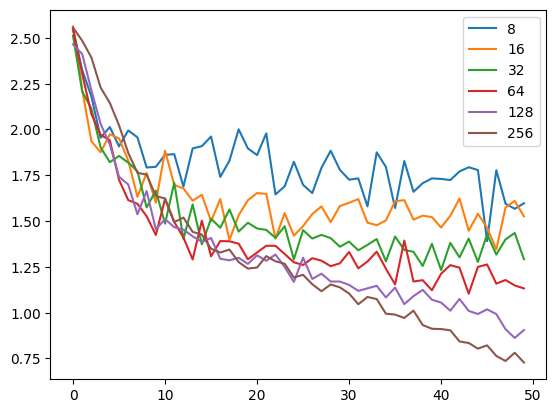

In [107]:
import matplotlib.pyplot as plt

for seq_losses in all_losses:
  plt.plot(seq_losses)
  
plt.legend([8, 16, 32, 64, 128, 256])
plt.show()

In [108]:
[min(seq_losses) for seq_losses in all_losses]

[1.3907519578933716,
 1.3455390930175781,
 1.2327004671096802,
 1.1035881042480469,
 0.8621454834938049,
 0.7281860113143921]